In [ ]:
import streamlit as st
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

#st.set_page_config(layout="wide")
#st.title("Otimizador de Carteira - Seleção Automática")

#@st.cache_data
def get_ibov_components():
    table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
    ticker_column_index = 0  # Ajuste conforme necessário
    tickers = table.iloc[1:, ticker_column_index].dropna().astype(str).str.strip() + ".SA"
    return tickers.tolist()

#@st.cache_data
def filter_stocks(tickers, min_volume=1e6):
    selected = []
    for ticker in tickers:
        try:
            df = yf.download(ticker, period="6mo", progress=False)
            avg_volume = df['Volume'].mean()
            if avg_volume > min_volume:
                selected.append(ticker)
        except:
            continue
    return selected

#@st.cache_data
def download_prices(tickers):
    return yf.download(tickers, start="2022-01-01", end=datetime.date.today(), group_by='ticker')['Adj Close']

def compute_returns(price_data):
    return np.log(price_data / price_data.shift(1)).dropna()

def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    weights = np.linalg.pinv(cov_matrix) @ mean_returns
    weights = np.maximum(weights, 0)
    weights /= weights.sum()
    return pd.DataFrame({"Ticker": returns.columns, "Weight": weights})

tickers = get_ibov_components()
filtered = filter_stocks(tickers)
prices = download_prices(filtered)
if isinstance(prices, pd.Series):
    st.warning("Poucos ativos filtrados. Tente reduzir o filtro de volume.")
else:
    if len(prices.columns) < 5:
        st.warning("Poucos ativos com dados disponíveis. Tente novamente.")
    else:
        returns = compute_returns(prices)
        weights_df = optimize_portfolio(returns)
        st.subheader("Pesos ótimos da carteira:")
        st.dataframe(weights_df.sort_values("Weight", ascending=False), use_container_width=True)




2025-06-08 14:41:27.034 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 14:41:27.036 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 14:41:27.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 14:41:27.041 No runtime found, using MemoryCacheStorageManager
2025-06-08 14:41:27.042 No runtime found, using MemoryCacheStorageManager
2025-06-08 14:41:27.043 No runtime found, using MemoryCacheStorageManager
2025-06-08 14:41:27.045 No runtime found, using MemoryCacheStorageManager
2025-06-08 14:41:27.045 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 14:41:27.046 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-08 14:41:27.047 Thread 'MainThread': missing ScriptRunContext! Thi

ValueError: No objects to concatenate

In [ ]:
# baixar all_data_eua - tickers sp500
import os
import pandas as pd
import yfinance as yf
from datetime import date
import time

# URL da tabela oficial da Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Lê a tabela da página
df = pd.read_html(url)[0]
tickers_sa = df['Symbol'].tolist()


def update_market_data(tickers_input, data_folder: str, price_start: date, price_end: date, price_fname: str, max_attempts: int = 3):
    """
    Baixa e salva os preços ajustados para todos os tickers especificados (pode ser um dict ou list)
    de price_start a price_end, salvando em um único arquivo CSV.
    
    Esta função tenta realizar o download dos tickers e, caso algum não seja baixado corretamente
    (isto é, não haja dados válidos na coluna "Close"), realiza novas tentativas (até max_attempts)
    para esses ativos.
    
    No final, imprime um log com o número de ativos atualizados corretamente.
    """
    os.makedirs(data_folder, exist_ok=True)
    
    # Extrai a lista de tickers (se for dict, usa as chaves)
    if isinstance(tickers_input, dict):
        tickers = list(tickers_input.keys())
    elif isinstance(tickers_input, list):
        tickers = tickers_input
    else:
        raise ValueError("tickers_input deve ser um dict ou uma list")
    
    print(f"[LOG] Baixando preços de {price_start} até {price_end} para {len(tickers)} tickers...")
    
    # Realiza o download inicial para todos os tickers
    df_prices = yf.download(
        tickers    = tickers,
        start      = price_start,
        end        = price_end,
        auto_adjust= True,
        group_by   = 'ticker',
        progress   = False
    )
    
    # Função interna para extrair tickers com dados válidos (verificando a coluna 'Close')
    def get_valid_tickers(df, tickers_list):
        valid = []
        if isinstance(df.columns, pd.MultiIndex):
            for t in tickers_list:
                try:
                    close_series = df[t]['Close']
                    if not close_series.dropna().empty:
                        valid.append(t)
                    else:
                        print(f"[WARN] {t} está presente, mas sem dados válidos na coluna 'Close'.")
                except Exception as e:
                    print(f"[WARN] {t} não pôde ser verificado: {e}")
        else:
            for t in tickers_list:
                if t in df.columns and not df[t].dropna().empty:
                    valid.append(t)
                else:
                    print(f"[WARN] {t} não possui dados ou não está presente nas colunas.")
        return valid

    valid_tickers = get_valid_tickers(df_prices, tickers)
    failed_tickers = list(set(tickers) - set(valid_tickers))
    
    attempt = 1
    while failed_tickers and attempt < max_attempts:
        attempt += 1
        print(f"[LOG] Tentativa {attempt} para os tickers que falharam: {failed_tickers}")
        
        # Tenta baixar novamente só para os tickers que falharam
        df_retry = yf.download(
            tickers    = failed_tickers,
            start      = price_start,
            end        = price_end,
            auto_adjust= True,
            group_by   = 'ticker',
            progress   = False
        )
        # Combina os resultados: se df_prices já for MultiIndex, usa concat por colunas.
        # Caso haja sobreposição, as informações dos tickers rebaixados substituirão as anteriores.
        if df_retry is not None and not df_retry.empty:
            df_prices = pd.concat([df_prices, df_retry], axis=1)
        else:
            print("[WARN] Nenhum dado retornou na tentativa de re-download.")
        
        # Verifica novamente os tickers com dados válidos para os que estavam com problema.
        valid_retry = get_valid_tickers(df_prices, failed_tickers)
        # Remove os que agora foram baixados com sucesso
        failed_tickers = list(set(failed_tickers) - set(valid_retry))
        print(f"[LOG] Após tentativa {attempt}, tickers ainda com falha: {failed_tickers}")
        
        # Opcional: aguarda alguns segundos antes de nova tentativa
        if failed_tickers:
            time.sleep(3)
    
    final_valid = get_valid_tickers(df_prices, tickers)
    print(f"[LOG] {len(final_valid)} de {len(tickers)} ativos foram atualizados corretamente.")
    if failed_tickers:
        print(f"[WARN] Os seguintes ativos não foram baixados: {failed_tickers}")
    
    # Salva o DataFrame de preços em CSV
    csv_path = os.path.join(data_folder, price_fname)
    df_prices.to_csv(csv_path)
    print(f"[LOG] Preços salvos em: {csv_path}")

# =============================================================================
# USO DA FUNÇÃO
# =============================================================================

DATA_FOLDER = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\Git"

# Período histórico fixo até hoje (para preços)
PRICE_START = "2015-01-01"
PRICE_END   = date.today().isoformat()

# Lista de ações e FIIs
acoes = tickers_sa


REITS = [
    'BXP', 'VNO', 'CUZ', 'SLG', 'KRC', 'HIW', 'CDP', 'DEI', 'PGRE', 'ESRT', 
    'DEA', 'PDM', 'BDN', 'NLOP', 'HPP', 'CIO', 'FSP', 'ONL', 'OPI', 'CMCT', 
    'PLD', 'LINE', 'EGP', 'REXR', 'FR', 'STAG', 'TRNO', 'COLD', 'LXP', 'IIPR', 
    'PLYM', 'ILPT', 'KIM', 'REG', 'FRT', 'BRX', 'KRG', 'PECO', 'SKT', 'CURB', 
    'AKR', 'UE', 'IVT', 'ALEX', 'BFS', 'SITC', 'WSR', 'CTO', 'WHLR', 'SPG', 
    'MAC', 'CBL', 'O', 'NNN', 'ADC', 'EPRT', 'FCPT', 'GTY', 'NTST', 'PSTL', 
    'PINE', 'FVR', 'AVB', 'EQR', 'MAA', 'ESS', 'UDR', 'CPT', 'IRT', 'ELME', 
    'VRE', 'AIV', 'CSR', 'NXRT', 'BRT', 'SUI', 'ELS', 'UMH', 'INVH', 'AMH', 
    'BHM', 'WPC', 'BNL', 'GNL', 'JBGS', 'AAT', 'ALX', 'GOOD', 'AHH', 'OLP', 
    'PKST', 'SVC', 'NXDT', 'MDV', 'CLPR', 'MDRR', 'MKZR', 'SQFT', 'GIPR', 'HST', 
    'RHP', 'APLE', 'PK', 'SHO', 'DRH', 'XHR', 'RLJ', 'PEB', 'INN', 'CLDT', 
    'BHR', 'AHT', 'SOHO', 'PSA', 'EXR', 'CUBE', 'NSA', 'SMA', 'SELF', 'WELL', 
    'VTR', 'DOC', 'ARE', 'OHI', 'CTRE', 'AHR', 'HR', 'SBRA', 'NHI', 'MPW', 
    'LTC', 'SILA', 'DHC', 'UHT', 'CHCT', 'GMRE', 'STRW', 'WY', 'RYN', 'PCH', 
    'AMT', 'CCI', 'SBAC', 'UNIT', 'EQIX', 'DLR', 'VICI', 'GLPI', 'IRM', 'LAMR', 
    'EPR', 'MRP', 'OUT', 'SAFE', 'FPI', 'LAND', 'PW', 'NLY', 'AGNC', 'RITM', 
    'EFC', 'TWO', 'PMT', 'CIM', 'DX', 'MFA', 'ARR', 'RWT', 'NYMT', 'ORC', 
    'IVR', 'AOMR', 'MITT', 'LFT', 'RPT', 'CHMI', 'LOAN', 'STWD', 'BXMT', 'ABR', 
    'ARI', 'LADR', 'FBRT', 'RC', 'BRSP', 'TRTX', 'KREF', 'CMTG', 'REFI', 'NREF', 
    'ACRE', 'SEVN', 'ACR', 'SUNS', 'GPMT', 'AFCG', 'SACH'
]

# Combinando as duas listas
tickers_union = acoes + REITS

# Atualiza os preços para os ativos de ações e FIIs, salvando no mesmo arquivo
update_market_data(
    tickers_input = tickers_union,
    data_folder   = DATA_FOLDER,
    price_start   = PRICE_START,
    price_end     = PRICE_END,
    price_fname   = "all_precos_eua.csv"
)

[LOG] Baixando preços de 2015-01-01 até 2025-06-24 para 700 tickers...



2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-06-24)')


[WARN] BRK.B está presente, mas sem dados válidos na coluna 'Close'.
[WARN] BF.B está presente, mas sem dados válidos na coluna 'Close'.
[LOG] Tentativa 2 para os tickers que falharam: ['BF.B', 'BRK.B']



2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-06-24)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


[WARN] Nenhum dado retornou na tentativa de re-download.
[WARN] BF.B está presente, mas sem dados válidos na coluna 'Close'.
[WARN] BRK.B está presente, mas sem dados válidos na coluna 'Close'.
[LOG] Após tentativa 2, tickers ainda com falha: ['BF.B', 'BRK.B']



2 Failed downloads:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-06-24)')


[LOG] Tentativa 3 para os tickers que falharam: ['BF.B', 'BRK.B']
[WARN] Nenhum dado retornou na tentativa de re-download.
[WARN] BF.B está presente, mas sem dados válidos na coluna 'Close'.
[WARN] BRK.B está presente, mas sem dados válidos na coluna 'Close'.
[LOG] Após tentativa 3, tickers ainda com falha: ['BF.B', 'BRK.B']
[WARN] BRK.B está presente, mas sem dados válidos na coluna 'Close'.
[WARN] BF.B está presente, mas sem dados válidos na coluna 'Close'.
[LOG] 698 de 700 ativos foram atualizados corretamente.
[WARN] Os seguintes ativos não foram baixados: ['BF.B', 'BRK.B']
[LOG] Preços salvos em: C:\Users\Diego\OneDrive\Desktop\Curso investimentos\Git\all_precos_eua.csv


In [14]:
# markowitz eua
import os
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# =======================
# Funções Auxiliares
# =======================

def _read_close_prices(path_csv: str) -> pd.DataFrame:
    """Lê CSV de preços. Tenta MultiIndex, se não, usa header simples."""
    try:
        df = pd.read_csv(path_csv, header=[0,1], index_col=0, parse_dates=True)
        if 'Close' in df.columns.get_level_values(1):
            return df.xs('Close', axis=1, level=1).copy()
    except Exception as e:
        pass

    df2 = pd.read_csv(path_csv, index_col=0, parse_dates=True)
    close_cols = [c for c in df2.columns if 'Close' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna 'Close' em {path_csv}")
    return df2[close_cols].copy()

def filtrar_tickers(prices: pd.DataFrame, tickers: list, min_obs: int = 200):
    """
    Retorna duas listas: tickers válidos (com pelo menos min_obs observações válidas)
    e tickers problemáticos (que não atendem a esse critério).
    """
    tickers_validos = []
    tickers_problema = []
    for t in tickers:
        if t in prices.columns:
            n_obs = prices[t].dropna().shape[0]
            if n_obs >= min_obs:
                tickers_validos.append(t)
            else:
                print(f"[INFO] {t} possui apenas {n_obs} observações; removendo da simulação.")
                tickers_problema.append(t)
        else:
            print(f"[INFO] {t} não encontrado no DataFrame.")
            tickers_problema.append(t)
    return tickers_validos, tickers_problema

def filtrar_fronteira_eficiente(vols, rets):
    """
    Remove pontos ineficientes da fronteira: mantém apenas os com retorno máximo
    para cada nível crescente de volatilidade.
    """
    idx_sort = np.argsort(vols)
    vols_sorted = vols[idx_sort]
    rets_sorted = rets[idx_sort]

    efficient_vols = []
    efficient_rets = []
    current_max = -np.inf

    for v, r in zip(vols_sorted, rets_sorted):
        if r > current_max:
            efficient_vols.append(v)
            efficient_rets.append(r)
            current_max = r

    return np.array(efficient_vols), np.array(efficient_rets)

# =======================
# Funções de Simulação
# =======================

def simulate_portfolios(prices: pd.DataFrame, tickers: list, n_sim: int,
                        min_assets: int, max_assets: int, min_w: float,
                        max_w: float, seed: int, alpha_dirichlet: float = 0.3):
    """
    Simula carteiras via Monte Carlo utilizando distribuição Dirichlet
    para gerar os pesos, calcula retorno e risco, e filtra carteiras
    que atendem a:
        - cardinalidade entre min_assets e max_assets (via min_w)
        - peso máximo <= max_w

    Parâmetro alpha_dirichlet controla a concentração: quanto menor,
    maior a chance de carteiras mais concentradas (sugestão: 0.1 a 0.5).
    """
    # Cálculo dos log-retornos e anualização
    rets = np.log(prices / prices.shift(1)).dropna()
    mu   = rets.mean() * 252
    cov  = rets.cov()  * 252

    # Geração dos pesos com Dirichlet esparsa
    rng = np.random.default_rng(seed)
    sim_w = rng.dirichlet(alpha_dirichlet * np.ones(len(tickers)), size=n_sim)

    # Cálculo das métricas
    sim_ret = sim_w.dot(mu.values)
    sim_vol = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))

    # Filtros
    card   = (sim_w >= min_w).sum(axis=1)
    maxpos = sim_w.max(axis=1)
    mask = (card >= min_assets) & (card <= max_assets) & (maxpos <= max_w)
    valid_idx = np.where(mask)[0]

    return sim_ret[valid_idx], sim_vol[valid_idx]

def simulate_portfolios_cardinalidade_controlada(
    prices: pd.DataFrame,
    tickers: list,
    n_sim: int,
    min_assets: int,
    max_assets: int,
    min_w: float,
    max_w: float,
    seed: int,
    alpha_dirichlet: float = 0.3
):
    rets = np.log(prices / prices.shift(1)).dropna()
    mu = rets.mean() * 252
    cov = rets.cov() * 252

    rng = np.random.default_rng(seed)
    n_assets = len(tickers)

    # Ajusta max_assets se for maior que o número de ativos disponíveis
    max_assets = min(max_assets, n_assets)
    min_assets = min(min_assets, max_assets)

    sim_ret = []
    sim_vol = []
    sim_w = []
    ativos_usados = []

    for _ in range(n_sim):
        k = rng.integers(min_assets, max_assets + 1)
        ativos_escolhidos = rng.choice(n_assets, size=k, replace=False)

        pesos = np.zeros(n_assets)
        pesos_ativos = rng.dirichlet(alpha_dirichlet * np.ones(k))
        pesos[ativos_escolhidos] = pesos_ativos

        if pesos.max() > max_w or (pesos >= min_w).sum() < min_assets:
            continue

        ret = np.dot(mu.values, pesos)
        vol = np.sqrt(np.dot(pesos.T, np.dot(cov.values, pesos)))

        sim_ret.append(ret)
        sim_vol.append(vol)
        sim_w.append(pesos)
        ativos_usados.append(ativos_escolhidos)

    return (
        np.array(sim_ret),
        np.array(sim_vol),
        np.array(sim_w),
        ativos_usados
    )

# =======================
# Funções de Otimização
# =======================

def optimize_max_sharpe(mu, cov, min_w=0.0, max_w=1.0):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = [(min_w, max_w)] * n

    def negative_sharpe(w):
        ret = np.dot(mu, w)
        vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -ret / vol

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    res = minimize(negative_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, -res.fun

def portfolio_return(w, mu):
    return np.dot(mu, w)

def portfolio_volatility(w, cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w)))

def minimize_volatility_for_target(mu, cov, target, bounds=None):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = bounds or [(0, 1)] * n
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, mu) - target}
    )
    res = minimize(portfolio_volatility, init, args=(cov,), method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, portfolio_volatility(res.x, cov)

def compute_efficient_frontier(mu, cov, n_points=50):
    targets = np.linspace(min(mu), max(mu), n_points)
    vols, rets = [], []
    for t in targets:
        try:
            w, vol = minimize_volatility_for_target(mu, cov, t)
            vols.append(vol)
            rets.append(t)
        except:
            continue
    return np.array(vols), np.array(rets)

def rebalance_weights(weights, min_w=0.03):
    """
    Zera os pesos abaixo de min_w e rebalanceia os restantes para somar 100%.
    """
    weights = np.where(weights < min_w, 0.0, weights)
    total = weights.sum()
    if total > 0:
        weights = weights / total
    return weights

# =======================
# Funções de Plotagem
# =======================

def plot_results(sim_vol_aco, sim_ret_aco, ef_vol_aco_opt, ef_ret_aco_opt, vol_aco, ret_aco,
                 sim_vol_fii, sim_ret_fii, ef_vol_fii_opt, ef_ret_fii_opt, vol_fii, ret_fii,
                 sim_vol_comb, sim_ret_comb, ef_vol_comb_opt, ef_ret_comb_opt, vol_comb, ret_comb,
                 vol_man, ret_man):
    plt.figure(figsize=(12,8))

    plt.scatter(sim_vol_fii, sim_ret_fii, s=8, alpha=0.12, color='green', label='FIIs (Monte Carlo)')
    plt.plot(ef_vol_fii_opt, ef_ret_fii_opt, 'g-', lw=2, label='Fronteira FIIs')
    plt.scatter(vol_fii, ret_fii, color='green', marker='*', s=180, label='Sharpe Máx FIIs')

    plt.scatter(sim_vol_comb, sim_ret_comb, s=8, alpha=0.12, color='red', label='Combinado (Monte Carlo)')
    plt.plot(ef_vol_comb_opt, ef_ret_comb_opt, 'r-', lw=2, label='Fronteira Combinada')
    plt.scatter(vol_comb, ret_comb, color='red', marker='*', s=180, label='Sharpe Máx Combinado')

    plt.scatter(sim_vol_aco, sim_ret_aco, s=8, alpha=0.12, color='blue', label='Ações (Monte Carlo)')
    plt.plot(ef_vol_aco_opt, ef_ret_aco_opt, 'b-', lw=2, label='Fronteira Ações')
    plt.scatter(vol_aco, ret_aco, color='blue', marker='*', s=180, label='Sharpe Máx Ações')

    plt.scatter(vol_man, ret_man, c="black", s=80, marker="X", label="Minha Carteira")

    plt.xlabel("Volatilidade Anualizada")
    plt.ylabel("Retorno Anualizado")
    plt.title("Fronteira Eficiente – Ações x FIIs x Combinado")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()

# =======================
# Bloco Principal
# =======================

if __name__ == "__main__":
    # Dados – listas de ativos (já com ".SA" e ordenados conforme você criou anteriormente)


    # URL da tabela oficial da Wikipedia
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    # Lê a tabela da página
    df = pd.read_html(url)[0]

    acoes = df['Symbol'].tolist()

    fii = [
        'BXP', 'VNO', 'CUZ', 'SLG', 'KRC', 'HIW', 'CDP', 'DEI', 'PGRE', 'ESRT', 
        'DEA', 'PDM', 'BDN', 'NLOP', 'HPP', 'CIO', 'FSP', 'ONL', 'OPI', 'CMCT', 
        'PLD', 'LINE', 'EGP', 'REXR', 'FR', 'STAG', 'TRNO', 'COLD', 'LXP', 'IIPR', 
        'PLYM', 'ILPT', 'KIM', 'REG', 'FRT', 'BRX', 'KRG', 'PECO', 'SKT', 'CURB', 
        'AKR', 'UE', 'IVT', 'ALEX', 'BFS', 'SITC', 'WSR', 'CTO', 'WHLR', 'SPG', 
        'MAC', 'CBL', 'O', 'NNN', 'ADC', 'EPRT', 'FCPT', 'GTY', 'NTST', 'PSTL', 
        'PINE', 'FVR', 'AVB', 'EQR', 'MAA', 'ESS', 'UDR', 'CPT', 'IRT', 'ELME', 
        'VRE', 'AIV', 'CSR', 'NXRT', 'BRT', 'SUI', 'ELS', 'UMH', 'INVH', 'AMH', 
        'BHM', 'WPC', 'BNL', 'GNL', 'JBGS', 'AAT', 'ALX', 'GOOD', 'AHH', 'OLP', 
        'PKST', 'SVC', 'NXDT', 'MDV', 'CLPR', 'MDRR', 'MKZR', 'SQFT', 'GIPR', 'HST', 
        'RHP', 'APLE', 'PK', 'SHO', 'DRH', 'XHR', 'RLJ', 'PEB', 'INN', 'CLDT', 
        'BHR', 'AHT', 'SOHO', 'PSA', 'EXR', 'CUBE', 'NSA', 'SMA', 'SELF', 'WELL', 
        'VTR', 'DOC', 'ARE', 'OHI', 'CTRE', 'AHR', 'HR', 'SBRA', 'NHI', 'MPW', 
        'LTC', 'SILA', 'DHC', 'UHT', 'CHCT', 'GMRE', 'STRW', 'WY', 'RYN', 'PCH', 
        'AMT', 'CCI', 'SBAC', 'UNIT', 'EQIX', 'DLR', 'VICI', 'GLPI', 'IRM', 'LAMR', 
        'EPR', 'MRP', 'OUT', 'SAFE', 'FPI', 'LAND', 'PW', 'NLY', 'AGNC', 'RITM', 
        'EFC', 'TWO', 'PMT', 'CIM', 'DX', 'MFA', 'ARR', 'RWT', 'NYMT', 'ORC', 
        'IVR', 'AOMR', 'MITT', 'LFT', 'RPT', 'CHMI', 'LOAN', 'STWD', 'BXMT', 'ABR', 
        'ARI', 'LADR', 'FBRT', 'RC', 'BRSP', 'TRTX', 'KREF', 'CMTG', 'REFI', 'NREF', 
        'ACRE', 'SEVN', 'ACR', 'SUNS', 'GPMT', 'AFCG', 'SACH'
    ]

    # Caminhos dos arquivos (supondo que você possua CSVs separados para ações e FIIs)
    folder = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\Git"
    price_csv = os.path.join(folder, "all_precos_eua.csv")

    # Período de análise
    anos = 5
    time_end = pd.Timestamp.now().normalize()
    time_start = time_end - pd.DateOffset(years=anos)

    # Parâmetros para a simulação de Monte Carlo (ajuste conforme necessário)
    n_sim = 100_000
    min_assets = 6
    max_assets = 15
    min_w = 0.03
    max_w = 0.30
    seed = 42
    alpha_dirichlet = 1

    # Ler dados de preços para ações e FIIs
    prices_read = _read_close_prices(price_csv).loc[time_start:time_end]

    # Filtra os tickers com base em um mínimo desejado de observações (por exemplo, 200)
    acoes_validos, acoes_problema = filtrar_tickers(prices_read, acoes, min_obs=200)
    fii_validos, fii_problema     = filtrar_tickers(prices_read, fii, min_obs=200)

    print("[LOG] Ações válidas:", acoes_validos)
    print("[LOG] Ações problemáticas:", acoes_problema)
    print("[LOG] FIIs válidos:", fii_validos)
    print("[LOG] FIIs problemáticos:", fii_problema)

    # Cria os DataFrames filtrados para as simulações
    prices_aco  = prices_read[acoes_validos]
    prices_fii  = prices_read[fii_validos]
    prices_comb = prices_read[acoes_validos + fii_validos]

    # Prepara dados
    rets_aco = np.log(prices_aco / prices_aco.shift(1)).dropna()
    mu_aco = rets_aco.mean() * 252
    cov_aco = rets_aco.cov() * 252

    rets_fii = np.log(prices_fii / prices_fii.shift(1)).dropna()
    mu_fii = rets_fii.mean() * 252
    cov_fii = rets_fii.cov() * 252

    rets_comb = np.log(prices_comb / prices_comb.shift(1)).dropna()
    mu_comb = rets_comb.mean() * 252
    cov_comb = rets_comb.cov() * 252

    # Simulação para ações
    sim_ret_aco, sim_vol_aco, sim_pesos_aco, ativos_aco = simulate_portfolios_cardinalidade_controlada(
        prices_aco,
        acoes_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Simulação para FIIs
    sim_ret_fii, sim_vol_fii, sim_pesos_fii, ativos_fii = simulate_portfolios_cardinalidade_controlada(
        prices_fii,
        fii_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Simulação para ações + FIIs
    sim_ret_comb, sim_vol_comb, sim_pesos_comb, ativos_comb = simulate_portfolios_cardinalidade_controlada(
        prices_comb,
        acoes_validos + fii_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Fronteiras eficientes via SLSQP
    ef_vol_aco_opt, ef_ret_aco_opt = compute_efficient_frontier(mu_aco.values, cov_aco.values)
    ef_vol_aco_opt, ef_ret_aco_opt = filtrar_fronteira_eficiente(ef_vol_aco_opt, ef_ret_aco_opt)

    ef_vol_fii_opt, ef_ret_fii_opt = compute_efficient_frontier(mu_fii.values, cov_fii.values)
    ef_vol_fii_opt, ef_ret_fii_opt = filtrar_fronteira_eficiente(ef_vol_fii_opt, ef_ret_fii_opt)

    ef_vol_comb_opt, ef_ret_comb_opt = compute_efficient_frontier(mu_comb.values, cov_comb.values)
    ef_vol_comb_opt, ef_ret_comb_opt = filtrar_fronteira_eficiente(ef_vol_comb_opt, ef_ret_comb_opt)

    # Sharpe máximo em cada universo
    
    w_sharpe_aco, sharpe_aco = optimize_max_sharpe(mu_aco.values, cov_aco.values, 0.0, max_w)
    w_sharpe_aco = rebalance_weights(w_sharpe_aco, min_w)

    w_sharpe_fii, sharpe_fii = optimize_max_sharpe(mu_fii.values, cov_fii.values, 0.0, max_w)
    w_sharpe_fii = rebalance_weights(w_sharpe_fii, min_w)

    w_sharpe_comb, sharpe_comb = optimize_max_sharpe(mu_comb.values, cov_comb.values, 0.0, max_w)
    w_sharpe_comb = rebalance_weights(w_sharpe_comb, min_w)

    ret_aco = portfolio_return(w_sharpe_aco, mu_aco.values)
    vol_aco = portfolio_volatility(w_sharpe_aco, cov_aco.values)

    ret_fii = portfolio_return(w_sharpe_fii, mu_fii.values)
    vol_fii = portfolio_volatility(w_sharpe_fii, cov_fii.values)

    ret_comb = portfolio_return(w_sharpe_comb, mu_comb.values)
    vol_comb = portfolio_volatility(w_sharpe_comb, cov_comb.values)

    # Converter log-retornos anualizados para retornos aritméticos
    sim_ret_aco = np.exp(sim_ret_aco) - 1
    sim_ret_fii = np.exp(sim_ret_fii) - 1
    sim_ret_comb = np.exp(sim_ret_comb) - 1

    ef_ret_aco_opt = np.exp(ef_ret_aco_opt) - 1
    ef_ret_fii_opt = np.exp(ef_ret_fii_opt) - 1
    ef_ret_comb_opt = np.exp(ef_ret_comb_opt) - 1

    ret_aco = np.exp(ret_aco) - 1
    ret_fii = np.exp(ret_fii) - 1
    ret_comb = np.exp(ret_comb) - 1

    # Carteira manual
    manual_portfolio = {
        'BBAS3.SA': 0.30,
        'PETR4.SA': 0.15,
        'VALE3.SA': 0.15,
        'TAEE11.SA': 0.05,
        'HGLG11.SA': 0.10,
        'KNIP11.SA': 0.15,
        'GARE11.SA': 0.10
    }

    client_tickers = list(manual_portfolio.keys())
    w_man = np.array([manual_portfolio[t] for t in client_tickers])
    w_man /= w_man.sum()

    prices_manual = prices_comb[client_tickers].dropna()
    rets_manual = np.log(prices_manual / prices_manual.shift(1)).dropna()
    mu_manual = rets_manual.mean() * 252
    cov_manual = rets_manual.cov() * 252

    mu_vec = mu_manual.loc[client_tickers].values
    cov_mat = cov_manual.loc[client_tickers, client_tickers].values

    ret_man = np.dot(w_man, mu_vec)
    vol_man = np.sqrt(np.dot(w_man.T, np.dot(cov_mat, w_man)))

    ret_man = np.exp(ret_man) - 1

    # Plotagem
    plot_results(
        sim_vol_aco, sim_ret_aco, ef_vol_aco_opt, ef_ret_aco_opt, vol_aco, ret_aco,
        sim_vol_fii, sim_ret_fii, ef_vol_fii_opt, ef_ret_fii_opt, vol_fii, ret_fii,
        sim_vol_comb, sim_ret_comb, ef_vol_comb_opt, ef_ret_comb_opt, vol_comb, ret_comb,
        vol_man, ret_man
    )

    # ========================
    # Exibir carteiras de Sharpe máximo
    # ========================

    print("\n=== Carteira de Sharpe Máximo – AÇÕES ===")
    serie_aco = pd.Series(w_sharpe_aco, index=acoes_validos)
    serie_aco = serie_aco[serie_aco > 0.001].sort_values(ascending=False)
    for ativo, peso in serie_aco.items():
        print(f"{ativo}: {peso:.2%}")
    print(f"Sharpe: {sharpe_aco:.4f} | Ret: {ret_aco:.2%} | Vol: {vol_aco:.2%}")

    print("\n=== Carteira de Sharpe Máximo – FIIs ===")
    serie_fii = pd.Series(w_sharpe_fii, index=fii_validos)
    serie_fii = serie_fii[serie_fii > 0.001].sort_values(ascending=False)
    for ativo, peso in serie_fii.items():
        print(f"{ativo}: {peso:.2%}")
    print(f"Sharpe: {sharpe_fii:.4f} | Ret: {ret_fii:.2%} | Vol: {vol_fii:.2%}")

    print("\n=== Carteira de Sharpe Máximo – COMBINADA ===")
    tickers_comb = acoes_validos + fii_validos
    serie_comb = pd.Series(w_sharpe_comb, index=tickers_comb)
    serie_comb = serie_comb[serie_comb > 0.001].sort_values(ascending=False)
    for ativo, peso in serie_comb.items():
        print(f"{ativo}: {peso:.2%}")
    print(f"Sharpe: {sharpe_comb:.4f} | Ret: {ret_comb:.2%} | Vol: {vol_comb:.2%}")

    # Composição por classe no portfólio combinado
    idx_acoes = [i for i, tk in enumerate(tickers_comb) if tk in acoes_validos]
    idx_fii = [i for i, tk in enumerate(tickers_comb) if tk in fii_validos]
    pct_acoes = w_sharpe_comb[idx_acoes].sum()
    pct_fii = w_sharpe_comb[idx_fii].sum()
    print(f"\nComposição por classe no Máx. Sharpe Combinado:")
    print(f"Ações: {pct_acoes:.2%} | FIIs: {pct_fii:.2%}")

[INFO] BRK.B possui apenas 0 observações; removendo da simulação.
[INFO] BF.B possui apenas 0 observações; removendo da simulação.
[INFO] CURB possui apenas 184 observações; removendo da simulação.
[INFO] FVR possui apenas 180 observações; removendo da simulação.
[INFO] SMA possui apenas 56 observações; removendo da simulação.
[INFO] MRP possui apenas 95 observações; removendo da simulação.
[LOG] Ações válidas: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB',

KeyError: "None of [Index(['BBAS3.SA', 'PETR4.SA', 'VALE3.SA', 'TAEE11.SA', 'HGLG11.SA',\n       'KNIP11.SA', 'GARE11.SA'],\n      dtype='object', name='Ticker')] are in the [columns]"

In [ ]:
# Este código está funcionando para obter as empresas que pagaram dividendos nos últimos 10 anos
# 1 - Importar bibliotecas
import yfinance as yf
import pandas as pd

# 2 - Informar símbolos das ações de interesse
symbols =  ['SYNE3', 'ALLD3', 'LEVE3', 'PATI3', 'EVEN3', 'VULC3', 'ANIM3', 'AURE3', 'CMIN3', 'PETR4', 'CSRN3', 'CMIG4', 'CSMG3', 'BRAP4', 'BMGB4', 'WHRL4', 'CGAS3', 'EQPA3', 'PINE4', 'GOAU4', 'CSNA3', 'EKTR3', 'RECV3', 'ODPV3', 'VALE3', 'PGMN3', 'BBDC3', 'CGRA4', 'GEPA4', 'BGIP4', 'TAEE11', 'REDE3', 'CEBR3', 'CSED3', 'BBAS3', 'EMAE4', 'TRPL4', 'SOJA3', 'ETER3', 'TGMA3', 'KEPL3', 'CPFE3', 'SCAR3', 'DIRR3', 'VITT3', 'CURY3', 'MELK3', 'LAVV3', 'VBBR3', 'ROMI3', 'BBSE3', 'BEES3', 'RANI3', 'BAZA3', 'ABCB4', 'SHUL4', 'CEEB3', 'VVEO3', 'JHSF3', 'STBP3', 'TIMS3', 'PORT3', 'ITUB4', 'UNIP6', 'AGRO3', 'POSI3', 'ITSA4', 'POMO4', 'CSUD3', 'EGIE3', 'PFRM3', 'VLID3', 'GRND3', 'MYPK3', 'BNBR3', 'FESA4', 'MTRE3', 'LJQQ3', 'DEXP3', 'JBSS3', 'ABEV3', 'CXSE3', 'SANB11', 'GGBR3', 'FIQE3']

# 3 - Adicionar a terminação ".SA" nesses símbolos, pois as mesmas estão listadas dessa forma no yfinance.
symbols = [symbol + '.SA' for symbol in symbols]

# Dicionário para armazenar os dados

data = {}

# 4- Definir período de 10 anos
end_date = pd.Timestamp.now().tz_localize(None)
start_date = end_date - pd.DateOffset(years=10)

# 5 - Buscar os dados de dividendos por empresa e por ano
for symbol in symbols:
    stock = yf.Ticker(symbol)
    dividends = stock.dividends

    if not dividends.empty:
        # Converter o índice de datas para DateTime e remover timezone
        dividends.index = pd.to_datetime(dividends.index).tz_localize(None)

        # Filtrar apenas os dividendos dentro do período desejado
        dividends = dividends[(dividends.index >= start_date) & (dividends.index <= end_date)]

        if not dividends.empty:  # Certificar que ainda existem dividendos após a filtragem
            # Agrupar dividendos por ano e calcular soma
            dividends_yearly = dividends.groupby(dividends.index.year).sum()
            data[symbol] = dividends_yearly.to_dict()

# Verificar quais ações têm registros de dividendos em TODOS os últimos 10 anos
anos_requeridos = list(range(start_date.year, end_date.year + 1))

# Filtrar ações que possuem dividendos em todos os anos do período
data_filtrado = {symbol: valores for symbol, valores in data.items() if all(ano in valores for ano in anos_requeridos)}

# Organizar os dados no DataFrame
df_filtrado = pd.DataFrame(data_filtrado).transpose()
df_filtrado.columns = [f'Dividendos {ano}' for ano in df_filtrado.columns]

# Exportar para Excel
df_filtrado.to_excel('dividendos_filtrados.xlsx', index=True)



# 6 - Organizar os dados em um DataFrame
#df = pd.DataFrame(data)
# Transpor para que as empresas estejam nas linhas e os anos nas colunas
#df = df.transpose()
# Renomear colunas para anos
#df.columns = [f'Dividendos {ano}' for ano in df.columns]
#print(df)
# 7 - Exportar para um arquivo .xlsx (opcional).
#df.to_excel('dividendos.xlsx', index=True)

$CSRN3.SA: possibly delisted; no timezone found
$TRPL4.SA: possibly delisted; no timezone found


In [66]:
#Este código está funcionando para gerar o gráfico da máxima fronteira eficiente, com empresas fixas
import yfinance as yf
import numpy as np
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import matplotlib
matplotlib.use("Qt5Agg")  # ou "QtAgg", se preferir
import matplotlib.pyplot as plt


# 1) DEFINIÇÃO DO PERÍODO
inicio = dt.date(2014, 1, 1)
final = dt.date(2022, 12, 31)

# 2) LISTA DE AÇÕES (você pode incluir quantas quiser)
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

# 3) DOWNLOAD DOS PRECOS AJUSTADOS VIA YFINANCE
df_precos = yf.download(
    tickers=lista_acoes,
    start=inicio,
    end=final,
    auto_adjust=True,  # os preços já ficam ajustados
    progress=False
)

# Se for data de múltiplos tickers, normalmente a coluna "Close" estará em um MultiIndex.
if isinstance(df_precos.columns, pd.MultiIndex):
    precos = df_precos["Close"].copy()
else:
    precos = pd.DataFrame(df_precos["Close"])


# Pegamos apenas a coluna 'Close' (Fechamento Ajustado)
if isinstance(df_precos.columns, pd.MultiIndex):
    precos = df_precos["Close"].copy()
else:
    # Se só um ticker, ele não cria MultiIndex
    precos = pd.DataFrame(df_precos["Close"])
    
# Exibir apenas para debug (comente se não quiser ver)
print("Primeiras linhas de 'Close':")
print(precos.head())

# 4) CÁLCULO DE RETORNOS LOGARÍTMICOS DIÁRIOS
retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna()
media_retornos = retornos.mean()       # Série com a média diária de cada ação
matriz_cov = retornos.cov()             # Matriz de covariância diária

# 5) MONTE CARLO PARA ENCONTRAR AÇÔES DE SHARPE MÁXIMO (opcional)
numero_carteiras = 100_000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    pesos = np.random.random(len(lista_acoes))
    pesos /= np.sum(pesos)
    tabela_pesos[k, :] = pesos

    # Retorno anualizado aproximado: média diária * 252 dias úteis
    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos) * 252
    # Vol anualizada: sqrt(pesos^T * cov*252 * pesos)
    tabela_volatilidades_esperadas[k] = np.sqrt(
        np.dot(pesos.T, np.dot(matriz_cov * 252, pesos))
    )
    tabela_sharpe[k] = (
        tabela_retornos_esperados[k] / tabela_volatilidades_esperadas[k]
    )

indice_sharpe_max = tabela_sharpe.argmax()
pesos_sharpe_max = tabela_pesos[indice_sharpe_max]

print("\nPesos que maximizam Sharpe (via Monte Carlo):")
for acao, peso in zip(lista_acoes, pesos_sharpe_max):
    print(f"{acao}: {peso:.4f}")

# Converter retorno logarítmico de volta a retorno aritmético
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

# 6) CONSTRUÇÃO DA FRONTEIRA EFICIENTE (Fronteira Média-Variância)

# 6.1) Função que, dado um vetor de pesos, retorna o retorno aritmético anualizado
def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    ret_diario = np.sum(media_retornos * peso_teste)
    ret_anual = ret_diario * 252
    return np.exp(ret_anual) - 1  # converte de log para aritmético

# 6.2) Soma dos pesos deve ser 1 (restrição)
def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

# 6.3) Função que retorna a volatilidade anualizada dado pesos
def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol_diaria = np.sqrt(
        np.dot(peso_teste.T, np.dot(matriz_cov, peso_teste))
    )
    vol_anual = vol_diaria * np.sqrt(252)
    return vol_anual

# 6.4) Definindo limites e chute inicial
peso_inicial = [1 / len(lista_acoes)] * len(lista_acoes)
limites = tuple((0, 1) for _ in lista_acoes)

# 6.5) Eixo de retornos desejados (50 pontos igualmente espaçados entre min e max)
eixo_y_fronteira_eficiente = np.linspace(
    np.min(tabela_retornos_esperados_arit),
    np.max(tabela_retornos_esperados_arit),
    50
)

eixo_x_fronteira_eficiente = []

for retorno_alvo in eixo_y_fronteira_eficiente:
    restricoes = (
        {"type": "eq", "fun": checando_soma_pesos},
        {"type": "eq", "fun": lambda w: pegando_retorno(w) - retorno_alvo},
    )
    resultado = minimize(
        pegando_vol,
        peso_inicial,
        method="SLSQP",
        bounds=limites,
        constraints=restricoes,
    )
    # 'fun' devolve a volatilidade encontrada
    eixo_x_fronteira_eficiente.append(resultado["fun"])

# 7) PLOT DA DISPERSÃO (Monte Carlo) E FRONTEIRA EFICIENTE

fig, ax = plt.subplots(figsize=(10, 6))

# scatter dos pontos de Monte Carlo
scatter = ax.scatter(
    tabela_volatilidades_esperadas,
    tabela_retornos_esperados_arit,
    c=tabela_sharpe,
    cmap="viridis",
    s=15,
    alpha=0.6,
)

# Destaque do ponto de Sharpe máximo
ax.scatter(
    tabela_volatilidades_esperadas[indice_sharpe_max],
    tabela_retornos_esperados_arit[indice_sharpe_max],
    c="red",
    s=50,
    label="Sharpe Máximo",
)

# curva da fronteira eficiente
ax.plot(
    eixo_x_fronteira_eficiente,
    eixo_y_fronteira_eficiente,
    color="orange",
    linewidth=2,
    label="Fronteira Eficiente",
)

# Formatação dos eixos em porcentagem
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Volatilidade Anual Esperada")
ax.set_ylabel("Retorno Anual Esperado")
ax.set_title("Carteiras Aleatórias e Fronteira Eficiente")
ax.legend()

cbar = fig.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Sharpe Ratio")

plt.tight_layout()
plt.show()
#plt.savefig("grafico.png")


Primeiras linhas de 'Close':
Ticker       EGIE3.SA  EQTL3.SA  LREN3.SA  PETR4.SA   VALE3.SA  WEGE3.SA
Date                                                                    
2014-01-02  22.028221  4.552613  7.770381  4.574583  22.545525  3.665127
2014-01-03  22.160921  4.476703  7.879694  4.506305  22.059771  3.631370
2014-01-06  21.738693  4.428760  7.769065  4.539078  22.079199  3.650660
2014-01-07  21.563772  4.428760  7.923155  4.413449  21.535152  3.648249
2014-01-08  21.515514  4.446739  7.908669  4.421642  21.684122  3.585556

Pesos que maximizam Sharpe (via Monte Carlo):
WEGE3.SA: 0.0042
LREN3.SA: 0.5258
VALE3.SA: 0.0218
PETR4.SA: 0.0237
EQTL3.SA: 0.0175
EGIE3.SA: 0.4069


[LOG] Resultados serão exportados para: C:\Users\Diego\OneDrive\Desktop\Curso investimentos
[LOG] Anos usados para cálculo do dividend yield: [2020, 2021, 2022, 2023, 2024]
[LOG] Total de empresas iniciais: 672



1 Failed download:
['AGRX11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para AGRX11.SA.



1 Failed download:
['GOLL3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17) (Yahoo error = "No data found, symbol may be delisted")')


[LOG] Sem dados para GOLL3.SA.



1 Failed download:
['KRSA3.SA']: Timeout('Failed to perform, curl: (28) Connection timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


[LOG] Sem dados para KRSA3.SA.



1 Failed download:
['BLCP11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para BLCP11.SA.



1 Failed download:
['FTCA11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para FTCA11.SA.



1 Failed download:
['FZDB11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para FZDB11.SA.



1 Failed download:
['NUIF11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para NUIF11.SA.



1 Failed download:
['VIGT11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para VIGT11.SA.



1 Failed download:
['JMBI11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para JMBI11.SA.



1 Failed download:
['BBIM11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para BBIM11.SA.



1 Failed download:
['IRIF11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para IRIF11.SA.



1 Failed download:
['QIRI11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para QIRI11.SA.



1 Failed download:
['ERCR11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-06-17 -> 2025-06-17)')


[LOG] Sem dados para ERCR11.SA.
[LOG] Dados baixados para 659 de 672 tickers.
[LOG] Empresas que pagaram dividendos consistentes (10 anos): 76
dict_keys(['DEVA11.SA', 'URPR11.SA', 'CGRA4.SA', 'CYRE3.SA', 'DIRR3.SA', 'GRND3.SA', 'JHSF3.SA', 'LREN3.SA', 'RENT3.SA', 'WHRL4.SA', 'CAML3.SA', 'MDIA3.SA', 'VIVA3.SA', 'BBAS3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BMGB4.SA', 'BRSR6.SA', 'BSLI3.SA', 'CSUD3.SA', 'ITSA4.SA', 'ITUB4.SA', 'MULT3.SA', 'SANB11.SA', 'BRAP4.SA', 'DEXP3.SA', 'DXCO3.SA', 'FESA4.SA', 'GOAU4.SA', 'UNIP6.SA', 'VALE3.SA', 'PETR4.SA', 'VBBR3.SA', 'BALM4.SA', 'HYPE3.SA', 'ODPV3.SA', 'OFSA3.SA', 'PNVL3.SA', 'RADL3.SA', 'TOTS3.SA', 'TIMS3.SA', 'VIVT3.SA', 'CASN3.SA', 'CASN4.SA', 'CEBR6.SA', 'CEGR3.SA', 'CGAS5.SA', 'CMIG4.SA', 'EGIE3.SA', 'GEPA4.SA', 'NEOE3.SA', 'SAPR11.SA', 'TAEE11.SA', 'TGAR11.SA', 'TRXB11.SA', 'HCRI11.SA', 'NSLU11.SA', 'HSLG11.SA', 'PATL11.SA', 'PQAG11.SA', 'XPIE11.SA', 'CNES11.SA', 'EDGA11.SA', 'PVBI11.SA', 'VVMR11.SA', 'RZTR11.SA', 'CPTS11.SA', 'HSAF11.SA', 'LFTT11.SA

HTTP Error 401: 
HTTP Error 401: 
HTTP Error 401: 
HTTP Error 401: 
HTTP Error 401: 
HTTP Error 401: 
HTTP Error 401: 


[LOG] Dados fundamentais coletados:
       Ticker                             Setor        P/L     CAGR5
0   DEVA11.SA                            Papéis  27.745766 -0.142280
1   URPR11.SA                            Papéis   6.381411 -0.048880
2    CGRA4.SA                   Consumo cíclico   5.844445  0.113601
3    CYRE3.SA                   Consumo cíclico   5.418804  0.078930
4    DIRR3.SA                   Consumo cíclico  11.193029  0.353589
5    GRND3.SA                   Consumo cíclico   6.835443 -0.009476
6    JHSF3.SA                   Consumo cíclico   3.439490  0.032622
7    LREN3.SA                   Consumo cíclico  15.413222 -0.103613
8    RENT3.SA                   Consumo cíclico  24.777777  0.044138
9    WHRL4.SA                   Consumo cíclico   9.568628  0.011206
10   CAML3.SA               Consumo não cíclico   8.590163 -0.101301
11   MDIA3.SA               Consumo não cíclico  14.181818 -0.073771
12   VIVA3.SA               Consumo não cíclico   8.051283  0.05704

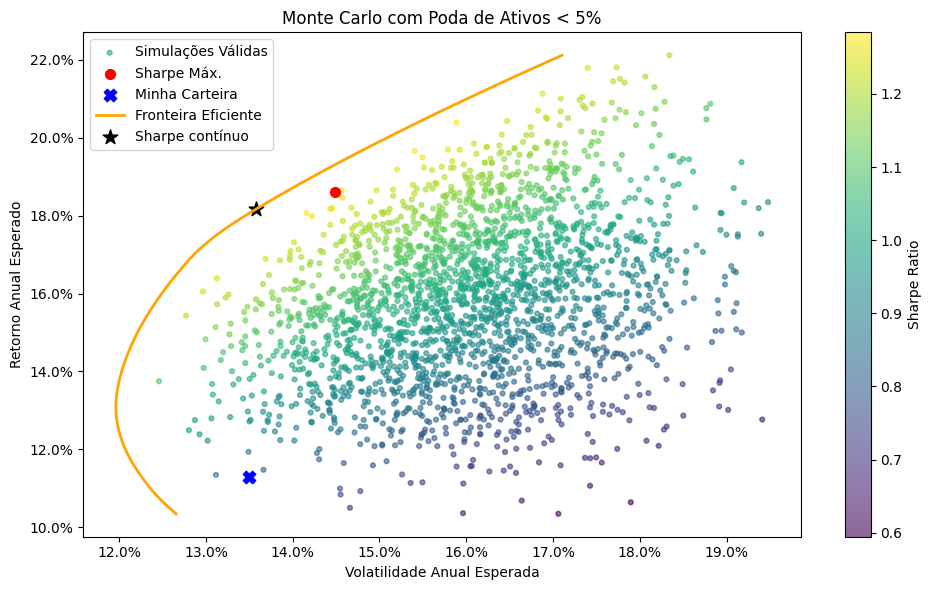

In [ ]:
# Análise de ações com Markowitz

import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

# =============================================================================
# CONFIGURAÇÃO DE DIRETÓRIO PARA EXPORTAÇÃO
export_folder = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos"
os.makedirs(export_folder, exist_ok=True)
print(f"[LOG] Resultados serão exportados para: {export_folder}")

SECTOR_MAP = {
    'AERI3.SA': 'Bens industriais',
    'AGRX11.SA': 'Bens industriais',
    'ALLD3.SA': 'Bens industriais',
    'ALPK3.SA': 'Bens industriais',
    'AMBP3.SA': 'Bens industriais',
    'AMOB3.SA': 'Bens industriais',
    'ARML3.SA': 'Bens industriais',
    'ASAI3.SA': 'Bens industriais',
    'ATMP3.SA': 'Bens industriais',
    'AVLL3.SA': 'Bens industriais',
    'BBGO11.SA': 'Bens industriais',
    'BHIA3.SA': 'Bens industriais',
    'BLAU3.SA': 'Bens industriais',
    'BMLC11.SA': 'Bens industriais',
    'BMOB3.SA': 'Bens industriais',
    'BRBI11.SA': 'Bens industriais',
    'CASH3.SA': 'Bens industriais',
    'CBAV3.SA': 'Bens industriais',
    'CJCT11.SA': 'Bens industriais',
    'CMIN3.SA': 'Bens industriais',
    'CPTR11.SA': 'Bens industriais',
    'CRAA11.SA': 'Bens industriais',
    'CSED3.SA': 'Bens industriais',
    'CURY3.SA': 'Bens industriais',
    'CXSE3.SA': 'Bens industriais',
    'DEVA11.SA': 'Bens industriais',
    'DMVF3.SA': 'Bens industriais',
    'DOTZ3.SA': 'Bens industriais',
    'EGAF11.SA': 'Bens industriais',
    'ELMD3.SA': 'Bens industriais',
    'ENJU3.SA': 'Bens industriais',
    'ESPA3.SA': 'Bens industriais',
    'FGAA11.SA': 'Bens industriais',
    'GCRA11.SA': 'Bens industriais',
    'GGPS3.SA': 'Bens industriais',
    'GMAT3.SA': 'Bens industriais',
    'GOLL3.SA': 'Bens industriais',
    'GRWA11.SA': 'Bens industriais',
    'HBSA3.SA': 'Bens industriais',
    'HGAG11.SA': 'Bens industriais',
    'HODL11.SA': 'Bens industriais',
    'INTB3.SA': 'Bens industriais',
    'ISAE4.SA': 'Bens industriais',
    'JALL3.SA': 'Bens industriais',
    'JSLG3.SA': 'Bens industriais',
    'KNCA11.SA': 'Bens industriais',
    'KRSA3.SA': 'Bens industriais',
    'LAVV3.SA': 'Bens industriais',
    'LJQQ3.SA': 'Bens industriais',
    'LSAG11.SA': 'Bens industriais',
    'MATD3.SA': 'Bens industriais',
    'MBLY3.SA': 'Bens industriais',
    'MELK3.SA': 'Bens industriais',
    'MLAS3.SA': 'Bens industriais',
    'MTRE3.SA': 'Bens industriais',
    'NGRD3.SA': 'Bens industriais',
    'OPCT3.SA': 'Bens industriais',
    'ORVR3.SA': 'Bens industriais',
    'PETZ3.SA': 'Bens industriais',
    'PGMN3.SA': 'Bens industriais',
    'PLCA11.SA': 'Bens industriais',
    'PLPL3.SA': 'Bens industriais',
    'RECR11.SA': 'Bens industriais',
    'RURA11.SA': 'Bens industriais',
    'RZAT11.SA': 'Bens industriais',
    'SEQL3.SA': 'Bens industriais',
    'SNAG11.SA': 'Bens industriais',
    'TFCO4.SA': 'Bens industriais',
    'TTEN3.SA': 'Bens industriais',
    'URPR11.SA': 'Bens industriais',
    'VAMO3.SA': 'Bens industriais',
    'VCRA11.SA': 'Bens industriais',
    'VGIA11.SA': 'Bens industriais',
    'VITT3.SA': 'Bens industriais',
    'WEST3.SA': 'Bens industriais',
    'ZAMP3.SA': 'Bens industriais',
    'ALOS3.SA': 'Consumo cíclico',
    'AMAR3.SA': 'Consumo cíclico',
    'AZZA3.SA': 'Consumo cíclico',
    'CEAB3.SA': 'Consumo cíclico',
    'CEDO4.SA': 'Consumo cíclico',
    'CGRA4.SA': 'Consumo cíclico',
    'COGN3.SA': 'Consumo cíclico',
    'CTKA4.SA': 'Consumo cíclico',
    'CTNM3.SA': 'Consumo cíclico',
    'CVCB3.SA': 'Consumo cíclico',
    'CYRE3.SA': 'Consumo cíclico',
    'DIRR3.SA': 'Consumo cíclico',
    'ESTR3.SA': 'Consumo cíclico',
    'ESTR4.SA': 'Consumo cíclico',
    'EVEN3.SA': 'Consumo cíclico',
    'EZTC3.SA': 'Consumo cíclico',
    'GFSA3.SA': 'Consumo cíclico',
    'GRND3.SA': 'Consumo cíclico',
    'HBOR3.SA': 'Consumo cíclico',
    'HOOT4.SA': 'Consumo cíclico',
    'JHSF3.SA': 'Consumo cíclico',
    'LEVE3.SA': 'Consumo cíclico',
    'LREN3.SA': 'Consumo cíclico',
    'MGLU3.SA': 'Consumo cíclico',
    'MNDL3.SA': 'Consumo cíclico',
    'MOVI3.SA': 'Consumo cíclico',
    'MRVE3.SA': 'Consumo cíclico',
    'MYPK3.SA': 'Consumo cíclico',
    'PDGR3.SA': 'Consumo cíclico',
    'RDNI3.SA': 'Consumo cíclico',
    'RENT3.SA': 'Consumo cíclico',
    'RSID3.SA': 'Consumo cíclico',
    'SBFG3.SA': 'Consumo cíclico',
    'SEER3.SA': 'Consumo cíclico',
    'SLED3.SA': 'Consumo cíclico',
    'SLED4.SA': 'Consumo cíclico',
    'TCSA3.SA': 'Consumo cíclico',
    'VSTE3.SA': 'Consumo cíclico',
    'WHRL4.SA': 'Consumo cíclico',
    'YDUQ3.SA': 'Consumo cíclico',
    'AGRO3.SA': 'Consumo não cíclico',
    'BEEF3.SA': 'Consumo não cíclico',
    'BRFS3.SA': 'Consumo não cíclico',
    'CAML3.SA': 'Consumo não cíclico',
    'CRFB3.SA': 'Consumo não cíclico',
    'JBSS3.SA': 'Consumo não cíclico',
    'MDIA3.SA': 'Consumo não cíclico',
    'MRFG3.SA': 'Consumo não cíclico',
    'NTCO3.SA': 'Consumo não cíclico',
    'PCAR3.SA': 'Consumo não cíclico',
    'SMTO3.SA': 'Consumo não cíclico',
    'VIVA3.SA': 'Consumo não cíclico',
    'BBAS3.SA': 'Financeiro',
    'BBDC4.SA': 'Financeiro',
    'BBSE3.SA': 'Financeiro',
    'BMGB4.SA': 'Financeiro',
    'BMIN3.SA': 'Financeiro',
    'BPAN4.SA': 'Financeiro',
    'BPAR3.SA': 'Financeiro',
    'BRPR3.SA': 'Financeiro',
    'BRSR6.SA': 'Financeiro',
    'BSLI3.SA': 'Financeiro',
    'CSUD3.SA': 'Financeiro',
    'GSHP3.SA': 'Financeiro',
    'IGTI11.SA': 'Financeiro',
    'IRBR3.SA': 'Financeiro',
    'ITSA4.SA': 'Financeiro',
    'ITUB4.SA': 'Financeiro',
    'LOGG3.SA': 'Financeiro',
    'LPSB3.SA': 'Financeiro',
    'MERC4.SA': 'Financeiro',
    'MULT3.SA': 'Financeiro',
    'NDIV11.SA': 'Financeiro',
    'PDTC3.SA': 'Financeiro',
    'PSSA3.SA': 'Financeiro',
    'SANB11.SA': 'Financeiro',
    'SCAR3.SA': 'Financeiro',
    'SYNE3.SA': 'Financeiro',
    'TRAD3.SA': 'Financeiro',
    'BRAP4.SA': 'Materiais básicos',
    'BRKM5.SA': 'Materiais básicos',
    'CSNA3.SA': 'Materiais básicos',
    'DEXP3.SA': 'Materiais básicos',
    'DXCO3.SA': 'Materiais básicos',
    'EUCA4.SA': 'Materiais básicos',
    'FESA4.SA': 'Materiais básicos',
    'GOAU4.SA': 'Materiais básicos',
    'KLBN11.SA': 'Materiais básicos',
    'LAND3.SA': 'Materiais básicos',
    'MMXM11.SA': 'Materiais básicos',
    'NEMO3.SA': 'Materiais básicos',
    'PMAM3.SA': 'Materiais básicos',
    'SUZB3.SA': 'Materiais básicos',
    'UNIP6.SA': 'Materiais básicos',
    'VALE3.SA': 'Materiais básicos',
    'AFHI11.SA': 'Outros',
    'AGXY3.SA': 'Outros',
    'ALUG11.SA': 'Outros',
    'BDOM11.SA': 'Outros',
    'BIME11.SA': 'Outros',
    'CACR11.SA': 'Outros',
    'CRPG5.SA': 'Outros',
    'CXAG11.SA': 'Outros',
    'CYCR11.SA': 'Outros',
    'EQIR11.SA': 'Outros',
    'GTLG11.SA': 'Outros',
    'HSRE11.SA': 'Outros',
    'HUSI11.SA': 'Outros',
    'JGPX11.SA': 'Outros',
    'JSAF11.SA': 'Outros',
    'MORC11.SA': 'Outros',
    'PORT3.SA': 'Outros',
    'PPLA11.SA': 'Outros',
    'PURB11.SA': 'Outros',
    'ROOF11.SA': 'Outros',
    'RZAG11.SA': 'Outros',
    'SMAB11.SA': 'Outros',
    'SMFT3.SA': 'Outros',
    'SOJA3.SA': 'Outros',
    'SPXB11.SA': 'Outros',
    'USTK11.SA': 'Outros',
    'VTRU3.SA': 'Outros',
    'WRLD11.SA': 'Outros',
    'YDRO11.SA': 'Outros',
    'OSXB3.SA': 'Petróleo, Gás e Biocombustíveis',
    'PETR4.SA': 'Petróleo, Gás e Biocombustíveis',
    'PRIO3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RAIZ4.SA': 'Petróleo, Gás e Biocombustíveis',
    'RECV3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RPMG3.SA': 'Petróleo, Gás e Biocombustíveis',
    'SRNA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'UGPA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'VBBR3.SA': 'Petróleo, Gás e Biocombustíveis',
    'AALR3.SA': 'Saúde',
    'BALM4.SA': 'Saúde',
    'BIOM3.SA': 'Saúde',
    'FLRY3.SA': 'Saúde',
    'HYPE3.SA': 'Saúde',
    'ODPV3.SA': 'Saúde',
    'OFSA3.SA': 'Saúde',
    'ONCO3.SA': 'Saúde',
    'PNVL3.SA': 'Saúde',
    'QUAL3.SA': 'Saúde',
    'RADL3.SA': 'Saúde',
    'VVEO3.SA': 'Saúde',
    'IFCM3.SA': 'Tecnologia da Informação',
    'LVTC3.SA': 'Tecnologia da Informação',
    'LWSA3.SA': 'Tecnologia da Informação',
    'POSI3.SA': 'Tecnologia da Informação',
    'TOTS3.SA': 'Tecnologia da Informação',
    'DESK3.SA': 'Telecomunicações',
    'FIQE3.SA': 'Telecomunicações',
    'OIBR3.SA': 'Telecomunicações',
    'TELB3.SA': 'Telecomunicações',
    'TIMS3.SA': 'Telecomunicações',
    'VIVT3.SA': 'Telecomunicações',
    'AFLT3.SA':  'Utilidade pública',
    'ALUP11.SA': 'Utilidade pública',
    'AURE3.SA':  'Utilidade pública',
    'BRAV3.SA':  'Utilidade pública',
    'CASN3.SA':  'Utilidade pública',
    'CASN4.SA':  'Utilidade pública',
    'CEBR6.SA':  'Utilidade pública',
    'CEED3.SA':  'Utilidade pública',
    'CEGR3.SA':  'Utilidade pública',
    'CGAS5.SA':  'Utilidade pública',
    'CLSC4.SA':  'Utilidade pública',
    'CMIG4.SA':  'Utilidade pública',
    'COCE5.SA':  'Utilidade pública',
    'CPFE3.SA':  'Utilidade pública',
    'CPLE6.SA':  'Utilidade pública',
    'EGIE3.SA':  'Utilidade pública',
    'GEPA4.SA':  'Utilidade pública',
    'NEOE3.SA':  'Utilidade pública',
    'RNEW4.SA':  'Utilidade pública',
    'SAPR11.SA': 'Utilidade pública',
    'SBSP3.SA':  'Utilidade pública',
    'TAEE11.SA': 'Utilidade pública',
    'BBPO11.SA': 'Agências de Bancos',
    'BBRC11.SA': 'Agências de Bancos',
    'BNFS11.SA': 'Agências de Bancos',
    'CXAG11.SA': 'Agências de Bancos',
    'TVRI11.SA': 'Agências de Bancos',
    'NEXG11.SA': 'Agricultura',
    'FAED11.SA': 'Educacional',
    'FCFL11.SA': 'Educacional',
    'RBED11.SA': 'Educacional',
    'ZIFI11.SA': 'Fundo de Desenvolvimento',
    'BRIM11.SA': 'Fundo de Desenvolvimento',
    'BRIP11.SA': 'Fundo de Desenvolvimento',
    'BTWR11.SA': 'Fundo de Desenvolvimento',
    'CFHI11.SA': 'Fundo de Desenvolvimento',
    'FLFL11.SA': 'Fundo de Desenvolvimento',
    'HRDF11.SA': 'Fundo de Desenvolvimento',
    'INRD11.SA': 'Fundo de Desenvolvimento',
    'KEVE11.SA': 'Fundo de Desenvolvimento',
    'KINP11.SA': 'Fundo de Desenvolvimento',
    'KNRE11.SA': 'Fundo de Desenvolvimento',
    'LOFT11B.SA': 'Fundo de Desenvolvimento',
    'MFII11.SA': 'Fundo de Desenvolvimento',
    'PABY11.SA': 'Fundo de Desenvolvimento',
    'PATC11.SA': 'Fundo de Desenvolvimento',
    'PNDL11.SA': 'Fundo de Desenvolvimento',
    'PNPR11.SA': 'Fundo de Desenvolvimento',
    'RBDS11.SA': 'Fundo de Desenvolvimento',
    'RBIR11.SA': 'Fundo de Desenvolvimento',
    'RBRI11.SA': 'Fundo de Desenvolvimento',
    'RBRM11.SA': 'Fundo de Desenvolvimento',
    'RBRS11.SA': 'Fundo de Desenvolvimento',
    'RBTS11.SA': 'Fundo de Desenvolvimento',
    'ROOF11.SA': 'Fundo de Desenvolvimento',
    'RSPD11.SA': 'Fundo de Desenvolvimento',
    'SNEL11.SA': 'Fundo de Desenvolvimento',
    'STRX11.SA': 'Fundo de Desenvolvimento',
    'TGAR11.SA': 'Fundo de Desenvolvimento',
    'TRXB11.SA': 'Fundo de Desenvolvimento',
    'VXXV11.SA': 'Fundo de Desenvolvimento',
    'YUFI11.SA': 'Fundo de Desenvolvimento',
    'ALZM11.SA': 'Fundo de Fundos',
    'BBFO11.SA': 'Fundo de Fundos',
    'BCIA11.SA': 'Fundo de Fundos',
    'BICE11.SA': 'Fundo de Fundos',
    'BLMR11.SA': 'Fundo de Fundos',
    'BPFF11.SA': 'Fundo de Fundos',
    'CLIN11.SA': 'Fundo de Fundos',
    'CPFF11.SA': 'Fundo de Fundos',
    'CRFF11.SA': 'Fundo de Fundos',
    'CXRI11.SA': 'Fundo de Fundos',
    'DVFF11.SA': 'Fundo de Fundos',
    'GCFF11.SA': 'Fundo de Fundos',
    'HFOF11.SA': 'Fundo de Fundos',
    'HGFF11.SA': 'Fundo de Fundos',
    'IBFF11.SA': 'Fundo de Fundos',
    'ITIT11.SA': 'Fundo de Fundos',
    'JCIN11.SA': 'Fundo de Fundos',
    'JSAF11.SA': 'Fundo de Fundos',
    'KFOF11.SA': 'Fundo de Fundos',
    'KISU11.SA': 'Fundo de Fundos',
    'MORE11.SA': 'Fundo de Fundos',
    'OUFF11.SA': 'Fundo de Fundos',
    'RBFF11.SA': 'Fundo de Fundos',
    'RBRF11.SA': 'Fundo de Fundos',
    'RCFF11.SA': 'Fundo de Fundos',
    'RECX11.SA': 'Fundo de Fundos',
    'RFOF11.SA': 'Fundo de Fundos',
    'RVBI11.SA': 'Fundo de Fundos',
    'SNFF11.SA': 'Fundo de Fundos',
    'TMPS11.SA': 'Fundo de Fundos',
    'VIFI11.SA': 'Fundo de Fundos',
    'XPSF11.SA': 'Fundo de Fundos',
    'HCRI11.SA': 'Hospitalar',
    'HUCG11.SA': 'Hospitalar',
    'HUSC11.SA': 'Hospitalar',
    'HUSI11.SA': 'Hospitalar',
    'NSLU11.SA': 'Hospitalar',
    'NVHO11.SA': 'Hospitalar',
    'BTHI11.SA': 'Hotéis',
    'HTMX11.SA': 'Hotéis',
    'MGHT11.SA': 'Hotéis',
    'XPHT11.SA': 'Hotéis',
    'AURB11.SA': 'Imóveis Comerciais - Outros',
    'JASC11.SA': 'Imóveis Comerciais - Outros',
    'LIFE11.SA': 'Imóveis Comerciais - Outros',
    'SOLR11.SA': 'Imóveis Comerciais - Outros',
    'TOPP11.SA': 'Imóveis Comerciais - Outros',
    'TRXF11.SA': 'Imóveis Comerciais - Outros',
    'AROA11.SA': 'Imóveis Industriais e Logísticos',
    'BLCP11.SA': 'Imóveis Industriais e Logísticos',
    'BLMG11.SA': 'Imóveis Industriais e Logísticos',
    'BRCO11.SA': 'Imóveis Industriais e Logísticos',
    'BTAL11.SA': 'Imóveis Industriais e Logísticos',
    'BTLG11.SA': 'Imóveis Industriais e Logísticos',
    'BTSG11.SA': 'Imóveis Industriais e Logísticos',
    'CXTL11.SA': 'Imóveis Industriais e Logísticos',
    'EURO11.SA': 'Imóveis Industriais e Logísticos',
    'FIIB11.SA': 'Imóveis Industriais e Logísticos',
    'GARE11.SA': 'Imóveis Industriais e Logísticos',
    'GGRC11.SA': 'Imóveis Industriais e Logísticos',
    'GLOG11.SA': 'Imóveis Industriais e Logísticos',
    'GTLG11.SA': 'Imóveis Industriais e Logísticos',
    'HDEL11.SA': 'Imóveis Industriais e Logísticos',
    'HGLG11.SA': 'Imóveis Industriais e Logísticos',
    'HLOG11.SA': 'Imóveis Industriais e Logísticos',
    'HSLG11.SA': 'Imóveis Industriais e Logísticos',
    'INLG11.SA': 'Imóveis Industriais e Logísticos',
    'LVBI11.SA': 'Imóveis Industriais e Logísticos',
    'NEWL11.SA': 'Imóveis Industriais e Logísticos',
    'OULG11.SA': 'Imóveis Industriais e Logísticos',
    'PATL11.SA': 'Imóveis Industriais e Logísticos',
    'PQAG11.SA': 'Imóveis Industriais e Logísticos',
    'RBLG11.SA': 'Imóveis Industriais e Logísticos',
    'RBRL11.SA': 'Imóveis Industriais e Logísticos',
    'RELG11.SA': 'Imóveis Industriais e Logísticos',
    'RZAT11.SA': 'Imóveis Industriais e Logísticos',
    'RZZR11.SA': 'Imóveis Industriais e Logísticos',
    'SDIL11.SA': 'Imóveis Industriais e Logísticos',
    'SJAU11.SA': 'Imóveis Industriais e Logísticos',
    'SNLG11.SA': 'Imóveis Industriais e Logísticos',
    'TRBL11.SA': 'Imóveis Industriais e Logísticos',
    'VILG11.SA': 'Imóveis Industriais e Logísticos',
    'VTLT11.SA': 'Imóveis Industriais e Logísticos',
    'XPIN11.SA': 'Imóveis Industriais e Logísticos',
    'XPLG11.SA': 'Imóveis Industriais e Logísticos',
    'APTO11.SA': 'Imóveis Residenciais',
    'HOSI11.SA': 'Imóveis Residenciais',
    'HRES11.SA': 'Imóveis Residenciais',
    'JFLL11.SA': 'Imóveis Residenciais',
    'LTMT11.SA': 'Imóveis Residenciais',
    'OBAL11.SA': 'Imóveis Residenciais',
    'PNCR11.SA': 'Imóveis Residenciais',
    'VCRR11.SA': 'Imóveis Residenciais',
    'BTYU11.SA': 'Incorporações',
    'SMRE11.SA': 'Incorporações',
    'AAGR11.SA': 'Indefinido',
    'AAZQ11.SA': 'Indefinido',
    'AGRX11.SA': 'Indefinido',
    'ASRF11.SA': 'Indefinido',
    'BBGO11.SA': 'Indefinido',
    'BDIF11.SA': 'Indefinido',
    'BDIV11.SA': 'Indefinido',
    'BIDB11.SA': 'Indefinido',
    'BIME11.SA': 'Indefinido',
    'BIPD11.SA': 'Indefinido',
    'BLCA11.SA': 'Indefinido',
    'BODB11.SA': 'Indefinido',
    'BTAG11.SA': 'Indefinido',
    'BTRA11.SA': 'Indefinido',
    'CCME11.SA': 'Indefinido',
    'CCVA11.SA': 'Indefinido',
    'CDII11.SA': 'Indefinido',
    'CFII11.SA': 'Indefinido',
    'CPSH11.SA': 'Indefinido',
    'CPTI11.SA': 'Indefinido',
    'CPTR11.SA': 'Indefinido',
    'CRAA11.SA': 'Indefinido',
    'CXCI11.SA': 'Indefinido',
    'CYCR11.SA': 'Indefinido',
    'DCRA11.SA': 'Indefinido',
    'DPRO11.SA': 'Indefinido',
    'EGAF11.SA': 'Indefinido',
    'ENDD11.SA': 'Indefinido',
    'EQIR11.SA': 'Indefinido',
    'ESUD11.SA': 'Indefinido',
    'ESUT11.SA': 'Indefinido',
    'ESUU11.SA': 'Indefinido',
    'EXES11.SA': 'Indefinido',
    'FGAA11.SA': 'Indefinido',
    'FPOR11.SA': 'Indefinido',
    'FTCA11.SA': 'Indefinido',
    'FZDA11.SA': 'Indefinido',
    'FZDB11.SA': 'Indefinido',
    'GAME11.SA': 'Indefinido',
    'GCOI11.SA': 'Indefinido',
    'GCRA11.SA': 'Indefinido',
    'GRWA11.SA': 'Indefinido',
    'GZIT11.SA': 'Indefinido',
    'HBCR11.SA': 'Indefinido',
    'HCRA11.SA': 'Indefinido',
    'HGAG11.SA': 'Indefinido',
    'HILG11.SA': 'Indefinido',
    'IAAG11.SA': 'Indefinido',
    'IAGR11.SA': 'Indefinido',
    'IBBP11.SA': 'Indefinido',
    'IDFI11.SA': 'Indefinido',
    'IFRA11.SA': 'Indefinido',
    'INFB11.SA': 'Indefinido',
    'IRIM11.SA': 'Indefinido',
    'JGPX11.SA': 'Indefinido',
    'JURO11.SA': 'Indefinido',
    'KCRE11.SA': 'Indefinido',
    'KDIF11.SA': 'Indefinido',
    'KFEN11.SA': 'Indefinido',
    'KNCA11.SA': 'Indefinido',
    'KNHF11.SA': 'Indefinido',
    'KNOX11.SA': 'Indefinido',
    'KNUQ11.SA': 'Indefinido',
    'KOPA11.SA': 'Indefinido',
    'LPLP11.SA': 'Indefinido',
    'LRDI11.SA': 'Indefinido',
    'LSAG11.SA': 'Indefinido',
    'MANA11.SA': 'Indefinido',
    'MATV11.SA': 'Indefinido',
    'MMPD11.SA': 'Indefinido',
    'NUIF11.SA': 'Indefinido',
    'NVRP11.SA': 'Indefinido',
    'OGHY11.SA': 'Indefinido',
    'OIAG11.SA': 'Indefinido',
    'PFIN11.SA': 'Indefinido',
    'PICE11.SA': 'Indefinido',
    'PLAG11.SA': 'Indefinido',
    'PLCA11.SA': 'Indefinido',
    'PNRC11.SA': 'Indefinido',
    'PPEI11.SA': 'Indefinido',
    'PRIF11.SA': 'Indefinido',
    'RBIF11.SA': 'Indefinido',
    'RBRX11.SA': 'Indefinido',
    'RIFF11.SA': 'Indefinido',
    'RINV11.SA': 'Indefinido',
    'RURA11.SA': 'Indefinido',
    'RZAG11.SA': 'Indefinido',
    'RZEO11.SA': 'Indefinido',
    'SEED11.SA': 'Indefinido',
    'SNID11.SA': 'Indefinido',
    'SNME11.SA': 'Indefinido',
    'SPDE11.SA': 'Indefinido',
    'SPMO11.SA': 'Indefinido',
    'SPXS11.SA': 'Indefinido',
    'SRVD11.SA': 'Indefinido',
    'TELM11.SA': 'Indefinido',
    'TJKB11.SA': 'Indefinido',
    'VANG11.SA': 'Indefinido',
    'VCRA11.SA': 'Indefinido',
    'VGIA11.SA': 'Indefinido',
    'VIGT11.SA': 'Indefinido',
    'VVRI11.SA': 'Indefinido',
    'WHGR11.SA': 'Indefinido',
    'WSEC11.SA': 'Indefinido',
    'XPCA11.SA': 'Indefinido',
    'XPID11.SA': 'Indefinido',
    'XPIE11.SA': 'Indefinido',
    'ZAVC11.SA': 'Indefinido',
    'ZAVI11.SA': 'Indefinido',
    'AIEC11.SA': 'Lajes Corporativas',
    'ALMI11.SA': 'Lajes Corporativas',
    'ASMT11.SA': 'Lajes Corporativas',
    'BLMO11.SA': 'Lajes Corporativas',
    'BMLC11.SA': 'Lajes Corporativas',
    'BRCR11.SA': 'Lajes Corporativas',
    'BREV11.SA': 'Lajes Corporativas',
    'BROF11.SA': 'Lajes Corporativas',
    'BTML11.SA': 'Lajes Corporativas',
    'CBOP11.SA': 'Lajes Corporativas',
    'CEOC11.SA': 'Lajes Corporativas',
    'CJCT11.SA': 'Lajes Corporativas',
    'CNES11.SA': 'Lajes Corporativas',
    'CTXT11.SA': 'Lajes Corporativas',
    'CXCO11.SA': 'Lajes Corporativas',
    'EDGA11.SA': 'Lajes Corporativas',
    'ERPA11.SA': 'Lajes Corporativas',
    'FATN11.SA': 'Lajes Corporativas',
    'FISC11.SA': 'Lajes Corporativas',
    'FLMA11.SA': 'Lajes Corporativas',
    'FMOF11.SA': 'Lajes Corporativas',
    'FPAB11.SA': 'Lajes Corporativas',
    'GTWR11.SA': 'Lajes Corporativas',
    'HAAA11.SA': 'Lajes Corporativas',
    'HGPO11.SA': 'Lajes Corporativas',
    'HGRE11.SA': 'Lajes Corporativas',
    'HOFC11.SA': 'Lajes Corporativas',
    'KORE11.SA': 'Lajes Corporativas',
    'MBRF11.SA': 'Lajes Corporativas',
    'NEWU11.SA': 'Lajes Corporativas',
    'ONEF11.SA': 'Lajes Corporativas',
    'PRSV11.SA': 'Lajes Corporativas',
    'PVBI11.SA': 'Lajes Corporativas',
    'RBCO11.SA': 'Lajes Corporativas',
    'RBOP11.SA': 'Lajes Corporativas',
    'RBRP11.SA': 'Lajes Corporativas',
    'RCRB11.SA': 'Lajes Corporativas',
    'RECT11.SA': 'Lajes Corporativas',
    'RMAI11.SA': 'Lajes Corporativas',
    'RNGO11.SA': 'Lajes Corporativas',
    'SPTW11.SA': 'Lajes Corporativas',
    'TEPP11.SA': 'Lajes Corporativas',
    'TRNT11.SA': 'Lajes Corporativas',
    'TSER11.SA': 'Lajes Corporativas',
    'VINO11.SA': 'Lajes Corporativas',
    'VPPR11.SA': 'Lajes Corporativas',
    'VVCO11.SA': 'Lajes Corporativas',
    'VVMR11.SA': 'Lajes Corporativas',
    'XPCM11.SA': 'Lajes Corporativas',
    'GRUL11.SA': 'Logística',
    'ALZR11.SA': 'Misto',
    'BLOG11.SA': 'Misto',
    'BRFT11.SA': 'Misto',
    'BTSI11.SA': 'Misto',
    'CARE11.SA': 'Misto',
    'CPLG11.SA': 'Misto',
    'CPOF11.SA': 'Misto',
    'DAMA11.SA': 'Misto',
    'HGBL11.SA': 'Misto',
    'HGRU11.SA': 'Misto',
    'HSRE11.SA': 'Misto',
    'ICRI11.SA': 'Misto',
    'IDGR11.SA': 'Misto',
    'IFRI11.SA': 'Misto',
    'JSRE11.SA': 'Misto',
    'KDOL11.SA': 'Misto',
    'KNRI11.SA': 'Misto',
    'LAFI11.SA': 'Misto',
    'LLAO11.SA': 'Misto',
    'OGIN11.SA': 'Misto',
    'OURE11.SA': 'Misto',
    'PATA11.SA': 'Misto',
    'PMFO11.SA': 'Misto',
    'PMIS11.SA': 'Misto',
    'RZTR11.SA': 'Misto',
    'SAPI11.SA': 'Misto',
    'SARE11.SA': 'Misto',
    'SEQR11.SA': 'Misto',
    'SNFZ11.SA': 'Misto',
    'TORD11.SA': 'Misto',
    'VGHF11.SA': 'Misto',
    'VGRI11.SA': 'Misto',
    'VIUR11.SA': 'Misto',
    'VRTM11.SA': 'Misto',
    'VVPR11.SA': 'Misto',
    'JMBI11.SA': 'Outros',
    'TRXY11.SA': 'Outros',
    'URHF11.SA': 'Outros',
    'AFHI11.SA': 'Papéis',
    'ALZC11.SA': 'Papéis',
    'ARRI11.SA': 'Papéis',
    'ARXD11.SA': 'Papéis',
    'BARI11.SA': 'Papéis',
    'BBIM11.SA': 'Papéis',
    'BCRI11.SA': 'Papéis',
    'BINC11.SA': 'Papéis',
    'BLMC11.SA': 'Papéis',
    'BLUR11.SA': 'Papéis',
    'BTCI11.SA': 'Papéis',
    'BTCR11.SA': 'Papéis',
    'BTHF11.SA': 'Papéis',
    'CACR11.SA': 'Papéis',
    'CCRF11.SA': 'Papéis',
    'CPTS11.SA': 'Papéis',
    'CVBI11.SA': 'Papéis',
    'DEVA11.SA': 'Papéis',
    'FLCR11.SA': 'Papéis',
    'GCRI11.SA': 'Papéis',
    'HABT11.SA': 'Papéis',
    'HCHG11.SA': 'Papéis',
    'HCTR11.SA': 'Papéis',
    'HGCR11.SA': 'Papéis',
    'HGIC11.SA': 'Papéis',
    'HREC11.SA': 'Papéis',
    'HSAF11.SA': 'Papéis',
    'IBCR11.SA': 'Papéis',
    'IRDM11.SA': 'Papéis',
    'IRIF11.SA': 'Papéis',
    'ISCJ11.SA': 'Papéis',
    'ITIP11.SA': 'Papéis',
    'JBFO11.SA': 'Papéis',
    'JCCJ11.SA': 'Papéis',
    'JPPA11.SA': 'Papéis',
    'JSCR11.SA': 'Papéis',
    'KIVO11.SA': 'Papéis',
    'KNCR11.SA': 'Papéis',
    'KNHY11.SA': 'Papéis',
    'KNIP11.SA': 'Papéis',
    'KNSC11.SA': 'Papéis',
    'LFTT11.SA': 'Papéis',
    'LSPA11.SA': 'Papéis',
    'MCCI11.SA': 'Papéis',
    'MCRE11.SA': 'Papéis',
    'MGCR11.SA': 'Papéis',
    'MORC11.SA': 'Papéis',
    'MXRF11.SA': 'Papéis',
    'NAVT11.SA': 'Papéis',
    'NCHB11.SA': 'Papéis',
    'NCRI11.SA': 'Papéis',
    'OCRE11.SA': 'Papéis',
    'OUJP11.SA': 'Papéis',
    'PEMA11.SA': 'Papéis',
    'PLCR11.SA': 'Papéis',
    'PLRI11.SA': 'Papéis',
    'PORD11.SA': 'Papéis',
    'PULV11.SA': 'Papéis',
    'QAMI11.SA': 'Papéis',
    'QIRI11.SA': 'Papéis',
    'RBHG11.SA': 'Papéis',
    'RBHY11.SA': 'Papéis',
    'RBRR11.SA': 'Papéis',
    'RBRY11.SA': 'Papéis',
    'RECD11.SA': 'Papéis',
    'RECM11.SA': 'Papéis',
    'RECR11.SA': 'Papéis',
    'REIT11.SA': 'Papéis',
    'RNDP11.SA': 'Papéis',
    'RPRI11.SA': 'Papéis',
    'RRCI11.SA': 'Papéis',
    'RZAK11.SA': 'Papéis',
    'RZLC11.SA': 'Papéis',
    'SADI11.SA': 'Papéis',
    'SNAG11.SA': 'Papéis',
    'SNCI11.SA': 'Papéis',
    'URPR11.SA': 'Papéis',
    'VCJR11.SA': 'Papéis',
    'VCRI11.SA': 'Papéis',
    'VGIP11.SA': 'Papéis',
    'VGIR11.SA': 'Papéis',
    'VJFD11.SA': 'Papéis',
    'VOTS11.SA': 'Papéis',
    'VRTA11.SA': 'Papéis',
    'VSLH11.SA': 'Papéis',
    'VTPL11.SA': 'Papéis',
    'VVCR11.SA': 'Papéis',
    'XPCI11.SA': 'Papéis',
    'AZPL11.SA': 'Serviços Financeiros Diversos',
    'BBIG11.SA': 'Serviços Financeiros Diversos',
    'RENV11.SA': 'Serviços Financeiros Diversos',
    'ZAGH11.SA': 'Serviços Financeiros Diversos',
    'ABCP11.SA': 'Shoppings',
    'AJFI11.SA': 'Shoppings',
    'APXM11.SA': 'Shoppings',
    'ATSA11.SA': 'Shoppings',
    'BPML11.SA': 'Shoppings',
    'FIGS11.SA': 'Shoppings',
    'FLRP11.SA': 'Shoppings',
    'FVPQ11.SA': 'Shoppings',
    'GSFI11.SA': 'Shoppings',
    'HGBS11.SA': 'Shoppings',
    'HPDP11.SA': 'Shoppings',
    'HSML11.SA': 'Shoppings',
    'ITRI11.SA': 'Shoppings',
    'LASC11.SA': 'Shoppings',
    'MALL11.SA': 'Shoppings',
    'MCEM11.SA': 'Shoppings',
    'PQDP11.SA': 'Shoppings',
    'RBGS11.SA': 'Shoppings',
    'SCPF11.SA': 'Shoppings',
    'SHOP11.SA': 'Shoppings',
    'SHPH11.SA': 'Shoppings',
    'VISC11.SA': 'Shoppings',
    'VSHO11.SA': 'Shoppings',
    'WPLZ11.SA': 'Shoppings',
    'XPML11.SA': 'Shoppings',
    'VGII11.SA': 'Tecidos. Vestuário e Calçados',
    'ERCR11.SA': 'Varejo',
    'MAXR11.SA': 'Varejo',
    'RBRD11.SA': 'Varejo',
    'RBVA11.SA': 'Varejo'   
}

# =============================================================================
# 1) DEFINIÇÃO DOS PERÍODOS
#   - Dividendos: últimos 10 anos
#   - Preços (para retorno, volatilidade, CAGR, volume, DY): últimos 5 anos
anos_div = 5
anos_price = 5
div_end   = pd.Timestamp.now().tz_localize(None)
div_start = div_end - pd.DateOffset(years=anos_div)
price_end   = pd.Timestamp.now().tz_localize(None)
price_start = price_end - pd.DateOffset(years=anos_price)
yield_years = list(range(price_end.year - anos_price, price_end.year))
print(f"[LOG] Anos usados para cálculo do dividend yield: {yield_years}")

# =============================================================================
# 2) UNIVERSO DE AÇÕES – LISTA INICIAL
SYMBOLS = list(SECTOR_MAP.keys())
print(f"[LOG] Total de empresas iniciais: {len(SYMBOLS)}")

all_data = {}  # chave: ticker, valor: DataFrame baixado (dados de preço, dividendos, etc.)
for sym in SYMBOLS:
    try:
        df = yf.download(
            tickers=sym,
            start=price_start.date(),
            end=price_end.date(),
            auto_adjust=True,
            progress=False
        )
    except Exception as e:
        print(f"[LOG] Erro ao baixar dados para {sym}: {e}")
        continue

    if df.empty:
        print(f"[LOG] Sem dados para {sym}.")
        continue

    all_data[sym] = df

print(f"[LOG] Dados baixados para {len(all_data)} de {len(SYMBOLS)} tickers.")

# =============================================================================
# 3) FILTRAGEM DOS DIVIDENDOS (ÚLTIMOS 10 ANOS)
data_div = {}
for sym, df in all_data.items():
    ticker = yf.Ticker(sym)
    try:
        divs = ticker.dividends
    except ValueError as e:
        print(f"[LOG] Erro ao obter dividendos para {sym}: {e}")
        continue

    if not divs.empty:
        try:
            divs.index = pd.to_datetime(divs.index).tz_localize(None)
        except Exception as e:
            print(f"[LOG] Erro ao processar datas de dividendos para {sym}: {e}")
            continue

        # Filtra o período desejado
        divs = divs[(divs.index >= div_start) & (divs.index <= div_end)]
        if not divs.empty:
            yearly = divs.groupby(divs.index.year).sum()
            data_div[sym] = yearly.to_dict()

anos_req = list(range(div_start.year, div_end.year + 1))
filtered_div = {s: vals for s, vals in data_div.items() if all(year in vals for year in anos_req)}
lista_acoes = list(filtered_div.keys())
print(f"[LOG] Empresas que pagaram dividendos consistentes (10 anos): {len(lista_acoes)}")
print(filtered_div.keys())

# Exporta dados de dividendos filtrados
df_div = pd.DataFrame(filtered_div).T.rename(columns=lambda y: f"Div {y}")
df_div.to_excel(os.path.join(export_folder, "dividendos_filtrados.xlsx"), index=True)
print("[LOG] Exportado: dividendos_filtrados.xlsx")

# =============================================================================
# 4) FILTRO ADICIONAL: AVALIAR MÉDIA DE DY (mínima 4% ao ano) E VOLUME MÉDIO (mínimo 10 mil)
df_prices = yf.download(
    tickers=lista_acoes,
    start=price_start.date(),
    end=price_end.date(),
    auto_adjust=True,
    progress=False
)
if isinstance(df_prices.columns, pd.MultiIndex):
    prices = df_prices["Close"].copy()
    volumes = df_prices["Volume"].copy()
else:
    prices = pd.DataFrame(df_prices["Close"])
    volumes = pd.DataFrame(df_prices["Volume"])

lista_acoes_yield_vol = []
for acao in lista_acoes:
    series_price = prices[acao].dropna()
    if series_price.empty:
        print(f"[LOG] {acao}: Sem dados de preço.")
        continue
    # Calcular DY para cada ano do yield_years
    dy_list = []
    for ano in yield_years:
        yearly_prices = series_price[series_price.index.year == ano]
        if yearly_prices.empty:
            print(f"[LOG] {acao}: Sem preço no ano {ano}.")
            continue
        price_at_start = yearly_prices.iloc[0]
        if ano not in filtered_div[acao]:
            print(f"[LOG] {acao}: Sem dividendos registrado no ano {ano}.")
            continue
        div_sum = filtered_div[acao][ano]
        dy = div_sum / price_at_start
        dy_list.append(dy)
    if len(dy_list) < len(yield_years):
        print(f"[LOG] {acao}: Dados incompletos de DY.")
        continue
    avg_dy = np.mean(dy_list)
    
    # Calcula volume médio diário
    series_vol = volumes[acao].dropna()
    if series_vol.empty:
        print(f"[LOG] {acao}: Sem dados de volume.")
        continue
    avg_vol = series_vol.mean()
    
    print(f"[LOG] {acao}: DY médio = {avg_dy:.2%}, Volume médio = {avg_vol:.0f}")
    
    if (avg_dy >= 0.04) and (avg_vol >= 10000):
        lista_acoes_yield_vol.append(acao)

if not lista_acoes_yield_vol:
    raise RuntimeError("Nenhuma ação passou no filtro de DY médio (>=4%) e volume médio (>=10mil).")

print(f"[LOG] Empresas que passaram no filtro de DY médio e volume: {len(lista_acoes_yield_vol)}")
print(lista_acoes_yield_vol)
lista_acoes = lista_acoes_yield_vol  # Atualiza a lista para as próximas etapas

# =============================================================================
# 5) DOWNLOAD DE PREÇOS (ÚLTIMOS 5 ANOS) PARA A ANÁLISE DO PORTFÓLIO (conjunto final)

prices_final = prices[lista_acoes]

print("[LOG] Preços (últimos 5 anos) para o conjunto final:")
print(prices_final.head())

# =============================================================================
# 6) CÁLCULO DOS RETORNOS (LOGARÍTMICOS) E COVARIÂNCIA (ANUALIZADOS)
rets = np.log(prices_final / prices_final.shift(1)).dropna()
mu = rets.mean() * 252
cov = rets.cov() * 252
n = len(lista_acoes)

# =============================================================================
# 7) SIMULAÇÃO MONTE CARLO DE CARTEIRAS
N_SIM = 100_000
np.random.seed(42)

# Gera as N_SIM carteiras de uma vez só via Dirichlet
sim_w = np.random.dirichlet(np.ones(n), size=N_SIM)

# Calcula vetorialmente retornos, volatilidades e Sharpe
sim_rets  = sim_w.dot(mu.values)  
sim_vols  = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov, sim_w))
sim_sharp = sim_rets / sim_vols

# parâmetros
MIN_ASSETS = 8
MAX_ASSETS = 15
MIN_W      = 0.05
MAX_W      = 0.30

# Conta quantos pesos ≥ MIN_W em cada simulação
card = (sim_w >= MIN_W).sum(axis=1)

# Verifica o peso máximo em cada simulação
maxpos = sim_w.max(axis=1)

# Máscara: cardinalidade e teto de peso
mask = (card >= MIN_ASSETS) & (card <= MAX_ASSETS) & (maxpos <= MAX_W)

valid_idx = np.where(mask)[0]
if valid_idx.size == 0:
    raise RuntimeError("Nenhuma carteira MC satisfaz 10–15 ativos e peso ≤25%.")

# Dentre as válidas, escolhe a de maior Sharpe
best = valid_idx[np.argmax(sim_sharp[valid_idx])]
w_best      = sim_w[best]
ret_best    = sim_rets[best]
vol_best    = sim_vols[best]
sharp_best  = sim_sharp[best]

print(f"Sharpe Máx (restrito) = {sharp_best:.4f}")
print(f"Ret = {ret_best:.2%}, Vol = {vol_best:.2%}")
print("Pesos (ativos ≥5%):")
for tk, p in zip(lista_acoes, w_best):
    if p >= MIN_W:
        print(f"  {tk}: {p:.1%}")

# =============================================================================
# 9) AVALIAÇÃO SETORIAL – FUNDAMENTOS: P/L, CAGR e comparação com a média do setor
dados_fund = []
period_years = (prices_final.index[-1] - prices_final.index[0]).days / 365.25

# Itera somente sobre os tickers que passaram nos filtros (lista_acoes)
for acao in lista_acoes:
    # Verifica se a coluna existe em prices_final; caso contrário, pula
    if acao not in prices_final.columns:
        continue
    serie = prices_final[acao].dropna()
    if serie.empty:
        cagr = np.nan
    else:
        cagr = (serie.iloc[-1] / serie.iloc[0]) ** (1 / period_years) - 1

    # Em vez de consultar o setor via API, usa o mapeamento fixo
    setor = SECTOR_MAP.get(acao, 'N/A')

    # Obtém o P/L a partir dos dados do ticker; se não houver, retorna NaN
    tinfo = yf.Ticker(acao).info
    pl = tinfo.get("trailingPE", np.nan)

    dados_fund.append({
        "Ticker": acao,
        "Setor": setor,
        "P/L": pl,
        "CAGR5": cagr
    })

df_fund = pd.DataFrame(dados_fund)
print("[LOG] Dados fundamentais coletados:")
print(df_fund)
print("Colunas em df_fund:", df_fund.columns.tolist())

# Agrupa por setor e calcula a média de P/L do setor (ignorando NaN)
sector_pl = df_fund.groupby("Setor")["P/L"].mean().reset_index()
sector_pl.rename(columns={"P/L": "P/L_setor_media"}, inplace=True)
print("[LOG] Média de P/L por setor:")
print(sector_pl)

df_fund = pd.merge(df_fund, sector_pl, on="Setor", how="left")

# Mantém apenas P/L positivo e abaixo da média do setor
df_fund_pos = df_fund[(df_fund["P/L"] > 0) & (df_fund["P/L"] < 2 * df_fund["P/L_setor_media"])]

# Para cada setor, ordena por P/L ascendente e pega os 5 primeiros
df_fund_filtrado = (
    df_fund_pos
      .sort_values(["Setor", "P/L"], ascending=[True, True])
      .groupby("Setor", as_index=False)
      .head(5)
      .reset_index(drop=True)
)
print("[LOG] Empresas aprovadas (até 5 de menor P/L por setor):")
print(df_fund_filtrado)

# Exige que o CAGR dos últimos 5 anos seja positivo
df_fund_filtrado = df_fund_filtrado[df_fund_filtrado["CAGR5"] > 0]
print("[LOG] Empresas aprovadas após filtro de CAGR positivo nos últimos 5 anos:")
print(df_fund_filtrado)

# Atualiza a lista de empresas para simulação com base na avaliação setorial
lista_acoes_final = df_fund_filtrado["Ticker"].tolist()
print(f"[LOG] Empresas selecionadas para simulação após avaliação setorial: {len(lista_acoes_final)}")
print(lista_acoes_final)

# =============================================================================
# 10) DOWNLOAD DE PREÇOS (ÚLTIMOS 5 ANOS) PARA O CONJUNTO FINAL SELECIONADO
df_prices_final = yf.download(
    tickers=lista_acoes_final,
    start=price_start.date(),
    end=price_end.date(),
    auto_adjust=True,
    progress=False
)
if isinstance(df_prices_final.columns, pd.MultiIndex):
    prices_final = df_prices_final["Close"].copy()
else:
    prices_final = pd.DataFrame(df_prices_final["Close"])
print("[LOG] Preços (últimos 5 anos) para o conjunto final:")
print(prices_final.head())

# Recalcula os retornos logarítmicos, média e covariância
rets = np.log(prices_final / prices_final.shift(1)).dropna()
mu = rets.mean() * 252
cov = rets.cov() * 252
n = len(lista_acoes_final)

# =============================================================================
# 11) SIMULAÇÃO MONTE CARLO COM PODA DE ATIVOS COM PESO < MIN_W
max_iter = 10  # para evitar loop infinito
assets = lista_acoes_final.copy()  # supondo que lista_acoes_final já foi definida na etapa de avaliação fundamental

for it in range(max_iter):
    print(f"\n[LOOP {it+1}] Universo de ativos: {assets}")
    prices_sub = prices_final[assets]
    rets_sub   = np.log(prices_sub / prices_sub.shift(1)).dropna()
    mu_sub     = rets_sub.mean()*252
    cov_sub    = rets_sub.cov()*252
    n_sub      = len(assets)

    # Monte-Carlo
    W_raw      = np.random.dirichlet(np.ones(n_sub), N_SIM)
    R_raw      = W_raw @ mu_sub.values
    V_raw      = np.sqrt(np.einsum('ij,jk,ik->i', W_raw,
                                   cov_sub.values, W_raw))
    S_raw      = R_raw / V_raw

    idx_ok = np.where(
        (W_raw.max(1) <= MAX_W) &
        ((W_raw >= MIN_W).sum(1) >= MIN_ASSETS) &
        ((W_raw >= MIN_W).sum(1) <= MAX_ASSETS)
    )[0]
    print("Número de portfólios válidos:", idx_ok.size)

    if idx_ok.size == 0:
        print(f"[LOOP {it+1}] nenhum portfólio válido, abortando.")
        break

    best_idx   = idx_ok[S_raw[idx_ok].argmax()]
    w_best     = W_raw[best_idx]
    ret_best   = R_raw[best_idx]
    vol_best   = V_raw[best_idx]
    sharp_best = S_raw[best_idx]

    print(f"[LOOP {it+1}] Sharpe Máx = {sharp_best:.4f}")
    print(f"[LOOP {it+1}] Pesos atuais:")
    for t,w in zip(assets, w_best):
        if w >= MIN_W: print(f"    {t}: {w:.1%}")

    # poda
    low = [t for t,w in zip(assets,w_best) if w < MIN_W]
    if (len(assets)-len(low) < MIN_ASSETS) or (not low):
        break
    assets = [t for t in assets if t not in low]

# Arrays finais para plot
sim_vols = V_raw[idx_ok]
sim_rets = R_raw[idx_ok]
sim_shrp = S_raw[idx_ok]
if sim_rets.size == 0:
    raise ValueError("Nenhuma simulação passou os filtros. Verifique as restrições aplicadas.")

# =============================================================================
# 12) CONSTRUÇÃO DA FRONTEIRA EFICIENTE VIA OTIMIZAÇÃO (SLSQP)
def p_vol(w): return np.sqrt(w @ cov_sub.values @ w)
def p_ret(w): return w @ mu_sub.values
def c_sum(w): return w.sum() - 1

bounds = [(MIN_W, MAX_W)] * len(assets)
x0     = np.repeat(1/len(assets), len(assets))

# Sharpe ótimo contínuo
def neg_sharpe(w): return -p_ret(w)/p_vol(w)
opt = minimize(neg_sharpe, x0, bounds=bounds,
               constraints={'type':'eq', 'fun':c_sum})
w_star  = opt.x
vol_star, ret_star = p_vol(w_star), p_ret(w_star)

# Fronteira
#t_min = sim_rets.min() * 0.9  # 10% abaixo do mínimo
#t_max = sim_rets.max() * 1.1  # 10% acima do máximo
#targets = np.linspace(t_min, t_max, 100)

targets  = np.linspace(sim_rets.min(), sim_rets.max(), 80)
ef_vols, ef_rets = [], []
for r in targets:
    cons = [{'type':'eq','fun':c_sum},
            {'type':'eq','fun':lambda w,r=r: p_ret(w)-r}]
    res  = minimize(p_vol, x0, method='SLSQP', bounds=bounds, constraints=cons)
    if res.success:
        ef_vols.append(res.fun); ef_rets.append(r)
ef_vols, ef_rets = np.array(ef_vols), np.array(ef_rets)

# =============================================================================
# 13) IDENTIFICAÇÃO DA MELHOR CARTEIRA (MAIOR Sharpe) – ÚLTIMA ITERAÇÃO
print("\n[LOG] Melhor carteira final (última iteração):")
best_weights = pd.Series(w_best, index=assets)
for acao, peso in best_weights.items():
    print(f"  {acao}: {peso:.4f}")

# =============================================================================
# 14) COMPARAÇÃO DO PORTFOLIO DO CLIENTE
# Defina aqui seu portfólio manual
manual_portfolio = {
    'BBAS3.SA': 0.20,
    'PETR4.SA': 0.15,
    'VALE3.SA': 0.15,
    'TAEE11.SA': 0.20,
    'HGLG11.SA': 0.15,
    'KNIP11.SA': 0.15,
    # adicione outros se precisar
}

# Extraia a lista de tickers solicitados pelo cliente
client_tickers = list(manual_portfolio.keys())

# Separe em “existentes” (já em all_data) e “faltando”
existentes = [t for t in client_tickers if t in all_data]
faltando   = [t for t in client_tickers if t not in all_data]

# Tente baixar on‑the‑fly os que faltam
if faltando:
    print(f"[WARN] Tickers não encontrados em all_data: {faltando}. Tentando download...")
    for sym in faltando:
        try:
            df = yf.download(
                tickers=sym,
                start=price_start.date(),
                end=price_end.date(),
                auto_adjust=True,
                progress=False
            )
            if not df.empty:
                all_data[sym] = df
                existentes.append(sym)
                print(f"[OK] Dados baixados para {sym}")
            else:
                print(f"[ERROR] Sem dados para {sym}")
        except Exception as e:
            print(f"[ERROR] Falha ao baixar {sym}: {e}")

# Remova definitivamente os que não foram encontrados
faltando_final = [t for t in client_tickers if t not in existentes]
if faltando_final:
    print(f"[ERROR] Não foi possível obter dados para: {faltando_final}. Removendo da carteira.")
    for t in faltando_final:
        manual_portfolio.pop(t, None)
    client_tickers = existentes

# Baixe as séries ajustadas apenas para os tickers válidos
df_client_prices = yf.download(
    tickers=client_tickers,
    start=price_start.date(),
    end=price_end.date(),
    auto_adjust=True,
    progress=False
)

# Extraia coluna de fechamento ajustado (ou fecho simples, se não houver)
if isinstance(df_client_prices.columns, pd.MultiIndex):
    prices_initial = df_client_prices["Close"].copy()
else:
    prices_initial = df_client_prices[["Close"]].rename(columns={"Close": client_tickers[0]})

# Alinhe as datas: mantenha apenas aquelas em que todos têm preço
prices_initial = prices_initial.dropna(how="any")
print(f"[LOG] Preços consolidados para carteira manual: {prices_initial.shape}")

# Calcule retornos logarítmicos, média e covariância anualizada
rets_initial = np.log(prices_initial / prices_initial.shift(1)).dropna()
mu_initial  = rets_initial.mean() * 252
cov_initial = rets_initial.cov()  * 252

# Monte o vetor de pesos da carteira manual (normalizado)
w_man = np.array([manual_portfolio[t] for t in client_tickers])
w_man /= w_man.sum()

# Extraia média e covariância apenas para esses ativos
mu_man  = mu_initial.loc[client_tickers].values
cov_man = cov_initial.loc[client_tickers, client_tickers].values

# Calcule retorno e volatilidade da carteira manual
ret_man = w_man.dot(mu_man)
vol_man = np.sqrt(w_man.dot(cov_man).dot(w_man))

print(f"[LOG] Carteira manual → Retorno = {ret_man:.2%}, Volatilidade = {vol_man:.2%}")

corr = rets_sub.corr()
print(corr.mean().mean())
sharpe_ind = mu_sub / rets_sub.std() * np.sqrt(252)
print(sharpe_ind.sort_values())

# =============================================================================
# 15) PLOT DOS RESULTADOS – MONTE CARLO E FRONTEIRA EFICIENTE
plt.figure(figsize=(10,6))
sc = plt.scatter(sim_vols, sim_rets, c=sim_shrp,
                 cmap="viridis", s=12, alpha=0.6,
                 label="Simulações Válidas")
plt.scatter(vol_best, ret_best,
            c="red", s=50, label="Sharpe Máx.")
plt.scatter(vol_man, ret_man, c="blue", s=80, marker="X",
            label="Minha Carteira")
#plt.plot(ef_vols_completo, ef_rets_completo, color="black", lw=2,
#         label="Fronteira Eficiente")
plt.plot(ef_vols, ef_rets, color="orange", lw=2,
         label="Fronteira Eficiente")
plt.scatter(vol_star, ret_star, c='black', marker='*', s=120,
            label='Sharpe contínuo')
plt.xlabel("Volatilidade Anual Esperada")
plt.ylabel("Retorno Anual Esperado")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title("Monte Carlo com Poda de Ativos < 5%")
plt.legend()
plt.colorbar(sc, label="Sharpe Ratio")
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

def _read_prices_and_volumes(path_csv: str):
    try:
        df = pd.read_csv(
            path_csv,
            header=[0,1],
            index_col=0,
            parse_dates=True,
            infer_datetime_format=True
        )
        if 'Close' in df.columns.get_level_values(1):
            prices  = df.xs('Close',  axis=1, level=1).copy()
            volumes = df.xs('Volume', axis=1, level=1).copy()
            return prices, volumes
    except Exception:
        pass

    # fallback: header único
    df2 = pd.read_csv(
        path_csv,
        index_col=0,
        parse_dates=True,
        infer_datetime_format=True
    )
    # tenta achar colunas que contenham 'Close' e 'Volume'
    close_cols = [c for c in df2.columns if 'Close'  in c]
    vol_cols   = [c for c in df2.columns if 'Volume' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna ‘Close’ encontrada em {path_csv}")
    prices  = df2[close_cols].copy()
    volumes = df2[vol_cols].copy() if vol_cols else None
    return prices, volumes

def filtrar_setorial_pl_cagr(
    csv_file_fund: str,            # caminho para o CSV de fundamentos (deve conter "Ticker", "trilingPE", etc.)
    csv_file_price: str,           # caminho do CSV de preços
    tickers: list,                # lista de tickers a avaliar
    prices: pd.DataFrame = None,  # DataFrame com os preços ajustados (colunas = tickers); se None, usa _read_prices_and_volumes
    years_periodo: int = 5,       # número de anos para o cálculo do CAGR
    sector_map: dict = None,      # mapeamento {ticker: setor}; se None, todos serão "N/A"
    df_fundamentals: pd.DataFrame = None,  # opcional, se os dados fundamentais já estão carregados (deve conter "trilingPE")
    max_per_setor: int = 5,       # número máximo de ativos por setor (com menor P/L)
    pl_factor: float = 2.0        # critério: aceita ativos com P/L menor que pl_factor vezes a média setorial
) -> list:
    # Se prices não for fornecido, lê os preços usando a função auxiliar
    if prices is None:
        prices, _ = _read_prices_and_volumes(csv_file_price)
    
    # Assegura que o índice seja um DatetimeIndex
    if not isinstance(prices.index, pd.DatetimeIndex):
        prices.index = pd.to_datetime(prices.index)
    
    # Se não for informado um sector_map, define todos como "N/A"
    if sector_map is None:
        sector_map = {t: "N/A" for t in tickers}
    
    # Calcula o período (em anos) com base no primeiro e último registro do DataFrame de preços
    period_years = (prices.index[-1] - prices.index[0]).days / 365.25
    
    dados_fund = []    
    for acao in tickers:
        if acao not in prices.columns:
            print(f"[DEBUG] Ticker {acao} não encontrado nos preços; ignorando.")
            continue
        serie = prices[acao].dropna()
        if serie.empty:
            continue
        try:
            cagr = (serie.iloc[-1] / serie.iloc[0]) ** (1 / period_years) - 1
        except Exception as e:
            print(f"[ERR] Problema ao calcular o CAGR para {acao}: {e}")
            continue
        setor = sector_map.get(acao, "N/A")
        # Agora, se os dados fundamentais estiverem disponíveis,
        # usamos a coluna "trilingPE" em vez de "trailingEps"
        if df_fundamentals is not None:
            dff = df_fundamentals.set_index("Ticker")
            if acao in dff.index:
                pl = dff.loc[acao, "trailingPE"]
            else:
                pl = np.nan
        else:
            # Se não houver dados fundamentais, podemos decidir pular ou tentar baixar
            continue
        
        dados_fund.append({
            "Ticker": acao,
            "Setor": setor,
            "P/L": pl,
            "CAGR5": cagr
        })
    
    df_fund = pd.DataFrame(dados_fund)
    print("[LOG] Dados fundamentais coletados:")
    print(df_fund)
    print("Colunas em df_fund:", df_fund.columns.tolist())
    
    # Agrupa por setor e calcula a média de P/L do setor (ignorando NaN)
    sector_pl = df_fund.groupby("Setor")["P/L"].mean().reset_index().rename(columns={"P/L": "P/L_setor_media"})
    print("[LOG] Média de P/L por setor:")
    print(sector_pl)
    
    # Se o CSV de fundamentos existir, faz merge para complementar (priorizando os dados calculados)
    if os.path.exists(csv_file_fund):
        df_csv = pd.read_csv(csv_file_fund)
        try:
            df_fund = pd.merge(df_csv, df_fund[["Ticker", "Setor", "P/L", "CAGR5"]], on="Ticker", how="left")
        except Exception as e:
            print("[WARN] Merge com CSV de fundamentals falhou, usando dados calculados apenas:", e)
            df_fund = df_fund.copy()
    else:
        df_fund = df_fund.copy()
    
    print("[LOG] Dados após merge (se aplicável):")
    print(df_fund)
    
    # Faz o merge para acrescentar a média setorial no DataFrame
    df_fund = pd.merge(df_fund, sector_pl, on="Setor", how="left")
    
    # Filtra ativos: exige P/L maior que 0 e menor que (pl_factor * média setorial)
    df_fund_pos = df_fund[(df_fund["P/L"] > 0) & (df_fund["P/L"] < pl_factor * df_fund["P/L_setor_media"])]
    
    # Para cada setor, ordena os ativos por P/L ascendente e pega até max_per_setor
    df_fund_filtrado = (df_fund_pos.sort_values(["Setor", "P/L"], ascending=[True, True])
                                      .groupby("Setor", as_index=False)
                                      .head(max_per_setor)
                                      .reset_index(drop=True))
    print("[LOG] Empresas aprovadas (até 5 de menor P/L por setor):")
    print(df_fund_filtrado)
    
    # Exige que o CAGR (CAGR5) seja positivo
    df_fund_filtrado = df_fund_filtrado[df_fund_filtrado["CAGR5"] > 0]
    print("[LOG] Empresas aprovadas após filtro de CAGR positivo nos últimos 5 anos:")
    print(df_fund_filtrado)
    
    lista_acoes_final = df_fund_filtrado["Ticker"].tolist()
    print(f"[LOG] Empresas selecionadas para simulação após avaliação setorial: {len(lista_acoes_final)}")
    print(lista_acoes_final)
    
    return lista_acoes_final

def filtrar_dividendos_consistentes(
    csv_file: str,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    tickers_to_keep: list = None,  # nova opção para restringir os tickers
    date_col: str = "Date",
    ticker_col: str = "Ticker",
    dividend_col: str = "Dividend"

) -> list:
    # 1) Carrega e converte datas para tz-naive
    df = pd.read_csv(csv_file, parse_dates=[date_col])
    df[date_col] = (
        pd.to_datetime(df[date_col], errors="coerce", utc=True)
          .dt.tz_convert(None)
    )

    # 2) Filtra o intervalo e copia
    df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy()

    # 3) Extrai o ano e agrupa por ticker+ano
    df["Year"] = df[date_col].dt.year
    df_agg = df.groupby([ticker_col, "Year"])[dividend_col].sum().reset_index()

    # 4) Define o conjunto de anos obrigatórios
    anos_obrig = set(range(start_date.year, end_date.year + 1))

    # 5) Para cada ticker, reúne o conjunto de anos em que pagou
    df_years = (
        df_agg.groupby(ticker_col)["Year"]
              .apply(set)
              .reset_index(name="years_paid")
    )

    # 6) Filtra só aqueles cuja years_paid contém todos os anos_obrig
    mask = df_years["years_paid"].apply(lambda s: anos_obrig.issubset(s))
    return df_years.loc[mask, ticker_col].tolist()

def filtrar_dy_volume_por_tickers(
    tickers:      list,
    price_csv:    str,
    div_csv:      str,
    price_start:  pd.Timestamp,
    price_end:    pd.Timestamp,
    yield_years:  list,
    min_dy:       float,
    min_vol:      float
) -> list:
    # 1) carregar preços + volumes
    prices, volumes = _read_prices_and_volumes(price_csv)
    print(f"[LOG] Preços: {prices.shape[0]} dias × {prices.shape[1]} tickers")
    if volumes is None:
        print("[LOG] Volumes: não encontrados (None)")
    else:
        print(f"[LOG] Volumes: {volumes.shape[0]} dias × {volumes.shape[1]} tickers")

    # 2) carregar dividendos
    df_div = pd.read_csv(div_csv, infer_datetime_format=True)

    # força a coluna Date para datetime UTC e depois tira o tz,
    # garantindo que Date seja tz-naive
    df_div["Date"] = (
        pd.to_datetime(df_div["Date"], errors="coerce", utc=True)
        .dt.tz_convert(None)
    )

    # agora price_start e price_end devem ser tz-naive também
    price_start = price_start.tz_localize(None) if price_start.tzinfo else price_start
    price_end   = price_end.tz_localize(None)   if price_end.tzinfo   else price_end

    # filtra só o período de interesse
    m = (df_div["Date"] >= price_start) & (df_div["Date"] <= price_end)
    df_div = df_div.loc[m].copy()

    df_div["Year"] = df_div["Date"].dt.year

    # agrega dividendos por ticker+ano
    df_yearly = (
        df_div
        .groupby(["Ticker","Year"])["Dividend"]
        .sum()
        .unstack(fill_value=0)
    )

    # 3) loop principal
    inicial = len(tickers)
    aprovados = []

    for t in tickers:
        # 3.1) série de preços
        if t not in prices:
            print(f"[SKP] {t}: não está em preços.")
            continue
        sp = prices[t].dropna()
        if sp.empty:
            print(f"[SKP] {t}: série de preços vazia.")
            continue

        # 3.2) DY ano a ano
        dys = []
        for ano in yield_years:
            # índice datetime?
            if not isinstance(sp.index, pd.DatetimeIndex):
                sp.index = pd.to_datetime(sp.index)
            mask_ano = sp.index.year == ano
            if not mask_ano.any() or t not in df_yearly.index:
                break
            p0 = sp.loc[mask_ano].iloc[0]
            div = df_yearly.at[t, ano]
            dys.append(div / p0)
        if len(dys) != len(yield_years):
            continue
        avg_dy = np.mean(dys)

        # 3.3) volume médio
        if volumes is None or t not in volumes:
            print(f"[SKP] {t}: sem série de volume.")
            continue
        sv = volumes[t].dropna()
        if sv.empty:
            print(f"[SKP] {t}: série de volume vazia.")
            continue
        # garante DatetimeIndex também
        if not isinstance(sv.index, pd.DatetimeIndex):
            sv.index = pd.to_datetime(sv.index)
        avg_vol = sv.mean()

        if avg_dy >= min_dy and avg_vol >= min_vol:
            aprovados.append(t)

    print(f"[LOG] Universo inicial: {inicial} tickers")
    print(f"[LOG] Passaram no filtro (DY≥{min_dy*100:.1f}%, Vol≥{min_vol:,}): {len(aprovados)} tickers")
    return aprovados

def _read_close_prices(path_csv: str) -> pd.DataFrame:
    """Lê CSV de preços (tentar MultiIndex → fallback em header simples)."""
    try:
        df = pd.read_csv(path_csv, header=[0,1], index_col=0,
                         parse_dates=True, infer_datetime_format=True)
        if 'Close' in df.columns.get_level_values(1):
            return df.xs('Close', axis=1, level=1).copy()
    except:
        pass

    df2 = pd.read_csv(path_csv, index_col=0,
                      parse_dates=True, infer_datetime_format=True)
    close_cols = [c for c in df2.columns if 'Close' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna 'Close' em {path_csv}")
    return df2[close_cols].copy()

def optimize_markowitz(
    prices:      pd.DataFrame,  # só preços de fechamento, cols = tickers
    tickers:     list,          # tickers a considerar
    n_sim:       int,           # nº de simulações
    min_assets:  int,           # cardinalidade mínima (contada em min_w)
    max_assets:  int,           # cardinalidade máxima (contada em min_w)
    min_w:       float,         # peso mínimo p/ ativo
    max_w:       float,         # peso máximo p/ ativo
    seed:        int            # semente aleatória
):
    """
    Monte Carlo Markowitz:
     - Count = sum(w_i >= min_w)
     - Filter: min_assets ≤ Count ≤ max_assets  and  max(w_i) ≤ max_w
    """
    # 1) retorna log-returns e annualiza
    rets = np.log(prices / prices.shift(1)).dropna()
    mu   = rets.mean() * 252
    cov  = rets.cov()  * 252

    # 2) Dirichlet
    rng   = np.random.default_rng(seed)
    sim_w = rng.dirichlet(np.ones(len(tickers)), size=n_sim)

    # 3) métricas
    sim_ret   = sim_w.dot(mu.values)
    sim_vol   = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))
    sim_sharp = sim_ret / sim_vol

    # 4) conta cardinalidade *pela condição de peso mínimo*
    card   = (sim_w >= min_w).sum(axis=1)
    maxpos = sim_w.max(axis=1)

    mask = (
        (card >= min_assets) &
        (card <= max_assets) &
        (maxpos <= max_w)
    )
    valid = np.where(mask)[0]
    if valid.size == 0:
        raise RuntimeError(
            f"Nenhuma carteira satisfaz: ativos∈[{min_assets},{max_assets}] "
            f"com peso≥{min_w*100:.1f}% e peso≤{max_w*100:.1f}%"
        )

    best      = valid[np.argmax(sim_sharp[valid])]
    w_best    = sim_w[best]
    ret_best  = sim_ret[best]
    vol_best  = sim_vol[best]
    sharp_best= sim_sharp[best]

    return tickers, w_best, ret_best, vol_best, sharp_best

def optimize_markowitz_iter(
    price_csv:   str,
    tickers:     list,
    start_date:  pd.Timestamp,
    end_date:    pd.Timestamp,
    n_sim:       int   = 100_000,
    min_assets:  int   = 8,
    max_assets:  int   = 15,
    min_w:       float = 0.05,
    max_w:       float = 0.30,
    seed:        int   = 42
):
    """
    Itera Monte Carlo de Markowitz até que TODOS os pesos >= min_w,
    drops de ativos abaixo de min_w a cada iteração,
    e no final imprime e retorna a carteira ideal.
    """
    # --- leitura dos preços de fechamento ---
    prices = _read_close_prices(price_csv).loc[start_date:end_date]

    tickers_current = tickers.copy()
    iteration = 0

    while True:
        iteration += 1
        print(f"\n[ITERAÇÃO {iteration}] Universo atual: {len(tickers_current)} ativos")

        # roda MC sem peso mínimo, mas respeitando min_assets/max_assets e max_w
        tks, w, ret, vol, sh = optimize_markowitz(
            prices     = prices[tickers_current],
            tickers    = tickers_current,
            n_sim      = n_sim,
            min_assets = min_assets,
            max_assets = max_assets,
            min_w      = min_w,
            max_w      = max_w,
            seed       = seed
        )

        # lista os que ficaram abaixo do min_w
        below = [t for t, wi in zip(tks, w) if wi < min_w]
        if not below:
            # convergiu: normaliza pesos e sai
            w = np.array(w)
            w = w / w.sum()

            # monta uma Series ticker→peso
            portfolio = pd.Series(w, index=tks).sort_values(ascending=False)

            print(f"[OK] Convergiu em {len(portfolio)} ativos, todos ≥{min_w*100:.1f}%")
            print("=== Carteira Final ===")
            for tk, peso in portfolio.items():
                print(f"  {tk}: {peso:.1%}")
            print(f"Sharpe final: {sh:.4f}, Retorno anual: {ret:.2%}, Vol anual: {vol:.2%}")

            # retorna o portfolio e as métricas
            return portfolio, ret, vol, sh

        # se não, elimina e repete
        print(f"[DROP] {len(below)} ativos abaixo de {min_w*100:.1f}%: {below}")
        tickers_current = [t for t in tks if t not in below]

        if len(tickers_current) < min_assets:
            raise RuntimeError(
                "Após dropar ativos abaixo do min_w, tarifas ficaram abaixo de min_assets"
            )


# ============================================
# CONFIGURAÇÕES
# ============================================

data_folder = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes"
os.makedirs(data_folder, exist_ok=True)
print(f"[LOG] Resultados serão exportados para: {data_folder}")

SECTOR_MAP_ACOES = {
    'AERI3.SA': 'Bens industriais',
    'AGRX11.SA': 'Bens industriais',
    'ALLD3.SA': 'Bens industriais',
    'ALPK3.SA': 'Bens industriais',
    'AMBP3.SA': 'Bens industriais',
    'AMOB3.SA': 'Bens industriais',
    'ARML3.SA': 'Bens industriais',
    'ASAI3.SA': 'Bens industriais',
    'ATMP3.SA': 'Bens industriais',
    'AVLL3.SA': 'Bens industriais',
    'BBGO11.SA': 'Bens industriais',
    'BHIA3.SA': 'Bens industriais',
    'BLAU3.SA': 'Bens industriais',
    'BMLC11.SA': 'Bens industriais',
    'BMOB3.SA': 'Bens industriais',
    'BRBI11.SA': 'Bens industriais',
    'CASH3.SA': 'Bens industriais',
    'CBAV3.SA': 'Bens industriais',
    'CJCT11.SA': 'Bens industriais',
    'CMIN3.SA': 'Bens industriais',
    'CPTR11.SA': 'Bens industriais',
    'CRAA11.SA': 'Bens industriais',
    'CSED3.SA': 'Bens industriais',
    'CURY3.SA': 'Bens industriais',
    'CXSE3.SA': 'Bens industriais',
    'DEVA11.SA': 'Bens industriais',
    'DMVF3.SA': 'Bens industriais',
    'DOTZ3.SA': 'Bens industriais',
    'EGAF11.SA': 'Bens industriais',
    'ELMD3.SA': 'Bens industriais',
    'ENJU3.SA': 'Bens industriais',
    'ESPA3.SA': 'Bens industriais',
    'FGAA11.SA': 'Bens industriais',
    'GCRA11.SA': 'Bens industriais',
    'GGPS3.SA': 'Bens industriais',
    'GMAT3.SA': 'Bens industriais',
    'GOLL3.SA': 'Bens industriais',
    'GRWA11.SA': 'Bens industriais',
    'HBSA3.SA': 'Bens industriais',
    'HGAG11.SA': 'Bens industriais',
    'HODL11.SA': 'Bens industriais',
    'INTB3.SA': 'Bens industriais',
    'ISAE4.SA': 'Bens industriais',
    'JALL3.SA': 'Bens industriais',
    'JSLG3.SA': 'Bens industriais',
    'KNCA11.SA': 'Bens industriais',
    'KRSA3.SA': 'Bens industriais',
    'LAVV3.SA': 'Bens industriais',
    'LJQQ3.SA': 'Bens industriais',
    'LSAG11.SA': 'Bens industriais',
    'MATD3.SA': 'Bens industriais',
    'MBLY3.SA': 'Bens industriais',
    'MELK3.SA': 'Bens industriais',
    'MLAS3.SA': 'Bens industriais',
    'MTRE3.SA': 'Bens industriais',
    'NGRD3.SA': 'Bens industriais',
    'OPCT3.SA': 'Bens industriais',
    'ORVR3.SA': 'Bens industriais',
    'PETZ3.SA': 'Bens industriais',
    'PGMN3.SA': 'Bens industriais',
    'PLCA11.SA': 'Bens industriais',
    'PLPL3.SA': 'Bens industriais',
    'RECR11.SA': 'Bens industriais',
    'RURA11.SA': 'Bens industriais',
    'RZAT11.SA': 'Bens industriais',
    'SEQL3.SA': 'Bens industriais',
    'SNAG11.SA': 'Bens industriais',
    'TFCO4.SA': 'Bens industriais',
    'TTEN3.SA': 'Bens industriais',
    'URPR11.SA': 'Bens industriais',
    'VAMO3.SA': 'Bens industriais',
    'VCRA11.SA': 'Bens industriais',
    'VGIA11.SA': 'Bens industriais',
    'VITT3.SA': 'Bens industriais',
    'WEST3.SA': 'Bens industriais',
    'ZAMP3.SA': 'Bens industriais',
    'ALOS3.SA': 'Consumo cíclico',
    'AMAR3.SA': 'Consumo cíclico',
    'AZZA3.SA': 'Consumo cíclico',
    'CEAB3.SA': 'Consumo cíclico',
    'CEDO4.SA': 'Consumo cíclico',
    'CGRA4.SA': 'Consumo cíclico',
    'COGN3.SA': 'Consumo cíclico',
    'CTKA4.SA': 'Consumo cíclico',
    'CTNM3.SA': 'Consumo cíclico',
    'CVCB3.SA': 'Consumo cíclico',
    'CYRE3.SA': 'Consumo cíclico',
    'DIRR3.SA': 'Consumo cíclico',
    'ESTR3.SA': 'Consumo cíclico',
    'ESTR4.SA': 'Consumo cíclico',
    'EVEN3.SA': 'Consumo cíclico',
    'EZTC3.SA': 'Consumo cíclico',
    'GFSA3.SA': 'Consumo cíclico',
    'GRND3.SA': 'Consumo cíclico',
    'HBOR3.SA': 'Consumo cíclico',
    'HOOT4.SA': 'Consumo cíclico',
    'JHSF3.SA': 'Consumo cíclico',
    'LEVE3.SA': 'Consumo cíclico',
    'LREN3.SA': 'Consumo cíclico',
    'MGLU3.SA': 'Consumo cíclico',
    'MNDL3.SA': 'Consumo cíclico',
    'MOVI3.SA': 'Consumo cíclico',
    'MRVE3.SA': 'Consumo cíclico',
    'MYPK3.SA': 'Consumo cíclico',
    'PDGR3.SA': 'Consumo cíclico',
    'RDNI3.SA': 'Consumo cíclico',
    'RENT3.SA': 'Consumo cíclico',
    'RSID3.SA': 'Consumo cíclico',
    'SBFG3.SA': 'Consumo cíclico',
    'SEER3.SA': 'Consumo cíclico',
    'SLED3.SA': 'Consumo cíclico',
    'SLED4.SA': 'Consumo cíclico',
    'TCSA3.SA': 'Consumo cíclico',
    'VSTE3.SA': 'Consumo cíclico',
    'WHRL4.SA': 'Consumo cíclico',
    'YDUQ3.SA': 'Consumo cíclico',
    'AGRO3.SA': 'Consumo não cíclico',
    'BEEF3.SA': 'Consumo não cíclico',
    'BRFS3.SA': 'Consumo não cíclico',
    'CAML3.SA': 'Consumo não cíclico',
    'CRFB3.SA': 'Consumo não cíclico',
    'JBSS3.SA': 'Consumo não cíclico',
    'MDIA3.SA': 'Consumo não cíclico',
    'MRFG3.SA': 'Consumo não cíclico',
    'NTCO3.SA': 'Consumo não cíclico',
    'PCAR3.SA': 'Consumo não cíclico',
    'SMTO3.SA': 'Consumo não cíclico',
    'VIVA3.SA': 'Consumo não cíclico',
    'BBAS3.SA': 'Financeiro',
    'BBDC4.SA': 'Financeiro',
    'BBSE3.SA': 'Financeiro',
    'BMGB4.SA': 'Financeiro',
    'BMIN3.SA': 'Financeiro',
    'BPAN4.SA': 'Financeiro',
    'BPAR3.SA': 'Financeiro',
    'BRPR3.SA': 'Financeiro',
    'BRSR6.SA': 'Financeiro',
    'BSLI3.SA': 'Financeiro',
    'CSUD3.SA': 'Financeiro',
    'GSHP3.SA': 'Financeiro',
    'IGTI11.SA': 'Financeiro',
    'IRBR3.SA': 'Financeiro',
    'ITSA4.SA': 'Financeiro',
    'ITUB4.SA': 'Financeiro',
    'LOGG3.SA': 'Financeiro',
    'LPSB3.SA': 'Financeiro',
    'MERC4.SA': 'Financeiro',
    'MULT3.SA': 'Financeiro',
    'NDIV11.SA': 'Financeiro',
    'PDTC3.SA': 'Financeiro',
    'PSSA3.SA': 'Financeiro',
    'SANB11.SA': 'Financeiro',
    'SCAR3.SA': 'Financeiro',
    'SYNE3.SA': 'Financeiro',
    'TRAD3.SA': 'Financeiro',
    'BRAP4.SA': 'Materiais básicos',
    'BRKM5.SA': 'Materiais básicos',
    'CSNA3.SA': 'Materiais básicos',
    'DEXP3.SA': 'Materiais básicos',
    'DXCO3.SA': 'Materiais básicos',
    'EUCA4.SA': 'Materiais básicos',
    'FESA4.SA': 'Materiais básicos',
    'GOAU4.SA': 'Materiais básicos',
    'KLBN11.SA': 'Materiais básicos',
    'LAND3.SA': 'Materiais básicos',
    'MMXM11.SA': 'Materiais básicos',
    'NEMO3.SA': 'Materiais básicos',
    'PMAM3.SA': 'Materiais básicos',
    'SUZB3.SA': 'Materiais básicos',
    'UNIP6.SA': 'Materiais básicos',
    'VALE3.SA': 'Materiais básicos',
    'AFHI11.SA': 'Outros',
    'AGXY3.SA': 'Outros',
    'ALUG11.SA': 'Outros',
    'BDOM11.SA': 'Outros',
    'BIME11.SA': 'Outros',
    'CACR11.SA': 'Outros',
    'CRPG5.SA': 'Outros',
    'CXAG11.SA': 'Outros',
    'CYCR11.SA': 'Outros',
    'EQIR11.SA': 'Outros',
    'GTLG11.SA': 'Outros',
    'HSRE11.SA': 'Outros',
    'HUSI11.SA': 'Outros',
    'JGPX11.SA': 'Outros',
    'JSAF11.SA': 'Outros',
    'MORC11.SA': 'Outros',
    'PORT3.SA': 'Outros',
    'PPLA11.SA': 'Outros',
    'PURB11.SA': 'Outros',
    'ROOF11.SA': 'Outros',
    'RZAG11.SA': 'Outros',
    'SMAB11.SA': 'Outros',
    'SMFT3.SA': 'Outros',
    'SOJA3.SA': 'Outros',
    'SPXB11.SA': 'Outros',
    'USTK11.SA': 'Outros',
    'VTRU3.SA': 'Outros',
    'WRLD11.SA': 'Outros',
    'YDRO11.SA': 'Outros',
    'OSXB3.SA': 'Petróleo, Gás e Biocombustíveis',
    'PETR4.SA': 'Petróleo, Gás e Biocombustíveis',
    'PRIO3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RAIZ4.SA': 'Petróleo, Gás e Biocombustíveis',
    'RECV3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RPMG3.SA': 'Petróleo, Gás e Biocombustíveis',
    'SRNA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'UGPA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'VBBR3.SA': 'Petróleo, Gás e Biocombustíveis',
    'AALR3.SA': 'Saúde',
    'BALM4.SA': 'Saúde',
    'BIOM3.SA': 'Saúde',
    'FLRY3.SA': 'Saúde',
    'HYPE3.SA': 'Saúde',
    'ODPV3.SA': 'Saúde',
    'OFSA3.SA': 'Saúde',
    'ONCO3.SA': 'Saúde',
    'PNVL3.SA': 'Saúde',
    'QUAL3.SA': 'Saúde',
    'RADL3.SA': 'Saúde',
    'VVEO3.SA': 'Saúde',
    'IFCM3.SA': 'Tecnologia da Informação',
    'LVTC3.SA': 'Tecnologia da Informação',
    'LWSA3.SA': 'Tecnologia da Informação',
    'POSI3.SA': 'Tecnologia da Informação',
    'TOTS3.SA': 'Tecnologia da Informação',
    'DESK3.SA': 'Telecomunicações',
    'FIQE3.SA': 'Telecomunicações',
    'OIBR3.SA': 'Telecomunicações',
    'TELB3.SA': 'Telecomunicações',
    'TIMS3.SA': 'Telecomunicações',
    'VIVT3.SA': 'Telecomunicações',
    'AFLT3.SA':  'Utilidade pública',
    'ALUP11.SA': 'Utilidade pública',
    'AURE3.SA':  'Utilidade pública',
    'BRAV3.SA':  'Utilidade pública',
    'CASN3.SA':  'Utilidade pública',
    'CASN4.SA':  'Utilidade pública',
    'CEBR6.SA':  'Utilidade pública',
    'CEED3.SA':  'Utilidade pública',
    'CEGR3.SA':  'Utilidade pública',
    'CGAS5.SA':  'Utilidade pública',
    'CLSC4.SA':  'Utilidade pública',
    'CMIG4.SA':  'Utilidade pública',
    'COCE5.SA':  'Utilidade pública',
    'CPFE3.SA':  'Utilidade pública',
    'CPLE6.SA':  'Utilidade pública',
    'EGIE3.SA':  'Utilidade pública',
    'GEPA4.SA':  'Utilidade pública',
    'NEOE3.SA':  'Utilidade pública',
    'RNEW4.SA':  'Utilidade pública',
    'SAPR11.SA': 'Utilidade pública',
    'SBSP3.SA':  'Utilidade pública',
    'TAEE11.SA': 'Utilidade pública'
}

SECTOR_MAP_FII = {
    'BBPO11.SA': 'Agências de Bancos',
    'BBRC11.SA': 'Agências de Bancos',
    'BNFS11.SA': 'Agências de Bancos',
    'CXAG11.SA': 'Agências de Bancos',
    'TVRI11.SA': 'Agências de Bancos',
    'NEXG11.SA': 'Agricultura',
    'FAED11.SA': 'Educacional',
    'FCFL11.SA': 'Educacional',
    'RBED11.SA': 'Educacional',
    'ZIFI11.SA': 'Fundo de Desenvolvimento',
    'BRIM11.SA': 'Fundo de Desenvolvimento',
    'BRIP11.SA': 'Fundo de Desenvolvimento',
    'BTWR11.SA': 'Fundo de Desenvolvimento',
    'CFHI11.SA': 'Fundo de Desenvolvimento',
    'FLFL11.SA': 'Fundo de Desenvolvimento',
    'HRDF11.SA': 'Fundo de Desenvolvimento',
    'INRD11.SA': 'Fundo de Desenvolvimento',
    'KEVE11.SA': 'Fundo de Desenvolvimento',
    'KINP11.SA': 'Fundo de Desenvolvimento',
    'KNRE11.SA': 'Fundo de Desenvolvimento',
    'LOFT11B.SA': 'Fundo de Desenvolvimento',
    'MFII11.SA': 'Fundo de Desenvolvimento',
    'PABY11.SA': 'Fundo de Desenvolvimento',
    'PATC11.SA': 'Fundo de Desenvolvimento',
    'PNDL11.SA': 'Fundo de Desenvolvimento',
    'PNPR11.SA': 'Fundo de Desenvolvimento',
    'RBDS11.SA': 'Fundo de Desenvolvimento',
    'RBIR11.SA': 'Fundo de Desenvolvimento',
    'RBRI11.SA': 'Fundo de Desenvolvimento',
    'RBRM11.SA': 'Fundo de Desenvolvimento',
    'RBRS11.SA': 'Fundo de Desenvolvimento',
    'RBTS11.SA': 'Fundo de Desenvolvimento',
    'ROOF11.SA': 'Fundo de Desenvolvimento',
    'RSPD11.SA': 'Fundo de Desenvolvimento',
    'SNEL11.SA': 'Fundo de Desenvolvimento',
    'STRX11.SA': 'Fundo de Desenvolvimento',
    'TGAR11.SA': 'Fundo de Desenvolvimento',
    'TRXB11.SA': 'Fundo de Desenvolvimento',
    'VXXV11.SA': 'Fundo de Desenvolvimento',
    'YUFI11.SA': 'Fundo de Desenvolvimento',
    'ALZM11.SA': 'Fundo de Fundos',
    'BBFO11.SA': 'Fundo de Fundos',
    'BCIA11.SA': 'Fundo de Fundos',
    'BICE11.SA': 'Fundo de Fundos',
    'BLMR11.SA': 'Fundo de Fundos',
    'BPFF11.SA': 'Fundo de Fundos',
    'CLIN11.SA': 'Fundo de Fundos',
    'CPFF11.SA': 'Fundo de Fundos',
    'CRFF11.SA': 'Fundo de Fundos',
    'CXRI11.SA': 'Fundo de Fundos',
    'DVFF11.SA': 'Fundo de Fundos',
    'GCFF11.SA': 'Fundo de Fundos',
    'HFOF11.SA': 'Fundo de Fundos',
    'HGFF11.SA': 'Fundo de Fundos',
    'IBFF11.SA': 'Fundo de Fundos',
    'ITIT11.SA': 'Fundo de Fundos',
    'JCIN11.SA': 'Fundo de Fundos',
    'JSAF11.SA': 'Fundo de Fundos',
    'KFOF11.SA': 'Fundo de Fundos',
    'KISU11.SA': 'Fundo de Fundos',
    'MORE11.SA': 'Fundo de Fundos',
    'OUFF11.SA': 'Fundo de Fundos',
    'RBFF11.SA': 'Fundo de Fundos',
    'RBRF11.SA': 'Fundo de Fundos',
    'RCFF11.SA': 'Fundo de Fundos',
    'RECX11.SA': 'Fundo de Fundos',
    'RFOF11.SA': 'Fundo de Fundos',
    'RVBI11.SA': 'Fundo de Fundos',
    'SNFF11.SA': 'Fundo de Fundos',
    'TMPS11.SA': 'Fundo de Fundos',
    'VIFI11.SA': 'Fundo de Fundos',
    'XPSF11.SA': 'Fundo de Fundos',
    'HCRI11.SA': 'Hospitalar',
    'HUCG11.SA': 'Hospitalar',
    'HUSC11.SA': 'Hospitalar',
    'HUSI11.SA': 'Hospitalar',
    'NSLU11.SA': 'Hospitalar',
    'NVHO11.SA': 'Hospitalar',
    'BTHI11.SA': 'Hotéis',
    'HTMX11.SA': 'Hotéis',
    'MGHT11.SA': 'Hotéis',
    'XPHT11.SA': 'Hotéis',
    'AURB11.SA': 'Imóveis Comerciais - Outros',
    'JASC11.SA': 'Imóveis Comerciais - Outros',
    'LIFE11.SA': 'Imóveis Comerciais - Outros',
    'SOLR11.SA': 'Imóveis Comerciais - Outros',
    'TOPP11.SA': 'Imóveis Comerciais - Outros',
    'TRXF11.SA': 'Imóveis Comerciais - Outros',
    'AROA11.SA': 'Imóveis Industriais e Logísticos',
    'BLCP11.SA': 'Imóveis Industriais e Logísticos',
    'BLMG11.SA': 'Imóveis Industriais e Logísticos',
    'BRCO11.SA': 'Imóveis Industriais e Logísticos',
    'BTAL11.SA': 'Imóveis Industriais e Logísticos',
    'BTLG11.SA': 'Imóveis Industriais e Logísticos',
    'BTSG11.SA': 'Imóveis Industriais e Logísticos',
    'CXTL11.SA': 'Imóveis Industriais e Logísticos',
    'EURO11.SA': 'Imóveis Industriais e Logísticos',
    'FIIB11.SA': 'Imóveis Industriais e Logísticos',
    'GARE11.SA': 'Imóveis Industriais e Logísticos',
    'GGRC11.SA': 'Imóveis Industriais e Logísticos',
    'GLOG11.SA': 'Imóveis Industriais e Logísticos',
    'GTLG11.SA': 'Imóveis Industriais e Logísticos',
    'HDEL11.SA': 'Imóveis Industriais e Logísticos',
    'HGLG11.SA': 'Imóveis Industriais e Logísticos',
    'HLOG11.SA': 'Imóveis Industriais e Logísticos',
    'HSLG11.SA': 'Imóveis Industriais e Logísticos',
    'INLG11.SA': 'Imóveis Industriais e Logísticos',
    'LVBI11.SA': 'Imóveis Industriais e Logísticos',
    'NEWL11.SA': 'Imóveis Industriais e Logísticos',
    'OULG11.SA': 'Imóveis Industriais e Logísticos',
    'PATL11.SA': 'Imóveis Industriais e Logísticos',
    'PQAG11.SA': 'Imóveis Industriais e Logísticos',
    'RBLG11.SA': 'Imóveis Industriais e Logísticos',
    'RBRL11.SA': 'Imóveis Industriais e Logísticos',
    'RELG11.SA': 'Imóveis Industriais e Logísticos',
    'RZAT11.SA': 'Imóveis Industriais e Logísticos',
    'RZZR11.SA': 'Imóveis Industriais e Logísticos',
    'SDIL11.SA': 'Imóveis Industriais e Logísticos',
    'SJAU11.SA': 'Imóveis Industriais e Logísticos',
    'SNLG11.SA': 'Imóveis Industriais e Logísticos',
    'TRBL11.SA': 'Imóveis Industriais e Logísticos',
    'VILG11.SA': 'Imóveis Industriais e Logísticos',
    'VTLT11.SA': 'Imóveis Industriais e Logísticos',
    'XPIN11.SA': 'Imóveis Industriais e Logísticos',
    'XPLG11.SA': 'Imóveis Industriais e Logísticos',
    'APTO11.SA': 'Imóveis Residenciais',
    'HOSI11.SA': 'Imóveis Residenciais',
    'HRES11.SA': 'Imóveis Residenciais',
    'JFLL11.SA': 'Imóveis Residenciais',
    'LTMT11.SA': 'Imóveis Residenciais',
    'OBAL11.SA': 'Imóveis Residenciais',
    'PNCR11.SA': 'Imóveis Residenciais',
    'VCRR11.SA': 'Imóveis Residenciais',
    'BTYU11.SA': 'Incorporações',
    'SMRE11.SA': 'Incorporações',
    'AAGR11.SA': 'Indefinido',
    'AAZQ11.SA': 'Indefinido',
    'AGRX11.SA': 'Indefinido',
    'ASRF11.SA': 'Indefinido',
    'BBGO11.SA': 'Indefinido',
    'BDIF11.SA': 'Indefinido',
    'BDIV11.SA': 'Indefinido',
    'BIDB11.SA': 'Indefinido',
    'BIME11.SA': 'Indefinido',
    'BIPD11.SA': 'Indefinido',
    'BLCA11.SA': 'Indefinido',
    'BODB11.SA': 'Indefinido',
    'BTAG11.SA': 'Indefinido',
    'BTRA11.SA': 'Indefinido',
    'CCME11.SA': 'Indefinido',
    'CCVA11.SA': 'Indefinido',
    'CDII11.SA': 'Indefinido',
    'CFII11.SA': 'Indefinido',
    'CPSH11.SA': 'Indefinido',
    'CPTI11.SA': 'Indefinido',
    'CPTR11.SA': 'Indefinido',
    'CRAA11.SA': 'Indefinido',
    'CXCI11.SA': 'Indefinido',
    'CYCR11.SA': 'Indefinido',
    'DCRA11.SA': 'Indefinido',
    'DPRO11.SA': 'Indefinido',
    'EGAF11.SA': 'Indefinido',
    'ENDD11.SA': 'Indefinido',
    'EQIR11.SA': 'Indefinido',
    'ESUD11.SA': 'Indefinido',
    'ESUT11.SA': 'Indefinido',
    'ESUU11.SA': 'Indefinido',
    'EXES11.SA': 'Indefinido',
    'FGAA11.SA': 'Indefinido',
    'FPOR11.SA': 'Indefinido',
    'FTCA11.SA': 'Indefinido',
    'FZDA11.SA': 'Indefinido',
    'FZDB11.SA': 'Indefinido',
    'GAME11.SA': 'Indefinido',
    'GCOI11.SA': 'Indefinido',
    'GCRA11.SA': 'Indefinido',
    'GRWA11.SA': 'Indefinido',
    'GZIT11.SA': 'Indefinido',
    'HBCR11.SA': 'Indefinido',
    'HCRA11.SA': 'Indefinido',
    'HGAG11.SA': 'Indefinido',
    'HILG11.SA': 'Indefinido',
    'IAAG11.SA': 'Indefinido',
    'IAGR11.SA': 'Indefinido',
    'IBBP11.SA': 'Indefinido',
    'IDFI11.SA': 'Indefinido',
    'IFRA11.SA': 'Indefinido',
    'INFB11.SA': 'Indefinido',
    'IRIM11.SA': 'Indefinido',
    'JGPX11.SA': 'Indefinido',
    'JURO11.SA': 'Indefinido',
    'KCRE11.SA': 'Indefinido',
    'KDIF11.SA': 'Indefinido',
    'KFEN11.SA': 'Indefinido',
    'KNCA11.SA': 'Indefinido',
    'KNHF11.SA': 'Indefinido',
    'KNOX11.SA': 'Indefinido',
    'KNUQ11.SA': 'Indefinido',
    'KOPA11.SA': 'Indefinido',
    'LPLP11.SA': 'Indefinido',
    'LRDI11.SA': 'Indefinido',
    'LSAG11.SA': 'Indefinido',
    'MANA11.SA': 'Indefinido',
    'MATV11.SA': 'Indefinido',
    'MMPD11.SA': 'Indefinido',
    'NUIF11.SA': 'Indefinido',
    'NVRP11.SA': 'Indefinido',
    'OGHY11.SA': 'Indefinido',
    'OIAG11.SA': 'Indefinido',
    'PFIN11.SA': 'Indefinido',
    'PICE11.SA': 'Indefinido',
    'PLAG11.SA': 'Indefinido',
    'PLCA11.SA': 'Indefinido',
    'PNRC11.SA': 'Indefinido',
    'PPEI11.SA': 'Indefinido',
    'PRIF11.SA': 'Indefinido',
    'RBIF11.SA': 'Indefinido',
    'RBRX11.SA': 'Indefinido',
    'RIFF11.SA': 'Indefinido',
    'RINV11.SA': 'Indefinido',
    'RURA11.SA': 'Indefinido',
    'RZAG11.SA': 'Indefinido',
    'RZEO11.SA': 'Indefinido',
    'SEED11.SA': 'Indefinido',
    'SNID11.SA': 'Indefinido',
    'SNME11.SA': 'Indefinido',
    'SPDE11.SA': 'Indefinido',
    'SPMO11.SA': 'Indefinido',
    'SPXS11.SA': 'Indefinido',
    'SRVD11.SA': 'Indefinido',
    'TELM11.SA': 'Indefinido',
    'TJKB11.SA': 'Indefinido',
    'VANG11.SA': 'Indefinido',
    'VCRA11.SA': 'Indefinido',
    'VGIA11.SA': 'Indefinido',
    'VIGT11.SA': 'Indefinido',
    'VVRI11.SA': 'Indefinido',
    'WHGR11.SA': 'Indefinido',
    'WSEC11.SA': 'Indefinido',
    'XPCA11.SA': 'Indefinido',
    'XPID11.SA': 'Indefinido',
    'XPIE11.SA': 'Indefinido',
    'ZAVC11.SA': 'Indefinido',
    'ZAVI11.SA': 'Indefinido',
    'AIEC11.SA': 'Lajes Corporativas',
    'ALMI11.SA': 'Lajes Corporativas',
    'ASMT11.SA': 'Lajes Corporativas',
    'BLMO11.SA': 'Lajes Corporativas',
    'BMLC11.SA': 'Lajes Corporativas',
    'BRCR11.SA': 'Lajes Corporativas',
    'BREV11.SA': 'Lajes Corporativas',
    'BROF11.SA': 'Lajes Corporativas',
    'BTML11.SA': 'Lajes Corporativas',
    'CBOP11.SA': 'Lajes Corporativas',
    'CEOC11.SA': 'Lajes Corporativas',
    'CJCT11.SA': 'Lajes Corporativas',
    'CNES11.SA': 'Lajes Corporativas',
    'CTXT11.SA': 'Lajes Corporativas',
    'CXCO11.SA': 'Lajes Corporativas',
    'EDGA11.SA': 'Lajes Corporativas',
    'ERPA11.SA': 'Lajes Corporativas',
    'FATN11.SA': 'Lajes Corporativas',
    'FISC11.SA': 'Lajes Corporativas',
    'FLMA11.SA': 'Lajes Corporativas',
    'FMOF11.SA': 'Lajes Corporativas',
    'FPAB11.SA': 'Lajes Corporativas',
    'GTWR11.SA': 'Lajes Corporativas',
    'HAAA11.SA': 'Lajes Corporativas',
    'HGPO11.SA': 'Lajes Corporativas',
    'HGRE11.SA': 'Lajes Corporativas',
    'HOFC11.SA': 'Lajes Corporativas',
    'KORE11.SA': 'Lajes Corporativas',
    'MBRF11.SA': 'Lajes Corporativas',
    'NEWU11.SA': 'Lajes Corporativas',
    'ONEF11.SA': 'Lajes Corporativas',
    'PRSV11.SA': 'Lajes Corporativas',
    'PVBI11.SA': 'Lajes Corporativas',
    'RBCO11.SA': 'Lajes Corporativas',
    'RBOP11.SA': 'Lajes Corporativas',
    'RBRP11.SA': 'Lajes Corporativas',
    'RCRB11.SA': 'Lajes Corporativas',
    'RECT11.SA': 'Lajes Corporativas',
    'RMAI11.SA': 'Lajes Corporativas',
    'RNGO11.SA': 'Lajes Corporativas',
    'SPTW11.SA': 'Lajes Corporativas',
    'TEPP11.SA': 'Lajes Corporativas',
    'TRNT11.SA': 'Lajes Corporativas',
    'TSER11.SA': 'Lajes Corporativas',
    'VINO11.SA': 'Lajes Corporativas',
    'VPPR11.SA': 'Lajes Corporativas',
    'VVCO11.SA': 'Lajes Corporativas',
    'VVMR11.SA': 'Lajes Corporativas',
    'XPCM11.SA': 'Lajes Corporativas',
    'GRUL11.SA': 'Logística',
    'ALZR11.SA': 'Misto',
    'BLOG11.SA': 'Misto',
    'BRFT11.SA': 'Misto',
    'BTSI11.SA': 'Misto',
    'CARE11.SA': 'Misto',
    'CPLG11.SA': 'Misto',
    'CPOF11.SA': 'Misto',
    'DAMA11.SA': 'Misto',
    'HGBL11.SA': 'Misto',
    'HGRU11.SA': 'Misto',
    'HSRE11.SA': 'Misto',
    'ICRI11.SA': 'Misto',
    'IDGR11.SA': 'Misto',
    'IFRI11.SA': 'Misto',
    'JSRE11.SA': 'Misto',
    'KDOL11.SA': 'Misto',
    'KNRI11.SA': 'Misto',
    'LAFI11.SA': 'Misto',
    'LLAO11.SA': 'Misto',
    'OGIN11.SA': 'Misto',
    'OURE11.SA': 'Misto',
    'PATA11.SA': 'Misto',
    'PMFO11.SA': 'Misto',
    'PMIS11.SA': 'Misto',
    'RZTR11.SA': 'Misto',
    'SAPI11.SA': 'Misto',
    'SARE11.SA': 'Misto',
    'SEQR11.SA': 'Misto',
    'SNFZ11.SA': 'Misto',
    'TORD11.SA': 'Misto',
    'VGHF11.SA': 'Misto',
    'VGRI11.SA': 'Misto',
    'VIUR11.SA': 'Misto',
    'VRTM11.SA': 'Misto',
    'VVPR11.SA': 'Misto',
    'JMBI11.SA': 'Outros',
    'TRXY11.SA': 'Outros',
    'URHF11.SA': 'Outros',
    'AFHI11.SA': 'Papéis',
    'ALZC11.SA': 'Papéis',
    'ARRI11.SA': 'Papéis',
    'ARXD11.SA': 'Papéis',
    'BARI11.SA': 'Papéis',
    'BBIM11.SA': 'Papéis',
    'BCRI11.SA': 'Papéis',
    'BINC11.SA': 'Papéis',
    'BLMC11.SA': 'Papéis',
    'BLUR11.SA': 'Papéis',
    'BTCI11.SA': 'Papéis',
    'BTCR11.SA': 'Papéis',
    'BTHF11.SA': 'Papéis',
    'CACR11.SA': 'Papéis',
    'CCRF11.SA': 'Papéis',
    'CPTS11.SA': 'Papéis',
    'CVBI11.SA': 'Papéis',
    'DEVA11.SA': 'Papéis',
    'FLCR11.SA': 'Papéis',
    'GCRI11.SA': 'Papéis',
    'HABT11.SA': 'Papéis',
    'HCHG11.SA': 'Papéis',
    'HCTR11.SA': 'Papéis',
    'HGCR11.SA': 'Papéis',
    'HGIC11.SA': 'Papéis',
    'HREC11.SA': 'Papéis',
    'HSAF11.SA': 'Papéis',
    'IBCR11.SA': 'Papéis',
    'IRDM11.SA': 'Papéis',
    'IRIF11.SA': 'Papéis',
    'ISCJ11.SA': 'Papéis',
    'ITIP11.SA': 'Papéis',
    'JBFO11.SA': 'Papéis',
    'JCCJ11.SA': 'Papéis',
    'JPPA11.SA': 'Papéis',
    'JSCR11.SA': 'Papéis',
    'KIVO11.SA': 'Papéis',
    'KNCR11.SA': 'Papéis',
    'KNHY11.SA': 'Papéis',
    'KNIP11.SA': 'Papéis',
    'KNSC11.SA': 'Papéis',
    'LFTT11.SA': 'Papéis',
    'LSPA11.SA': 'Papéis',
    'MCCI11.SA': 'Papéis',
    'MCRE11.SA': 'Papéis',
    'MGCR11.SA': 'Papéis',
    'MORC11.SA': 'Papéis',
    'MXRF11.SA': 'Papéis',
    'NAVT11.SA': 'Papéis',
    'NCHB11.SA': 'Papéis',
    'NCRI11.SA': 'Papéis',
    'OCRE11.SA': 'Papéis',
    'OUJP11.SA': 'Papéis',
    'PEMA11.SA': 'Papéis',
    'PLCR11.SA': 'Papéis',
    'PLRI11.SA': 'Papéis',
    'PORD11.SA': 'Papéis',
    'PULV11.SA': 'Papéis',
    'QAMI11.SA': 'Papéis',
    'QIRI11.SA': 'Papéis',
    'RBHG11.SA': 'Papéis',
    'RBHY11.SA': 'Papéis',
    'RBRR11.SA': 'Papéis',
    'RBRY11.SA': 'Papéis',
    'RECD11.SA': 'Papéis',
    'RECM11.SA': 'Papéis',
    'RECR11.SA': 'Papéis',
    'REIT11.SA': 'Papéis',
    'RNDP11.SA': 'Papéis',
    'RPRI11.SA': 'Papéis',
    'RRCI11.SA': 'Papéis',
    'RZAK11.SA': 'Papéis',
    'RZLC11.SA': 'Papéis',
    'SADI11.SA': 'Papéis',
    'SNAG11.SA': 'Papéis',
    'SNCI11.SA': 'Papéis',
    'URPR11.SA': 'Papéis',
    'VCJR11.SA': 'Papéis',
    'VCRI11.SA': 'Papéis',
    'VGIP11.SA': 'Papéis',
    'VGIR11.SA': 'Papéis',
    'VJFD11.SA': 'Papéis',
    'VOTS11.SA': 'Papéis',
    'VRTA11.SA': 'Papéis',
    'VSLH11.SA': 'Papéis',
    'VTPL11.SA': 'Papéis',
    'VVCR11.SA': 'Papéis',
    'XPCI11.SA': 'Papéis',
    'AZPL11.SA': 'Serviços Financeiros Diversos',
    'BBIG11.SA': 'Serviços Financeiros Diversos',
    'RENV11.SA': 'Serviços Financeiros Diversos',
    'ZAGH11.SA': 'Serviços Financeiros Diversos',
    'ABCP11.SA': 'Shoppings',
    'AJFI11.SA': 'Shoppings',
    'APXM11.SA': 'Shoppings',
    'ATSA11.SA': 'Shoppings',
    'BPML11.SA': 'Shoppings',
    'FIGS11.SA': 'Shoppings',
    'FLRP11.SA': 'Shoppings',
    'FVPQ11.SA': 'Shoppings',
    'GSFI11.SA': 'Shoppings',
    'HGBS11.SA': 'Shoppings',
    'HPDP11.SA': 'Shoppings',
    'HSML11.SA': 'Shoppings',
    'ITRI11.SA': 'Shoppings',
    'LASC11.SA': 'Shoppings',
    'MALL11.SA': 'Shoppings',
    'MCEM11.SA': 'Shoppings',
    'PQDP11.SA': 'Shoppings',
    'RBGS11.SA': 'Shoppings',
    'SCPF11.SA': 'Shoppings',
    'SHOP11.SA': 'Shoppings',
    'SHPH11.SA': 'Shoppings',
    'VISC11.SA': 'Shoppings',
    'VSHO11.SA': 'Shoppings',
    'WPLZ11.SA': 'Shoppings',
    'XPML11.SA': 'Shoppings',
    'VGII11.SA': 'Tecidos. Vestuário e Calçados',
    'ERCR11.SA': 'Varejo',
    'MAXR11.SA': 'Varejo',
    'RBRD11.SA': 'Varejo',
    'RBVA11.SA': 'Varejo'   
}

# parâmetros gerais
anos_div_aco = 7
anos_div_fii = 3
anos_cagr = 5

div_end = pd.Timestamp.now().normalize()
div_start_aco = div_end - pd.DateOffset(years=anos_div_aco)
div_start_fii = div_end - pd.DateOffset(years=anos_div_fii)

file_div_aco = os.path.join(data_folder, "all_dividendos_acoes.csv")
file_div_fii = os.path.join(data_folder, "all_dividendos_fii.csv")

# parâmetros de período e anos de DY
price_end   = pd.Timestamp.now().normalize()
price_start = price_end - pd.DateOffset(years=anos_cagr)
yield_years = list(range(price_end.year - anos_cagr, price_end.year))

# caminhos dos arquivos
folder         = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes"
price_csv_aco  = f"{folder}\\all_precos_acoes.csv"
div_csv_aco    = f"{folder}\\all_dividendos_acoes.csv"
fund_csv_aco   = f"{folder}\\all_fundamentals_acoes.csv"
price_csv_fii  = f"{folder}\\all_precos_fii.csv"
div_csv_fii    = f"{folder}\\all_dividendos_fii.csv"
fund_csv_fii   = f"{folder}\\all_fundamentals_fii.csv"


# ============================================
# RODAR PARA AÇÕES
# ============================================
tickers_aco = list(SECTOR_MAP_ACOES.keys())
print(f"[LOG] Iniciando análise de dividendos para AÇÕES – Universo inicial: {len(tickers_aco)} tickers")

# Lê os preços e volumes com a função auxiliar (ou passe diretamente o prices caso já tenha sido lido)
prices_final, _ = _read_prices_and_volumes(price_csv_aco)

lista_final = filtrar_setorial_pl_cagr(
    tickers        = list(SECTOR_MAP_ACOES.keys()),
    csv_file_fund  = fund_csv_aco,
    csv_file_price = price_csv_aco,
    prices         = prices_final,
    years_periodo  = 5,
    sector_map     = SECTOR_MAP_ACOES,
    df_fundamentals= pd.read_csv(fund_csv_aco),  # ou já carregado previamente
    max_per_setor  = 5,
    pl_factor      = 2.0
)


# Em seguida, filtre os dividendos para os tickers aprovados:
tickers_consistentes_acoes = filtrar_dividendos_consistentes(
    csv_file      = file_div_aco,
    start_date    = div_start_aco,
    end_date      = div_end,
    tickers_to_keep = lista_final  # usa a lista aprovada pela avaliação setorial
)


print(f"[LOG] AÇÕES – Pagaram dividendos em TODOS os {anos_div_aco} anos: {len(tickers_consistentes_acoes)} tickers")
print("         Lista:", tickers_consistentes_acoes)




print("=== FILTRO AÇÕES ===")
aprovadas_aco = filtrar_dy_volume_por_tickers(
    tickers      = tickers_consistentes_acoes,
    price_csv    = price_csv_aco,
    div_csv      = div_csv_aco,
    price_start  = price_start,
    price_end    = price_end,
    yield_years  = yield_years,
    min_dy       = 0.04,
    min_vol      = 10_000
)
print("Ações aprovadas:", aprovadas_aco)

print("=== PORTFÓLIO AÇÕES ===")
_ = optimize_markowitz_iter(
    price_csv   = price_csv_aco,
    tickers     = aprovadas_aco,
    start_date  = price_start,
    end_date    = price_end,
    n_sim       = 100_000,
    min_assets  = 4,
    max_assets  = 15,
    min_w       = 0.03,
    max_w       = 0.40,
    seed        = 42
)

# ============================================
# RODAR PARA FIIs
# ============================================
tickers_fii = list(SECTOR_MAP_FII.keys())
print(f"[LOG] Iniciando análise de dividendos para FIIs – Universo inicial: {len(tickers_fii)} tickers")

# Lê os preços e volumes com a função auxiliar (ou passe diretamente o prices caso já tenha sido lido)
prices_final_fii, _ = _read_prices_and_volumes(price_csv_fii)

lista_final_fii = filtrar_setorial_pl_cagr(
    tickers        = list(SECTOR_MAP_FII.keys()),
    csv_file_fund  = fund_csv_fii,
    csv_file_price = price_csv_fii,
    prices         = prices_final_fii,
    years_periodo  = 5,
    sector_map     = SECTOR_MAP_FII,
    df_fundamentals= pd.read_csv(fund_csv_fii),  # ou já carregado previamente
    max_per_setor  = 5,
    pl_factor      = 2.0
)


tickers_consistentes_fii = filtrar_dividendos_consistentes(
    csv_file   = file_div_fii,
    start_date = div_start_fii,
    end_date   = div_end,
    tickers_to_keep = lista_final_fii 
)

print(f"[LOG] FIIs   – Pagaram dividendos em TODOS os {anos_div_fii} anos: {len(tickers_consistentes_fii)} tickers")
print("         Lista:", tickers_consistentes_fii)

print("\n=== FILTRO FIIs ===")
aprovadas_fii = filtrar_dy_volume_por_tickers(
    tickers      = tickers_consistentes_fii,
    price_csv    = price_csv_fii,
    div_csv      = div_csv_fii,
    price_start  = price_start,
    price_end    = price_end,
    yield_years  = yield_years,
    min_dy       = 0.08,
    min_vol      = 5_000
)
print("FIIs aprovados:", aprovadas_fii)

print("=== PORTFÓLIO FII ===")
_ = optimize_markowitz_iter(
    price_csv   = price_csv_fii,
    tickers     = aprovadas_fii,
    start_date  = price_start,
    end_date    = price_end,
    n_sim       = 100_000,
    min_assets  = 4,
    max_assets  = 15,
    min_w       = 0.05,
    max_w       = 0.30,
    seed        = 42
)


[LOG] Resultados serão exportados para: C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes
[LOG] Iniciando análise de dividendos para AÇÕES – Universo inicial: 254 tickers
[LOG] AÇÕES – Pagaram dividendos em TODOS os 7 anos: 49 tickers
         Lista: ['ALUP11.SA', 'BBAS3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BRSR6.SA', 'BSLI3.SA', 'CAML3.SA', 'CEGR3.SA', 'CGAS5.SA', 'CGRA4.SA', 'CMIG4.SA', 'CSUD3.SA', 'CYRE3.SA', 'DIRR3.SA', 'DXCO3.SA', 'EGIE3.SA', 'FESA4.SA', 'FLRY3.SA', 'GEPA4.SA', 'GOAU4.SA', 'GRND3.SA', 'HYPE3.SA', 'ITSA4.SA', 'ITUB4.SA', 'KLBN11.SA', 'LEVE3.SA', 'LREN3.SA', 'MOVI3.SA', 'MULT3.SA', 'MYPK3.SA', 'ODPV3.SA', 'OFSA3.SA', 'PETR4.SA', 'PNVL3.SA', 'PSSA3.SA', 'RADL3.SA', 'RENT3.SA', 'SANB11.SA', 'SAPR11.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'UNIP6.SA', 'VALE3.SA', 'VBBR3.SA', 'VIVT3.SA', 'WHRL4.SA', 'YDUQ3.SA']
=== FILTRO AÇÕES ===


C:\Users\Diego\AppData\Local\Temp\ipykernel_45956\1683742188.py:50: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


[LOG] Preços: 2601 dias × 254 tickers
[LOG] Volumes: 2601 dias × 254 tickers
[LOG] Universo inicial: 49 tickers
[LOG] Passaram no filtro (DY≥4.0%, Vol≥10,000): 47 tickers
Ações aprovadas: ['ALUP11.SA', 'BBAS3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BRSR6.SA', 'CAML3.SA', 'CEGR3.SA', 'CGAS5.SA', 'CGRA4.SA', 'CMIG4.SA', 'CSUD3.SA', 'CYRE3.SA', 'DIRR3.SA', 'DXCO3.SA', 'EGIE3.SA', 'FESA4.SA', 'FLRY3.SA', 'GOAU4.SA', 'GRND3.SA', 'HYPE3.SA', 'ITSA4.SA', 'ITUB4.SA', 'KLBN11.SA', 'LEVE3.SA', 'LREN3.SA', 'MOVI3.SA', 'MULT3.SA', 'MYPK3.SA', 'ODPV3.SA', 'OFSA3.SA', 'PETR4.SA', 'PNVL3.SA', 'PSSA3.SA', 'RADL3.SA', 'RENT3.SA', 'SANB11.SA', 'SAPR11.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'UNIP6.SA', 'VALE3.SA', 'VBBR3.SA', 'VIVT3.SA', 'WHRL4.SA', 'YDUQ3.SA']
=== PORTFÓLIO AÇÕES ===


C:\Users\Diego\AppData\Local\Temp\ipykernel_45956\1683742188.py:99: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_div = pd.read_csv(div_csv, infer_datetime_format=True)
C:\Users\Diego\AppData\Local\Temp\ipykernel_45956\1683742188.py:178: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path_csv, header=[0,1], index_col=0,



[ITERAÇÃO 1] Universo atual: 47 ativos
[DROP] 37 ativos abaixo de 3.0%: ['ALUP11.SA', 'BBAS3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BRSR6.SA', 'CGAS5.SA', 'CMIG4.SA', 'CSUD3.SA', 'CYRE3.SA', 'DIRR3.SA', 'DXCO3.SA', 'EGIE3.SA', 'FESA4.SA', 'FLRY3.SA', 'GOAU4.SA', 'GRND3.SA', 'HYPE3.SA', 'ITUB4.SA', 'KLBN11.SA', 'LEVE3.SA', 'LREN3.SA', 'MOVI3.SA', 'MULT3.SA', 'MYPK3.SA', 'ODPV3.SA', 'OFSA3.SA', 'PNVL3.SA', 'RADL3.SA', 'RENT3.SA', 'SANB11.SA', 'SAPR11.SA', 'TAEE11.SA', 'UGPA3.SA', 'VALE3.SA', 'VIVT3.SA', 'WHRL4.SA', 'YDUQ3.SA']

[ITERAÇÃO 2] Universo atual: 10 ativos
[DROP] 4 ativos abaixo de 3.0%: ['CAML3.SA', 'ITSA4.SA', 'TOTS3.SA', 'VBBR3.SA']

[ITERAÇÃO 3] Universo atual: 6 ativos
[DROP] 1 ativos abaixo de 3.0%: ['CGRA4.SA']

[ITERAÇÃO 4] Universo atual: 5 ativos
[OK] Convergiu em 5 ativos, todos ≥3.0%
=== Carteira Final ===
  PETR4.SA: 28.8%
  PSSA3.SA: 26.8%
  UNIP6.SA: 26.5%
  TIMS3.SA: 10.7%
  CEGR3.SA: 7.2%
Sharpe final: 1.2607, Retorno anual: 25.21%, Vol anual: 19.99%
[LOG] Iniciando an

C:\Users\Diego\AppData\Local\Temp\ipykernel_45956\1683742188.py:50: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


[LOG] Preços: 2601 dias × 454 tickers
[LOG] Volumes: 2601 dias × 454 tickers


C:\Users\Diego\AppData\Local\Temp\ipykernel_45956\1683742188.py:99: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_div = pd.read_csv(div_csv, infer_datetime_format=True)


[LOG] Universo inicial: 243 tickers
[LOG] Passaram no filtro (DY≥8.0%, Vol≥5,000): 85 tickers
FIIs aprovados: ['ALZR11.SA', 'ARRI11.SA', 'BARI11.SA', 'BCRI11.SA', 'BDIV11.SA', 'BRCO11.SA', 'BRCR11.SA', 'BTCI11.SA', 'BTCR11.SA', 'CNES11.SA', 'CPFF11.SA', 'CPTS11.SA', 'CVBI11.SA', 'DEVA11.SA', 'FIGS11.SA', 'FLRP11.SA', 'GTWR11.SA', 'HABT11.SA', 'HCTR11.SA', 'HFOF11.SA', 'HGBS11.SA', 'HGCR11.SA', 'HGFF11.SA', 'HGLG11.SA', 'HGRE11.SA', 'HGRU11.SA', 'HLOG11.SA', 'HSAF11.SA', 'HSLG11.SA', 'HSML11.SA', 'HSRE11.SA', 'IFRA11.SA', 'IRDM11.SA', 'JSRE11.SA', 'KFOF11.SA', 'KNCR11.SA', 'KNHY11.SA', 'KNIP11.SA', 'KNRI11.SA', 'LASC11.SA', 'LVBI11.SA', 'MALL11.SA', 'MCCI11.SA', 'MXRF11.SA', 'NCHB11.SA', 'OUJP11.SA', 'PATC11.SA', 'PATL11.SA', 'PLCR11.SA', 'PORD11.SA', 'PVBI11.SA', 'RBFF11.SA', 'RBRF11.SA', 'RBRP11.SA', 'RBRR11.SA', 'RBRY11.SA', 'RBVA11.SA', 'RCRB11.SA', 'RECT11.SA', 'RVBI11.SA', 'RZAK11.SA', 'RZTR11.SA', 'SADI11.SA', 'SARE11.SA', 'TEPP11.SA', 'TGAR11.SA', 'TRXB11.SA', 'TRXF11.SA', 'URPR

C:\Users\Diego\AppData\Local\Temp\ipykernel_45956\1683742188.py:178: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path_csv, header=[0,1], index_col=0,



[ITERAÇÃO 1] Universo atual: 85 ativos


c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[DROP] 81 ativos abaixo de 5.0%: ['ALZR11.SA', 'ARRI11.SA', 'BARI11.SA', 'BCRI11.SA', 'BDIV11.SA', 'BRCO11.SA', 'BRCR11.SA', 'BTCI11.SA', 'BTCR11.SA', 'CNES11.SA', 'CPFF11.SA', 'CVBI11.SA', 'DEVA11.SA', 'FIGS11.SA', 'FLRP11.SA', 'GTWR11.SA', 'HABT11.SA', 'HCTR11.SA', 'HFOF11.SA', 'HGBS11.SA', 'HGCR11.SA', 'HGFF11.SA', 'HGLG11.SA', 'HGRE11.SA', 'HGRU11.SA', 'HLOG11.SA', 'HSAF11.SA', 'HSLG11.SA', 'HSML11.SA', 'HSRE11.SA', 'IFRA11.SA', 'IRDM11.SA', 'JSRE11.SA', 'KFOF11.SA', 'KNCR11.SA', 'KNHY11.SA', 'KNIP11.SA', 'KNRI11.SA', 'LASC11.SA', 'LVBI11.SA', 'MALL11.SA', 'MCCI11.SA', 'MXRF11.SA', 'OUJP11.SA', 'PATC11.SA', 'PATL11.SA', 'PLCR11.SA', 'PORD11.SA', 'PVBI11.SA', 'RBFF11.SA', 'RBRF11.SA', 'RBRP11.SA', 'RBRR11.SA', 'RBRY11.SA', 'RBVA11.SA', 'RCRB11.SA', 'RECT11.SA', 'RVBI11.SA', 'RZTR11.SA', 'SADI11.SA', 'SARE11.SA', 'TEPP11.SA', 'TGAR11.SA', 'TRXB11.SA', 'TRXF11.SA', 'URPR11.SA', 'VCJR11.SA', 'VGIP11.SA', 'VIFI11.SA', 'VILG11.SA', 'VINO11.SA', 'VISC11.SA', 'VPPR11.SA', 'VRTA11.SA', 'VVC

In [31]:
#validação antes de juntar ao código acima

import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

def _read_prices_and_volumes(path_csv: str):
    try:
        df = pd.read_csv(
            path_csv,
            header=[0,1],
            index_col=0,
            parse_dates=True,
            infer_datetime_format=True
        )
        if 'Close' in df.columns.get_level_values(1):
            prices  = df.xs('Close',  axis=1, level=1).copy()
            volumes = df.xs('Volume', axis=1, level=1).copy()
            return prices, volumes
    except Exception:
        pass

    # fallback: header único
    df2 = pd.read_csv(
        path_csv,
        index_col=0,
        parse_dates=True,
        infer_datetime_format=True
    )
    # tenta achar colunas que contenham 'Close' e 'Volume'
    close_cols = [c for c in df2.columns if 'Close'  in c]
    vol_cols   = [c for c in df2.columns if 'Volume' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna ‘Close’ encontrada em {path_csv}")
    prices  = df2[close_cols].copy()
    volumes = df2[vol_cols].copy() if vol_cols else None
    return prices, volumes

def analise_setorial(
    csv_file_fund: str,            # caminho para o CSV de fundamentos (deve conter "Ticker", "trailingPE", etc.)
    csv_file_price: str,           # caminho do CSV de preços
    tickers: list,                # lista de tickers a avaliar
    prices: pd.DataFrame = None,  # DataFrame com os preços ajustados (colunas = tickers); se None, usa _read_prices_and_volumes
    years_periodo: int = 5,       # número de anos para o cálculo do CAGR
    sector_map: dict = None,      # mapeamento {ticker: setor}; se None, todos serão "N/A"
    df_fundamentals: pd.DataFrame = None,  # opcional, se os dados fundamentais já estão carregados (deve conter "trailingPE")
    max_per_setor: int = 5,       # número máximo de ativos por setor (com menor P/L)
    pl_factor: float = 2.0        # critério: aceita ativos com P/L menor que pl_factor vezes a média setorial
) -> list:
    # Se prices não for fornecido, lê os preços usando a função auxiliar
    if prices is None:
        prices, _ = _read_prices_and_volumes(csv_file_price)
    
    # Assegura que o índice seja um DatetimeIndex
    if not isinstance(prices.index, pd.DatetimeIndex):
        prices.index = pd.to_datetime(prices.index)
    
    # Se não for informado um sector_map, define todos como "N/A"
    if sector_map is None:
        sector_map = {t: "N/A" for t in tickers}
    
    # Calcula o período (em anos) com base no primeiro e último registro do DataFrame de preços
    period_years = (prices.index[-1] - prices.index[0]).days / 365.25
    
    dados_fund = []    
    for acao in tickers:
        if acao not in prices.columns:
            print(f"[DEBUG] Ticker {acao} não encontrado nos preços; ignorando.")
            continue
        serie = prices[acao].dropna()
        if serie.empty:
            continue
        try:
            cagr = (serie.iloc[-1] / serie.iloc[0]) ** (1 / period_years) - 1
        except Exception as e:
            print(f"[ERR] Problema ao calcular o CAGR para {acao}: {e}")
            continue
        setor = sector_map.get(acao, "N/A")
        # Agora, se os dados fundamentais estiverem disponíveis,
        if df_fundamentals is not None:
            dff = df_fundamentals.set_index("Ticker")
            if acao in dff.index:
                pl = dff.loc[acao, "trailingPE"]
            else:
                pl = np.nan
        else:
            # Se não houver dados fundamentais, podemos decidir pular ou tentar baixar
            continue
        
        dados_fund.append({
            "Ticker": acao,
            "Setor": setor,
            "P/L": pl,
            "CAGR5": cagr
        })
    
    df_analise = pd.DataFrame(dados_fund)
    print("[LOG] Dados fundamentais coletados:")
    print(df_analise)
    print("Colunas em df_fund:", df_analise.columns.tolist())
    
    # Agrupa por setor e calcula a média de P/L do setor (ignorando NaN)
    sector_pl = df_analise.groupby("Setor")["P/L"].mean().reset_index().rename(columns={"P/L": "P/L_setor_media"})
    print("[LOG] Média de P/L por setor:")
    print(sector_pl)
    
    # Se o CSV de fundamentos existir, faz merge para complementar (priorizando os dados calculados)
    if os.path.exists(csv_file_fund):
        df_csv = pd.read_csv(csv_file_fund)
        try:
            df_analise = pd.merge(df_csv, df_analise[["Ticker", "Setor", "P/L", "CAGR5"]], on="Ticker", how="left")
        except Exception as e:
            print("[WARN] Merge com CSV de fundamentals falhou, usando dados calculados apenas:", e)
            df_analise = df_analise.copy()
    else:
        df_analise = df_analise.copy()
    
    print("[LOG] Dados após merge (se aplicável):")
    print(df_analise)
    
    # Faz o merge para acrescentar a média setorial no DataFrame
    df_analise = pd.merge(df_analise, sector_pl, on="Setor", how="left")
    
    # 
    print("[LOG] Dados após merge com média setorial:")
    print(df_analise)
    
    return df_analise

def filtrar_dividendos_consistentes(
    csv_file: str,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    tickers: list = None, 
    date_col: str = "Date",
    ticker_col: str = "Ticker",
    dividend_col: str = "Dividend"

) -> list:
    # 1) Carrega e converte datas para tz-naive
    df = pd.read_csv(csv_file, parse_dates=[date_col])
    df[date_col] = (
        pd.to_datetime(df[date_col], errors="coerce", utc=True)
          .dt.tz_convert(None)
    )

    # 2) Filtra o intervalo e copia
    df = df[(df[date_col] >= start_date) & (df[date_col] <= end_date)].copy()

    # 3) Extrai o ano e agrupa por ticker+ano
    df["Year"] = df[date_col].dt.year
    df_agg = df.groupby([ticker_col, "Year"])[dividend_col].sum().reset_index()

    # 4) Define o conjunto de anos obrigatórios
    anos_obrig = set(range(start_date.year, end_date.year + 1))

    # Remove o ano corrente se ele ainda estiver incompleto
    ano_corrente = datetime.now().year
    if end_date.year == ano_corrente and datetime.now().date() < end_date.date().replace(month=12, day=31):
        anos_obrig.discard(ano_corrente)


    # 5) Para cada ticker, reúne o conjunto de anos em que pagou
    df_years = (
        df_agg.groupby(ticker_col)["Year"]
              .apply(set)
              .reset_index(name="years_paid")
    )

    # 6) Filtra só aqueles cuja years_paid contém todos os anos_obrig
    mask = df_years["years_paid"].apply(lambda s: anos_obrig.issubset(s))
    return df_years.loc[mask, ticker_col].tolist()

def filtrar_dy_volume_por_tickers(
    tickers:      list,
    price_csv:    str,
    div_csv:      str,
    price_start:  pd.Timestamp,
    price_end:    pd.Timestamp,
    yield_years:  list,
    min_dy:       float,
    min_vol:      float
) -> list:
    # 1) carregar preços + volumes
    prices, volumes = _read_prices_and_volumes(price_csv)
    print(f"[LOG] Preços: {prices.shape[0]} dias × {prices.shape[1]} tickers")
    if volumes is None:
        print("[LOG] Volumes: não encontrados (None)")
    else:
        print(f"[LOG] Volumes: {volumes.shape[0]} dias × {volumes.shape[1]} tickers")

    # 2) carregar dividendos
    df_div = pd.read_csv(div_csv, infer_datetime_format=True)

    # força a coluna Date para datetime UTC e depois tira o tz,
    # garantindo que Date seja tz-naive
    df_div["Date"] = (
        pd.to_datetime(df_div["Date"], errors="coerce", utc=True)
        .dt.tz_convert(None)
    )

    # agora price_start e price_end devem ser tz-naive também
    price_start = price_start.tz_localize(None) if price_start.tzinfo else price_start
    price_end   = price_end.tz_localize(None)   if price_end.tzinfo   else price_end

    # filtra só o período de interesse
    m = (df_div["Date"] >= price_start) & (df_div["Date"] <= price_end)
    df_div = df_div.loc[m].copy()

    df_div["Year"] = df_div["Date"].dt.year

    # agrega dividendos por ticker+ano
    df_yearly = (
        df_div
        .groupby(["Ticker","Year"])["Dividend"]
        .sum()
        .unstack(fill_value=0)
    )

    # 3) loop principal
    inicial = len(tickers)
    aprovados = []

    for t in tickers:
        # 3.1) série de preços
        if t not in prices:
            print(f"[SKP] {t}: não está em preços.")
            continue
        sp = prices[t].dropna()
        if sp.empty:
            print(f"[SKP] {t}: série de preços vazia.")
            continue

        # 3.2) DY ano a ano
        dys = []
        for ano in yield_years:
            # índice datetime?
            if not isinstance(sp.index, pd.DatetimeIndex):
                sp.index = pd.to_datetime(sp.index)
            mask_ano = sp.index.year == ano
            if not mask_ano.any() or t not in df_yearly.index:
                break
            p0 = sp.loc[mask_ano].iloc[0]
            div = df_yearly.at[t, ano]
            dys.append(div / p0)
        if len(dys) != len(yield_years):
            continue
        avg_dy = np.mean(dys)

        # 3.3) volume médio
        if volumes is None or t not in volumes:
            print(f"[SKP] {t}: sem série de volume.")
            continue
        sv = volumes[t].dropna()
        if sv.empty:
            print(f"[SKP] {t}: série de volume vazia.")
            continue
        # garante DatetimeIndex também
        if not isinstance(sv.index, pd.DatetimeIndex):
            sv.index = pd.to_datetime(sv.index)
        avg_vol = sv.mean()

        if avg_dy >= min_dy and avg_vol >= min_vol:
            aprovados.append(t)

    print(f"[LOG] Universo inicial: {inicial} tickers")
    print(f"[LOG] Passaram no filtro (DY≥{min_dy*100:.1f}%, Vol≥{min_vol:,}): {len(aprovados)} tickers")
    return aprovados

def filtrar_pl_cagr(
    df_fund: pd.DataFrame,
    pl_factor: float = 2.0,
    max_per_setor: int = 5
) -> list:
    """
    Aplica os filtros finais por P/L e CAGR a partir do DataFrame de análise setorial.
    Parâmetros:
      - df_fund: DataFrame com colunas ['Ticker', 'Setor', 'P/L', 'CAGR5', 'P/L_setor_media']
      - pl_factor: fator multiplicador da média setorial de P/L para o limite máximo de P/L
      - max_per_setor: máximo de ativos por setor a selecionar (com menor P/L)
    Retorna:
      - lista_acoes_final: lista de tickers aprovados
    """
    
    # 1. Filtra ativos com P/L válido e abaixo do limite setorial
    df_fund_pos = df_fund[(df_fund["P/L"] > 0) & (df_fund["P/L"] < pl_factor * df_fund["P/L_setor_media"])]
    
    # 2. Ordena por setor e P/L crescente, e seleciona até max_per_setor por setor
    df_fund_filtrado = (
        df_fund_pos
        .sort_values(["Setor", "P/L"], ascending=[True, True])
        .groupby("Setor", as_index=False)
        .head(max_per_setor)
        .reset_index(drop=True)
    )
    
    print("[LOG] Empresas aprovadas (até 5 de menor P/L por setor):")
    print(df_fund_filtrado)
    
    # 3. Filtra por CAGR positivo
    df_fund_filtrado = df_fund_filtrado[df_fund_filtrado["CAGR5"] > 0]
    
    print("[LOG] Empresas aprovadas após filtro de CAGR positivo nos últimos 5 anos:")
    print(df_fund_filtrado)
    
    lista_acoes_final = df_fund_filtrado["Ticker"].tolist()
    print(f"[LOG] Total de empresas selecionadas após filtros: {len(lista_acoes_final)}")
    print(lista_acoes_final)
    
    return lista_acoes_final

def _read_close_prices(path_csv: str) -> pd.DataFrame:
    """Lê CSV de preços (tentar MultiIndex → fallback em header simples)."""
    try:
        df = pd.read_csv(path_csv, header=[0,1], index_col=0,
                         parse_dates=True, infer_datetime_format=True)
        if 'Close' in df.columns.get_level_values(1):
            return df.xs('Close', axis=1, level=1).copy()
    except:
        pass

    df2 = pd.read_csv(path_csv, index_col=0,
                      parse_dates=True, infer_datetime_format=True)
    close_cols = [c for c in df2.columns if 'Close' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna 'Close' em {path_csv}")
    return df2[close_cols].copy()

def optimize_markowitz(
    prices:      pd.DataFrame,  # só preços de fechamento, cols = tickers
    tickers:     list,          # tickers a considerar
    n_sim:       int,           # nº de simulações
    min_assets:  int,           # cardinalidade mínima (contada em min_w)
    max_assets:  int,           # cardinalidade máxima (contada em min_w)
    min_w:       float,         # peso mínimo p/ ativo
    max_w:       float,         # peso máximo p/ ativo
    seed:        int            # semente aleatória
):
    """
    Monte Carlo Markowitz:
     - Count = sum(w_i >= min_w)
     - Filter: min_assets ≤ Count ≤ max_assets  and  max(w_i) ≤ max_w
    """
    # 1) retorna log-returns e annualiza
    rets = np.log(prices / prices.shift(1)).dropna()
    mu   = rets.mean() * 252
    cov  = rets.cov()  * 252

    # 2) Dirichlet
    rng   = np.random.default_rng(seed)
    sim_w = rng.dirichlet(np.ones(len(tickers)), size=n_sim)

    # 3) métricas
    sim_ret   = sim_w.dot(mu.values)
    sim_vol   = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))
    sim_sharp = sim_ret / sim_vol

    # 4) conta cardinalidade *pela condição de peso mínimo*
    card   = (sim_w >= min_w).sum(axis=1)
    maxpos = sim_w.max(axis=1)

    mask = (
        (card >= min_assets) &
        (card <= max_assets) &
        (maxpos <= max_w)
    )
    valid = np.where(mask)[0]
    if valid.size == 0:
        raise RuntimeError(
            f"Nenhuma carteira satisfaz: ativos∈[{min_assets},{max_assets}] "
            f"com peso≥{min_w*100:.1f}% e peso≤{max_w*100:.1f}%"
        )

    best      = valid[np.argmax(sim_sharp[valid])]
    w_best    = sim_w[best]
    ret_best  = sim_ret[best]
    vol_best  = sim_vol[best]
    sharp_best= sim_sharp[best]

    return tickers, w_best, ret_best, vol_best, sharp_best

def optimize_markowitz_iter(
    price_csv:   str,
    tickers:     list,
    start_date:  pd.Timestamp,
    end_date:    pd.Timestamp,
    n_sim:       int   = 100_000,
    min_assets:  int   = 8,
    max_assets:  int   = 15,
    min_w:       float = 0.05,
    max_w:       float = 0.30,
    seed:        int   = 42
):
    """
    Itera Monte Carlo de Markowitz até que TODOS os pesos >= min_w,
    drops de ativos abaixo de min_w a cada iteração,
    e no final imprime e retorna a carteira ideal.
    """
    # --- leitura dos preços de fechamento ---
    prices = _read_close_prices(price_csv).loc[start_date:end_date]

    tickers_current = tickers.copy()
    iteration = 0

    while True:
        iteration += 1
        print(f"\n[ITERAÇÃO {iteration}] Universo atual: {len(tickers_current)} ativos")

        # roda MC sem peso mínimo, mas respeitando min_assets/max_assets e max_w
        tks, w, ret, vol, sh = optimize_markowitz(
            prices     = prices[tickers_current],
            tickers    = tickers_current,
            n_sim      = n_sim,
            min_assets = min_assets,
            max_assets = max_assets,
            min_w      = min_w,
            max_w      = max_w,
            seed       = seed
        )

        # lista os que ficaram abaixo do min_w
        below = [t for t, wi in zip(tks, w) if wi < min_w]
        if not below:
            # convergiu: normaliza pesos e sai
            w = np.array(w)
            w = w / w.sum()

            # monta uma Series ticker→peso
            portfolio = pd.Series(w, index=tks).sort_values(ascending=False)

            print(f"[OK] Convergiu em {len(portfolio)} ativos, todos ≥{min_w*100:.1f}%")
            print("=== Carteira Final ===")
            for tk, peso in portfolio.items():
                print(f"  {tk}: {peso:.1%}")
            print(f"Sharpe final: {sh:.4f}, Retorno anual: {ret:.2%}, Vol anual: {vol:.2%}")

            # retorna o portfolio e as métricas
            return portfolio, ret, vol, sh

        # se não, elimina e repete
        print(f"[DROP] {len(below)} ativos abaixo de {min_w*100:.1f}%: {below}")
        tickers_current = [t for t in tks if t not in below]

        if len(tickers_current) < min_assets:
            raise RuntimeError(
                "Após dropar ativos abaixo do min_w, tarifas ficaram abaixo de min_assets"
            )


# ============================================
# CONFIGURAÇÕES
# ============================================

SECTOR_MAP_ACOES = {
    'AERI3.SA': 'Bens industriais',
    'AGRX11.SA': 'Bens industriais',
    'ALLD3.SA': 'Bens industriais',
    'ALPK3.SA': 'Bens industriais',
    'AMBP3.SA': 'Bens industriais',
    'AMOB3.SA': 'Bens industriais',
    'ARML3.SA': 'Bens industriais',
    'ASAI3.SA': 'Bens industriais',
    'ATMP3.SA': 'Bens industriais',
    'AVLL3.SA': 'Bens industriais',
    'BBGO11.SA': 'Bens industriais',
    'BHIA3.SA': 'Bens industriais',
    'BLAU3.SA': 'Bens industriais',
    'BMLC11.SA': 'Bens industriais',
    'BMOB3.SA': 'Bens industriais',
    'BRBI11.SA': 'Bens industriais',
    'CASH3.SA': 'Bens industriais',
    'CBAV3.SA': 'Bens industriais',
    'CJCT11.SA': 'Bens industriais',
    'CMIN3.SA': 'Bens industriais',
    'CPTR11.SA': 'Bens industriais',
    'CRAA11.SA': 'Bens industriais',
    'CSED3.SA': 'Bens industriais',
    'CURY3.SA': 'Bens industriais',
    'CXSE3.SA': 'Bens industriais',
    'DEVA11.SA': 'Bens industriais',
    'DMVF3.SA': 'Bens industriais',
    'DOTZ3.SA': 'Bens industriais',
    'EGAF11.SA': 'Bens industriais',
    'ELMD3.SA': 'Bens industriais',
    'ENJU3.SA': 'Bens industriais',
    'ESPA3.SA': 'Bens industriais',
    'FGAA11.SA': 'Bens industriais',
    'GCRA11.SA': 'Bens industriais',
    'GGPS3.SA': 'Bens industriais',
    'GMAT3.SA': 'Bens industriais',
    'GOLL3.SA': 'Bens industriais',
    'GRWA11.SA': 'Bens industriais',
    'HBSA3.SA': 'Bens industriais',
    'HGAG11.SA': 'Bens industriais',
    'HODL11.SA': 'Bens industriais',
    'INTB3.SA': 'Bens industriais',
    'ISAE4.SA': 'Bens industriais',
    'JALL3.SA': 'Bens industriais',
    'JSLG3.SA': 'Bens industriais',
    'KNCA11.SA': 'Bens industriais',
    'KRSA3.SA': 'Bens industriais',
    'LAVV3.SA': 'Bens industriais',
    'LJQQ3.SA': 'Bens industriais',
    'LSAG11.SA': 'Bens industriais',
    'MATD3.SA': 'Bens industriais',
    'MBLY3.SA': 'Bens industriais',
    'MELK3.SA': 'Bens industriais',
    'MLAS3.SA': 'Bens industriais',
    'MTRE3.SA': 'Bens industriais',
    'NGRD3.SA': 'Bens industriais',
    'OPCT3.SA': 'Bens industriais',
    'ORVR3.SA': 'Bens industriais',
    'PETZ3.SA': 'Bens industriais',
    'PGMN3.SA': 'Bens industriais',
    'PLCA11.SA': 'Bens industriais',
    'PLPL3.SA': 'Bens industriais',
    'RECR11.SA': 'Bens industriais',
    'RURA11.SA': 'Bens industriais',
    'RZAT11.SA': 'Bens industriais',
    'SEQL3.SA': 'Bens industriais',
    'SNAG11.SA': 'Bens industriais',
    'TFCO4.SA': 'Bens industriais',
    'TTEN3.SA': 'Bens industriais',
    'URPR11.SA': 'Bens industriais',
    'VAMO3.SA': 'Bens industriais',
    'VCRA11.SA': 'Bens industriais',
    'VGIA11.SA': 'Bens industriais',
    'VITT3.SA': 'Bens industriais',
    'WEST3.SA': 'Bens industriais',
    'ZAMP3.SA': 'Bens industriais',
    'ALOS3.SA': 'Consumo cíclico',
    'AMAR3.SA': 'Consumo cíclico',
    'AZZA3.SA': 'Consumo cíclico',
    'CEAB3.SA': 'Consumo cíclico',
    'CEDO4.SA': 'Consumo cíclico',
    'CGRA4.SA': 'Consumo cíclico',
    'COGN3.SA': 'Consumo cíclico',
    'CTKA4.SA': 'Consumo cíclico',
    'CTNM3.SA': 'Consumo cíclico',
    'CVCB3.SA': 'Consumo cíclico',
    'CYRE3.SA': 'Consumo cíclico',
    'DIRR3.SA': 'Consumo cíclico',
    'ESTR3.SA': 'Consumo cíclico',
    'ESTR4.SA': 'Consumo cíclico',
    'EVEN3.SA': 'Consumo cíclico',
    'EZTC3.SA': 'Consumo cíclico',
    'GFSA3.SA': 'Consumo cíclico',
    'GRND3.SA': 'Consumo cíclico',
    'HBOR3.SA': 'Consumo cíclico',
    'HOOT4.SA': 'Consumo cíclico',
    'JHSF3.SA': 'Consumo cíclico',
    'LEVE3.SA': 'Consumo cíclico',
    'LREN3.SA': 'Consumo cíclico',
    'MGLU3.SA': 'Consumo cíclico',
    'MNDL3.SA': 'Consumo cíclico',
    'MOVI3.SA': 'Consumo cíclico',
    'MRVE3.SA': 'Consumo cíclico',
    'MYPK3.SA': 'Consumo cíclico',
    'PDGR3.SA': 'Consumo cíclico',
    'RDNI3.SA': 'Consumo cíclico',
    'RENT3.SA': 'Consumo cíclico',
    'RSID3.SA': 'Consumo cíclico',
    'SBFG3.SA': 'Consumo cíclico',
    'SEER3.SA': 'Consumo cíclico',
    'SLED3.SA': 'Consumo cíclico',
    'SLED4.SA': 'Consumo cíclico',
    'TCSA3.SA': 'Consumo cíclico',
    'VSTE3.SA': 'Consumo cíclico',
    'WHRL4.SA': 'Consumo cíclico',
    'YDUQ3.SA': 'Consumo cíclico',
    'AGRO3.SA': 'Consumo não cíclico',
    'BEEF3.SA': 'Consumo não cíclico',
    'BRFS3.SA': 'Consumo não cíclico',
    'CAML3.SA': 'Consumo não cíclico',
    'CRFB3.SA': 'Consumo não cíclico',
    'JBSS3.SA': 'Consumo não cíclico',
    'MDIA3.SA': 'Consumo não cíclico',
    'MRFG3.SA': 'Consumo não cíclico',
    'NTCO3.SA': 'Consumo não cíclico',
    'PCAR3.SA': 'Consumo não cíclico',
    'SMTO3.SA': 'Consumo não cíclico',
    'VIVA3.SA': 'Consumo não cíclico',
    'BBAS3.SA': 'Financeiro',
    'BBDC4.SA': 'Financeiro',
    'BBSE3.SA': 'Financeiro',
    'BMGB4.SA': 'Financeiro',
    'BMIN3.SA': 'Financeiro',
    'BPAN4.SA': 'Financeiro',
    'BPAR3.SA': 'Financeiro',
    'BRPR3.SA': 'Financeiro',
    'BRSR6.SA': 'Financeiro',
    'BSLI3.SA': 'Financeiro',
    'CSUD3.SA': 'Financeiro',
    'GSHP3.SA': 'Financeiro',
    'IGTI11.SA': 'Financeiro',
    'IRBR3.SA': 'Financeiro',
    'ITSA4.SA': 'Financeiro',
    'ITUB4.SA': 'Financeiro',
    'LOGG3.SA': 'Financeiro',
    'LPSB3.SA': 'Financeiro',
    'MERC4.SA': 'Financeiro',
    'MULT3.SA': 'Financeiro',
    'NDIV11.SA': 'Financeiro',
    'PDTC3.SA': 'Financeiro',
    'PSSA3.SA': 'Financeiro',
    'SANB11.SA': 'Financeiro',
    'SCAR3.SA': 'Financeiro',
    'SYNE3.SA': 'Financeiro',
    'TRAD3.SA': 'Financeiro',
    'BRAP4.SA': 'Materiais básicos',
    'BRKM5.SA': 'Materiais básicos',
    'CSNA3.SA': 'Materiais básicos',
    'DEXP3.SA': 'Materiais básicos',
    'DXCO3.SA': 'Materiais básicos',
    'EUCA4.SA': 'Materiais básicos',
    'FESA4.SA': 'Materiais básicos',
    'GOAU4.SA': 'Materiais básicos',
    'KLBN11.SA': 'Materiais básicos',
    'LAND3.SA': 'Materiais básicos',
    'MMXM11.SA': 'Materiais básicos',
    'NEMO3.SA': 'Materiais básicos',
    'PMAM3.SA': 'Materiais básicos',
    'SUZB3.SA': 'Materiais básicos',
    'UNIP6.SA': 'Materiais básicos',
    'VALE3.SA': 'Materiais básicos',
    'AFHI11.SA': 'Outros',
    'AGXY3.SA': 'Outros',
    'ALUG11.SA': 'Outros',
    'BDOM11.SA': 'Outros',
    'BIME11.SA': 'Outros',
    'CACR11.SA': 'Outros',
    'CRPG5.SA': 'Outros',
    'CXAG11.SA': 'Outros',
    'CYCR11.SA': 'Outros',
    'EQIR11.SA': 'Outros',
    'GTLG11.SA': 'Outros',
    'HSRE11.SA': 'Outros',
    'HUSI11.SA': 'Outros',
    'JGPX11.SA': 'Outros',
    'JSAF11.SA': 'Outros',
    'MORC11.SA': 'Outros',
    'PORT3.SA': 'Outros',
    'PPLA11.SA': 'Outros',
    'PURB11.SA': 'Outros',
    'ROOF11.SA': 'Outros',
    'RZAG11.SA': 'Outros',
    'SMAB11.SA': 'Outros',
    'SMFT3.SA': 'Outros',
    'SOJA3.SA': 'Outros',
    'SPXB11.SA': 'Outros',
    'USTK11.SA': 'Outros',
    'VTRU3.SA': 'Outros',
    'WRLD11.SA': 'Outros',
    'YDRO11.SA': 'Outros',
    'OSXB3.SA': 'Petróleo, Gás e Biocombustíveis',
    'PETR4.SA': 'Petróleo, Gás e Biocombustíveis',
    'PRIO3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RAIZ4.SA': 'Petróleo, Gás e Biocombustíveis',
    'RECV3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RPMG3.SA': 'Petróleo, Gás e Biocombustíveis',
    'SRNA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'UGPA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'VBBR3.SA': 'Petróleo, Gás e Biocombustíveis',
    'AALR3.SA': 'Saúde',
    'BALM4.SA': 'Saúde',
    'BIOM3.SA': 'Saúde',
    'FLRY3.SA': 'Saúde',
    'HYPE3.SA': 'Saúde',
    'ODPV3.SA': 'Saúde',
    'OFSA3.SA': 'Saúde',
    'ONCO3.SA': 'Saúde',
    'PNVL3.SA': 'Saúde',
    'QUAL3.SA': 'Saúde',
    'RADL3.SA': 'Saúde',
    'VVEO3.SA': 'Saúde',
    'IFCM3.SA': 'Tecnologia da Informação',
    'LVTC3.SA': 'Tecnologia da Informação',
    'LWSA3.SA': 'Tecnologia da Informação',
    'POSI3.SA': 'Tecnologia da Informação',
    'TOTS3.SA': 'Tecnologia da Informação',
    'DESK3.SA': 'Telecomunicações',
    'FIQE3.SA': 'Telecomunicações',
    'OIBR3.SA': 'Telecomunicações',
    'TELB3.SA': 'Telecomunicações',
    'TIMS3.SA': 'Telecomunicações',
    'VIVT3.SA': 'Telecomunicações',
    'AFLT3.SA':  'Utilidade pública',
    'ALUP11.SA': 'Utilidade pública',
    'AURE3.SA':  'Utilidade pública',
    'BRAV3.SA':  'Utilidade pública',
    'CASN3.SA':  'Utilidade pública',
    'CASN4.SA':  'Utilidade pública',
    'CEBR6.SA':  'Utilidade pública',
    'CEED3.SA':  'Utilidade pública',
    'CEGR3.SA':  'Utilidade pública',
    'CGAS5.SA':  'Utilidade pública',
    'CLSC4.SA':  'Utilidade pública',
    'CMIG4.SA':  'Utilidade pública',
    'COCE5.SA':  'Utilidade pública',
    'CPFE3.SA':  'Utilidade pública',
    'CPLE6.SA':  'Utilidade pública',
    'EGIE3.SA':  'Utilidade pública',
    'GEPA4.SA':  'Utilidade pública',
    'NEOE3.SA':  'Utilidade pública',
    'RNEW4.SA':  'Utilidade pública',
    'SAPR11.SA': 'Utilidade pública',
    'SBSP3.SA':  'Utilidade pública',
    'TAEE11.SA': 'Utilidade pública'
}

SECTOR_MAP_FII = {
    'BBPO11.SA': 'Agências de Bancos',
    'BBRC11.SA': 'Agências de Bancos',
    'BNFS11.SA': 'Agências de Bancos',
    'CXAG11.SA': 'Agências de Bancos',
    'TVRI11.SA': 'Agências de Bancos',
    'NEXG11.SA': 'Agricultura',
    'FAED11.SA': 'Educacional',
    'FCFL11.SA': 'Educacional',
    'RBED11.SA': 'Educacional',
    'ZIFI11.SA': 'Fundo de Desenvolvimento',
    'BRIM11.SA': 'Fundo de Desenvolvimento',
    'BRIP11.SA': 'Fundo de Desenvolvimento',
    'BTWR11.SA': 'Fundo de Desenvolvimento',
    'CFHI11.SA': 'Fundo de Desenvolvimento',
    'FLFL11.SA': 'Fundo de Desenvolvimento',
    'HRDF11.SA': 'Fundo de Desenvolvimento',
    'INRD11.SA': 'Fundo de Desenvolvimento',
    'KEVE11.SA': 'Fundo de Desenvolvimento',
    'KINP11.SA': 'Fundo de Desenvolvimento',
    'KNRE11.SA': 'Fundo de Desenvolvimento',
    'LOFT11B.SA': 'Fundo de Desenvolvimento',
    'MFII11.SA': 'Fundo de Desenvolvimento',
    'PABY11.SA': 'Fundo de Desenvolvimento',
    'PATC11.SA': 'Fundo de Desenvolvimento',
    'PNDL11.SA': 'Fundo de Desenvolvimento',
    'PNPR11.SA': 'Fundo de Desenvolvimento',
    'RBDS11.SA': 'Fundo de Desenvolvimento',
    'RBIR11.SA': 'Fundo de Desenvolvimento',
    'RBRI11.SA': 'Fundo de Desenvolvimento',
    'RBRM11.SA': 'Fundo de Desenvolvimento',
    'RBRS11.SA': 'Fundo de Desenvolvimento',
    'RBTS11.SA': 'Fundo de Desenvolvimento',
    'ROOF11.SA': 'Fundo de Desenvolvimento',
    'RSPD11.SA': 'Fundo de Desenvolvimento',
    'SNEL11.SA': 'Fundo de Desenvolvimento',
    'STRX11.SA': 'Fundo de Desenvolvimento',
    'TGAR11.SA': 'Fundo de Desenvolvimento',
    'TRXB11.SA': 'Fundo de Desenvolvimento',
    'VXXV11.SA': 'Fundo de Desenvolvimento',
    'YUFI11.SA': 'Fundo de Desenvolvimento',
    'ALZM11.SA': 'Fundo de Fundos',
    'BBFO11.SA': 'Fundo de Fundos',
    'BCIA11.SA': 'Fundo de Fundos',
    'BICE11.SA': 'Fundo de Fundos',
    'BLMR11.SA': 'Fundo de Fundos',
    'BPFF11.SA': 'Fundo de Fundos',
    'CLIN11.SA': 'Fundo de Fundos',
    'CPFF11.SA': 'Fundo de Fundos',
    'CRFF11.SA': 'Fundo de Fundos',
    'CXRI11.SA': 'Fundo de Fundos',
    'DVFF11.SA': 'Fundo de Fundos',
    'GCFF11.SA': 'Fundo de Fundos',
    'HFOF11.SA': 'Fundo de Fundos',
    'HGFF11.SA': 'Fundo de Fundos',
    'IBFF11.SA': 'Fundo de Fundos',
    'ITIT11.SA': 'Fundo de Fundos',
    'JCIN11.SA': 'Fundo de Fundos',
    'JSAF11.SA': 'Fundo de Fundos',
    'KFOF11.SA': 'Fundo de Fundos',
    'KISU11.SA': 'Fundo de Fundos',
    'MORE11.SA': 'Fundo de Fundos',
    'OUFF11.SA': 'Fundo de Fundos',
    'RBFF11.SA': 'Fundo de Fundos',
    'RBRF11.SA': 'Fundo de Fundos',
    'RCFF11.SA': 'Fundo de Fundos',
    'RECX11.SA': 'Fundo de Fundos',
    'RFOF11.SA': 'Fundo de Fundos',
    'RVBI11.SA': 'Fundo de Fundos',
    'SNFF11.SA': 'Fundo de Fundos',
    'TMPS11.SA': 'Fundo de Fundos',
    'VIFI11.SA': 'Fundo de Fundos',
    'XPSF11.SA': 'Fundo de Fundos',
    'HCRI11.SA': 'Hospitalar',
    'HUCG11.SA': 'Hospitalar',
    'HUSC11.SA': 'Hospitalar',
    'HUSI11.SA': 'Hospitalar',
    'NSLU11.SA': 'Hospitalar',
    'NVHO11.SA': 'Hospitalar',
    'BTHI11.SA': 'Hotéis',
    'HTMX11.SA': 'Hotéis',
    'MGHT11.SA': 'Hotéis',
    'XPHT11.SA': 'Hotéis',
    'AURB11.SA': 'Imóveis Comerciais - Outros',
    'JASC11.SA': 'Imóveis Comerciais - Outros',
    'LIFE11.SA': 'Imóveis Comerciais - Outros',
    'SOLR11.SA': 'Imóveis Comerciais - Outros',
    'TOPP11.SA': 'Imóveis Comerciais - Outros',
    'TRXF11.SA': 'Imóveis Comerciais - Outros',
    'AROA11.SA': 'Imóveis Industriais e Logísticos',
    'BLCP11.SA': 'Imóveis Industriais e Logísticos',
    'BLMG11.SA': 'Imóveis Industriais e Logísticos',
    'BRCO11.SA': 'Imóveis Industriais e Logísticos',
    'BTAL11.SA': 'Imóveis Industriais e Logísticos',
    'BTLG11.SA': 'Imóveis Industriais e Logísticos',
    'BTSG11.SA': 'Imóveis Industriais e Logísticos',
    'CXTL11.SA': 'Imóveis Industriais e Logísticos',
    'EURO11.SA': 'Imóveis Industriais e Logísticos',
    'FIIB11.SA': 'Imóveis Industriais e Logísticos',
    'GARE11.SA': 'Imóveis Industriais e Logísticos',
    'GGRC11.SA': 'Imóveis Industriais e Logísticos',
    'GLOG11.SA': 'Imóveis Industriais e Logísticos',
    'GTLG11.SA': 'Imóveis Industriais e Logísticos',
    'HDEL11.SA': 'Imóveis Industriais e Logísticos',
    'HGLG11.SA': 'Imóveis Industriais e Logísticos',
    'HLOG11.SA': 'Imóveis Industriais e Logísticos',
    'HSLG11.SA': 'Imóveis Industriais e Logísticos',
    'INLG11.SA': 'Imóveis Industriais e Logísticos',
    'LVBI11.SA': 'Imóveis Industriais e Logísticos',
    'NEWL11.SA': 'Imóveis Industriais e Logísticos',
    'OULG11.SA': 'Imóveis Industriais e Logísticos',
    'PATL11.SA': 'Imóveis Industriais e Logísticos',
    'PQAG11.SA': 'Imóveis Industriais e Logísticos',
    'RBLG11.SA': 'Imóveis Industriais e Logísticos',
    'RBRL11.SA': 'Imóveis Industriais e Logísticos',
    'RELG11.SA': 'Imóveis Industriais e Logísticos',
    'RZAT11.SA': 'Imóveis Industriais e Logísticos',
    'RZZR11.SA': 'Imóveis Industriais e Logísticos',
    'SDIL11.SA': 'Imóveis Industriais e Logísticos',
    'SJAU11.SA': 'Imóveis Industriais e Logísticos',
    'SNLG11.SA': 'Imóveis Industriais e Logísticos',
    'TRBL11.SA': 'Imóveis Industriais e Logísticos',
    'VILG11.SA': 'Imóveis Industriais e Logísticos',
    'VTLT11.SA': 'Imóveis Industriais e Logísticos',
    'XPIN11.SA': 'Imóveis Industriais e Logísticos',
    'XPLG11.SA': 'Imóveis Industriais e Logísticos',
    'APTO11.SA': 'Imóveis Residenciais',
    'HOSI11.SA': 'Imóveis Residenciais',
    'HRES11.SA': 'Imóveis Residenciais',
    'JFLL11.SA': 'Imóveis Residenciais',
    'LTMT11.SA': 'Imóveis Residenciais',
    'OBAL11.SA': 'Imóveis Residenciais',
    'PNCR11.SA': 'Imóveis Residenciais',
    'VCRR11.SA': 'Imóveis Residenciais',
    'BTYU11.SA': 'Incorporações',
    'SMRE11.SA': 'Incorporações',
    'AAGR11.SA': 'Indefinido',
    'AAZQ11.SA': 'Indefinido',
    'AGRX11.SA': 'Indefinido',
    'ASRF11.SA': 'Indefinido',
    'BBGO11.SA': 'Indefinido',
    'BDIF11.SA': 'Indefinido',
    'BDIV11.SA': 'Indefinido',
    'BIDB11.SA': 'Indefinido',
    'BIME11.SA': 'Indefinido',
    'BIPD11.SA': 'Indefinido',
    'BLCA11.SA': 'Indefinido',
    'BODB11.SA': 'Indefinido',
    'BTAG11.SA': 'Indefinido',
    'BTRA11.SA': 'Indefinido',
    'CCME11.SA': 'Indefinido',
    'CCVA11.SA': 'Indefinido',
    'CDII11.SA': 'Indefinido',
    'CFII11.SA': 'Indefinido',
    'CPSH11.SA': 'Indefinido',
    'CPTI11.SA': 'Indefinido',
    'CPTR11.SA': 'Indefinido',
    'CRAA11.SA': 'Indefinido',
    'CXCI11.SA': 'Indefinido',
    'CYCR11.SA': 'Indefinido',
    'DCRA11.SA': 'Indefinido',
    'DPRO11.SA': 'Indefinido',
    'EGAF11.SA': 'Indefinido',
    'ENDD11.SA': 'Indefinido',
    'EQIR11.SA': 'Indefinido',
    'ESUD11.SA': 'Indefinido',
    'ESUT11.SA': 'Indefinido',
    'ESUU11.SA': 'Indefinido',
    'EXES11.SA': 'Indefinido',
    'FGAA11.SA': 'Indefinido',
    'FPOR11.SA': 'Indefinido',
    'FTCA11.SA': 'Indefinido',
    'FZDA11.SA': 'Indefinido',
    'FZDB11.SA': 'Indefinido',
    'GAME11.SA': 'Indefinido',
    'GCOI11.SA': 'Indefinido',
    'GCRA11.SA': 'Indefinido',
    'GRWA11.SA': 'Indefinido',
    'GZIT11.SA': 'Indefinido',
    'HBCR11.SA': 'Indefinido',
    'HCRA11.SA': 'Indefinido',
    'HGAG11.SA': 'Indefinido',
    'HILG11.SA': 'Indefinido',
    'IAAG11.SA': 'Indefinido',
    'IAGR11.SA': 'Indefinido',
    'IBBP11.SA': 'Indefinido',
    'IDFI11.SA': 'Indefinido',
    'IFRA11.SA': 'Indefinido',
    'INFB11.SA': 'Indefinido',
    'IRIM11.SA': 'Indefinido',
    'JGPX11.SA': 'Indefinido',
    'JURO11.SA': 'Indefinido',
    'KCRE11.SA': 'Indefinido',
    'KDIF11.SA': 'Indefinido',
    'KFEN11.SA': 'Indefinido',
    'KNCA11.SA': 'Indefinido',
    'KNHF11.SA': 'Indefinido',
    'KNOX11.SA': 'Indefinido',
    'KNUQ11.SA': 'Indefinido',
    'KOPA11.SA': 'Indefinido',
    'LPLP11.SA': 'Indefinido',
    'LRDI11.SA': 'Indefinido',
    'LSAG11.SA': 'Indefinido',
    'MANA11.SA': 'Indefinido',
    'MATV11.SA': 'Indefinido',
    'MMPD11.SA': 'Indefinido',
    'NUIF11.SA': 'Indefinido',
    'NVRP11.SA': 'Indefinido',
    'OGHY11.SA': 'Indefinido',
    'OIAG11.SA': 'Indefinido',
    'PFIN11.SA': 'Indefinido',
    'PICE11.SA': 'Indefinido',
    'PLAG11.SA': 'Indefinido',
    'PLCA11.SA': 'Indefinido',
    'PNRC11.SA': 'Indefinido',
    'PPEI11.SA': 'Indefinido',
    'PRIF11.SA': 'Indefinido',
    'RBIF11.SA': 'Indefinido',
    'RBRX11.SA': 'Indefinido',
    'RIFF11.SA': 'Indefinido',
    'RINV11.SA': 'Indefinido',
    'RURA11.SA': 'Indefinido',
    'RZAG11.SA': 'Indefinido',
    'RZEO11.SA': 'Indefinido',
    'SEED11.SA': 'Indefinido',
    'SNID11.SA': 'Indefinido',
    'SNME11.SA': 'Indefinido',
    'SPDE11.SA': 'Indefinido',
    'SPMO11.SA': 'Indefinido',
    'SPXS11.SA': 'Indefinido',
    'SRVD11.SA': 'Indefinido',
    'TELM11.SA': 'Indefinido',
    'TJKB11.SA': 'Indefinido',
    'VANG11.SA': 'Indefinido',
    'VCRA11.SA': 'Indefinido',
    'VGIA11.SA': 'Indefinido',
    'VIGT11.SA': 'Indefinido',
    'VVRI11.SA': 'Indefinido',
    'WHGR11.SA': 'Indefinido',
    'WSEC11.SA': 'Indefinido',
    'XPCA11.SA': 'Indefinido',
    'XPID11.SA': 'Indefinido',
    'XPIE11.SA': 'Indefinido',
    'ZAVC11.SA': 'Indefinido',
    'ZAVI11.SA': 'Indefinido',
    'AIEC11.SA': 'Lajes Corporativas',
    'ALMI11.SA': 'Lajes Corporativas',
    'ASMT11.SA': 'Lajes Corporativas',
    'BLMO11.SA': 'Lajes Corporativas',
    'BMLC11.SA': 'Lajes Corporativas',
    'BRCR11.SA': 'Lajes Corporativas',
    'BREV11.SA': 'Lajes Corporativas',
    'BROF11.SA': 'Lajes Corporativas',
    'BTML11.SA': 'Lajes Corporativas',
    'CBOP11.SA': 'Lajes Corporativas',
    'CEOC11.SA': 'Lajes Corporativas',
    'CJCT11.SA': 'Lajes Corporativas',
    'CNES11.SA': 'Lajes Corporativas',
    'CTXT11.SA': 'Lajes Corporativas',
    'CXCO11.SA': 'Lajes Corporativas',
    'EDGA11.SA': 'Lajes Corporativas',
    'ERPA11.SA': 'Lajes Corporativas',
    'FATN11.SA': 'Lajes Corporativas',
    'FISC11.SA': 'Lajes Corporativas',
    'FLMA11.SA': 'Lajes Corporativas',
    'FMOF11.SA': 'Lajes Corporativas',
    'FPAB11.SA': 'Lajes Corporativas',
    'GTWR11.SA': 'Lajes Corporativas',
    'HAAA11.SA': 'Lajes Corporativas',
    'HGPO11.SA': 'Lajes Corporativas',
    'HGRE11.SA': 'Lajes Corporativas',
    'HOFC11.SA': 'Lajes Corporativas',
    'KORE11.SA': 'Lajes Corporativas',
    'MBRF11.SA': 'Lajes Corporativas',
    'NEWU11.SA': 'Lajes Corporativas',
    'ONEF11.SA': 'Lajes Corporativas',
    'PRSV11.SA': 'Lajes Corporativas',
    'PVBI11.SA': 'Lajes Corporativas',
    'RBCO11.SA': 'Lajes Corporativas',
    'RBOP11.SA': 'Lajes Corporativas',
    'RBRP11.SA': 'Lajes Corporativas',
    'RCRB11.SA': 'Lajes Corporativas',
    'RECT11.SA': 'Lajes Corporativas',
    'RMAI11.SA': 'Lajes Corporativas',
    'RNGO11.SA': 'Lajes Corporativas',
    'SPTW11.SA': 'Lajes Corporativas',
    'TEPP11.SA': 'Lajes Corporativas',
    'TRNT11.SA': 'Lajes Corporativas',
    'TSER11.SA': 'Lajes Corporativas',
    'VINO11.SA': 'Lajes Corporativas',
    'VPPR11.SA': 'Lajes Corporativas',
    'VVCO11.SA': 'Lajes Corporativas',
    'VVMR11.SA': 'Lajes Corporativas',
    'XPCM11.SA': 'Lajes Corporativas',
    'GRUL11.SA': 'Logística',
    'ALZR11.SA': 'Misto',
    'BLOG11.SA': 'Misto',
    'BRFT11.SA': 'Misto',
    'BTSI11.SA': 'Misto',
    'CARE11.SA': 'Misto',
    'CPLG11.SA': 'Misto',
    'CPOF11.SA': 'Misto',
    'DAMA11.SA': 'Misto',
    'HGBL11.SA': 'Misto',
    'HGRU11.SA': 'Misto',
    'HSRE11.SA': 'Misto',
    'ICRI11.SA': 'Misto',
    'IDGR11.SA': 'Misto',
    'IFRI11.SA': 'Misto',
    'JSRE11.SA': 'Misto',
    'KDOL11.SA': 'Misto',
    'KNRI11.SA': 'Misto',
    'LAFI11.SA': 'Misto',
    'LLAO11.SA': 'Misto',
    'OGIN11.SA': 'Misto',
    'OURE11.SA': 'Misto',
    'PATA11.SA': 'Misto',
    'PMFO11.SA': 'Misto',
    'PMIS11.SA': 'Misto',
    'RZTR11.SA': 'Misto',
    'SAPI11.SA': 'Misto',
    'SARE11.SA': 'Misto',
    'SEQR11.SA': 'Misto',
    'SNFZ11.SA': 'Misto',
    'TORD11.SA': 'Misto',
    'VGHF11.SA': 'Misto',
    'VGRI11.SA': 'Misto',
    'VIUR11.SA': 'Misto',
    'VRTM11.SA': 'Misto',
    'VVPR11.SA': 'Misto',
    'JMBI11.SA': 'Outros',
    'TRXY11.SA': 'Outros',
    'URHF11.SA': 'Outros',
    'AFHI11.SA': 'Papéis',
    'ALZC11.SA': 'Papéis',
    'ARRI11.SA': 'Papéis',
    'ARXD11.SA': 'Papéis',
    'BARI11.SA': 'Papéis',
    'BBIM11.SA': 'Papéis',
    'BCRI11.SA': 'Papéis',
    'BINC11.SA': 'Papéis',
    'BLMC11.SA': 'Papéis',
    'BLUR11.SA': 'Papéis',
    'BTCI11.SA': 'Papéis',
    'BTCR11.SA': 'Papéis',
    'BTHF11.SA': 'Papéis',
    'CACR11.SA': 'Papéis',
    'CCRF11.SA': 'Papéis',
    'CPTS11.SA': 'Papéis',
    'CVBI11.SA': 'Papéis',
    'DEVA11.SA': 'Papéis',
    'FLCR11.SA': 'Papéis',
    'GCRI11.SA': 'Papéis',
    'HABT11.SA': 'Papéis',
    'HCHG11.SA': 'Papéis',
    'HCTR11.SA': 'Papéis',
    'HGCR11.SA': 'Papéis',
    'HGIC11.SA': 'Papéis',
    'HREC11.SA': 'Papéis',
    'HSAF11.SA': 'Papéis',
    'IBCR11.SA': 'Papéis',
    'IRDM11.SA': 'Papéis',
    'IRIF11.SA': 'Papéis',
    'ISCJ11.SA': 'Papéis',
    'ITIP11.SA': 'Papéis',
    'JBFO11.SA': 'Papéis',
    'JCCJ11.SA': 'Papéis',
    'JPPA11.SA': 'Papéis',
    'JSCR11.SA': 'Papéis',
    'KIVO11.SA': 'Papéis',
    'KNCR11.SA': 'Papéis',
    'KNHY11.SA': 'Papéis',
    'KNIP11.SA': 'Papéis',
    'KNSC11.SA': 'Papéis',
    'LFTT11.SA': 'Papéis',
    'LSPA11.SA': 'Papéis',
    'MCCI11.SA': 'Papéis',
    'MCRE11.SA': 'Papéis',
    'MGCR11.SA': 'Papéis',
    'MORC11.SA': 'Papéis',
    'MXRF11.SA': 'Papéis',
    'NAVT11.SA': 'Papéis',
    'NCHB11.SA': 'Papéis',
    'NCRI11.SA': 'Papéis',
    'OCRE11.SA': 'Papéis',
    'OUJP11.SA': 'Papéis',
    'PEMA11.SA': 'Papéis',
    'PLCR11.SA': 'Papéis',
    'PLRI11.SA': 'Papéis',
    'PORD11.SA': 'Papéis',
    'PULV11.SA': 'Papéis',
    'QAMI11.SA': 'Papéis',
    'QIRI11.SA': 'Papéis',
    'RBHG11.SA': 'Papéis',
    'RBHY11.SA': 'Papéis',
    'RBRR11.SA': 'Papéis',
    'RBRY11.SA': 'Papéis',
    'RECD11.SA': 'Papéis',
    'RECM11.SA': 'Papéis',
    'RECR11.SA': 'Papéis',
    'REIT11.SA': 'Papéis',
    'RNDP11.SA': 'Papéis',
    'RPRI11.SA': 'Papéis',
    'RRCI11.SA': 'Papéis',
    'RZAK11.SA': 'Papéis',
    'RZLC11.SA': 'Papéis',
    'SADI11.SA': 'Papéis',
    'SNAG11.SA': 'Papéis',
    'SNCI11.SA': 'Papéis',
    'URPR11.SA': 'Papéis',
    'VCJR11.SA': 'Papéis',
    'VCRI11.SA': 'Papéis',
    'VGIP11.SA': 'Papéis',
    'VGIR11.SA': 'Papéis',
    'VJFD11.SA': 'Papéis',
    'VOTS11.SA': 'Papéis',
    'VRTA11.SA': 'Papéis',
    'VSLH11.SA': 'Papéis',
    'VTPL11.SA': 'Papéis',
    'VVCR11.SA': 'Papéis',
    'XPCI11.SA': 'Papéis',
    'AZPL11.SA': 'Serviços Financeiros Diversos',
    'BBIG11.SA': 'Serviços Financeiros Diversos',
    'RENV11.SA': 'Serviços Financeiros Diversos',
    'ZAGH11.SA': 'Serviços Financeiros Diversos',
    'ABCP11.SA': 'Shoppings',
    'AJFI11.SA': 'Shoppings',
    'APXM11.SA': 'Shoppings',
    'ATSA11.SA': 'Shoppings',
    'BPML11.SA': 'Shoppings',
    'FIGS11.SA': 'Shoppings',
    'FLRP11.SA': 'Shoppings',
    'FVPQ11.SA': 'Shoppings',
    'GSFI11.SA': 'Shoppings',
    'HGBS11.SA': 'Shoppings',
    'HPDP11.SA': 'Shoppings',
    'HSML11.SA': 'Shoppings',
    'ITRI11.SA': 'Shoppings',
    'LASC11.SA': 'Shoppings',
    'MALL11.SA': 'Shoppings',
    'MCEM11.SA': 'Shoppings',
    'PQDP11.SA': 'Shoppings',
    'RBGS11.SA': 'Shoppings',
    'SCPF11.SA': 'Shoppings',
    'SHOP11.SA': 'Shoppings',
    'SHPH11.SA': 'Shoppings',
    'VISC11.SA': 'Shoppings',
    'VSHO11.SA': 'Shoppings',
    'WPLZ11.SA': 'Shoppings',
    'XPML11.SA': 'Shoppings',
    'VGII11.SA': 'Tecidos. Vestuário e Calçados',
    'ERCR11.SA': 'Varejo',
    'MAXR11.SA': 'Varejo',
    'RBRD11.SA': 'Varejo',
    'RBVA11.SA': 'Varejo'   
}

# parâmetros gerais
anos_div_aco = 3
anos_div_fii = 3
anos_cagr = 5

time_end = pd.Timestamp.now().normalize()
div_start_aco = time_end - pd.DateOffset(years=anos_div_aco)
div_start_fii = time_end - pd.DateOffset(years=anos_div_fii)

# parâmetros de período e anos de DY
price_start = time_end - pd.DateOffset(years=anos_cagr)
yield_years = list(range(time_end.year - anos_cagr, time_end.year))

# caminhos dos arquivos
folder         = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes"
price_csv_aco  = f"{folder}\\all_precos_acoes.csv"
div_csv_aco    = f"{folder}\\all_dividendos_acoes.csv"
fund_csv_aco   = f"{folder}\\all_fundamentals_acoes.csv"
price_csv_fii  = f"{folder}\\all_precos_fii.csv"
div_csv_fii    = f"{folder}\\all_dividendos_fii.csv"
fund_csv_fii   = f"{folder}\\all_fundamentals_fii.csv"

# ============================================
# RODAR PARA AÇÕES
# ============================================
tickers_aco = list(SECTOR_MAP_ACOES.keys())
print(f"[LOG] Iniciando análise de dividendos para AÇÕES – Universo inicial: {len(tickers_aco)} tickers")

# Lê os preços a partir do CSV usando a função auxiliar:
prices_final_aco, _ = _read_prices_and_volumes(price_csv_aco)

# Carrega os dados fundamentais (com a coluna "trailingPE")
df_fundamentals_aco = pd.read_csv(fund_csv_aco)

# Realiza a análise setorial:
df_analise = analise_setorial(
    csv_file_fund  = fund_csv_aco,
    csv_file_price = price_csv_aco,
    tickers        = tickers_aco,
    prices         = prices_final_aco,
    years_periodo  = 5,
    sector_map     = SECTOR_MAP_ACOES,
    df_fundamentals= df_fundamentals_aco
)

# Começa filtrando as empresas que pagam dividendos com recorrência:
tickers_consistentes_acoes = filtrar_dividendos_consistentes(
    csv_file      = div_csv_aco,
    start_date    = div_start_aco,
    end_date      = time_end,
    tickers       = tickers_aco
)

print(f"[LOG] AÇÕES – Pagaram dividendos em TODOS os {anos_div_aco} anos: {len(tickers_consistentes_acoes)} tickers")
print("         Lista:", tickers_consistentes_acoes)

# Filtra empresas de acordo com DY e volume:
print("=== FILTRO AÇÕES ===")
aprovadas_aco = filtrar_dy_volume_por_tickers(
    tickers      = tickers_consistentes_acoes,
    price_csv    = price_csv_aco,
    div_csv      = div_csv_aco,
    price_start  = price_start,
    price_end    = time_end,
    yield_years  = yield_years,
    min_dy       = 0.04,
    min_vol      = 10_000
)
print("Ações aprovadas:", aprovadas_aco)

# 3. Aplica filtro por P/L e CAGR SOBRE a análise setorial
df_fund_filtrada = df_analise[df_analise["Ticker"].isin(aprovadas_aco)].copy()

lista_final = filtrar_pl_cagr(
    df_fund         = df_fund_filtrada,
    pl_factor       = 2.0,
    max_per_setor   = 5
)

print("=== PORTFÓLIO AÇÕES ===")
_ = optimize_markowitz_iter(
    price_csv   = price_csv_aco,
    tickers     = aprovadas_aco,
    start_date  = price_start,
    end_date    = time_end,
    n_sim       = 100_000,
    min_assets  = 4,
    max_assets  = 15,
    min_w       = 0.03,
    max_w       = 0.40,
    seed        = 42
)

# ============================================
# RODAR PARA FIIs
# ============================================
tickers_fii = list(SECTOR_MAP_FII.keys())
print(f"[LOG] Iniciando análise de dividendos para FIIs – Universo inicial: {len(tickers_fii)} tickers")

# Lê os preços e volumes com a função auxiliar (ou passe diretamente o prices caso já tenha sido lido)
prices_final_fii, _ = _read_prices_and_volumes(price_csv_fii)

lista_final_fii = filtrar_setorial_pl_cagr(
    tickers        = list(SECTOR_MAP_FII.keys()),
    csv_file_fund  = fund_csv_fii,
    csv_file_price = price_csv_fii,
    prices         = prices_final_fii,
    years_periodo  = 5,
    sector_map     = SECTOR_MAP_FII,
    df_fundamentals= pd.read_csv(fund_csv_fii),  # ou já carregado previamente
    max_per_setor  = 5,
    pl_factor      = 2.0
)


tickers_consistentes_fii = filtrar_dividendos_consistentes(
    csv_file   = div_csv_fii,
    start_date = div_start_fii,
    end_date   = div_end,
    tickers    = lista_final_fii 
)

print(f"[LOG] FIIs   – Pagaram dividendos em TODOS os {anos_div_fii} anos: {len(tickers_consistentes_fii)} tickers")
print("         Lista:", tickers_consistentes_fii)

print("\n=== FILTRO FIIs ===")
aprovadas_fii = filtrar_dy_volume_por_tickers(
    tickers      = tickers_consistentes_fii,
    price_csv    = price_csv_fii,
    div_csv      = div_csv_fii,
    price_start  = price_start,
    price_end    = price_end,
    yield_years  = yield_years,
    min_dy       = 0.08,
    min_vol      = 5_000
)
print("FIIs aprovados:", aprovadas_fii)

print("=== PORTFÓLIO FII ===")
_ = optimize_markowitz_iter(
    price_csv   = price_csv_fii,
    tickers     = aprovadas_fii,
    start_date  = price_start,
    end_date    = price_end,
    n_sim       = 100_000,
    min_assets  = 4,
    max_assets  = 15,
    min_w       = 0.05,
    max_w       = 0.30,
    seed        = 42
)

[LOG] Iniciando análise de dividendos para AÇÕES – Universo inicial: 254 tickers


C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


[LOG] Dados fundamentais coletados:
        Ticker              Setor        P/L     CAGR5
0     AERI3.SA   Bens industriais        NaN -0.277155
1     ALLD3.SA   Bens industriais   6.140351 -0.079241
2     ALPK3.SA   Bens industriais        NaN -0.090113
3     AMBP3.SA   Bens industriais        NaN  0.196425
4     AMOB3.SA   Bens industriais        NaN -0.070741
..         ...                ...        ...       ...
246   NEOE3.SA  Utilidade pública   8.659722  0.044989
247   RNEW4.SA  Utilidade pública        NaN -0.115358
248  SAPR11.SA  Utilidade pública  44.919655  0.078401
249   SBSP3.SA  Utilidade pública   8.270328  0.229537
250  TAEE11.SA  Utilidade pública  39.356323  0.136156

[251 rows x 4 columns]
Colunas em df_fund: ['Ticker', 'Setor', 'P/L', 'CAGR5']
[LOG] Média de P/L por setor:
                              Setor  P/L_setor_media
0                  Bens industriais        17.661631
1                   Consumo cíclico        21.474262
2               Consumo não cíclico

C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


[LOG] Preços: 2602 dias × 254 tickers
[LOG] Volumes: 2602 dias × 254 tickers
[LOG] Universo inicial: 41 tickers
[LOG] Passaram no filtro (DY≥4.0%, Vol≥10,000): 14 tickers
Ações aprovadas: ['CAML3.SA', 'CEGR3.SA', 'CMIG4.SA', 'DEVA11.SA', 'GOAU4.SA', 'HSRE11.SA', 'HYPE3.SA', 'JBSS3.SA', 'MDIA3.SA', 'PETR4.SA', 'TOTS3.SA', 'URPR11.SA', 'VIVT3.SA', 'WHRL4.SA']
[LOG] Empresas aprovadas (até 5 de menor P/L por setor):
       Ticker  trailingPE  priceToBook                            Setor  \
0   URPR11.SA    6.450321          NaN                 Bens industriais   
1   DEVA11.SA   27.906780          NaN                 Bens industriais   
2    WHRL4.SA    9.431373     2.638508                  Consumo cíclico   
3    JBSS3.SA    7.057866     1.998976              Consumo não cíclico   
4    CAML3.SA    8.754098     0.526783              Consumo não cíclico   
5    MDIA3.SA   14.145454     0.983399              Consumo não cíclico   
6    GOAU4.SA    8.336364     0.471078                Mate

C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:200: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_div = pd.read_csv(div_csv, infer_datetime_format=True)
C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:322: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path_csv, header=[0,1], index_col=0,



[ITERAÇÃO 1] Universo atual: 14 ativos
[DROP] 6 ativos abaixo de 3.0%: ['CAML3.SA', 'DEVA11.SA', 'HYPE3.SA', 'TOTS3.SA', 'URPR11.SA', 'VIVT3.SA']

[ITERAÇÃO 2] Universo atual: 8 ativos
[DROP] 2 ativos abaixo de 3.0%: ['HSRE11.SA', 'MDIA3.SA']

[ITERAÇÃO 3] Universo atual: 6 ativos
[DROP] 2 ativos abaixo de 3.0%: ['GOAU4.SA', 'WHRL4.SA']

[ITERAÇÃO 4] Universo atual: 4 ativos
[OK] Convergiu em 4 ativos, todos ≥3.0%
=== Carteira Final ===
  CMIG4.SA: 36.3%
  PETR4.SA: 32.8%
  JBSS3.SA: 22.8%
  CEGR3.SA: 8.1%
Sharpe final: 1.2562, Retorno anual: 27.73%, Vol anual: 22.07%
[LOG] Iniciando análise de dividendos para FIIs – Universo inicial: 454 tickers


C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\1136355813.py:80: RuntimeWarning: invalid value encountered in scalar power
  cagr = (serie.iloc[-1] / serie.iloc[0]) ** (1 / period_years) - 1


[LOG] Dados fundamentais coletados:
        Ticker                          Setor       P/L     CAGR5
0    BBPO11.SA             Agências de Bancos  8.616083  0.013460
1    BBRC11.SA             Agências de Bancos       NaN  0.051676
2    BNFS11.SA             Agências de Bancos       NaN -0.022616
3    CXAG11.SA             Agências de Bancos  8.621590  0.028032
4    TVRI11.SA             Agências de Bancos       NaN  0.016713
..         ...                            ...       ...       ...
439  XPML11.SA                      Shoppings  6.985792  0.030939
440  VGII11.SA  Tecidos. Vestuário e Calçados       NaN  0.015427
441  MAXR11.SA                         Varejo       NaN  2.047082
442  RBRD11.SA                         Varejo       NaN -0.006026
443  RBVA11.SA                         Varejo  4.694445 -0.217090

[444 rows x 4 columns]
Colunas em df_fund: ['Ticker', 'Setor', 'P/L', 'CAGR5']
[LOG] Média de P/L por setor:
                               Setor  P/L_setor_media
0       

C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


[LOG] Preços: 2602 dias × 454 tickers
[LOG] Volumes: 2602 dias × 454 tickers


C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:200: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_div = pd.read_csv(div_csv, infer_datetime_format=True)


[LOG] Universo inicial: 224 tickers
[LOG] Passaram no filtro (DY≥8.0%, Vol≥5,000): 66 tickers
FIIs aprovados: ['BARI11.SA', 'BCRI11.SA', 'BDIV11.SA', 'BRCR11.SA', 'BTCI11.SA', 'BTCR11.SA', 'CNES11.SA', 'CPTS11.SA', 'CVBI11.SA', 'DEVA11.SA', 'FIGS11.SA', 'FLRP11.SA', 'GTWR11.SA', 'HABT11.SA', 'HCTR11.SA', 'HFOF11.SA', 'HGCR11.SA', 'HGFF11.SA', 'HGRE11.SA', 'HLOG11.SA', 'HSAF11.SA', 'HSLG11.SA', 'HSRE11.SA', 'IFRA11.SA', 'JSRE11.SA', 'KFOF11.SA', 'KNIP11.SA', 'LASC11.SA', 'MALL11.SA', 'MCCI11.SA', 'NCHB11.SA', 'OUJP11.SA', 'PATC11.SA', 'PATL11.SA', 'PFIN11.SA', 'PLCR11.SA', 'PORD11.SA', 'PPEI11.SA', 'PVBI11.SA', 'RBFF11.SA', 'RBRF11.SA', 'RBRP11.SA', 'RBRR11.SA', 'RCRB11.SA', 'RECT11.SA', 'RVBI11.SA', 'RZAK11.SA', 'RZTR11.SA', 'SADI11.SA', 'SARE11.SA', 'TEPP11.SA', 'TGAR11.SA', 'TRXB11.SA', 'URPR11.SA', 'VCJR11.SA', 'VGIP11.SA', 'VIFI11.SA', 'VILG11.SA', 'VINO11.SA', 'VPPR11.SA', 'VRTA11.SA', 'VVCR11.SA', 'XPCI11.SA', 'XPCM11.SA', 'XPIE11.SA', 'XPSF11.SA']
=== PORTFÓLIO FII ===


C:\Users\Diego\AppData\Local\Temp\ipykernel_51812\750164242.py:322: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path_csv, header=[0,1], index_col=0,



[ITERAÇÃO 1] Universo atual: 66 ativos


c:\Users\Diego\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


[DROP] 62 ativos abaixo de 5.0%: ['BARI11.SA', 'BCRI11.SA', 'BDIV11.SA', 'BRCR11.SA', 'BTCI11.SA', 'BTCR11.SA', 'CNES11.SA', 'CVBI11.SA', 'DEVA11.SA', 'FIGS11.SA', 'FLRP11.SA', 'GTWR11.SA', 'HABT11.SA', 'HCTR11.SA', 'HFOF11.SA', 'HGCR11.SA', 'HGFF11.SA', 'HGRE11.SA', 'HLOG11.SA', 'HSAF11.SA', 'HSLG11.SA', 'HSRE11.SA', 'IFRA11.SA', 'JSRE11.SA', 'KFOF11.SA', 'KNIP11.SA', 'LASC11.SA', 'MALL11.SA', 'MCCI11.SA', 'OUJP11.SA', 'PATC11.SA', 'PATL11.SA', 'PFIN11.SA', 'PLCR11.SA', 'PORD11.SA', 'PPEI11.SA', 'PVBI11.SA', 'RBFF11.SA', 'RBRF11.SA', 'RBRP11.SA', 'RCRB11.SA', 'RECT11.SA', 'RVBI11.SA', 'RZAK11.SA', 'RZTR11.SA', 'SARE11.SA', 'TEPP11.SA', 'TGAR11.SA', 'TRXB11.SA', 'URPR11.SA', 'VCJR11.SA', 'VGIP11.SA', 'VIFI11.SA', 'VILG11.SA', 'VINO11.SA', 'VPPR11.SA', 'VRTA11.SA', 'VVCR11.SA', 'XPCI11.SA', 'XPCM11.SA', 'XPIE11.SA', 'XPSF11.SA']

[ITERAÇÃO 2] Universo atual: 4 ativos
[OK] Convergiu em 4 ativos, todos ≥5.0%
=== Carteira Final ===
  CPTS11.SA: 29.9%
  NCHB11.SA: 29.8%
  SADI11.SA: 27.0%
 

In [ ]:
#diagnóstico dividendos

import pandas as pd

def diagnostico_dividendos(
    csv_file: str,
    ticker: str,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    date_col: str = "Date",
    ticker_col: str = "Ticker",
    dividend_col: str = "Dividend"
):
    # Carrega os dados de dividendos
    df = pd.read_csv(csv_file, parse_dates=[date_col])
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True).dt.tz_convert(None)

    # Filtra datas e ticker
    df = df[
        (df[date_col] >= start_date) & 
        (df[date_col] <= end_date) & 
        (df[ticker_col] == ticker)
    ].copy()

    # Extrai o ano e soma os dividendos por ano
    df["Year"] = df[date_col].dt.year
    df_agg = df.groupby("Year")[dividend_col].sum().reset_index()

    # Conjunto de anos esperados
    anos_obrigatorios = set(range(start_date.year, end_date.year + 1))

    # Mostra diagnóstico
    print(f"\n[DIAGNÓSTICO] Dividendos pagos por {ticker} de {start_date.year} a {end_date.year}")
    print(df_agg.set_index("Year"))

    anos_pago = set(df_agg["Year"])
    anos_faltando = anos_obrigatorios - anos_pago

    if anos_faltando:
        print(f"\n[⚠️] {ticker} NÃO pagou dividendos nos anos: {sorted(anos_faltando)}")
    else:
        print(f"\n✅ {ticker} pagou dividendos em TODOS os anos obrigatórios!")

# Exemplo de uso:
diagnostico_dividendos(
    csv_file   = div_csv_aco,
    ticker     = "BBAS3.SA",
    start_date = div_start_aco,
    end_date   = time_end
)


[DIAGNÓSTICO] Dividendos pagos por BBAS3.SA de 2022 a 2025
Empty DataFrame
Columns: [Dividend]
Index: []

[⚠️] BBAS3.SA NÃO pagou dividendos nos anos: [2022, 2023, 2024, 2025]


In [ ]:
# exportação de csv de 10 anos - em ajuste

import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

# =============================================================================
# CONFIGURAÇÃO DE DIRETÓRIO PARA EXPORTAÇÃO
data_folder = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes"
os.makedirs(data_folder, exist_ok=True)
print(f"[LOG] Resultados serão exportados para: {data_folder}")

SECTOR_MAP_ACOES = {
    'AERI3.SA': 'Bens industriais',
    'AGRX11.SA': 'Bens industriais',
    'ALLD3.SA': 'Bens industriais',
    'ALPK3.SA': 'Bens industriais',
    'AMBP3.SA': 'Bens industriais',
    'AMOB3.SA': 'Bens industriais',
    'ARML3.SA': 'Bens industriais',
    'ASAI3.SA': 'Bens industriais',
    'ATMP3.SA': 'Bens industriais',
    'AVLL3.SA': 'Bens industriais',
    'BBGO11.SA': 'Bens industriais',
    'BHIA3.SA': 'Bens industriais',
    'BLAU3.SA': 'Bens industriais',
    'BMLC11.SA': 'Bens industriais',
    'BMOB3.SA': 'Bens industriais',
    'BRBI11.SA': 'Bens industriais',
    'CASH3.SA': 'Bens industriais',
    'CBAV3.SA': 'Bens industriais',
    'CJCT11.SA': 'Bens industriais',
    'CMIN3.SA': 'Bens industriais',
    'CPTR11.SA': 'Bens industriais',
    'CRAA11.SA': 'Bens industriais',
    'CSED3.SA': 'Bens industriais',
    'CURY3.SA': 'Bens industriais',
    'CXSE3.SA': 'Bens industriais',
    'DEVA11.SA': 'Bens industriais',
    'DMVF3.SA': 'Bens industriais',
    'DOTZ3.SA': 'Bens industriais',
    'EGAF11.SA': 'Bens industriais',
    'ELMD3.SA': 'Bens industriais',
    'ENJU3.SA': 'Bens industriais',
    'ESPA3.SA': 'Bens industriais',
    'FGAA11.SA': 'Bens industriais',
    'GCRA11.SA': 'Bens industriais',
    'GGPS3.SA': 'Bens industriais',
    'GMAT3.SA': 'Bens industriais',
    'GOLL3.SA': 'Bens industriais',
    'GRWA11.SA': 'Bens industriais',
    'HBSA3.SA': 'Bens industriais',
    'HGAG11.SA': 'Bens industriais',
    'HODL11.SA': 'Bens industriais',
    'INTB3.SA': 'Bens industriais',
    'ISAE4.SA': 'Bens industriais',
    'JALL3.SA': 'Bens industriais',
    'JSLG3.SA': 'Bens industriais',
    'KNCA11.SA': 'Bens industriais',
    'KRSA3.SA': 'Bens industriais',
    'LAVV3.SA': 'Bens industriais',
    'LJQQ3.SA': 'Bens industriais',
    'LSAG11.SA': 'Bens industriais',
    'MATD3.SA': 'Bens industriais',
    'MBLY3.SA': 'Bens industriais',
    'MELK3.SA': 'Bens industriais',
    'MLAS3.SA': 'Bens industriais',
    'MTRE3.SA': 'Bens industriais',
    'NGRD3.SA': 'Bens industriais',
    'OPCT3.SA': 'Bens industriais',
    'ORVR3.SA': 'Bens industriais',
    'PETZ3.SA': 'Bens industriais',
    'PGMN3.SA': 'Bens industriais',
    'PLCA11.SA': 'Bens industriais',
    'PLPL3.SA': 'Bens industriais',
    'RECR11.SA': 'Bens industriais',
    'RURA11.SA': 'Bens industriais',
    'RZAT11.SA': 'Bens industriais',
    'SEQL3.SA': 'Bens industriais',
    'SNAG11.SA': 'Bens industriais',
    'TFCO4.SA': 'Bens industriais',
    'TTEN3.SA': 'Bens industriais',
    'URPR11.SA': 'Bens industriais',
    'VAMO3.SA': 'Bens industriais',
    'VCRA11.SA': 'Bens industriais',
    'VGIA11.SA': 'Bens industriais',
    'VITT3.SA': 'Bens industriais',
    'WEST3.SA': 'Bens industriais',
    'ZAMP3.SA': 'Bens industriais',
    'ALOS3.SA': 'Consumo cíclico',
    'AMAR3.SA': 'Consumo cíclico',
    'AZZA3.SA': 'Consumo cíclico',
    'CEAB3.SA': 'Consumo cíclico',
    'CEDO4.SA': 'Consumo cíclico',
    'CGRA4.SA': 'Consumo cíclico',
    'COGN3.SA': 'Consumo cíclico',
    'CTKA4.SA': 'Consumo cíclico',
    'CTNM3.SA': 'Consumo cíclico',
    'CVCB3.SA': 'Consumo cíclico',
    'CYRE3.SA': 'Consumo cíclico',
    'DIRR3.SA': 'Consumo cíclico',
    'ESTR3.SA': 'Consumo cíclico',
    'ESTR4.SA': 'Consumo cíclico',
    'EVEN3.SA': 'Consumo cíclico',
    'EZTC3.SA': 'Consumo cíclico',
    'GFSA3.SA': 'Consumo cíclico',
    'GRND3.SA': 'Consumo cíclico',
    'HBOR3.SA': 'Consumo cíclico',
    'HOOT4.SA': 'Consumo cíclico',
    'JHSF3.SA': 'Consumo cíclico',
    'LEVE3.SA': 'Consumo cíclico',
    'LREN3.SA': 'Consumo cíclico',
    'MGLU3.SA': 'Consumo cíclico',
    'MNDL3.SA': 'Consumo cíclico',
    'MOVI3.SA': 'Consumo cíclico',
    'MRVE3.SA': 'Consumo cíclico',
    'MYPK3.SA': 'Consumo cíclico',
    'PDGR3.SA': 'Consumo cíclico',
    'RDNI3.SA': 'Consumo cíclico',
    'RENT3.SA': 'Consumo cíclico',
    'RSID3.SA': 'Consumo cíclico',
    'SBFG3.SA': 'Consumo cíclico',
    'SEER3.SA': 'Consumo cíclico',
    'SLED3.SA': 'Consumo cíclico',
    'SLED4.SA': 'Consumo cíclico',
    'TCSA3.SA': 'Consumo cíclico',
    'VSTE3.SA': 'Consumo cíclico',
    'WHRL4.SA': 'Consumo cíclico',
    'YDUQ3.SA': 'Consumo cíclico',
    'AGRO3.SA': 'Consumo não cíclico',
    'BEEF3.SA': 'Consumo não cíclico',
    'BRFS3.SA': 'Consumo não cíclico',
    'CAML3.SA': 'Consumo não cíclico',
    'CRFB3.SA': 'Consumo não cíclico',
    'JBSS3.SA': 'Consumo não cíclico',
    'MDIA3.SA': 'Consumo não cíclico',
    'MRFG3.SA': 'Consumo não cíclico',
    'NTCO3.SA': 'Consumo não cíclico',
    'PCAR3.SA': 'Consumo não cíclico',
    'SMTO3.SA': 'Consumo não cíclico',
    'VIVA3.SA': 'Consumo não cíclico',
    'BBAS3.SA': 'Financeiro',
    'BBDC4.SA': 'Financeiro',
    'BBSE3.SA': 'Financeiro',
    'BMGB4.SA': 'Financeiro',
    'BMIN3.SA': 'Financeiro',
    'BPAN4.SA': 'Financeiro',
    'BPAR3.SA': 'Financeiro',
    'BRPR3.SA': 'Financeiro',
    'BRSR6.SA': 'Financeiro',
    'BSLI3.SA': 'Financeiro',
    'CSUD3.SA': 'Financeiro',
    'GSHP3.SA': 'Financeiro',
    'IGTI11.SA': 'Financeiro',
    'IRBR3.SA': 'Financeiro',
    'ITSA4.SA': 'Financeiro',
    'ITUB4.SA': 'Financeiro',
    'LOGG3.SA': 'Financeiro',
    'LPSB3.SA': 'Financeiro',
    'MERC4.SA': 'Financeiro',
    'MULT3.SA': 'Financeiro',
    'NDIV11.SA': 'Financeiro',
    'PDTC3.SA': 'Financeiro',
    'PSSA3.SA': 'Financeiro',
    'SANB11.SA': 'Financeiro',
    'SCAR3.SA': 'Financeiro',
    'SYNE3.SA': 'Financeiro',
    'TRAD3.SA': 'Financeiro',
    'BRAP4.SA': 'Materiais básicos',
    'BRKM5.SA': 'Materiais básicos',
    'CSNA3.SA': 'Materiais básicos',
    'DEXP3.SA': 'Materiais básicos',
    'DXCO3.SA': 'Materiais básicos',
    'EUCA4.SA': 'Materiais básicos',
    'FESA4.SA': 'Materiais básicos',
    'GOAU4.SA': 'Materiais básicos',
    'KLBN11.SA': 'Materiais básicos',
    'LAND3.SA': 'Materiais básicos',
    'MMXM11.SA': 'Materiais básicos',
    'NEMO3.SA': 'Materiais básicos',
    'PMAM3.SA': 'Materiais básicos',
    'SUZB3.SA': 'Materiais básicos',
    'UNIP6.SA': 'Materiais básicos',
    'VALE3.SA': 'Materiais básicos',
    'AFHI11.SA': 'Outros',
    'AGXY3.SA': 'Outros',
    'ALUG11.SA': 'Outros',
    'BDOM11.SA': 'Outros',
    'BIME11.SA': 'Outros',
    'CACR11.SA': 'Outros',
    'CRPG5.SA': 'Outros',
    'CXAG11.SA': 'Outros',
    'CYCR11.SA': 'Outros',
    'EQIR11.SA': 'Outros',
    'GTLG11.SA': 'Outros',
    'HSRE11.SA': 'Outros',
    'HUSI11.SA': 'Outros',
    'JGPX11.SA': 'Outros',
    'JSAF11.SA': 'Outros',
    'MORC11.SA': 'Outros',
    'PORT3.SA': 'Outros',
    'PPLA11.SA': 'Outros',
    'PURB11.SA': 'Outros',
    'ROOF11.SA': 'Outros',
    'RZAG11.SA': 'Outros',
    'SMAB11.SA': 'Outros',
    'SMFT3.SA': 'Outros',
    'SOJA3.SA': 'Outros',
    'SPXB11.SA': 'Outros',
    'USTK11.SA': 'Outros',
    'VTRU3.SA': 'Outros',
    'WRLD11.SA': 'Outros',
    'YDRO11.SA': 'Outros',
    'OSXB3.SA': 'Petróleo, Gás e Biocombustíveis',
    'PETR4.SA': 'Petróleo, Gás e Biocombustíveis',
    'PRIO3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RAIZ4.SA': 'Petróleo, Gás e Biocombustíveis',
    'RECV3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RPMG3.SA': 'Petróleo, Gás e Biocombustíveis',
    'SRNA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'UGPA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'VBBR3.SA': 'Petróleo, Gás e Biocombustíveis',
    'AALR3.SA': 'Saúde',
    'BALM4.SA': 'Saúde',
    'BIOM3.SA': 'Saúde',
    'FLRY3.SA': 'Saúde',
    'HYPE3.SA': 'Saúde',
    'ODPV3.SA': 'Saúde',
    'OFSA3.SA': 'Saúde',
    'ONCO3.SA': 'Saúde',
    'PNVL3.SA': 'Saúde',
    'QUAL3.SA': 'Saúde',
    'RADL3.SA': 'Saúde',
    'VVEO3.SA': 'Saúde',
    'IFCM3.SA': 'Tecnologia da Informação',
    'LVTC3.SA': 'Tecnologia da Informação',
    'LWSA3.SA': 'Tecnologia da Informação',
    'POSI3.SA': 'Tecnologia da Informação',
    'TOTS3.SA': 'Tecnologia da Informação',
    'DESK3.SA': 'Telecomunicações',
    'FIQE3.SA': 'Telecomunicações',
    'OIBR3.SA': 'Telecomunicações',
    'TELB3.SA': 'Telecomunicações',
    'TIMS3.SA': 'Telecomunicações',
    'VIVT3.SA': 'Telecomunicações',
    'AFLT3.SA':  'Utilidade pública',
    'ALUP11.SA': 'Utilidade pública',
    'AURE3.SA':  'Utilidade pública',
    'BRAV3.SA':  'Utilidade pública',
    'CASN3.SA':  'Utilidade pública',
    'CASN4.SA':  'Utilidade pública',
    'CEBR6.SA':  'Utilidade pública',
    'CEED3.SA':  'Utilidade pública',
    'CEGR3.SA':  'Utilidade pública',
    'CGAS5.SA':  'Utilidade pública',
    'CLSC4.SA':  'Utilidade pública',
    'CMIG4.SA':  'Utilidade pública',
    'COCE5.SA':  'Utilidade pública',
    'CPFE3.SA':  'Utilidade pública',
    'CPLE6.SA':  'Utilidade pública',
    'EGIE3.SA':  'Utilidade pública',
    'GEPA4.SA':  'Utilidade pública',
    'NEOE3.SA':  'Utilidade pública',
    'RNEW4.SA':  'Utilidade pública',
    'SAPR11.SA': 'Utilidade pública',
    'SBSP3.SA':  'Utilidade pública',
    'TAEE11.SA': 'Utilidade pública' 
}

SECTOR_MAP_FII = {
    'BBPO11.SA': 'Agências de Bancos',
    'BBRC11.SA': 'Agências de Bancos',
    'BNFS11.SA': 'Agências de Bancos',
    'CXAG11.SA': 'Agências de Bancos',
    'TVRI11.SA': 'Agências de Bancos',
    'NEXG11.SA': 'Agricultura',
    'FAED11.SA': 'Educacional',
    'FCFL11.SA': 'Educacional',
    'RBED11.SA': 'Educacional',
    'ZIFI11.SA': 'Fundo de Desenvolvimento',
    'BRIM11.SA': 'Fundo de Desenvolvimento',
    'BRIP11.SA': 'Fundo de Desenvolvimento',
    'BTWR11.SA': 'Fundo de Desenvolvimento',
    'CFHI11.SA': 'Fundo de Desenvolvimento',
    'FLFL11.SA': 'Fundo de Desenvolvimento',
    'HRDF11.SA': 'Fundo de Desenvolvimento',
    'INRD11.SA': 'Fundo de Desenvolvimento',
    'KEVE11.SA': 'Fundo de Desenvolvimento',
    'KINP11.SA': 'Fundo de Desenvolvimento',
    'KNRE11.SA': 'Fundo de Desenvolvimento',
    'LOFT11B.SA': 'Fundo de Desenvolvimento',
    'MFII11.SA': 'Fundo de Desenvolvimento',
    'PABY11.SA': 'Fundo de Desenvolvimento',
    'PATC11.SA': 'Fundo de Desenvolvimento',
    'PNDL11.SA': 'Fundo de Desenvolvimento',
    'PNPR11.SA': 'Fundo de Desenvolvimento',
    'RBDS11.SA': 'Fundo de Desenvolvimento',
    'RBIR11.SA': 'Fundo de Desenvolvimento',
    'RBRI11.SA': 'Fundo de Desenvolvimento',
    'RBRM11.SA': 'Fundo de Desenvolvimento',
    'RBRS11.SA': 'Fundo de Desenvolvimento',
    'RBTS11.SA': 'Fundo de Desenvolvimento',
    'ROOF11.SA': 'Fundo de Desenvolvimento',
    'RSPD11.SA': 'Fundo de Desenvolvimento',
    'SNEL11.SA': 'Fundo de Desenvolvimento',
    'STRX11.SA': 'Fundo de Desenvolvimento',
    'TGAR11.SA': 'Fundo de Desenvolvimento',
    'TRXB11.SA': 'Fundo de Desenvolvimento',
    'VXXV11.SA': 'Fundo de Desenvolvimento',
    'YUFI11.SA': 'Fundo de Desenvolvimento',
    'ALZM11.SA': 'Fundo de Fundos',
    'BBFO11.SA': 'Fundo de Fundos',
    'BCIA11.SA': 'Fundo de Fundos',
    'BICE11.SA': 'Fundo de Fundos',
    'BLMR11.SA': 'Fundo de Fundos',
    'BPFF11.SA': 'Fundo de Fundos',
    'CLIN11.SA': 'Fundo de Fundos',
    'CPFF11.SA': 'Fundo de Fundos',
    'CRFF11.SA': 'Fundo de Fundos',
    'CXRI11.SA': 'Fundo de Fundos',
    'DVFF11.SA': 'Fundo de Fundos',
    'GCFF11.SA': 'Fundo de Fundos',
    'HFOF11.SA': 'Fundo de Fundos',
    'HGFF11.SA': 'Fundo de Fundos',
    'IBFF11.SA': 'Fundo de Fundos',
    'ITIT11.SA': 'Fundo de Fundos',
    'JCIN11.SA': 'Fundo de Fundos',
    'JSAF11.SA': 'Fundo de Fundos',
    'KFOF11.SA': 'Fundo de Fundos',
    'KISU11.SA': 'Fundo de Fundos',
    'MORE11.SA': 'Fundo de Fundos',
    'OUFF11.SA': 'Fundo de Fundos',
    'RBFF11.SA': 'Fundo de Fundos',
    'RBRF11.SA': 'Fundo de Fundos',
    'RCFF11.SA': 'Fundo de Fundos',
    'RECX11.SA': 'Fundo de Fundos',
    'RFOF11.SA': 'Fundo de Fundos',
    'RVBI11.SA': 'Fundo de Fundos',
    'SNFF11.SA': 'Fundo de Fundos',
    'TMPS11.SA': 'Fundo de Fundos',
    'VIFI11.SA': 'Fundo de Fundos',
    'XPSF11.SA': 'Fundo de Fundos',
    'HCRI11.SA': 'Hospitalar',
    'HUCG11.SA': 'Hospitalar',
    'HUSC11.SA': 'Hospitalar',
    'HUSI11.SA': 'Hospitalar',
    'NSLU11.SA': 'Hospitalar',
    'NVHO11.SA': 'Hospitalar',
    'BTHI11.SA': 'Hotéis',
    'HTMX11.SA': 'Hotéis',
    'MGHT11.SA': 'Hotéis',
    'XPHT11.SA': 'Hotéis',
    'AURB11.SA': 'Imóveis Comerciais - Outros',
    'JASC11.SA': 'Imóveis Comerciais - Outros',
    'LIFE11.SA': 'Imóveis Comerciais - Outros',
    'SOLR11.SA': 'Imóveis Comerciais - Outros',
    'TOPP11.SA': 'Imóveis Comerciais - Outros',
    'TRXF11.SA': 'Imóveis Comerciais - Outros',
    'AROA11.SA': 'Imóveis Industriais e Logísticos',
    'BLCP11.SA': 'Imóveis Industriais e Logísticos',
    'BLMG11.SA': 'Imóveis Industriais e Logísticos',
    'BRCO11.SA': 'Imóveis Industriais e Logísticos',
    'BTAL11.SA': 'Imóveis Industriais e Logísticos',
    'BTLG11.SA': 'Imóveis Industriais e Logísticos',
    'BTSG11.SA': 'Imóveis Industriais e Logísticos',
    'CXTL11.SA': 'Imóveis Industriais e Logísticos',
    'EURO11.SA': 'Imóveis Industriais e Logísticos',
    'FIIB11.SA': 'Imóveis Industriais e Logísticos',
    'GARE11.SA': 'Imóveis Industriais e Logísticos',
    'GGRC11.SA': 'Imóveis Industriais e Logísticos',
    'GLOG11.SA': 'Imóveis Industriais e Logísticos',
    'GTLG11.SA': 'Imóveis Industriais e Logísticos',
    'HDEL11.SA': 'Imóveis Industriais e Logísticos',
    'HGLG11.SA': 'Imóveis Industriais e Logísticos',
    'HLOG11.SA': 'Imóveis Industriais e Logísticos',
    'HSLG11.SA': 'Imóveis Industriais e Logísticos',
    'INLG11.SA': 'Imóveis Industriais e Logísticos',
    'LVBI11.SA': 'Imóveis Industriais e Logísticos',
    'NEWL11.SA': 'Imóveis Industriais e Logísticos',
    'OULG11.SA': 'Imóveis Industriais e Logísticos',
    'PATL11.SA': 'Imóveis Industriais e Logísticos',
    'PQAG11.SA': 'Imóveis Industriais e Logísticos',
    'RBLG11.SA': 'Imóveis Industriais e Logísticos',
    'RBRL11.SA': 'Imóveis Industriais e Logísticos',
    'RELG11.SA': 'Imóveis Industriais e Logísticos',
    'RZAT11.SA': 'Imóveis Industriais e Logísticos',
    'RZZR11.SA': 'Imóveis Industriais e Logísticos',
    'SDIL11.SA': 'Imóveis Industriais e Logísticos',
    'SJAU11.SA': 'Imóveis Industriais e Logísticos',
    'SNLG11.SA': 'Imóveis Industriais e Logísticos',
    'TRBL11.SA': 'Imóveis Industriais e Logísticos',
    'VILG11.SA': 'Imóveis Industriais e Logísticos',
    'VTLT11.SA': 'Imóveis Industriais e Logísticos',
    'XPIN11.SA': 'Imóveis Industriais e Logísticos',
    'XPLG11.SA': 'Imóveis Industriais e Logísticos',
    'APTO11.SA': 'Imóveis Residenciais',
    'HOSI11.SA': 'Imóveis Residenciais',
    'HRES11.SA': 'Imóveis Residenciais',
    'JFLL11.SA': 'Imóveis Residenciais',
    'LTMT11.SA': 'Imóveis Residenciais',
    'OBAL11.SA': 'Imóveis Residenciais',
    'PNCR11.SA': 'Imóveis Residenciais',
    'VCRR11.SA': 'Imóveis Residenciais',
    'BTYU11.SA': 'Incorporações',
    'SMRE11.SA': 'Incorporações',
    'AAGR11.SA': 'Indefinido',
    'AAZQ11.SA': 'Indefinido',
    'AGRX11.SA': 'Indefinido',
    'ASRF11.SA': 'Indefinido',
    'BBGO11.SA': 'Indefinido',
    'BDIF11.SA': 'Indefinido',
    'BDIV11.SA': 'Indefinido',
    'BIDB11.SA': 'Indefinido',
    'BIME11.SA': 'Indefinido',
    'BIPD11.SA': 'Indefinido',
    'BLCA11.SA': 'Indefinido',
    'BODB11.SA': 'Indefinido',
    'BTAG11.SA': 'Indefinido',
    'BTRA11.SA': 'Indefinido',
    'CCME11.SA': 'Indefinido',
    'CCVA11.SA': 'Indefinido',
    'CDII11.SA': 'Indefinido',
    'CFII11.SA': 'Indefinido',
    'CPSH11.SA': 'Indefinido',
    'CPTI11.SA': 'Indefinido',
    'CPTR11.SA': 'Indefinido',
    'CRAA11.SA': 'Indefinido',
    'CXCI11.SA': 'Indefinido',
    'CYCR11.SA': 'Indefinido',
    'DCRA11.SA': 'Indefinido',
    'DPRO11.SA': 'Indefinido',
    'EGAF11.SA': 'Indefinido',
    'ENDD11.SA': 'Indefinido',
    'EQIR11.SA': 'Indefinido',
    'ESUD11.SA': 'Indefinido',
    'ESUT11.SA': 'Indefinido',
    'ESUU11.SA': 'Indefinido',
    'EXES11.SA': 'Indefinido',
    'FGAA11.SA': 'Indefinido',
    'FPOR11.SA': 'Indefinido',
    'FTCA11.SA': 'Indefinido',
    'FZDA11.SA': 'Indefinido',
    'FZDB11.SA': 'Indefinido',
    'GAME11.SA': 'Indefinido',
    'GCOI11.SA': 'Indefinido',
    'GCRA11.SA': 'Indefinido',
    'GRWA11.SA': 'Indefinido',
    'GZIT11.SA': 'Indefinido',
    'HBCR11.SA': 'Indefinido',
    'HCRA11.SA': 'Indefinido',
    'HGAG11.SA': 'Indefinido',
    'HILG11.SA': 'Indefinido',
    'IAAG11.SA': 'Indefinido',
    'IAGR11.SA': 'Indefinido',
    'IBBP11.SA': 'Indefinido',
    'IDFI11.SA': 'Indefinido',
    'IFRA11.SA': 'Indefinido',
    'INFB11.SA': 'Indefinido',
    'IRIM11.SA': 'Indefinido',
    'JGPX11.SA': 'Indefinido',
    'JURO11.SA': 'Indefinido',
    'KCRE11.SA': 'Indefinido',
    'KDIF11.SA': 'Indefinido',
    'KFEN11.SA': 'Indefinido',
    'KNCA11.SA': 'Indefinido',
    'KNHF11.SA': 'Indefinido',
    'KNOX11.SA': 'Indefinido',
    'KNUQ11.SA': 'Indefinido',
    'KOPA11.SA': 'Indefinido',
    'LPLP11.SA': 'Indefinido',
    'LRDI11.SA': 'Indefinido',
    'LSAG11.SA': 'Indefinido',
    'MANA11.SA': 'Indefinido',
    'MATV11.SA': 'Indefinido',
    'MMPD11.SA': 'Indefinido',
    'NUIF11.SA': 'Indefinido',
    'NVRP11.SA': 'Indefinido',
    'OGHY11.SA': 'Indefinido',
    'OIAG11.SA': 'Indefinido',
    'PFIN11.SA': 'Indefinido',
    'PICE11.SA': 'Indefinido',
    'PLAG11.SA': 'Indefinido',
    'PLCA11.SA': 'Indefinido',
    'PNRC11.SA': 'Indefinido',
    'PPEI11.SA': 'Indefinido',
    'PRIF11.SA': 'Indefinido',
    'RBIF11.SA': 'Indefinido',
    'RBRX11.SA': 'Indefinido',
    'RIFF11.SA': 'Indefinido',
    'RINV11.SA': 'Indefinido',
    'RURA11.SA': 'Indefinido',
    'RZAG11.SA': 'Indefinido',
    'RZEO11.SA': 'Indefinido',
    'SEED11.SA': 'Indefinido',
    'SNID11.SA': 'Indefinido',
    'SNME11.SA': 'Indefinido',
    'SPDE11.SA': 'Indefinido',
    'SPMO11.SA': 'Indefinido',
    'SPXS11.SA': 'Indefinido',
    'SRVD11.SA': 'Indefinido',
    'TELM11.SA': 'Indefinido',
    'TJKB11.SA': 'Indefinido',
    'VANG11.SA': 'Indefinido',
    'VCRA11.SA': 'Indefinido',
    'VGIA11.SA': 'Indefinido',
    'VIGT11.SA': 'Indefinido',
    'VVRI11.SA': 'Indefinido',
    'WHGR11.SA': 'Indefinido',
    'WSEC11.SA': 'Indefinido',
    'XPCA11.SA': 'Indefinido',
    'XPID11.SA': 'Indefinido',
    'XPIE11.SA': 'Indefinido',
    'ZAVC11.SA': 'Indefinido',
    'ZAVI11.SA': 'Indefinido',
    'AIEC11.SA': 'Lajes Corporativas',
    'ALMI11.SA': 'Lajes Corporativas',
    'ASMT11.SA': 'Lajes Corporativas',
    'BLMO11.SA': 'Lajes Corporativas',
    'BMLC11.SA': 'Lajes Corporativas',
    'BRCR11.SA': 'Lajes Corporativas',
    'BREV11.SA': 'Lajes Corporativas',
    'BROF11.SA': 'Lajes Corporativas',
    'BTML11.SA': 'Lajes Corporativas',
    'CBOP11.SA': 'Lajes Corporativas',
    'CEOC11.SA': 'Lajes Corporativas',
    'CJCT11.SA': 'Lajes Corporativas',
    'CNES11.SA': 'Lajes Corporativas',
    'CTXT11.SA': 'Lajes Corporativas',
    'CXCO11.SA': 'Lajes Corporativas',
    'EDGA11.SA': 'Lajes Corporativas',
    'ERPA11.SA': 'Lajes Corporativas',
    'FATN11.SA': 'Lajes Corporativas',
    'FISC11.SA': 'Lajes Corporativas',
    'FLMA11.SA': 'Lajes Corporativas',
    'FMOF11.SA': 'Lajes Corporativas',
    'FPAB11.SA': 'Lajes Corporativas',
    'GTWR11.SA': 'Lajes Corporativas',
    'HAAA11.SA': 'Lajes Corporativas',
    'HGPO11.SA': 'Lajes Corporativas',
    'HGRE11.SA': 'Lajes Corporativas',
    'HOFC11.SA': 'Lajes Corporativas',
    'KORE11.SA': 'Lajes Corporativas',
    'MBRF11.SA': 'Lajes Corporativas',
    'NEWU11.SA': 'Lajes Corporativas',
    'ONEF11.SA': 'Lajes Corporativas',
    'PRSV11.SA': 'Lajes Corporativas',
    'PVBI11.SA': 'Lajes Corporativas',
    'RBCO11.SA': 'Lajes Corporativas',
    'RBOP11.SA': 'Lajes Corporativas',
    'RBRP11.SA': 'Lajes Corporativas',
    'RCRB11.SA': 'Lajes Corporativas',
    'RECT11.SA': 'Lajes Corporativas',
    'RMAI11.SA': 'Lajes Corporativas',
    'RNGO11.SA': 'Lajes Corporativas',
    'SPTW11.SA': 'Lajes Corporativas',
    'TEPP11.SA': 'Lajes Corporativas',
    'TRNT11.SA': 'Lajes Corporativas',
    'TSER11.SA': 'Lajes Corporativas',
    'VINO11.SA': 'Lajes Corporativas',
    'VPPR11.SA': 'Lajes Corporativas',
    'VVCO11.SA': 'Lajes Corporativas',
    'VVMR11.SA': 'Lajes Corporativas',
    'XPCM11.SA': 'Lajes Corporativas',
    'GRUL11.SA': 'Logística',
    'ALZR11.SA': 'Misto',
    'BLOG11.SA': 'Misto',
    'BRFT11.SA': 'Misto',
    'BTSI11.SA': 'Misto',
    'CARE11.SA': 'Misto',
    'CPLG11.SA': 'Misto',
    'CPOF11.SA': 'Misto',
    'DAMA11.SA': 'Misto',
    'HGBL11.SA': 'Misto',
    'HGRU11.SA': 'Misto',
    'HSRE11.SA': 'Misto',
    'ICRI11.SA': 'Misto',
    'IDGR11.SA': 'Misto',
    'IFRI11.SA': 'Misto',
    'JSRE11.SA': 'Misto',
    'KDOL11.SA': 'Misto',
    'KNRI11.SA': 'Misto',
    'LAFI11.SA': 'Misto',
    'LLAO11.SA': 'Misto',
    'OGIN11.SA': 'Misto',
    'OURE11.SA': 'Misto',
    'PATA11.SA': 'Misto',
    'PMFO11.SA': 'Misto',
    'PMIS11.SA': 'Misto',
    'RZTR11.SA': 'Misto',
    'SAPI11.SA': 'Misto',
    'SARE11.SA': 'Misto',
    'SEQR11.SA': 'Misto',
    'SNFZ11.SA': 'Misto',
    'TORD11.SA': 'Misto',
    'VGHF11.SA': 'Misto',
    'VGRI11.SA': 'Misto',
    'VIUR11.SA': 'Misto',
    'VRTM11.SA': 'Misto',
    'VVPR11.SA': 'Misto',
    'JMBI11.SA': 'Outros',
    'TRXY11.SA': 'Outros',
    'URHF11.SA': 'Outros',
    'AFHI11.SA': 'Papéis',
    'ALZC11.SA': 'Papéis',
    'ARRI11.SA': 'Papéis',
    'ARXD11.SA': 'Papéis',
    'BARI11.SA': 'Papéis',
    'BBIM11.SA': 'Papéis',
    'BCRI11.SA': 'Papéis',
    'BINC11.SA': 'Papéis',
    'BLMC11.SA': 'Papéis',
    'BLUR11.SA': 'Papéis',
    'BTCI11.SA': 'Papéis',
    'BTCR11.SA': 'Papéis',
    'BTHF11.SA': 'Papéis',
    'CACR11.SA': 'Papéis',
    'CCRF11.SA': 'Papéis',
    'CPTS11.SA': 'Papéis',
    'CVBI11.SA': 'Papéis',
    'DEVA11.SA': 'Papéis',
    'FLCR11.SA': 'Papéis',
    'GCRI11.SA': 'Papéis',
    'HABT11.SA': 'Papéis',
    'HCHG11.SA': 'Papéis',
    'HCTR11.SA': 'Papéis',
    'HGCR11.SA': 'Papéis',
    'HGIC11.SA': 'Papéis',
    'HREC11.SA': 'Papéis',
    'HSAF11.SA': 'Papéis',
    'IBCR11.SA': 'Papéis',
    'IRDM11.SA': 'Papéis',
    'IRIF11.SA': 'Papéis',
    'ISCJ11.SA': 'Papéis',
    'ITIP11.SA': 'Papéis',
    'JBFO11.SA': 'Papéis',
    'JCCJ11.SA': 'Papéis',
    'JPPA11.SA': 'Papéis',
    'JSCR11.SA': 'Papéis',
    'KIVO11.SA': 'Papéis',
    'KNCR11.SA': 'Papéis',
    'KNHY11.SA': 'Papéis',
    'KNIP11.SA': 'Papéis',
    'KNSC11.SA': 'Papéis',
    'LFTT11.SA': 'Papéis',
    'LSPA11.SA': 'Papéis',
    'MCCI11.SA': 'Papéis',
    'MCRE11.SA': 'Papéis',
    'MGCR11.SA': 'Papéis',
    'MORC11.SA': 'Papéis',
    'MXRF11.SA': 'Papéis',
    'NAVT11.SA': 'Papéis',
    'NCHB11.SA': 'Papéis',
    'NCRI11.SA': 'Papéis',
    'OCRE11.SA': 'Papéis',
    'OUJP11.SA': 'Papéis',
    'PEMA11.SA': 'Papéis',
    'PLCR11.SA': 'Papéis',
    'PLRI11.SA': 'Papéis',
    'PORD11.SA': 'Papéis',
    'PULV11.SA': 'Papéis',
    'QAMI11.SA': 'Papéis',
    'QIRI11.SA': 'Papéis',
    'RBHG11.SA': 'Papéis',
    'RBHY11.SA': 'Papéis',
    'RBRR11.SA': 'Papéis',
    'RBRY11.SA': 'Papéis',
    'RECD11.SA': 'Papéis',
    'RECM11.SA': 'Papéis',
    'RECR11.SA': 'Papéis',
    'REIT11.SA': 'Papéis',
    'RNDP11.SA': 'Papéis',
    'RPRI11.SA': 'Papéis',
    'RRCI11.SA': 'Papéis',
    'RZAK11.SA': 'Papéis',
    'RZLC11.SA': 'Papéis',
    'SADI11.SA': 'Papéis',
    'SNAG11.SA': 'Papéis',
    'SNCI11.SA': 'Papéis',
    'URPR11.SA': 'Papéis',
    'VCJR11.SA': 'Papéis',
    'VCRI11.SA': 'Papéis',
    'VGIP11.SA': 'Papéis',
    'VGIR11.SA': 'Papéis',
    'VJFD11.SA': 'Papéis',
    'VOTS11.SA': 'Papéis',
    'VRTA11.SA': 'Papéis',
    'VSLH11.SA': 'Papéis',
    'VTPL11.SA': 'Papéis',
    'VVCR11.SA': 'Papéis',
    'XPCI11.SA': 'Papéis',
    'AZPL11.SA': 'Serviços Financeiros Diversos',
    'BBIG11.SA': 'Serviços Financeiros Diversos',
    'RENV11.SA': 'Serviços Financeiros Diversos',
    'ZAGH11.SA': 'Serviços Financeiros Diversos',
    'ABCP11.SA': 'Shoppings',
    'AJFI11.SA': 'Shoppings',
    'APXM11.SA': 'Shoppings',
    'ATSA11.SA': 'Shoppings',
    'BPML11.SA': 'Shoppings',
    'FIGS11.SA': 'Shoppings',
    'FLRP11.SA': 'Shoppings',
    'FVPQ11.SA': 'Shoppings',
    'GSFI11.SA': 'Shoppings',
    'HGBS11.SA': 'Shoppings',
    'HPDP11.SA': 'Shoppings',
    'HSML11.SA': 'Shoppings',
    'ITRI11.SA': 'Shoppings',
    'LASC11.SA': 'Shoppings',
    'MALL11.SA': 'Shoppings',
    'MCEM11.SA': 'Shoppings',
    'PQDP11.SA': 'Shoppings',
    'RBGS11.SA': 'Shoppings',
    'SCPF11.SA': 'Shoppings',
    'SHOP11.SA': 'Shoppings',
    'SHPH11.SA': 'Shoppings',
    'VISC11.SA': 'Shoppings',
    'VSHO11.SA': 'Shoppings',
    'WPLZ11.SA': 'Shoppings',
    'XPML11.SA': 'Shoppings',
    'VGII11.SA': 'Tecidos. Vestuário e Calçados',
    'ERCR11.SA': 'Varejo',
    'MAXR11.SA': 'Varejo',
    'RBRD11.SA': 'Varejo',
    'RBVA11.SA': 'Varejo'   
}

SYMBOLS_ACOES = list(SECTOR_MAP_ACOES.keys())
print(f"[LOG] Total de empresas iniciais: {len(SYMBOLS_ACOES)}")

SYMBOLS_FII = list(SECTOR_MAP_FII.keys())
print(f"[LOG] Total de empresas iniciais: {len(SYMBOLS_FII)}")

# =============================================================================
# DEFINIÇÃO DOS PERÍODOS
# =============================================================================
# Últimos 10 anos completos até 31/12/2024
price_end   = pd.Timestamp.now().tz_localize(None)
price_start = pd.Timestamp("2015-01-01")  # aproximadamente 10 anos completos
print(f"[LOG] Baixando dados do período {price_start.date()} até {price_end.date()} ...")


# =============================================================================
# 1. Baixar os dados de preços para todos os tickers de uma única vez
# =============================================================================
df_all = yf.download(
    tickers=SYMBOLS_ACOES,
    start=price_start.date(),
    end=price_end.date(),
    auto_adjust=True,
    group_by='ticker',
    progress=True
)

# Salvar os dados dos preços para uso futuro
file_all_prices = os.path.join(data_folder, "all_data_acoes.csv")
df_all.to_csv(file_all_prices)
print(f"[LOG] Dados de preços salvos em {file_all_prices}")


df_all_fii = yf.download(
    tickers=SYMBOLS_FII,
    start=price_start.date(),
    end=price_end.date(),
    auto_adjust=True,
    group_by='ticker',
    progress=True
)

# Salvar os dados dos preços para uso futuro
file_all_prices_fii = os.path.join(data_folder, "all_data_acoes.csv")
file_all_fii.to_csv(file_all_prices_fii)
print(f"[LOG] Dados de preços salvos em {file_all_prices_fii}")


# =============================================================================
# Organizar os dados de preços em um dicionário
# =============================================================================
all_data_acoes = {}
for sym in SYMBOLS_ACOES:
    try:
        # Quando group_by='ticker' é usado, cada ticker tem sua própria seção em df_all
        df = df_all[sym]
        if df.empty:
            print(f"[LOG] Sem dados para {sym}.")
            continue
        all_data_acoes[sym] = df
    except Exception as e:
        print(f"[LOG] Erro ao acessar dados para {sym}: {e}")

print(f"[LOG] Dados de preços carregados para {len(all_data_acoes)} de {len(SYMBOLS_ACOES)} tickers.")

# =============================================================================
# BAIXAR OS DIVIDENDOS DE CADA TICKER E CONCATENAR EM UM ÚNICO DATAFRAME
# =============================================================================
dividendo_list = []

for sym in SYMBOLS_ACOES:
    print(f"[LOG] Baixando dividendos para {sym}...")
    try:
        ticker_obj = yf.Ticker(sym)
        divs = ticker_obj.dividends  # Retorna uma Série com índice como datas
    except Exception as e:
        print(f"[LOG] Erro ao baixar dividendos para {sym}: {e}")
        continue

    if divs.empty:
        print(f"[LOG] Sem dividendos para {sym}.")
        continue

    # Converter a Série para DataFrame e ajustar as colunas
    df_div = divs.reset_index()
    df_div.columns = ['Date', 'Dividend']
    df_div['Ticker'] = sym  # Acrescenta uma coluna identificando o ticker
    dividendo_list.append(df_div)

# Concatenar todas as informações se houver algum DataFrame
if dividendo_list:
    df_all_div = pd.concat(dividendo_list, ignore_index=True)
    file_all_div = os.path.join(data_folder, "all_dividendos_acoes.csv")
    df_all_div.to_csv(file_all_div, index=False)
    print(f"[LOG] Todos os dividendos salvos em: {file_all_div}")
else:
    print("[LOG] Nenhum dividendos encontrado para os tickers informados.")


[LOG] Resultados serão exportados para: C:\Users\Diego\OneDrive\Desktop\Curso investimentos
[LOG] Total de empresas iniciais: 254
[LOG] Baixando dados do período 2015-01-01 até 2024-12-31 ...


[*********************100%***********************]  254 of 254 completed

5 Failed downloads:
['ELMD3.SA', 'HODL11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1420077600, endDate = 1735614000")')
['AGRX11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-12-31)')
['KRSA3.SA', 'GOLL3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2024-12-31) (Yahoo error = "No data found, symbol may be delisted")')


[LOG] Dados de preços salvos em C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes\all_data_acoes.csv
[LOG] Dados de preços carregados para 254 de 254 tickers.
[LOG] Baixando dividendos para AERI3.SA...
[LOG] Baixando dividendos para AGRX11.SA...


AGRX11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Sem dividendos para AGRX11.SA.
[LOG] Baixando dividendos para ALLD3.SA...
[LOG] Baixando dividendos para ALPK3.SA...
[LOG] Sem dividendos para ALPK3.SA.
[LOG] Baixando dividendos para AMBP3.SA...
[LOG] Baixando dividendos para AMOB3.SA...
[LOG] Sem dividendos para AMOB3.SA.
[LOG] Baixando dividendos para ARML3.SA...
[LOG] Baixando dividendos para ASAI3.SA...
[LOG] Baixando dividendos para ATMP3.SA...
[LOG] Baixando dividendos para AVLL3.SA...
[LOG] Sem dividendos para AVLL3.SA.
[LOG] Baixando dividendos para BBGO11.SA...
[LOG] Baixando dividendos para BHIA3.SA...
[LOG] Baixando dividendos para BLAU3.SA...
[LOG] Baixando dividendos para BMLC11.SA...
[LOG] Baixando dividendos para BMOB3.SA...
[LOG] Baixando dividendos para BRBI11.SA...
[LOG] Baixando dividendos para CASH3.SA...
[LOG] Baixando dividendos para CBAV3.SA...
[LOG] Baixando dividendos para CJCT11.SA...
[LOG] Baixando dividendos para CMIN3.SA...
[LOG] Baixando dividendos para CPTR11.SA...
[LOG] Baixando dividendos para CR

$GOLL3.SA: possibly delisted; no price data found  (1d 1926-07-13 -> 2025-06-18) (Yahoo error = "No data found, symbol may be delisted")


[LOG] Sem dividendos para GOLL3.SA.
[LOG] Baixando dividendos para GRWA11.SA...
[LOG] Baixando dividendos para HBSA3.SA...
[LOG] Sem dividendos para HBSA3.SA.
[LOG] Baixando dividendos para HGAG11.SA...
[LOG] Baixando dividendos para HODL11.SA...
[LOG] Sem dividendos para HODL11.SA.
[LOG] Baixando dividendos para INTB3.SA...
[LOG] Baixando dividendos para ISAE4.SA...
[LOG] Baixando dividendos para JALL3.SA...
[LOG] Baixando dividendos para JSLG3.SA...
[LOG] Baixando dividendos para KNCA11.SA...
[LOG] Baixando dividendos para KRSA3.SA...


$KRSA3.SA: possibly delisted; no price data found  (1d 1926-07-13 -> 2025-06-18) (Yahoo error = "No data found, symbol may be delisted")


[LOG] Sem dividendos para KRSA3.SA.
[LOG] Baixando dividendos para LAVV3.SA...
[LOG] Baixando dividendos para LJQQ3.SA...
[LOG] Baixando dividendos para LSAG11.SA...
[LOG] Baixando dividendos para MATD3.SA...
[LOG] Baixando dividendos para MBLY3.SA...
[LOG] Sem dividendos para MBLY3.SA.
[LOG] Baixando dividendos para MELK3.SA...
[LOG] Baixando dividendos para MLAS3.SA...
[LOG] Baixando dividendos para MTRE3.SA...
[LOG] Baixando dividendos para NGRD3.SA...
[LOG] Baixando dividendos para OPCT3.SA...
[LOG] Sem dividendos para OPCT3.SA.
[LOG] Baixando dividendos para ORVR3.SA...
[LOG] Sem dividendos para ORVR3.SA.
[LOG] Baixando dividendos para PETZ3.SA...
[LOG] Baixando dividendos para PGMN3.SA...
[LOG] Baixando dividendos para PLCA11.SA...
[LOG] Baixando dividendos para PLPL3.SA...
[LOG] Baixando dividendos para RECR11.SA...
[LOG] Baixando dividendos para RURA11.SA...
[LOG] Baixando dividendos para RZAT11.SA...
[LOG] Baixando dividendos para SEQL3.SA...
[LOG] Sem dividendos para SEQL3.SA

In [ ]:
# Código organizado para atualizar os últimos 10 anos até hoje - ok

import os
import pandas as pd
import yfinance as yf
from datetime import date

def update_market_data(
    sector_map: dict,
    data_folder: str,
    price_start: date,
    price_end: date,
    price_fname: str,
    div_fname: str,
    info_fname: str

):
    """
    Baixa e salva:
      1) preços ajustados para todos os tickers de sector_map de price_start a price_end
      2) dividendos para todos os tickers de sector_map (histórico completo)
    """
    os.makedirs(data_folder, exist_ok=True)
    tickers = list(sector_map.keys())

    # --- 1) Preços ---
    print(f"[LOG] Baixando preços de {price_start} até {price_end} para {len(tickers)} tickers...")
    df_prices = yf.download(
        tickers    = tickers,
        start      = price_start,
        end        = price_end,
        auto_adjust= True,
        group_by   = 'ticker',
        progress   = False
    )
    path_prices = os.path.join(data_folder, price_fname)
    df_prices.to_csv(path_prices)
    print(f"[OK ] Preços salvos em {path_prices}")

    # --- 2) Dividendos ---
    div_list = []
    for t in tickers:
        print(f"[LOG] Baixando dividendos de {t} ...")
        divs = yf.Ticker(t).dividends
        if divs.empty:
            continue
        df_div = (
            divs
            .rename_axis('Date')
            .reset_index(name='Dividend')
        )
        df_div['Ticker'] = t
        div_list.append(df_div)

    if div_list:
        df_all_div = pd.concat(div_list, ignore_index=True)
        path_div = os.path.join(data_folder, div_fname)
        df_all_div.to_csv(path_div, index=False)
        print(f"[OK ] Dividendos salvos em {path_div}")
    else:
        print("[SKP] Nenhum dividendo encontrado.")
    
    # --- 3) Fundamentals: trailingPE e priceToBook ---
    info_list = []
    for t in tickers:
        print(f"[LOG] Baixando fundamentals de {t} ...")
        try:
            info = yf.Ticker(t).info
            info_list.append({
                'Ticker'       : t,
                'trailingPE'  : info.get('trailingPE', None),
                'priceToBook'  : info.get('priceToBook', None)
            })
        except Exception as e:
            print(f"[ERR] não foi possível obter info de {t}: {e}")

    if info_list:
        df_info = pd.DataFrame(info_list)
        path_info = os.path.join(data_folder, info_fname)
        df_info.to_csv(path_info, index=False)
        print(f"[OK ] Fundamentals salvos em {path_info}")
    else:
        print("[SKP] Nenhum fundamentals encontrado.")



# =============================================================================
# USO da função para AÇÕES e para FIIs
# =============================================================================
DATA_FOLDER = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes"

# período histórico fixo até hoje (para preços)
PRICE_START = "2015-01-01"
PRICE_END   = date.today().isoformat()

# para ações

SECTOR_MAP_ACOES = {
    'AERI3.SA': 'Bens industriais',
    'AGRX11.SA': 'Bens industriais',
    'ALLD3.SA': 'Bens industriais',
    'ALPK3.SA': 'Bens industriais',
    'AMBP3.SA': 'Bens industriais',
    'AMOB3.SA': 'Bens industriais',
    'ARML3.SA': 'Bens industriais',
    'ASAI3.SA': 'Bens industriais',
    'ATMP3.SA': 'Bens industriais',
    'AVLL3.SA': 'Bens industriais',
    'BBGO11.SA': 'Bens industriais',
    'BHIA3.SA': 'Bens industriais',
    'BLAU3.SA': 'Bens industriais',
    'BMLC11.SA': 'Bens industriais',
    'BMOB3.SA': 'Bens industriais',
    'BRBI11.SA': 'Bens industriais',
    'CASH3.SA': 'Bens industriais',
    'CBAV3.SA': 'Bens industriais',
    'CJCT11.SA': 'Bens industriais',
    'CMIN3.SA': 'Bens industriais',
    'CPTR11.SA': 'Bens industriais',
    'CRAA11.SA': 'Bens industriais',
    'CSED3.SA': 'Bens industriais',
    'CURY3.SA': 'Bens industriais',
    'CXSE3.SA': 'Bens industriais',
    'DEVA11.SA': 'Bens industriais',
    'DMVF3.SA': 'Bens industriais',
    'DOTZ3.SA': 'Bens industriais',
    'EGAF11.SA': 'Bens industriais',
    'ELMD3.SA': 'Bens industriais',
    'ENJU3.SA': 'Bens industriais',
    'ESPA3.SA': 'Bens industriais',
    'FGAA11.SA': 'Bens industriais',
    'GCRA11.SA': 'Bens industriais',
    'GGPS3.SA': 'Bens industriais',
    'GMAT3.SA': 'Bens industriais',
    'GOLL3.SA': 'Bens industriais',
    'GRWA11.SA': 'Bens industriais',
    'HBSA3.SA': 'Bens industriais',
    'HGAG11.SA': 'Bens industriais',
    'HODL11.SA': 'Bens industriais',
    'INTB3.SA': 'Bens industriais',
    'ISAE4.SA': 'Bens industriais',
    'JALL3.SA': 'Bens industriais',
    'JSLG3.SA': 'Bens industriais',
    'KNCA11.SA': 'Bens industriais',
    'KRSA3.SA': 'Bens industriais',
    'LAVV3.SA': 'Bens industriais',
    'LJQQ3.SA': 'Bens industriais',
    'LSAG11.SA': 'Bens industriais',
    'MATD3.SA': 'Bens industriais',
    'MBLY3.SA': 'Bens industriais',
    'MELK3.SA': 'Bens industriais',
    'MLAS3.SA': 'Bens industriais',
    'MTRE3.SA': 'Bens industriais',
    'NGRD3.SA': 'Bens industriais',
    'OPCT3.SA': 'Bens industriais',
    'ORVR3.SA': 'Bens industriais',
    'PETZ3.SA': 'Bens industriais',
    'PGMN3.SA': 'Bens industriais',
    'PLCA11.SA': 'Bens industriais',
    'PLPL3.SA': 'Bens industriais',
    'RECR11.SA': 'Bens industriais',
    'RURA11.SA': 'Bens industriais',
    'RZAT11.SA': 'Bens industriais',
    'SEQL3.SA': 'Bens industriais',
    'SNAG11.SA': 'Bens industriais',
    'TFCO4.SA': 'Bens industriais',
    'TTEN3.SA': 'Bens industriais',
    'URPR11.SA': 'Bens industriais',
    'VAMO3.SA': 'Bens industriais',
    'VCRA11.SA': 'Bens industriais',
    'VGIA11.SA': 'Bens industriais',
    'VITT3.SA': 'Bens industriais',
    'WEST3.SA': 'Bens industriais',
    'ZAMP3.SA': 'Bens industriais',
    'ALOS3.SA': 'Consumo cíclico',
    'AMAR3.SA': 'Consumo cíclico',
    'AZZA3.SA': 'Consumo cíclico',
    'CEAB3.SA': 'Consumo cíclico',
    'CEDO4.SA': 'Consumo cíclico',
    'CGRA4.SA': 'Consumo cíclico',
    'COGN3.SA': 'Consumo cíclico',
    'CTKA4.SA': 'Consumo cíclico',
    'CTNM3.SA': 'Consumo cíclico',
    'CVCB3.SA': 'Consumo cíclico',
    'CYRE3.SA': 'Consumo cíclico',
    'DIRR3.SA': 'Consumo cíclico',
    'ESTR3.SA': 'Consumo cíclico',
    'ESTR4.SA': 'Consumo cíclico',
    'EVEN3.SA': 'Consumo cíclico',
    'EZTC3.SA': 'Consumo cíclico',
    'GFSA3.SA': 'Consumo cíclico',
    'GRND3.SA': 'Consumo cíclico',
    'HBOR3.SA': 'Consumo cíclico',
    'HOOT4.SA': 'Consumo cíclico',
    'JHSF3.SA': 'Consumo cíclico',
    'LEVE3.SA': 'Consumo cíclico',
    'LREN3.SA': 'Consumo cíclico',
    'MGLU3.SA': 'Consumo cíclico',
    'MNDL3.SA': 'Consumo cíclico',
    'MOVI3.SA': 'Consumo cíclico',
    'MRVE3.SA': 'Consumo cíclico',
    'MYPK3.SA': 'Consumo cíclico',
    'PDGR3.SA': 'Consumo cíclico',
    'RDNI3.SA': 'Consumo cíclico',
    'RENT3.SA': 'Consumo cíclico',
    'RSID3.SA': 'Consumo cíclico',
    'SBFG3.SA': 'Consumo cíclico',
    'SEER3.SA': 'Consumo cíclico',
    'SLED3.SA': 'Consumo cíclico',
    'SLED4.SA': 'Consumo cíclico',
    'TCSA3.SA': 'Consumo cíclico',
    'VSTE3.SA': 'Consumo cíclico',
    'WHRL4.SA': 'Consumo cíclico',
    'YDUQ3.SA': 'Consumo cíclico',
    'AGRO3.SA': 'Consumo não cíclico',
    'BEEF3.SA': 'Consumo não cíclico',
    'BRFS3.SA': 'Consumo não cíclico',
    'CAML3.SA': 'Consumo não cíclico',
    'CRFB3.SA': 'Consumo não cíclico',
    'JBSS3.SA': 'Consumo não cíclico',
    'MDIA3.SA': 'Consumo não cíclico',
    'MRFG3.SA': 'Consumo não cíclico',
    'NTCO3.SA': 'Consumo não cíclico',
    'PCAR3.SA': 'Consumo não cíclico',
    'SMTO3.SA': 'Consumo não cíclico',
    'VIVA3.SA': 'Consumo não cíclico',
    'BBAS3.SA': 'Financeiro',
    'BBDC4.SA': 'Financeiro',
    'BBSE3.SA': 'Financeiro',
    'BMGB4.SA': 'Financeiro',
    'BMIN3.SA': 'Financeiro',
    'BPAN4.SA': 'Financeiro',
    'BPAR3.SA': 'Financeiro',
    'BRPR3.SA': 'Financeiro',
    'BRSR6.SA': 'Financeiro',
    'BSLI3.SA': 'Financeiro',
    'CSUD3.SA': 'Financeiro',
    'GSHP3.SA': 'Financeiro',
    'IGTI11.SA': 'Financeiro',
    'IRBR3.SA': 'Financeiro',
    'ITSA4.SA': 'Financeiro',
    'ITUB4.SA': 'Financeiro',
    'LOGG3.SA': 'Financeiro',
    'LPSB3.SA': 'Financeiro',
    'MERC4.SA': 'Financeiro',
    'MULT3.SA': 'Financeiro',
    'NDIV11.SA': 'Financeiro',
    'PDTC3.SA': 'Financeiro',
    'PSSA3.SA': 'Financeiro',
    'SANB11.SA': 'Financeiro',
    'SCAR3.SA': 'Financeiro',
    'SYNE3.SA': 'Financeiro',
    'TRAD3.SA': 'Financeiro',
    'BRAP4.SA': 'Materiais básicos',
    'BRKM5.SA': 'Materiais básicos',
    'CSNA3.SA': 'Materiais básicos',
    'DEXP3.SA': 'Materiais básicos',
    'DXCO3.SA': 'Materiais básicos',
    'EUCA4.SA': 'Materiais básicos',
    'FESA4.SA': 'Materiais básicos',
    'GOAU4.SA': 'Materiais básicos',
    'KLBN11.SA': 'Materiais básicos',
    'LAND3.SA': 'Materiais básicos',
    'MMXM11.SA': 'Materiais básicos',
    'NEMO3.SA': 'Materiais básicos',
    'PMAM3.SA': 'Materiais básicos',
    'SUZB3.SA': 'Materiais básicos',
    'UNIP6.SA': 'Materiais básicos',
    'VALE3.SA': 'Materiais básicos',
    'AFHI11.SA': 'Outros',
    'AGXY3.SA': 'Outros',
    'ALUG11.SA': 'Outros',
    'BDOM11.SA': 'Outros',
    'BIME11.SA': 'Outros',
    'CACR11.SA': 'Outros',
    'CRPG5.SA': 'Outros',
    'CXAG11.SA': 'Outros',
    'CYCR11.SA': 'Outros',
    'EQIR11.SA': 'Outros',
    'GTLG11.SA': 'Outros',
    'HSRE11.SA': 'Outros',
    'HUSI11.SA': 'Outros',
    'JGPX11.SA': 'Outros',
    'JSAF11.SA': 'Outros',
    'MORC11.SA': 'Outros',
    'PORT3.SA': 'Outros',
    'PPLA11.SA': 'Outros',
    'PURB11.SA': 'Outros',
    'ROOF11.SA': 'Outros',
    'RZAG11.SA': 'Outros',
    'SMAB11.SA': 'Outros',
    'SMFT3.SA': 'Outros',
    'SOJA3.SA': 'Outros',
    'SPXB11.SA': 'Outros',
    'USTK11.SA': 'Outros',
    'VTRU3.SA': 'Outros',
    'WRLD11.SA': 'Outros',
    'YDRO11.SA': 'Outros',
    'OSXB3.SA': 'Petróleo, Gás e Biocombustíveis',
    'PETR4.SA': 'Petróleo, Gás e Biocombustíveis',
    'PRIO3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RAIZ4.SA': 'Petróleo, Gás e Biocombustíveis',
    'RECV3.SA': 'Petróleo, Gás e Biocombustíveis',
    'RPMG3.SA': 'Petróleo, Gás e Biocombustíveis',
    'SRNA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'UGPA3.SA': 'Petróleo, Gás e Biocombustíveis',
    'VBBR3.SA': 'Petróleo, Gás e Biocombustíveis',
    'AALR3.SA': 'Saúde',
    'BALM4.SA': 'Saúde',
    'BIOM3.SA': 'Saúde',
    'FLRY3.SA': 'Saúde',
    'HYPE3.SA': 'Saúde',
    'ODPV3.SA': 'Saúde',
    'OFSA3.SA': 'Saúde',
    'ONCO3.SA': 'Saúde',
    'PNVL3.SA': 'Saúde',
    'QUAL3.SA': 'Saúde',
    'RADL3.SA': 'Saúde',
    'VVEO3.SA': 'Saúde',
    'IFCM3.SA': 'Tecnologia da Informação',
    'LVTC3.SA': 'Tecnologia da Informação',
    'LWSA3.SA': 'Tecnologia da Informação',
    'POSI3.SA': 'Tecnologia da Informação',
    'TOTS3.SA': 'Tecnologia da Informação',
    'DESK3.SA': 'Telecomunicações',
    'FIQE3.SA': 'Telecomunicações',
    'OIBR3.SA': 'Telecomunicações',
    'TELB3.SA': 'Telecomunicações',
    'TIMS3.SA': 'Telecomunicações',
    'VIVT3.SA': 'Telecomunicações',
    'AFLT3.SA':  'Utilidade pública',
    'ALUP11.SA': 'Utilidade pública',
    'AURE3.SA':  'Utilidade pública',
    'BRAV3.SA':  'Utilidade pública',
    'CASN3.SA':  'Utilidade pública',
    'CASN4.SA':  'Utilidade pública',
    'CEBR6.SA':  'Utilidade pública',
    'CEED3.SA':  'Utilidade pública',
    'CEGR3.SA':  'Utilidade pública',
    'CGAS5.SA':  'Utilidade pública',
    'CLSC4.SA':  'Utilidade pública',
    'CMIG4.SA':  'Utilidade pública',
    'COCE5.SA':  'Utilidade pública',
    'CPFE3.SA':  'Utilidade pública',
    'CPLE6.SA':  'Utilidade pública',
    'EGIE3.SA':  'Utilidade pública',
    'GEPA4.SA':  'Utilidade pública',
    'NEOE3.SA':  'Utilidade pública',
    'RNEW4.SA':  'Utilidade pública',
    'SAPR11.SA': 'Utilidade pública',
    'SBSP3.SA':  'Utilidade pública',
    'TAEE11.SA': 'Utilidade pública' 
}

update_market_data(
    sector_map  = SECTOR_MAP_ACOES,
    data_folder = DATA_FOLDER,
    price_start = PRICE_START,
    price_end   = PRICE_END,
    price_fname = "all_precos_acoes.csv",
    div_fname   = "all_dividendos_acoes.csv",
    info_fname  = "all_fundamentals_acoes.csv"

)

# para FIIs

SECTOR_MAP_FII = {
    'BBPO11.SA': 'Agências de Bancos',
    'BBRC11.SA': 'Agências de Bancos',
    'BNFS11.SA': 'Agências de Bancos',
    'CXAG11.SA': 'Agências de Bancos',
    'TVRI11.SA': 'Agências de Bancos',
    'NEXG11.SA': 'Agricultura',
    'FAED11.SA': 'Educacional',
    'FCFL11.SA': 'Educacional',
    'RBED11.SA': 'Educacional',
    'ZIFI11.SA': 'Fundo de Desenvolvimento',
    'BRIM11.SA': 'Fundo de Desenvolvimento',
    'BRIP11.SA': 'Fundo de Desenvolvimento',
    'BTWR11.SA': 'Fundo de Desenvolvimento',
    'CFHI11.SA': 'Fundo de Desenvolvimento',
    'FLFL11.SA': 'Fundo de Desenvolvimento',
    'HRDF11.SA': 'Fundo de Desenvolvimento',
    'INRD11.SA': 'Fundo de Desenvolvimento',
    'KEVE11.SA': 'Fundo de Desenvolvimento',
    'KINP11.SA': 'Fundo de Desenvolvimento',
    'KNRE11.SA': 'Fundo de Desenvolvimento',
    'LOFT11B.SA': 'Fundo de Desenvolvimento',
    'MFII11.SA': 'Fundo de Desenvolvimento',
    'PABY11.SA': 'Fundo de Desenvolvimento',
    'PATC11.SA': 'Fundo de Desenvolvimento',
    'PNDL11.SA': 'Fundo de Desenvolvimento',
    'PNPR11.SA': 'Fundo de Desenvolvimento',
    'RBDS11.SA': 'Fundo de Desenvolvimento',
    'RBIR11.SA': 'Fundo de Desenvolvimento',
    'RBRI11.SA': 'Fundo de Desenvolvimento',
    'RBRM11.SA': 'Fundo de Desenvolvimento',
    'RBRS11.SA': 'Fundo de Desenvolvimento',
    'RBTS11.SA': 'Fundo de Desenvolvimento',
    'ROOF11.SA': 'Fundo de Desenvolvimento',
    'RSPD11.SA': 'Fundo de Desenvolvimento',
    'SNEL11.SA': 'Fundo de Desenvolvimento',
    'STRX11.SA': 'Fundo de Desenvolvimento',
    'TGAR11.SA': 'Fundo de Desenvolvimento',
    'TRXB11.SA': 'Fundo de Desenvolvimento',
    'VXXV11.SA': 'Fundo de Desenvolvimento',
    'YUFI11.SA': 'Fundo de Desenvolvimento',
    'ALZM11.SA': 'Fundo de Fundos',
    'BBFO11.SA': 'Fundo de Fundos',
    'BCIA11.SA': 'Fundo de Fundos',
    'BICE11.SA': 'Fundo de Fundos',
    'BLMR11.SA': 'Fundo de Fundos',
    'BPFF11.SA': 'Fundo de Fundos',
    'CLIN11.SA': 'Fundo de Fundos',
    'CPFF11.SA': 'Fundo de Fundos',
    'CRFF11.SA': 'Fundo de Fundos',
    'CXRI11.SA': 'Fundo de Fundos',
    'DVFF11.SA': 'Fundo de Fundos',
    'GCFF11.SA': 'Fundo de Fundos',
    'HFOF11.SA': 'Fundo de Fundos',
    'HGFF11.SA': 'Fundo de Fundos',
    'IBFF11.SA': 'Fundo de Fundos',
    'ITIT11.SA': 'Fundo de Fundos',
    'JCIN11.SA': 'Fundo de Fundos',
    'JSAF11.SA': 'Fundo de Fundos',
    'KFOF11.SA': 'Fundo de Fundos',
    'KISU11.SA': 'Fundo de Fundos',
    'MORE11.SA': 'Fundo de Fundos',
    'OUFF11.SA': 'Fundo de Fundos',
    'RBFF11.SA': 'Fundo de Fundos',
    'RBRF11.SA': 'Fundo de Fundos',
    'RCFF11.SA': 'Fundo de Fundos',
    'RECX11.SA': 'Fundo de Fundos',
    'RFOF11.SA': 'Fundo de Fundos',
    'RVBI11.SA': 'Fundo de Fundos',
    'SNFF11.SA': 'Fundo de Fundos',
    'TMPS11.SA': 'Fundo de Fundos',
    'VIFI11.SA': 'Fundo de Fundos',
    'XPSF11.SA': 'Fundo de Fundos',
    'HCRI11.SA': 'Hospitalar',
    'HUCG11.SA': 'Hospitalar',
    'HUSC11.SA': 'Hospitalar',
    'HUSI11.SA': 'Hospitalar',
    'NSLU11.SA': 'Hospitalar',
    'NVHO11.SA': 'Hospitalar',
    'BTHI11.SA': 'Hotéis',
    'HTMX11.SA': 'Hotéis',
    'MGHT11.SA': 'Hotéis',
    'XPHT11.SA': 'Hotéis',
    'AURB11.SA': 'Imóveis Comerciais - Outros',
    'JASC11.SA': 'Imóveis Comerciais - Outros',
    'LIFE11.SA': 'Imóveis Comerciais - Outros',
    'SOLR11.SA': 'Imóveis Comerciais - Outros',
    'TOPP11.SA': 'Imóveis Comerciais - Outros',
    'TRXF11.SA': 'Imóveis Comerciais - Outros',
    'AROA11.SA': 'Imóveis Industriais e Logísticos',
    'BLCP11.SA': 'Imóveis Industriais e Logísticos',
    'BLMG11.SA': 'Imóveis Industriais e Logísticos',
    'BRCO11.SA': 'Imóveis Industriais e Logísticos',
    'BTAL11.SA': 'Imóveis Industriais e Logísticos',
    'BTLG11.SA': 'Imóveis Industriais e Logísticos',
    'BTSG11.SA': 'Imóveis Industriais e Logísticos',
    'CXTL11.SA': 'Imóveis Industriais e Logísticos',
    'EURO11.SA': 'Imóveis Industriais e Logísticos',
    'FIIB11.SA': 'Imóveis Industriais e Logísticos',
    'GARE11.SA': 'Imóveis Industriais e Logísticos',
    'GGRC11.SA': 'Imóveis Industriais e Logísticos',
    'GLOG11.SA': 'Imóveis Industriais e Logísticos',
    'GTLG11.SA': 'Imóveis Industriais e Logísticos',
    'HDEL11.SA': 'Imóveis Industriais e Logísticos',
    'HGLG11.SA': 'Imóveis Industriais e Logísticos',
    'HLOG11.SA': 'Imóveis Industriais e Logísticos',
    'HSLG11.SA': 'Imóveis Industriais e Logísticos',
    'INLG11.SA': 'Imóveis Industriais e Logísticos',
    'LVBI11.SA': 'Imóveis Industriais e Logísticos',
    'NEWL11.SA': 'Imóveis Industriais e Logísticos',
    'OULG11.SA': 'Imóveis Industriais e Logísticos',
    'PATL11.SA': 'Imóveis Industriais e Logísticos',
    'PQAG11.SA': 'Imóveis Industriais e Logísticos',
    'RBLG11.SA': 'Imóveis Industriais e Logísticos',
    'RBRL11.SA': 'Imóveis Industriais e Logísticos',
    'RELG11.SA': 'Imóveis Industriais e Logísticos',
    'RZAT11.SA': 'Imóveis Industriais e Logísticos',
    'RZZR11.SA': 'Imóveis Industriais e Logísticos',
    'SDIL11.SA': 'Imóveis Industriais e Logísticos',
    'SJAU11.SA': 'Imóveis Industriais e Logísticos',
    'SNLG11.SA': 'Imóveis Industriais e Logísticos',
    'TRBL11.SA': 'Imóveis Industriais e Logísticos',
    'VILG11.SA': 'Imóveis Industriais e Logísticos',
    'VTLT11.SA': 'Imóveis Industriais e Logísticos',
    'XPIN11.SA': 'Imóveis Industriais e Logísticos',
    'XPLG11.SA': 'Imóveis Industriais e Logísticos',
    'APTO11.SA': 'Imóveis Residenciais',
    'HOSI11.SA': 'Imóveis Residenciais',
    'HRES11.SA': 'Imóveis Residenciais',
    'JFLL11.SA': 'Imóveis Residenciais',
    'LTMT11.SA': 'Imóveis Residenciais',
    'OBAL11.SA': 'Imóveis Residenciais',
    'PNCR11.SA': 'Imóveis Residenciais',
    'VCRR11.SA': 'Imóveis Residenciais',
    'BTYU11.SA': 'Incorporações',
    'SMRE11.SA': 'Incorporações',
    'AAGR11.SA': 'Indefinido',
    'AAZQ11.SA': 'Indefinido',
    'AGRX11.SA': 'Indefinido',
    'ASRF11.SA': 'Indefinido',
    'BBGO11.SA': 'Indefinido',
    'BDIF11.SA': 'Indefinido',
    'BDIV11.SA': 'Indefinido',
    'BIDB11.SA': 'Indefinido',
    'BIME11.SA': 'Indefinido',
    'BIPD11.SA': 'Indefinido',
    'BLCA11.SA': 'Indefinido',
    'BODB11.SA': 'Indefinido',
    'BTAG11.SA': 'Indefinido',
    'BTRA11.SA': 'Indefinido',
    'CCME11.SA': 'Indefinido',
    'CCVA11.SA': 'Indefinido',
    'CDII11.SA': 'Indefinido',
    'CFII11.SA': 'Indefinido',
    'CPSH11.SA': 'Indefinido',
    'CPTI11.SA': 'Indefinido',
    'CPTR11.SA': 'Indefinido',
    'CRAA11.SA': 'Indefinido',
    'CXCI11.SA': 'Indefinido',
    'CYCR11.SA': 'Indefinido',
    'DCRA11.SA': 'Indefinido',
    'DPRO11.SA': 'Indefinido',
    'EGAF11.SA': 'Indefinido',
    'ENDD11.SA': 'Indefinido',
    'EQIR11.SA': 'Indefinido',
    'ESUD11.SA': 'Indefinido',
    'ESUT11.SA': 'Indefinido',
    'ESUU11.SA': 'Indefinido',
    'EXES11.SA': 'Indefinido',
    'FGAA11.SA': 'Indefinido',
    'FPOR11.SA': 'Indefinido',
    'FTCA11.SA': 'Indefinido',
    'FZDA11.SA': 'Indefinido',
    'FZDB11.SA': 'Indefinido',
    'GAME11.SA': 'Indefinido',
    'GCOI11.SA': 'Indefinido',
    'GCRA11.SA': 'Indefinido',
    'GRWA11.SA': 'Indefinido',
    'GZIT11.SA': 'Indefinido',
    'HBCR11.SA': 'Indefinido',
    'HCRA11.SA': 'Indefinido',
    'HGAG11.SA': 'Indefinido',
    'HILG11.SA': 'Indefinido',
    'IAAG11.SA': 'Indefinido',
    'IAGR11.SA': 'Indefinido',
    'IBBP11.SA': 'Indefinido',
    'IDFI11.SA': 'Indefinido',
    'IFRA11.SA': 'Indefinido',
    'INFB11.SA': 'Indefinido',
    'IRIM11.SA': 'Indefinido',
    'JGPX11.SA': 'Indefinido',
    'JURO11.SA': 'Indefinido',
    'KCRE11.SA': 'Indefinido',
    'KDIF11.SA': 'Indefinido',
    'KFEN11.SA': 'Indefinido',
    'KNCA11.SA': 'Indefinido',
    'KNHF11.SA': 'Indefinido',
    'KNOX11.SA': 'Indefinido',
    'KNUQ11.SA': 'Indefinido',
    'KOPA11.SA': 'Indefinido',
    'LPLP11.SA': 'Indefinido',
    'LRDI11.SA': 'Indefinido',
    'LSAG11.SA': 'Indefinido',
    'MANA11.SA': 'Indefinido',
    'MATV11.SA': 'Indefinido',
    'MMPD11.SA': 'Indefinido',
    'NUIF11.SA': 'Indefinido',
    'NVRP11.SA': 'Indefinido',
    'OGHY11.SA': 'Indefinido',
    'OIAG11.SA': 'Indefinido',
    'PFIN11.SA': 'Indefinido',
    'PICE11.SA': 'Indefinido',
    'PLAG11.SA': 'Indefinido',
    'PLCA11.SA': 'Indefinido',
    'PNRC11.SA': 'Indefinido',
    'PPEI11.SA': 'Indefinido',
    'PRIF11.SA': 'Indefinido',
    'RBIF11.SA': 'Indefinido',
    'RBRX11.SA': 'Indefinido',
    'RIFF11.SA': 'Indefinido',
    'RINV11.SA': 'Indefinido',
    'RURA11.SA': 'Indefinido',
    'RZAG11.SA': 'Indefinido',
    'RZEO11.SA': 'Indefinido',
    'SEED11.SA': 'Indefinido',
    'SNID11.SA': 'Indefinido',
    'SNME11.SA': 'Indefinido',
    'SPDE11.SA': 'Indefinido',
    'SPMO11.SA': 'Indefinido',
    'SPXS11.SA': 'Indefinido',
    'SRVD11.SA': 'Indefinido',
    'TELM11.SA': 'Indefinido',
    'TJKB11.SA': 'Indefinido',
    'VANG11.SA': 'Indefinido',
    'VCRA11.SA': 'Indefinido',
    'VGIA11.SA': 'Indefinido',
    'VIGT11.SA': 'Indefinido',
    'VVRI11.SA': 'Indefinido',
    'WHGR11.SA': 'Indefinido',
    'WSEC11.SA': 'Indefinido',
    'XPCA11.SA': 'Indefinido',
    'XPID11.SA': 'Indefinido',
    'XPIE11.SA': 'Indefinido',
    'ZAVC11.SA': 'Indefinido',
    'ZAVI11.SA': 'Indefinido',
    'AIEC11.SA': 'Lajes Corporativas',
    'ALMI11.SA': 'Lajes Corporativas',
    'ASMT11.SA': 'Lajes Corporativas',
    'BLMO11.SA': 'Lajes Corporativas',
    'BMLC11.SA': 'Lajes Corporativas',
    'BRCR11.SA': 'Lajes Corporativas',
    'BREV11.SA': 'Lajes Corporativas',
    'BROF11.SA': 'Lajes Corporativas',
    'BTML11.SA': 'Lajes Corporativas',
    'CBOP11.SA': 'Lajes Corporativas',
    'CEOC11.SA': 'Lajes Corporativas',
    'CJCT11.SA': 'Lajes Corporativas',
    'CNES11.SA': 'Lajes Corporativas',
    'CTXT11.SA': 'Lajes Corporativas',
    'CXCO11.SA': 'Lajes Corporativas',
    'EDGA11.SA': 'Lajes Corporativas',
    'ERPA11.SA': 'Lajes Corporativas',
    'FATN11.SA': 'Lajes Corporativas',
    'FISC11.SA': 'Lajes Corporativas',
    'FLMA11.SA': 'Lajes Corporativas',
    'FMOF11.SA': 'Lajes Corporativas',
    'FPAB11.SA': 'Lajes Corporativas',
    'GTWR11.SA': 'Lajes Corporativas',
    'HAAA11.SA': 'Lajes Corporativas',
    'HGPO11.SA': 'Lajes Corporativas',
    'HGRE11.SA': 'Lajes Corporativas',
    'HOFC11.SA': 'Lajes Corporativas',
    'KORE11.SA': 'Lajes Corporativas',
    'MBRF11.SA': 'Lajes Corporativas',
    'NEWU11.SA': 'Lajes Corporativas',
    'ONEF11.SA': 'Lajes Corporativas',
    'PRSV11.SA': 'Lajes Corporativas',
    'PVBI11.SA': 'Lajes Corporativas',
    'RBCO11.SA': 'Lajes Corporativas',
    'RBOP11.SA': 'Lajes Corporativas',
    'RBRP11.SA': 'Lajes Corporativas',
    'RCRB11.SA': 'Lajes Corporativas',
    'RECT11.SA': 'Lajes Corporativas',
    'RMAI11.SA': 'Lajes Corporativas',
    'RNGO11.SA': 'Lajes Corporativas',
    'SPTW11.SA': 'Lajes Corporativas',
    'TEPP11.SA': 'Lajes Corporativas',
    'TRNT11.SA': 'Lajes Corporativas',
    'TSER11.SA': 'Lajes Corporativas',
    'VINO11.SA': 'Lajes Corporativas',
    'VPPR11.SA': 'Lajes Corporativas',
    'VVCO11.SA': 'Lajes Corporativas',
    'VVMR11.SA': 'Lajes Corporativas',
    'XPCM11.SA': 'Lajes Corporativas',
    'GRUL11.SA': 'Logística',
    'ALZR11.SA': 'Misto',
    'BLOG11.SA': 'Misto',
    'BRFT11.SA': 'Misto',
    'BTSI11.SA': 'Misto',
    'CARE11.SA': 'Misto',
    'CPLG11.SA': 'Misto',
    'CPOF11.SA': 'Misto',
    'DAMA11.SA': 'Misto',
    'HGBL11.SA': 'Misto',
    'HGRU11.SA': 'Misto',
    'HSRE11.SA': 'Misto',
    'ICRI11.SA': 'Misto',
    'IDGR11.SA': 'Misto',
    'IFRI11.SA': 'Misto',
    'JSRE11.SA': 'Misto',
    'KDOL11.SA': 'Misto',
    'KNRI11.SA': 'Misto',
    'LAFI11.SA': 'Misto',
    'LLAO11.SA': 'Misto',
    'OGIN11.SA': 'Misto',
    'OURE11.SA': 'Misto',
    'PATA11.SA': 'Misto',
    'PMFO11.SA': 'Misto',
    'PMIS11.SA': 'Misto',
    'RZTR11.SA': 'Misto',
    'SAPI11.SA': 'Misto',
    'SARE11.SA': 'Misto',
    'SEQR11.SA': 'Misto',
    'SNFZ11.SA': 'Misto',
    'TORD11.SA': 'Misto',
    'VGHF11.SA': 'Misto',
    'VGRI11.SA': 'Misto',
    'VIUR11.SA': 'Misto',
    'VRTM11.SA': 'Misto',
    'VVPR11.SA': 'Misto',
    'JMBI11.SA': 'Outros',
    'TRXY11.SA': 'Outros',
    'URHF11.SA': 'Outros',
    'AFHI11.SA': 'Papéis',
    'ALZC11.SA': 'Papéis',
    'ARRI11.SA': 'Papéis',
    'ARXD11.SA': 'Papéis',
    'BARI11.SA': 'Papéis',
    'BBIM11.SA': 'Papéis',
    'BCRI11.SA': 'Papéis',
    'BINC11.SA': 'Papéis',
    'BLMC11.SA': 'Papéis',
    'BLUR11.SA': 'Papéis',
    'BTCI11.SA': 'Papéis',
    'BTCR11.SA': 'Papéis',
    'BTHF11.SA': 'Papéis',
    'CACR11.SA': 'Papéis',
    'CCRF11.SA': 'Papéis',
    'CPTS11.SA': 'Papéis',
    'CVBI11.SA': 'Papéis',
    'DEVA11.SA': 'Papéis',
    'FLCR11.SA': 'Papéis',
    'GCRI11.SA': 'Papéis',
    'HABT11.SA': 'Papéis',
    'HCHG11.SA': 'Papéis',
    'HCTR11.SA': 'Papéis',
    'HGCR11.SA': 'Papéis',
    'HGIC11.SA': 'Papéis',
    'HREC11.SA': 'Papéis',
    'HSAF11.SA': 'Papéis',
    'IBCR11.SA': 'Papéis',
    'IRDM11.SA': 'Papéis',
    'IRIF11.SA': 'Papéis',
    'ISCJ11.SA': 'Papéis',
    'ITIP11.SA': 'Papéis',
    'JBFO11.SA': 'Papéis',
    'JCCJ11.SA': 'Papéis',
    'JPPA11.SA': 'Papéis',
    'JSCR11.SA': 'Papéis',
    'KIVO11.SA': 'Papéis',
    'KNCR11.SA': 'Papéis',
    'KNHY11.SA': 'Papéis',
    'KNIP11.SA': 'Papéis',
    'KNSC11.SA': 'Papéis',
    'LFTT11.SA': 'Papéis',
    'LSPA11.SA': 'Papéis',
    'MCCI11.SA': 'Papéis',
    'MCRE11.SA': 'Papéis',
    'MGCR11.SA': 'Papéis',
    'MORC11.SA': 'Papéis',
    'MXRF11.SA': 'Papéis',
    'NAVT11.SA': 'Papéis',
    'NCHB11.SA': 'Papéis',
    'NCRI11.SA': 'Papéis',
    'OCRE11.SA': 'Papéis',
    'OUJP11.SA': 'Papéis',
    'PEMA11.SA': 'Papéis',
    'PLCR11.SA': 'Papéis',
    'PLRI11.SA': 'Papéis',
    'PORD11.SA': 'Papéis',
    'PULV11.SA': 'Papéis',
    'QAMI11.SA': 'Papéis',
    'QIRI11.SA': 'Papéis',
    'RBHG11.SA': 'Papéis',
    'RBHY11.SA': 'Papéis',
    'RBRR11.SA': 'Papéis',
    'RBRY11.SA': 'Papéis',
    'RECD11.SA': 'Papéis',
    'RECM11.SA': 'Papéis',
    'RECR11.SA': 'Papéis',
    'REIT11.SA': 'Papéis',
    'RNDP11.SA': 'Papéis',
    'RPRI11.SA': 'Papéis',
    'RRCI11.SA': 'Papéis',
    'RZAK11.SA': 'Papéis',
    'RZLC11.SA': 'Papéis',
    'SADI11.SA': 'Papéis',
    'SNAG11.SA': 'Papéis',
    'SNCI11.SA': 'Papéis',
    'URPR11.SA': 'Papéis',
    'VCJR11.SA': 'Papéis',
    'VCRI11.SA': 'Papéis',
    'VGIP11.SA': 'Papéis',
    'VGIR11.SA': 'Papéis',
    'VJFD11.SA': 'Papéis',
    'VOTS11.SA': 'Papéis',
    'VRTA11.SA': 'Papéis',
    'VSLH11.SA': 'Papéis',
    'VTPL11.SA': 'Papéis',
    'VVCR11.SA': 'Papéis',
    'XPCI11.SA': 'Papéis',
    'AZPL11.SA': 'Serviços Financeiros Diversos',
    'BBIG11.SA': 'Serviços Financeiros Diversos',
    'RENV11.SA': 'Serviços Financeiros Diversos',
    'ZAGH11.SA': 'Serviços Financeiros Diversos',
    'ABCP11.SA': 'Shoppings',
    'AJFI11.SA': 'Shoppings',
    'APXM11.SA': 'Shoppings',
    'ATSA11.SA': 'Shoppings',
    'BPML11.SA': 'Shoppings',
    'FIGS11.SA': 'Shoppings',
    'FLRP11.SA': 'Shoppings',
    'FVPQ11.SA': 'Shoppings',
    'GSFI11.SA': 'Shoppings',
    'HGBS11.SA': 'Shoppings',
    'HPDP11.SA': 'Shoppings',
    'HSML11.SA': 'Shoppings',
    'ITRI11.SA': 'Shoppings',
    'LASC11.SA': 'Shoppings',
    'MALL11.SA': 'Shoppings',
    'MCEM11.SA': 'Shoppings',
    'PQDP11.SA': 'Shoppings',
    'RBGS11.SA': 'Shoppings',
    'SCPF11.SA': 'Shoppings',
    'SHOP11.SA': 'Shoppings',
    'SHPH11.SA': 'Shoppings',
    'VISC11.SA': 'Shoppings',
    'VSHO11.SA': 'Shoppings',
    'WPLZ11.SA': 'Shoppings',
    'XPML11.SA': 'Shoppings',
    'VGII11.SA': 'Tecidos. Vestuário e Calçados',
    'ERCR11.SA': 'Varejo',
    'MAXR11.SA': 'Varejo',
    'RBRD11.SA': 'Varejo',
    'RBVA11.SA': 'Varejo'   
}

update_market_data(
    sector_map  = SECTOR_MAP_FII,
    data_folder = DATA_FOLDER,
    price_start = PRICE_START,
    price_end   = PRICE_END,
    price_fname = "all_precos_fii.csv",
    div_fname   = "all_dividendos_fii.csv",
    info_fname  = "all_fundamentals_fii.csv"
)

[LOG] Baixando preços de 2015-01-01 até 2025-06-19 para 254 tickers...



3 Failed downloads:
['GOLL3.SA', 'KRSA3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-06-19) (Yahoo error = "No data found, symbol may be delisted")')
['AGRX11.SA']: YFInvalidPeriodError("AGRX11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")


[OK ] Preços salvos em C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes\all_precos_acoes.csv
[LOG] Baixando dividendos de AERI3.SA ...
[LOG] Baixando dividendos de AGRX11.SA ...


AGRX11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de ALLD3.SA ...
[LOG] Baixando dividendos de ALPK3.SA ...
[LOG] Baixando dividendos de AMBP3.SA ...
[LOG] Baixando dividendos de AMOB3.SA ...
[LOG] Baixando dividendos de ARML3.SA ...
[LOG] Baixando dividendos de ASAI3.SA ...
[LOG] Baixando dividendos de ATMP3.SA ...
[LOG] Baixando dividendos de AVLL3.SA ...
[LOG] Baixando dividendos de BBGO11.SA ...
[LOG] Baixando dividendos de BHIA3.SA ...
[LOG] Baixando dividendos de BLAU3.SA ...
[LOG] Baixando dividendos de BMLC11.SA ...
[LOG] Baixando dividendos de BMOB3.SA ...
[LOG] Baixando dividendos de BRBI11.SA ...
[LOG] Baixando dividendos de CASH3.SA ...
[LOG] Baixando dividendos de CBAV3.SA ...
[LOG] Baixando dividendos de CJCT11.SA ...
[LOG] Baixando dividendos de CMIN3.SA ...
[LOG] Baixando dividendos de CPTR11.SA ...
[LOG] Baixando dividendos de CRAA11.SA ...
[LOG] Baixando dividendos de CSED3.SA ...
[LOG] Baixando dividendos de CURY3.SA ...
[LOG] Baixando dividendos de CXSE3.SA ...
[LOG] Baixando dividendos de

$GOLL3.SA: possibly delisted; no price data found  (1d 1926-07-14 -> 2025-06-19) (Yahoo error = "No data found, symbol may be delisted")


[LOG] Baixando dividendos de GRWA11.SA ...
[LOG] Baixando dividendos de HBSA3.SA ...
[LOG] Baixando dividendos de HGAG11.SA ...
[LOG] Baixando dividendos de HODL11.SA ...
[LOG] Baixando dividendos de INTB3.SA ...
[LOG] Baixando dividendos de ISAE4.SA ...
[LOG] Baixando dividendos de JALL3.SA ...
[LOG] Baixando dividendos de JSLG3.SA ...
[LOG] Baixando dividendos de KNCA11.SA ...
[LOG] Baixando dividendos de KRSA3.SA ...


$KRSA3.SA: possibly delisted; no price data found  (1d 1926-07-14 -> 2025-06-19) (Yahoo error = "No data found, symbol may be delisted")


[LOG] Baixando dividendos de LAVV3.SA ...
[LOG] Baixando dividendos de LJQQ3.SA ...
[LOG] Baixando dividendos de LSAG11.SA ...
[LOG] Baixando dividendos de MATD3.SA ...
[LOG] Baixando dividendos de MBLY3.SA ...
[LOG] Baixando dividendos de MELK3.SA ...
[LOG] Baixando dividendos de MLAS3.SA ...
[LOG] Baixando dividendos de MTRE3.SA ...
[LOG] Baixando dividendos de NGRD3.SA ...
[LOG] Baixando dividendos de OPCT3.SA ...
[LOG] Baixando dividendos de ORVR3.SA ...
[LOG] Baixando dividendos de PETZ3.SA ...
[LOG] Baixando dividendos de PGMN3.SA ...
[LOG] Baixando dividendos de PLCA11.SA ...
[LOG] Baixando dividendos de PLPL3.SA ...
[LOG] Baixando dividendos de RECR11.SA ...
[LOG] Baixando dividendos de RURA11.SA ...
[LOG] Baixando dividendos de RZAT11.SA ...
[LOG] Baixando dividendos de SEQL3.SA ...
[LOG] Baixando dividendos de SNAG11.SA ...
[LOG] Baixando dividendos de TFCO4.SA ...
[LOG] Baixando dividendos de TTEN3.SA ...
[LOG] Baixando dividendos de URPR11.SA ...
[LOG] Baixando dividendos d

Failed to perform, curl: (16) . See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


[ERR] não foi possível obter info de AERI3.SA: argument of type 'NoneType' is not iterable
[LOG] Baixando fundamentals de AGRX11.SA ...
[LOG] Baixando fundamentals de ALLD3.SA ...
[LOG] Baixando fundamentals de ALPK3.SA ...
[LOG] Baixando fundamentals de AMBP3.SA ...
[LOG] Baixando fundamentals de AMOB3.SA ...
[LOG] Baixando fundamentals de ARML3.SA ...
[LOG] Baixando fundamentals de ASAI3.SA ...
[LOG] Baixando fundamentals de ATMP3.SA ...
[LOG] Baixando fundamentals de AVLL3.SA ...
[LOG] Baixando fundamentals de BBGO11.SA ...
[LOG] Baixando fundamentals de BHIA3.SA ...
[LOG] Baixando fundamentals de BLAU3.SA ...
[LOG] Baixando fundamentals de BMLC11.SA ...
[LOG] Baixando fundamentals de BMOB3.SA ...
[LOG] Baixando fundamentals de BRBI11.SA ...
[LOG] Baixando fundamentals de CASH3.SA ...
[LOG] Baixando fundamentals de CBAV3.SA ...
[LOG] Baixando fundamentals de CJCT11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de CMIN3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de CPTR11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de CRAA11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de CSED3.SA ...
[LOG] Baixando fundamentals de CURY3.SA ...
[LOG] Baixando fundamentals de CXSE3.SA ...
[LOG] Baixando fundamentals de DEVA11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de DMVF3.SA ...
[LOG] Baixando fundamentals de DOTZ3.SA ...
[LOG] Baixando fundamentals de EGAF11.SA ...
[LOG] Baixando fundamentals de ELMD3.SA ...
[LOG] Baixando fundamentals de ENJU3.SA ...
[LOG] Baixando fundamentals de ESPA3.SA ...
[LOG] Baixando fundamentals de FGAA11.SA ...
[LOG] Baixando fundamentals de GCRA11.SA ...
[LOG] Baixando fundamentals de GGPS3.SA ...
[LOG] Baixando fundamentals de GMAT3.SA ...
[LOG] Baixando fundamentals de GOLL3.SA ...
[LOG] Baixando fundamentals de GRWA11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de HBSA3.SA ...
[LOG] Baixando fundamentals de HGAG11.SA ...
[LOG] Baixando fundamentals de HODL11.SA ...
[LOG] Baixando fundamentals de INTB3.SA ...
[LOG] Baixando fundamentals de ISAE4.SA ...
[LOG] Baixando fundamentals de JALL3.SA ...
[LOG] Baixando fundamentals de JSLG3.SA ...
[LOG] Baixando fundamentals de KNCA11.SA ...
[LOG] Baixando fundamentals de KRSA3.SA ...


HTTP Error 404: 


[LOG] Baixando fundamentals de LAVV3.SA ...
[LOG] Baixando fundamentals de LJQQ3.SA ...
[LOG] Baixando fundamentals de LSAG11.SA ...
[LOG] Baixando fundamentals de MATD3.SA ...
[LOG] Baixando fundamentals de MBLY3.SA ...
[LOG] Baixando fundamentals de MELK3.SA ...
[LOG] Baixando fundamentals de MLAS3.SA ...
[LOG] Baixando fundamentals de MTRE3.SA ...
[LOG] Baixando fundamentals de NGRD3.SA ...
[LOG] Baixando fundamentals de OPCT3.SA ...
[LOG] Baixando fundamentals de ORVR3.SA ...
[LOG] Baixando fundamentals de PETZ3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PGMN3.SA ...
[LOG] Baixando fundamentals de PLCA11.SA ...
[LOG] Baixando fundamentals de PLPL3.SA ...
[LOG] Baixando fundamentals de RECR11.SA ...
[LOG] Baixando fundamentals de RURA11.SA ...
[LOG] Baixando fundamentals de RZAT11.SA ...
[LOG] Baixando fundamentals de SEQL3.SA ...
[LOG] Baixando fundamentals de SNAG11.SA ...
[LOG] Baixando fundamentals de TFCO4.SA ...
[LOG] Baixando fundamentals de TTEN3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de URPR11.SA ...
[LOG] Baixando fundamentals de VAMO3.SA ...
[LOG] Baixando fundamentals de VCRA11.SA ...
[LOG] Baixando fundamentals de VGIA11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de VITT3.SA ...
[LOG] Baixando fundamentals de WEST3.SA ...
[LOG] Baixando fundamentals de ZAMP3.SA ...
[LOG] Baixando fundamentals de ALOS3.SA ...
[LOG] Baixando fundamentals de AMAR3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de AZZA3.SA ...
[LOG] Baixando fundamentals de CEAB3.SA ...
[LOG] Baixando fundamentals de CEDO4.SA ...
[LOG] Baixando fundamentals de CGRA4.SA ...
[LOG] Baixando fundamentals de COGN3.SA ...
[LOG] Baixando fundamentals de CTKA4.SA ...
[LOG] Baixando fundamentals de CTNM3.SA ...
[LOG] Baixando fundamentals de CVCB3.SA ...
[LOG] Baixando fundamentals de CYRE3.SA ...
[LOG] Baixando fundamentals de DIRR3.SA ...
[LOG] Baixando fundamentals de ESTR3.SA ...
[LOG] Baixando fundamentals de ESTR4.SA ...
[LOG] Baixando fundamentals de EVEN3.SA ...
[LOG] Baixando fundamentals de EZTC3.SA ...
[LOG] Baixando fundamentals de GFSA3.SA ...
[LOG] Baixando fundamentals de GRND3.SA ...
[LOG] Baixando fundamentals de HBOR3.SA ...
[LOG] Baixando fundamentals de HOOT4.SA ...
[LOG] Baixando fundamentals de JHSF3.SA ...
[LOG] Baixando fundamentals de LEVE3.SA ...
[LOG] Baixando fundamentals de LREN3.SA ...
[LOG] Baixando fundamentals de MGLU3.SA ...
[LOG] Baixando fundamentals de M

HTTP Error 401: 


[LOG] Baixando fundamentals de BRFS3.SA ...
[LOG] Baixando fundamentals de CAML3.SA ...
[LOG] Baixando fundamentals de CRFB3.SA ...
[LOG] Baixando fundamentals de JBSS3.SA ...
[LOG] Baixando fundamentals de MDIA3.SA ...
[LOG] Baixando fundamentals de MRFG3.SA ...
[LOG] Baixando fundamentals de NTCO3.SA ...
[LOG] Baixando fundamentals de PCAR3.SA ...
[LOG] Baixando fundamentals de SMTO3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de VIVA3.SA ...
[LOG] Baixando fundamentals de BBAS3.SA ...
[LOG] Baixando fundamentals de BBDC4.SA ...
[LOG] Baixando fundamentals de BBSE3.SA ...
[LOG] Baixando fundamentals de BMGB4.SA ...
[LOG] Baixando fundamentals de BMIN3.SA ...
[LOG] Baixando fundamentals de BPAN4.SA ...
[LOG] Baixando fundamentals de BPAR3.SA ...
[LOG] Baixando fundamentals de BRPR3.SA ...
[LOG] Baixando fundamentals de BRSR6.SA ...
[LOG] Baixando fundamentals de BSLI3.SA ...
[LOG] Baixando fundamentals de CSUD3.SA ...
[LOG] Baixando fundamentals de GSHP3.SA ...
[LOG] Baixando fundamentals de IGTI11.SA ...
[LOG] Baixando fundamentals de IRBR3.SA ...
[LOG] Baixando fundamentals de ITSA4.SA ...
[LOG] Baixando fundamentals de ITUB4.SA ...
[LOG] Baixando fundamentals de LOGG3.SA ...
[LOG] Baixando fundamentals de LPSB3.SA ...
[LOG] Baixando fundamentals de MERC4.SA ...
[LOG] Baixando fundamentals de MULT3.SA ...
[LOG] Baixando fundamentals de NDIV11.SA ...
[LOG] Baixando fundamentals de

HTTP Error 401: 


[LOG] Baixando fundamentals de CACR11.SA ...
[LOG] Baixando fundamentals de CRPG5.SA ...
[LOG] Baixando fundamentals de CXAG11.SA ...
[LOG] Baixando fundamentals de CYCR11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de EQIR11.SA ...
[LOG] Baixando fundamentals de GTLG11.SA ...
[LOG] Baixando fundamentals de HSRE11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de HUSI11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de JGPX11.SA ...
[LOG] Baixando fundamentals de JSAF11.SA ...
[LOG] Baixando fundamentals de MORC11.SA ...
[LOG] Baixando fundamentals de PORT3.SA ...
[LOG] Baixando fundamentals de PPLA11.SA ...
[LOG] Baixando fundamentals de PURB11.SA ...
[LOG] Baixando fundamentals de ROOF11.SA ...
[LOG] Baixando fundamentals de RZAG11.SA ...
[LOG] Baixando fundamentals de SMAB11.SA ...
[LOG] Baixando fundamentals de SMFT3.SA ...
[LOG] Baixando fundamentals de SOJA3.SA ...
[LOG] Baixando fundamentals de SPXB11.SA ...
[LOG] Baixando fundamentals de USTK11.SA ...
[LOG] Baixando fundamentals de VTRU3.SA ...
[LOG] Baixando fundamentals de WRLD11.SA ...
[LOG] Baixando fundamentals de YDRO11.SA ...
[LOG] Baixando fundamentals de OSXB3.SA ...
[LOG] Baixando fundamentals de PETR4.SA ...
[LOG] Baixando fundamentals de PRIO3.SA ...
[LOG] Baixando fundamentals de RAIZ4.SA ...
[LOG] Baixando fundamentals de RECV3.SA ...
[LOG] Baixando fundamentals de RPMG3.SA ...
[LOG] Baixando funda

HTTP Error 401: 


[LOG] Baixando fundamentals de ODPV3.SA ...
[LOG] Baixando fundamentals de OFSA3.SA ...
[LOG] Baixando fundamentals de ONCO3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PNVL3.SA ...
[LOG] Baixando fundamentals de QUAL3.SA ...
[LOG] Baixando fundamentals de RADL3.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de VVEO3.SA ...
[LOG] Baixando fundamentals de IFCM3.SA ...
[LOG] Baixando fundamentals de LVTC3.SA ...
[LOG] Baixando fundamentals de LWSA3.SA ...
[LOG] Baixando fundamentals de POSI3.SA ...
[LOG] Baixando fundamentals de TOTS3.SA ...
[LOG] Baixando fundamentals de DESK3.SA ...
[LOG] Baixando fundamentals de FIQE3.SA ...
[LOG] Baixando fundamentals de OIBR3.SA ...
[LOG] Baixando fundamentals de TELB3.SA ...
[LOG] Baixando fundamentals de TIMS3.SA ...
[LOG] Baixando fundamentals de VIVT3.SA ...
[LOG] Baixando fundamentals de AFLT3.SA ...
[LOG] Baixando fundamentals de ALUP11.SA ...
[LOG] Baixando fundamentals de AURE3.SA ...
[LOG] Baixando fundamentals de BRAV3.SA ...
[LOG] Baixando fundamentals de CASN3.SA ...
[LOG] Baixando fundamentals de CASN4.SA ...
[LOG] Baixando fundamentals de CEBR6.SA ...
[LOG] Baixando fundamentals de CEED3.SA ...
[LOG] Baixando fundamentals de CEGR3.SA ...
[LOG] Baixando fundamentals de CGAS5.SA ...
[LOG] Baixando fundamentals de 


10 Failed downloads:
['VIGT11.SA']: YFInvalidPeriodError("VIGT11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['BLCP11.SA']: YFInvalidPeriodError("BLCP11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['NUIF11.SA']: YFInvalidPeriodError("NUIF11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['FZDB11.SA']: YFInvalidPeriodError("FZDB11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['QIRI11.SA']: YFInvalidPeriodError("QIRI11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['BBIM11.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-06-19)')
['JMBI11.SA']: YFInvalidPeriodError("JMBI11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['ERCR11.SA']: YFInvalidPeriodError("ERCR11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['AGRX11.SA']: YFInvalidPeriodError("AGRX11.SA: Period 'max' is invalid, must be of the format 1d, 

[OK ] Preços salvos em C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes\all_precos_fii.csv
[LOG] Baixando dividendos de BBPO11.SA ...
[LOG] Baixando dividendos de BBRC11.SA ...
[LOG] Baixando dividendos de BNFS11.SA ...
[LOG] Baixando dividendos de CXAG11.SA ...
[LOG] Baixando dividendos de TVRI11.SA ...
[LOG] Baixando dividendos de NEXG11.SA ...
[LOG] Baixando dividendos de FAED11.SA ...
[LOG] Baixando dividendos de FCFL11.SA ...
[LOG] Baixando dividendos de RBED11.SA ...
[LOG] Baixando dividendos de ZIFI11.SA ...
[LOG] Baixando dividendos de BRIM11.SA ...
[LOG] Baixando dividendos de BRIP11.SA ...
[LOG] Baixando dividendos de BTWR11.SA ...
[LOG] Baixando dividendos de CFHI11.SA ...
[LOG] Baixando dividendos de FLFL11.SA ...
[LOG] Baixando dividendos de HRDF11.SA ...
[LOG] Baixando dividendos de INRD11.SA ...
[LOG] Baixando dividendos de KEVE11.SA ...
[LOG] Baixando dividendos de KINP11.SA ...
[LOG] Baixando dividendos de KNRE11.SA ...
[LOG] Baixando dividendos de LOFT1

BLCP11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de BLMG11.SA ...
[LOG] Baixando dividendos de BRCO11.SA ...
[LOG] Baixando dividendos de BTAL11.SA ...
[LOG] Baixando dividendos de BTLG11.SA ...
[LOG] Baixando dividendos de BTSG11.SA ...
[LOG] Baixando dividendos de CXTL11.SA ...
[LOG] Baixando dividendos de EURO11.SA ...
[LOG] Baixando dividendos de FIIB11.SA ...
[LOG] Baixando dividendos de GARE11.SA ...
[LOG] Baixando dividendos de GGRC11.SA ...
[LOG] Baixando dividendos de GLOG11.SA ...
[LOG] Baixando dividendos de GTLG11.SA ...
[LOG] Baixando dividendos de HDEL11.SA ...
[LOG] Baixando dividendos de HGLG11.SA ...
[LOG] Baixando dividendos de HLOG11.SA ...
[LOG] Baixando dividendos de HSLG11.SA ...
[LOG] Baixando dividendos de INLG11.SA ...
[LOG] Baixando dividendos de LVBI11.SA ...
[LOG] Baixando dividendos de NEWL11.SA ...
[LOG] Baixando dividendos de OULG11.SA ...
[LOG] Baixando dividendos de PATL11.SA ...
[LOG] Baixando dividendos de PQAG11.SA ...
[LOG] Baixando dividendos de RBLG11.SA ...
[LOG] Baixa

AGRX11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de ASRF11.SA ...
[LOG] Baixando dividendos de BBGO11.SA ...
[LOG] Baixando dividendos de BDIF11.SA ...
[LOG] Baixando dividendos de BDIV11.SA ...
[LOG] Baixando dividendos de BIDB11.SA ...
[LOG] Baixando dividendos de BIME11.SA ...
[LOG] Baixando dividendos de BIPD11.SA ...
[LOG] Baixando dividendos de BLCA11.SA ...
[LOG] Baixando dividendos de BODB11.SA ...
[LOG] Baixando dividendos de BTAG11.SA ...
[LOG] Baixando dividendos de BTRA11.SA ...
[LOG] Baixando dividendos de CCME11.SA ...
[LOG] Baixando dividendos de CCVA11.SA ...
[LOG] Baixando dividendos de CDII11.SA ...
[LOG] Baixando dividendos de CFII11.SA ...
[LOG] Baixando dividendos de CPSH11.SA ...
[LOG] Baixando dividendos de CPTI11.SA ...
[LOG] Baixando dividendos de CPTR11.SA ...
[LOG] Baixando dividendos de CRAA11.SA ...
[LOG] Baixando dividendos de CXCI11.SA ...
[LOG] Baixando dividendos de CYCR11.SA ...
[LOG] Baixando dividendos de DCRA11.SA ...
[LOG] Baixando dividendos de DPRO11.SA ...
[LOG] Baixa

FZDB11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de GAME11.SA ...
[LOG] Baixando dividendos de GCOI11.SA ...
[LOG] Baixando dividendos de GCRA11.SA ...
[LOG] Baixando dividendos de GRWA11.SA ...
[LOG] Baixando dividendos de GZIT11.SA ...
[LOG] Baixando dividendos de HBCR11.SA ...
[LOG] Baixando dividendos de HCRA11.SA ...
[LOG] Baixando dividendos de HGAG11.SA ...
[LOG] Baixando dividendos de HILG11.SA ...
[LOG] Baixando dividendos de IAAG11.SA ...
[LOG] Baixando dividendos de IAGR11.SA ...
[LOG] Baixando dividendos de IBBP11.SA ...
[LOG] Baixando dividendos de IDFI11.SA ...
[LOG] Baixando dividendos de IFRA11.SA ...
[LOG] Baixando dividendos de INFB11.SA ...
[LOG] Baixando dividendos de IRIM11.SA ...
[LOG] Baixando dividendos de JGPX11.SA ...
[LOG] Baixando dividendos de JURO11.SA ...
[LOG] Baixando dividendos de KCRE11.SA ...
[LOG] Baixando dividendos de KDIF11.SA ...
[LOG] Baixando dividendos de KFEN11.SA ...
[LOG] Baixando dividendos de KNCA11.SA ...
[LOG] Baixando dividendos de KNHF11.SA ...
[LOG] Baixa

NUIF11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de NVRP11.SA ...
[LOG] Baixando dividendos de OGHY11.SA ...
[LOG] Baixando dividendos de OIAG11.SA ...
[LOG] Baixando dividendos de PFIN11.SA ...
[LOG] Baixando dividendos de PICE11.SA ...
[LOG] Baixando dividendos de PLAG11.SA ...
[LOG] Baixando dividendos de PLCA11.SA ...
[LOG] Baixando dividendos de PNRC11.SA ...
[LOG] Baixando dividendos de PPEI11.SA ...
[LOG] Baixando dividendos de PRIF11.SA ...
[LOG] Baixando dividendos de RBIF11.SA ...
[LOG] Baixando dividendos de RBRX11.SA ...
[LOG] Baixando dividendos de RIFF11.SA ...
[LOG] Baixando dividendos de RINV11.SA ...
[LOG] Baixando dividendos de RURA11.SA ...
[LOG] Baixando dividendos de RZAG11.SA ...
[LOG] Baixando dividendos de RZEO11.SA ...
[LOG] Baixando dividendos de SEED11.SA ...
[LOG] Baixando dividendos de SNID11.SA ...
[LOG] Baixando dividendos de SNME11.SA ...
[LOG] Baixando dividendos de SPDE11.SA ...
[LOG] Baixando dividendos de SPMO11.SA ...
[LOG] Baixando dividendos de SPXS11.SA ...
[LOG] Baixa

VIGT11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de VVRI11.SA ...
[LOG] Baixando dividendos de WHGR11.SA ...
[LOG] Baixando dividendos de WSEC11.SA ...
[LOG] Baixando dividendos de XPCA11.SA ...
[LOG] Baixando dividendos de XPID11.SA ...
[LOG] Baixando dividendos de XPIE11.SA ...
[LOG] Baixando dividendos de ZAVC11.SA ...
[LOG] Baixando dividendos de ZAVI11.SA ...
[LOG] Baixando dividendos de AIEC11.SA ...
[LOG] Baixando dividendos de ALMI11.SA ...
[LOG] Baixando dividendos de ASMT11.SA ...
[LOG] Baixando dividendos de BLMO11.SA ...
[LOG] Baixando dividendos de BMLC11.SA ...
[LOG] Baixando dividendos de BRCR11.SA ...
[LOG] Baixando dividendos de BREV11.SA ...
[LOG] Baixando dividendos de BROF11.SA ...
[LOG] Baixando dividendos de BTML11.SA ...
[LOG] Baixando dividendos de CBOP11.SA ...
[LOG] Baixando dividendos de CEOC11.SA ...
[LOG] Baixando dividendos de CJCT11.SA ...
[LOG] Baixando dividendos de CNES11.SA ...
[LOG] Baixando dividendos de CTXT11.SA ...
[LOG] Baixando dividendos de CXCO11.SA ...
[LOG] Baixa

JMBI11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de TRXY11.SA ...
[LOG] Baixando dividendos de URHF11.SA ...
[LOG] Baixando dividendos de AFHI11.SA ...
[LOG] Baixando dividendos de ALZC11.SA ...
[LOG] Baixando dividendos de ARRI11.SA ...
[LOG] Baixando dividendos de ARXD11.SA ...
[LOG] Baixando dividendos de BARI11.SA ...
[LOG] Baixando dividendos de BBIM11.SA ...


$BBIM11.SA: possibly delisted; no price data found  (1d 1926-07-14 -> 2025-06-19)


[LOG] Baixando dividendos de BCRI11.SA ...
[LOG] Baixando dividendos de BINC11.SA ...
[LOG] Baixando dividendos de BLMC11.SA ...
[LOG] Baixando dividendos de BLUR11.SA ...
[LOG] Baixando dividendos de BTCI11.SA ...
[LOG] Baixando dividendos de BTCR11.SA ...
[LOG] Baixando dividendos de BTHF11.SA ...
[LOG] Baixando dividendos de CACR11.SA ...
[LOG] Baixando dividendos de CCRF11.SA ...
[LOG] Baixando dividendos de CPTS11.SA ...
[LOG] Baixando dividendos de CVBI11.SA ...
[LOG] Baixando dividendos de DEVA11.SA ...
[LOG] Baixando dividendos de FLCR11.SA ...
[LOG] Baixando dividendos de GCRI11.SA ...
[LOG] Baixando dividendos de HABT11.SA ...
[LOG] Baixando dividendos de HCHG11.SA ...
[LOG] Baixando dividendos de HCTR11.SA ...
[LOG] Baixando dividendos de HGCR11.SA ...
[LOG] Baixando dividendos de HGIC11.SA ...
[LOG] Baixando dividendos de HREC11.SA ...
[LOG] Baixando dividendos de HSAF11.SA ...
[LOG] Baixando dividendos de IBCR11.SA ...
[LOG] Baixando dividendos de IRDM11.SA ...
[LOG] Baixa

IRIF11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de ISCJ11.SA ...
[LOG] Baixando dividendos de ITIP11.SA ...
[LOG] Baixando dividendos de JBFO11.SA ...
[LOG] Baixando dividendos de JCCJ11.SA ...
[LOG] Baixando dividendos de JPPA11.SA ...
[LOG] Baixando dividendos de JSCR11.SA ...
[LOG] Baixando dividendos de KIVO11.SA ...
[LOG] Baixando dividendos de KNCR11.SA ...
[LOG] Baixando dividendos de KNHY11.SA ...
[LOG] Baixando dividendos de KNIP11.SA ...
[LOG] Baixando dividendos de KNSC11.SA ...
[LOG] Baixando dividendos de LFTT11.SA ...
[LOG] Baixando dividendos de LSPA11.SA ...
[LOG] Baixando dividendos de MCCI11.SA ...
[LOG] Baixando dividendos de MCRE11.SA ...
[LOG] Baixando dividendos de MGCR11.SA ...
[LOG] Baixando dividendos de MORC11.SA ...
[LOG] Baixando dividendos de MXRF11.SA ...
[LOG] Baixando dividendos de NAVT11.SA ...
[LOG] Baixando dividendos de NCHB11.SA ...
[LOG] Baixando dividendos de NCRI11.SA ...
[LOG] Baixando dividendos de OCRE11.SA ...
[LOG] Baixando dividendos de OUJP11.SA ...
[LOG] Baixa

QIRI11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de RBHG11.SA ...
[LOG] Baixando dividendos de RBHY11.SA ...
[LOG] Baixando dividendos de RBRR11.SA ...
[LOG] Baixando dividendos de RBRY11.SA ...
[LOG] Baixando dividendos de RECD11.SA ...
[LOG] Baixando dividendos de RECM11.SA ...
[LOG] Baixando dividendos de RECR11.SA ...
[LOG] Baixando dividendos de REIT11.SA ...
[LOG] Baixando dividendos de RNDP11.SA ...
[LOG] Baixando dividendos de RPRI11.SA ...
[LOG] Baixando dividendos de RRCI11.SA ...
[LOG] Baixando dividendos de RZAK11.SA ...
[LOG] Baixando dividendos de RZLC11.SA ...
[LOG] Baixando dividendos de SADI11.SA ...
[LOG] Baixando dividendos de SNAG11.SA ...
[LOG] Baixando dividendos de SNCI11.SA ...
[LOG] Baixando dividendos de URPR11.SA ...
[LOG] Baixando dividendos de VCJR11.SA ...
[LOG] Baixando dividendos de VCRI11.SA ...
[LOG] Baixando dividendos de VGIP11.SA ...
[LOG] Baixando dividendos de VGIR11.SA ...
[LOG] Baixando dividendos de VJFD11.SA ...
[LOG] Baixando dividendos de VOTS11.SA ...
[LOG] Baixa

ERCR11.SA: Period 'max' is invalid, must be of the format 1d, 5d, etc.


[LOG] Baixando dividendos de MAXR11.SA ...
[LOG] Baixando dividendos de RBRD11.SA ...
[LOG] Baixando dividendos de RBVA11.SA ...
[OK ] Dividendos salvos em C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes\all_dividendos_fii.csv
[LOG] Baixando fundamentals de BBPO11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de BBRC11.SA ...
[LOG] Baixando fundamentals de BNFS11.SA ...
[LOG] Baixando fundamentals de CXAG11.SA ...
[LOG] Baixando fundamentals de TVRI11.SA ...
[LOG] Baixando fundamentals de NEXG11.SA ...
[LOG] Baixando fundamentals de FAED11.SA ...
[LOG] Baixando fundamentals de FCFL11.SA ...
[LOG] Baixando fundamentals de RBED11.SA ...
[LOG] Baixando fundamentals de ZIFI11.SA ...
[LOG] Baixando fundamentals de BRIM11.SA ...
[LOG] Baixando fundamentals de BRIP11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de BTWR11.SA ...
[LOG] Baixando fundamentals de CFHI11.SA ...
[LOG] Baixando fundamentals de FLFL11.SA ...
[LOG] Baixando fundamentals de HRDF11.SA ...
[LOG] Baixando fundamentals de INRD11.SA ...
[LOG] Baixando fundamentals de KEVE11.SA ...
[LOG] Baixando fundamentals de KINP11.SA ...
[LOG] Baixando fundamentals de KNRE11.SA ...
[LOG] Baixando fundamentals de LOFT11B.SA ...
[LOG] Baixando fundamentals de MFII11.SA ...
[LOG] Baixando fundamentals de PABY11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PATC11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PNDL11.SA ...
[LOG] Baixando fundamentals de PNPR11.SA ...
[LOG] Baixando fundamentals de RBDS11.SA ...
[LOG] Baixando fundamentals de RBIR11.SA ...
[LOG] Baixando fundamentals de RBRI11.SA ...
[LOG] Baixando fundamentals de RBRM11.SA ...
[LOG] Baixando fundamentals de RBRS11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RBTS11.SA ...
[LOG] Baixando fundamentals de ROOF11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RSPD11.SA ...
[LOG] Baixando fundamentals de SNEL11.SA ...
[LOG] Baixando fundamentals de STRX11.SA ...
[LOG] Baixando fundamentals de TGAR11.SA ...
[LOG] Baixando fundamentals de TRXB11.SA ...
[LOG] Baixando fundamentals de VXXV11.SA ...
[LOG] Baixando fundamentals de YUFI11.SA ...
[LOG] Baixando fundamentals de ALZM11.SA ...
[LOG] Baixando fundamentals de BBFO11.SA ...
[LOG] Baixando fundamentals de BCIA11.SA ...
[LOG] Baixando fundamentals de BICE11.SA ...
[LOG] Baixando fundamentals de BLMR11.SA ...
[LOG] Baixando fundamentals de BPFF11.SA ...
[LOG] Baixando fundamentals de CLIN11.SA ...
[LOG] Baixando fundamentals de CPFF11.SA ...
[LOG] Baixando fundamentals de CRFF11.SA ...
[LOG] Baixando fundamentals de CXRI11.SA ...
[LOG] Baixando fundamentals de DVFF11.SA ...
[LOG] Baixando fundamentals de GCFF11.SA ...
[LOG] Baixando fundamentals de HFOF11.SA ...
[LOG] Baixando fundamentals de HGFF11.SA ...
[LOG] Baixando fundamentals de IBFF11.SA ...
[LOG] Baix

HTTP Error 401: 


[LOG] Baixando fundamentals de KISU11.SA ...
[LOG] Baixando fundamentals de MORE11.SA ...
[LOG] Baixando fundamentals de OUFF11.SA ...
[LOG] Baixando fundamentals de RBFF11.SA ...
[LOG] Baixando fundamentals de RBRF11.SA ...
[LOG] Baixando fundamentals de RCFF11.SA ...
[LOG] Baixando fundamentals de RECX11.SA ...
[LOG] Baixando fundamentals de RFOF11.SA ...
[LOG] Baixando fundamentals de RVBI11.SA ...
[LOG] Baixando fundamentals de SNFF11.SA ...
[LOG] Baixando fundamentals de TMPS11.SA ...
[LOG] Baixando fundamentals de VIFI11.SA ...
[LOG] Baixando fundamentals de XPSF11.SA ...
[LOG] Baixando fundamentals de HCRI11.SA ...
[LOG] Baixando fundamentals de HUCG11.SA ...
[LOG] Baixando fundamentals de HUSC11.SA ...
[LOG] Baixando fundamentals de HUSI11.SA ...
[LOG] Baixando fundamentals de NSLU11.SA ...
[LOG] Baixando fundamentals de NVHO11.SA ...
[LOG] Baixando fundamentals de BTHI11.SA ...
[LOG] Baixando fundamentals de HTMX11.SA ...
[LOG] Baixando fundamentals de MGHT11.SA ...
[LOG] Baix

HTTP Error 401: 


[LOG] Baixando fundamentals de GTLG11.SA ...
[LOG] Baixando fundamentals de HDEL11.SA ...
[LOG] Baixando fundamentals de HGLG11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de HLOG11.SA ...
[LOG] Baixando fundamentals de HSLG11.SA ...
[LOG] Baixando fundamentals de INLG11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de LVBI11.SA ...
[LOG] Baixando fundamentals de NEWL11.SA ...
[LOG] Baixando fundamentals de OULG11.SA ...
[LOG] Baixando fundamentals de PATL11.SA ...
[LOG] Baixando fundamentals de PQAG11.SA ...
[LOG] Baixando fundamentals de RBLG11.SA ...
[LOG] Baixando fundamentals de RBRL11.SA ...
[LOG] Baixando fundamentals de RELG11.SA ...
[LOG] Baixando fundamentals de RZAT11.SA ...
[LOG] Baixando fundamentals de RZZR11.SA ...
[LOG] Baixando fundamentals de SDIL11.SA ...
[LOG] Baixando fundamentals de SJAU11.SA ...
[LOG] Baixando fundamentals de SNLG11.SA ...
[LOG] Baixando fundamentals de TRBL11.SA ...
[LOG] Baixando fundamentals de VILG11.SA ...
[LOG] Baixando fundamentals de VTLT11.SA ...
[LOG] Baixando fundamentals de XPIN11.SA ...
[LOG] Baixando fundamentals de XPLG11.SA ...
[LOG] Baixando fundamentals de APTO11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de HOSI11.SA ...
[LOG] Baixando fundamentals de HRES11.SA ...
[LOG] Baixando fundamentals de JFLL11.SA ...
[LOG] Baixando fundamentals de LTMT11.SA ...
[LOG] Baixando fundamentals de OBAL11.SA ...
[LOG] Baixando fundamentals de PNCR11.SA ...
[LOG] Baixando fundamentals de VCRR11.SA ...
[LOG] Baixando fundamentals de BTYU11.SA ...
[LOG] Baixando fundamentals de SMRE11.SA ...
[LOG] Baixando fundamentals de AAGR11.SA ...
[LOG] Baixando fundamentals de AAZQ11.SA ...
[LOG] Baixando fundamentals de AGRX11.SA ...
[LOG] Baixando fundamentals de ASRF11.SA ...
[LOG] Baixando fundamentals de BBGO11.SA ...
[LOG] Baixando fundamentals de BDIF11.SA ...
[LOG] Baixando fundamentals de BDIV11.SA ...
[LOG] Baixando fundamentals de BIDB11.SA ...
[LOG] Baixando fundamentals de BIME11.SA ...
[LOG] Baixando fundamentals de BIPD11.SA ...
[LOG] Baixando fundamentals de BLCA11.SA ...
[LOG] Baixando fundamentals de BODB11.SA ...
[LOG] Baixando fundamentals de BTAG11.SA ...
[LOG] Baix

HTTP Error 401: 


[LOG] Baixando fundamentals de DCRA11.SA ...
[LOG] Baixando fundamentals de DPRO11.SA ...
[LOG] Baixando fundamentals de EGAF11.SA ...
[LOG] Baixando fundamentals de ENDD11.SA ...
[LOG] Baixando fundamentals de EQIR11.SA ...
[LOG] Baixando fundamentals de ESUD11.SA ...
[LOG] Baixando fundamentals de ESUT11.SA ...
[LOG] Baixando fundamentals de ESUU11.SA ...
[LOG] Baixando fundamentals de EXES11.SA ...
[LOG] Baixando fundamentals de FGAA11.SA ...
[LOG] Baixando fundamentals de FPOR11.SA ...
[LOG] Baixando fundamentals de FTCA11.SA ...
[LOG] Baixando fundamentals de FZDA11.SA ...
[LOG] Baixando fundamentals de FZDB11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de GAME11.SA ...
[LOG] Baixando fundamentals de GCOI11.SA ...
[LOG] Baixando fundamentals de GCRA11.SA ...
[LOG] Baixando fundamentals de GRWA11.SA ...
[LOG] Baixando fundamentals de GZIT11.SA ...
[LOG] Baixando fundamentals de HBCR11.SA ...
[LOG] Baixando fundamentals de HCRA11.SA ...
[LOG] Baixando fundamentals de HGAG11.SA ...
[LOG] Baixando fundamentals de HILG11.SA ...
[LOG] Baixando fundamentals de IAAG11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de IAGR11.SA ...
[LOG] Baixando fundamentals de IBBP11.SA ...
[LOG] Baixando fundamentals de IDFI11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de IFRA11.SA ...
[LOG] Baixando fundamentals de INFB11.SA ...
[LOG] Baixando fundamentals de IRIM11.SA ...
[LOG] Baixando fundamentals de JGPX11.SA ...
[LOG] Baixando fundamentals de JURO11.SA ...
[LOG] Baixando fundamentals de KCRE11.SA ...
[LOG] Baixando fundamentals de KDIF11.SA ...
[LOG] Baixando fundamentals de KFEN11.SA ...
[LOG] Baixando fundamentals de KNCA11.SA ...
[LOG] Baixando fundamentals de KNHF11.SA ...
[LOG] Baixando fundamentals de KNOX11.SA ...
[LOG] Baixando fundamentals de KNUQ11.SA ...
[LOG] Baixando fundamentals de KOPA11.SA ...
[LOG] Baixando fundamentals de LPLP11.SA ...
[LOG] Baixando fundamentals de LRDI11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de LSAG11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de MANA11.SA ...
[LOG] Baixando fundamentals de MATV11.SA ...
[LOG] Baixando fundamentals de MMPD11.SA ...
[LOG] Baixando fundamentals de NUIF11.SA ...
[LOG] Baixando fundamentals de NVRP11.SA ...
[LOG] Baixando fundamentals de OGHY11.SA ...
[LOG] Baixando fundamentals de OIAG11.SA ...
[LOG] Baixando fundamentals de PFIN11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PICE11.SA ...
[LOG] Baixando fundamentals de PLAG11.SA ...
[LOG] Baixando fundamentals de PLCA11.SA ...
[LOG] Baixando fundamentals de PNRC11.SA ...
[LOG] Baixando fundamentals de PPEI11.SA ...
[LOG] Baixando fundamentals de PRIF11.SA ...
[LOG] Baixando fundamentals de RBIF11.SA ...
[LOG] Baixando fundamentals de RBRX11.SA ...
[LOG] Baixando fundamentals de RIFF11.SA ...
[LOG] Baixando fundamentals de RINV11.SA ...
[LOG] Baixando fundamentals de RURA11.SA ...
[LOG] Baixando fundamentals de RZAG11.SA ...
[LOG] Baixando fundamentals de RZEO11.SA ...
[LOG] Baixando fundamentals de SEED11.SA ...
[LOG] Baixando fundamentals de SNID11.SA ...
[LOG] Baixando fundamentals de SNME11.SA ...
[LOG] Baixando fundamentals de SPDE11.SA ...
[LOG] Baixando fundamentals de SPMO11.SA ...
[LOG] Baixando fundamentals de SPXS11.SA ...
[LOG] Baixando fundamentals de SRVD11.SA ...
[LOG] Baixando fundamentals de TELM11.SA ...
[LOG] Baixando fundamentals de TJKB11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de VANG11.SA ...
[LOG] Baixando fundamentals de VCRA11.SA ...
[LOG] Baixando fundamentals de VGIA11.SA ...
[LOG] Baixando fundamentals de VIGT11.SA ...
[LOG] Baixando fundamentals de VVRI11.SA ...
[LOG] Baixando fundamentals de WHGR11.SA ...
[LOG] Baixando fundamentals de WSEC11.SA ...
[LOG] Baixando fundamentals de XPCA11.SA ...
[LOG] Baixando fundamentals de XPID11.SA ...
[LOG] Baixando fundamentals de XPIE11.SA ...
[LOG] Baixando fundamentals de ZAVC11.SA ...
[LOG] Baixando fundamentals de ZAVI11.SA ...
[LOG] Baixando fundamentals de AIEC11.SA ...
[LOG] Baixando fundamentals de ALMI11.SA ...
[LOG] Baixando fundamentals de ASMT11.SA ...
[LOG] Baixando fundamentals de BLMO11.SA ...
[LOG] Baixando fundamentals de BMLC11.SA ...
[LOG] Baixando fundamentals de BRCR11.SA ...
[LOG] Baixando fundamentals de BREV11.SA ...
[LOG] Baixando fundamentals de BROF11.SA ...
[LOG] Baixando fundamentals de BTML11.SA ...
[LOG] Baixando fundamentals de CBOP11.SA ...
[LOG] Baix

HTTP Error 401: 


[LOG] Baixando fundamentals de NEWU11.SA ...
[LOG] Baixando fundamentals de ONEF11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PRSV11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de PVBI11.SA ...
[LOG] Baixando fundamentals de RBCO11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RBOP11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RBRP11.SA ...
[LOG] Baixando fundamentals de RCRB11.SA ...
[LOG] Baixando fundamentals de RECT11.SA ...
[LOG] Baixando fundamentals de RMAI11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RNGO11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de SPTW11.SA ...
[LOG] Baixando fundamentals de TEPP11.SA ...
[LOG] Baixando fundamentals de TRNT11.SA ...
[LOG] Baixando fundamentals de TSER11.SA ...
[LOG] Baixando fundamentals de VINO11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de VPPR11.SA ...
[LOG] Baixando fundamentals de VVCO11.SA ...
[LOG] Baixando fundamentals de VVMR11.SA ...
[LOG] Baixando fundamentals de XPCM11.SA ...
[LOG] Baixando fundamentals de GRUL11.SA ...
[LOG] Baixando fundamentals de ALZR11.SA ...
[LOG] Baixando fundamentals de BLOG11.SA ...
[LOG] Baixando fundamentals de BRFT11.SA ...
[LOG] Baixando fundamentals de BTSI11.SA ...
[LOG] Baixando fundamentals de CARE11.SA ...
[LOG] Baixando fundamentals de CPLG11.SA ...
[LOG] Baixando fundamentals de CPOF11.SA ...
[LOG] Baixando fundamentals de DAMA11.SA ...
[LOG] Baixando fundamentals de HGBL11.SA ...
[LOG] Baixando fundamentals de HGRU11.SA ...
[LOG] Baixando fundamentals de HSRE11.SA ...
[LOG] Baixando fundamentals de ICRI11.SA ...
[LOG] Baixando fundamentals de IDGR11.SA ...
[LOG] Baixando fundamentals de IFRI11.SA ...
[LOG] Baixando fundamentals de JSRE11.SA ...
[LOG] Baixando fundamentals de KDOL11.SA ...
[LOG] Baixando fundamentals de KNRI11.SA ...
[LOG] Baix

HTTP Error 401: 


[LOG] Baixando fundamentals de TORD11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de VGHF11.SA ...
[LOG] Baixando fundamentals de VGRI11.SA ...
[LOG] Baixando fundamentals de VIUR11.SA ...
[LOG] Baixando fundamentals de VRTM11.SA ...
[LOG] Baixando fundamentals de VVPR11.SA ...
[LOG] Baixando fundamentals de JMBI11.SA ...
[LOG] Baixando fundamentals de TRXY11.SA ...
[LOG] Baixando fundamentals de URHF11.SA ...
[LOG] Baixando fundamentals de AFHI11.SA ...
[LOG] Baixando fundamentals de ALZC11.SA ...
[LOG] Baixando fundamentals de ARRI11.SA ...
[LOG] Baixando fundamentals de ARXD11.SA ...
[LOG] Baixando fundamentals de BARI11.SA ...
[LOG] Baixando fundamentals de BBIM11.SA ...
[LOG] Baixando fundamentals de BCRI11.SA ...
[LOG] Baixando fundamentals de BINC11.SA ...
[LOG] Baixando fundamentals de BLMC11.SA ...
[LOG] Baixando fundamentals de BLUR11.SA ...
[LOG] Baixando fundamentals de BTCI11.SA ...
[LOG] Baixando fundamentals de BTCR11.SA ...
[LOG] Baixando fundamentals de BTHF11.SA ...
[LOG] Baixando fundamentals de CACR11.SA ...
[LOG] Baix

HTTP Error 401: 


[LOG] Baixando fundamentals de RNDP11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RPRI11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de RRCI11.SA ...
[LOG] Baixando fundamentals de RZAK11.SA ...
[LOG] Baixando fundamentals de RZLC11.SA ...


HTTP Error 401: 


[LOG] Baixando fundamentals de SADI11.SA ...
[LOG] Baixando fundamentals de SNAG11.SA ...
[LOG] Baixando fundamentals de SNCI11.SA ...
[LOG] Baixando fundamentals de URPR11.SA ...
[LOG] Baixando fundamentals de VCJR11.SA ...
[LOG] Baixando fundamentals de VCRI11.SA ...
[LOG] Baixando fundamentals de VGIP11.SA ...
[LOG] Baixando fundamentals de VGIR11.SA ...
[LOG] Baixando fundamentals de VJFD11.SA ...
[LOG] Baixando fundamentals de VOTS11.SA ...
[LOG] Baixando fundamentals de VRTA11.SA ...
[LOG] Baixando fundamentals de VSLH11.SA ...
[LOG] Baixando fundamentals de VTPL11.SA ...
[LOG] Baixando fundamentals de VVCR11.SA ...
[LOG] Baixando fundamentals de XPCI11.SA ...
[LOG] Baixando fundamentals de AZPL11.SA ...
[LOG] Baixando fundamentals de BBIG11.SA ...
[LOG] Baixando fundamentals de RENV11.SA ...
[LOG] Baixando fundamentals de ZAGH11.SA ...
[LOG] Baixando fundamentals de ABCP11.SA ...
[LOG] Baixando fundamentals de AJFI11.SA ...
[LOG] Baixando fundamentals de APXM11.SA ...
[LOG] Baix

[LOG] Ações válidas: ['ABEV3.SA', 'AGRO3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBSE3.SA', 'BMOB3.SA', 'BPAC11.SA', 'BRAV3.SA', 'BRBI11.SA', 'BRSR6.SA', 'CBAV3.SA', 'CGRA4.SA', 'CMIG4.SA', 'CPFE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CSMG3.SA', 'CSUD3.SA', 'CXSE3.SA', 'EGIE3.SA', 'ELET3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EQTL3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GRND3.SA', 'IRBR3.SA', 'ISAE4.SA', 'ITUB4.SA', 'JBSS3.SA', 'JHSF3.SA', 'KEPL3.SA', 'KLBN11.SA', 'NEOE3.SA', 'ODPV3.SA', 'PETR4.SA', 'PNVL3.SA', 'POMO4.SA', 'PSSA3.SA', 'PRIO3.SA', 'RANI3.SA', 'RECV3.SA', 'RENT3.SA', 'RNEW4.SA', 'SANB11.SA', 'SAPR4.SA', 'SBSP3.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'VALE3.SA', 'VIVR3.SA', 'VULC3.SA', 'WEGE3.SA', 'WIZC3.SA']
[LOG] Ações problemáticas: []
[LOG] FIIs válidos: ['BLMG11.SA', 'BRCO11.SA', 'KNIP11.SA', 'LVBI11.SA', 'MXRF11.SA', 'BRCR11.SA', 'BTLG11.SA', 'CNES11.SA', 'CPSH11.SA', 'GARE11.SA', 'HGLG11.SA', 'HGRU11.SA', 'HSML11.SA', 'PATL11.SA', 'RBRP11.SA', 'RBRR11.SA', 'XPML11.SA']
[LOG] FIIs problemáticos: []

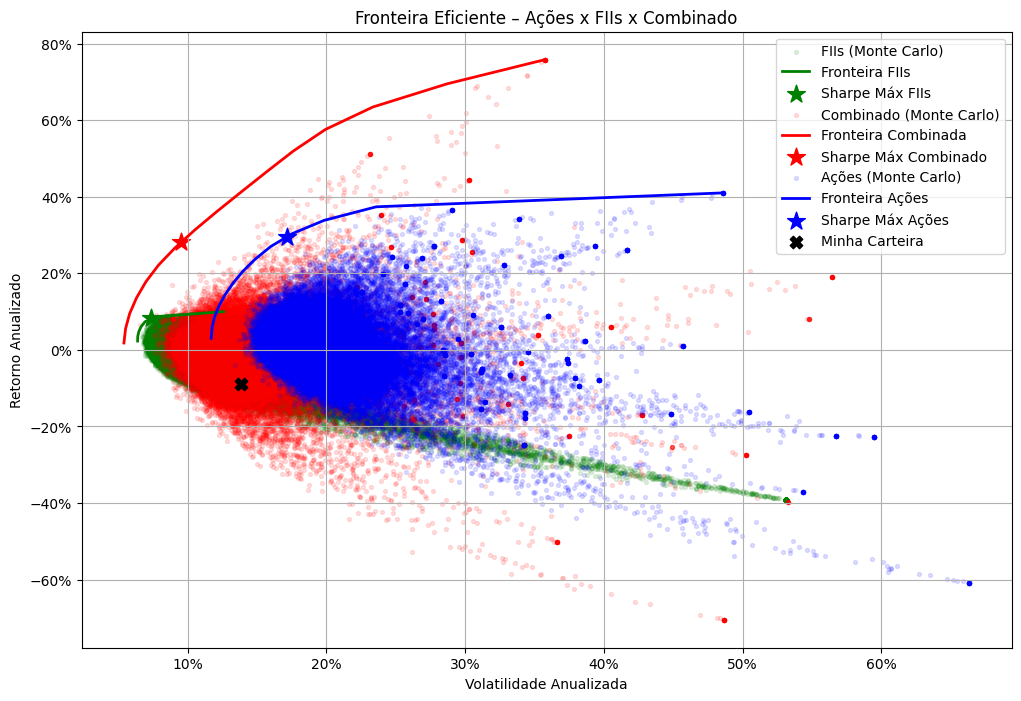

=== Portfolio de Máx. Sharpe ===
KNIP11.SA: 26.13%
PSSA3.SA: 18.44%
GARE11.SA: 15.39%
JBSS3.SA: 12.15%
SBSP3.SA: 8.39%
BTLG11.SA: 5.76%
WEGE3.SA: 5.33%
BMOB3.SA: 4.84%
CMIG4.SA: 2.32%
BLMG11.SA: 1.25%
Sharpe Máximo: 2.6002 | Ret: 28.16% | Vol: 9.54%

Composição por classe no Máx. Sharpe:
Ações: 51.46% | FIIs: 48.54%


In [ ]:
# projeto novo

import os
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Função auxiliar para ler os preços de fechamento a partir de CSV
def _read_close_prices(path_csv: str) -> pd.DataFrame:
    """Lê CSV de preços. Tenta MultiIndex, se não, usa header simples."""
    try:
        df = pd.read_csv(path_csv, header=[0,1], index_col=0,
                         parse_dates=True)
        if 'Close' in df.columns.get_level_values(1):
            return df.xs('Close', axis=1, level=1).copy()
    except Exception as e:
        pass

    df2 = pd.read_csv(path_csv, index_col=0,
                      parse_dates=True)
    close_cols = [c for c in df2.columns if 'Close' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna 'Close' em {path_csv}")
    return df2[close_cols].copy()

# Função que simula portfolios via Monte Carlo e retorna (retornos simulados, volatilidades) válidos
def simulate_portfolios(prices: pd.DataFrame, tickers: list, n_sim: int,
                        min_assets: int, max_assets: int, min_w: float,
                        max_w: float, seed: int, alpha_dirichlet: float = 0.3):
    """
    Simula carteiras via Monte Carlo utilizando distribuição Dirichlet
    para gerar os pesos, calcula retorno e risco, e filtra carteiras
    que atendem a:
        - cardinalidade entre min_assets e max_assets (via min_w)
        - peso máximo <= max_w

    Parâmetro alpha_dirichlet controla a concentração: quanto menor,
    maior a chance de carteiras mais concentradas (sugestão: 0.1 a 0.5).
    """
    # Cálculo dos log-retornos e anualização
    rets = np.log(prices / prices.shift(1)).dropna()
    mu   = rets.mean() * 252
    cov  = rets.cov()  * 252

    # Geração dos pesos com Dirichlet esparsa
    rng = np.random.default_rng(seed)
    sim_w = rng.dirichlet(alpha_dirichlet * np.ones(len(tickers)), size=n_sim)

    # Cálculo das métricas
    sim_ret = sim_w.dot(mu.values)
    sim_vol = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))

    # Filtros
    card   = (sim_w >= min_w).sum(axis=1)
    maxpos = sim_w.max(axis=1)
    mask = (card >= min_assets) & (card <= max_assets) & (maxpos <= max_w)
    valid_idx = np.where(mask)[0]

    return sim_ret[valid_idx], sim_vol[valid_idx]

def filtrar_tickers(prices: pd.DataFrame, tickers: list, min_obs: int = 200):
    """
    Retorna duas listas: tickers válidos (com pelo menos min_obs observações válidas)
    e tickers problemáticos (que não atendem a esse critério).
    """
    tickers_validos = []
    tickers_problema = []
    for t in tickers:
        if t in prices.columns:
            n_obs = prices[t].dropna().shape[0]
            if n_obs >= min_obs:
                tickers_validos.append(t)
            else:
                print(f"[INFO] {t} possui apenas {n_obs} observações; removendo da simulação.")
                tickers_problema.append(t)
        else:
            print(f"[INFO] {t} não encontrado no DataFrame.")
            tickers_problema.append(t)
    return tickers_validos, tickers_problema

def optimize_markowitz_iter(
    price_csv:   str,
    tickers:     list,
    start_date:  pd.Timestamp,
    end_date:    pd.Timestamp,
    n_sim:       int   = 100_000,
    min_assets:  int   = 8,
    max_assets:  int   = 15,
    min_w:       float = 0.05,
    max_w:       float = 0.30,
    seed:        int   = 42
):
    """
    Itera Monte Carlo de Markowitz até que TODOS os pesos ≥ min_w.
    Elimina ativos abaixo de min_w a cada iteração.
    """
    prices = _read_close_prices(price_csv).loc[start_date:end_date]
    tickers_current = tickers.copy()
    iteration = 0

    while True:
        iteration += 1
        print(f"\n[ITERAÇÃO {iteration}] Universo atual: {len(tickers_current)} ativos")

        # Calcula retornos e covariância
        rets = np.log(prices[tickers_current] / prices[tickers_current].shift(1)).dropna()
        mu = rets.mean() * 252
        cov = rets.cov() * 252

        # Simula pesos com Dirichlet
        rng = np.random.default_rng(seed)
        sim_w = rng.dirichlet(np.ones(len(tickers_current)), size=n_sim)

        # Calcula métricas
        sim_ret = sim_w.dot(mu.values)
        sim_vol = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))
        sim_sharp = sim_ret / sim_vol

        # Filtros de cardinalidade e peso máximo
        card = (sim_w >= min_w).sum(axis=1)
        maxpos = sim_w.max(axis=1)
        mask = (card >= min_assets) & (card <= max_assets) & (maxpos <= max_w)
        valid = np.where(mask)[0]

        if valid.size == 0:
            raise RuntimeError(
                f"Nenhuma carteira satisfaz: ativos∈[{min_assets},{max_assets}] "
                f"com peso≥{min_w*100:.1f}% e peso≤{max_w*100:.1f}%"
            )

        best = valid[np.argmax(sim_sharp[valid])]
        w_best = sim_w[best]
        ret_best = sim_ret[best]
        vol_best = sim_vol[best]
        sharp_best = sim_sharp[best]

        # Verifica se todos os pesos são ≥ min_w
        below = [t for t, wi in zip(tickers_current, w_best) if wi < min_w]
        if not below:
            w_best = w_best / w_best.sum()
            portfolio = pd.Series(w_best, index=tickers_current).sort_values(ascending=False)

            print(f"[OK] Convergiu em {len(portfolio)} ativos, todos ≥{min_w*100:.1f}%")
            print("=== Carteira Final ===")
            for tk, peso in portfolio.items():
                print(f"  {tk}: {peso:.1%}")
            print(f"Sharpe final: {sharp_best:.4f}, Retorno anual: {ret_best:.2%}, Vol anual: {vol_best:.2%}")

            return portfolio, ret_best, vol_best, sharp_best

        print(f"[DROP] {len(below)} ativos abaixo de {min_w*100:.1f}%: {below}")
        tickers_current = [t for t in tickers_current if t not in below]

        if len(tickers_current) < min_assets:
            raise RuntimeError(
                "Após dropar ativos abaixo do min_w, universo ficou abaixo de min_assets"
            )

def optimize_max_sharpe(mu, cov, bounds=None):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = bounds or [(0, 1)] * n

    def negative_sharpe(w):
        ret = np.dot(mu, w)
        vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -ret / vol

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    res = minimize(negative_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, -res.fun

def portfolio_return(w, mu):
    return np.dot(mu, w)

def portfolio_volatility(w, cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w)))

def minimize_volatility_for_target(mu, cov, target, bounds=None):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = bounds or [(0, 1)] * n
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, mu) - target}
    )
    res = minimize(portfolio_volatility, init, args=(cov,), method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, portfolio_volatility(res.x, cov)

def compute_efficient_frontier(mu, cov, n_points=50):
    targets = np.linspace(min(mu), max(mu), n_points)
    vols, rets = [], []
    for t in targets:
        try:
            w, vol = minimize_volatility_for_target(mu, cov, t)
            vols.append(vol)
            rets.append(t)
        except:
            continue
    return np.array(vols), np.array(rets)

def simulate_portfolios_cardinalidade_controlada(
    prices: pd.DataFrame,
    tickers: list,
    n_sim: int,
    min_assets: int,
    max_assets: int,
    min_w: float,
    max_w: float,
    seed: int,
    alpha_dirichlet: float = 0.3
):
    rets = np.log(prices / prices.shift(1)).dropna()
    mu = rets.mean() * 252
    cov = rets.cov() * 252

    rng = np.random.default_rng(seed)
    n_assets = len(tickers)

    # Ajusta max_assets se for maior que o número de ativos disponíveis
    max_assets = min(max_assets, n_assets)
    min_assets = min(min_assets, max_assets)

    sim_ret = []
    sim_vol = []
    sim_w = []
    ativos_usados = []

    for _ in range(n_sim):
        k = rng.integers(min_assets, max_assets + 1)
        ativos_escolhidos = rng.choice(n_assets, size=k, replace=False)

        pesos = np.zeros(n_assets)
        pesos_ativos = rng.dirichlet(alpha_dirichlet * np.ones(k))
        pesos[ativos_escolhidos] = pesos_ativos

        if pesos.max() > max_w or (pesos >= min_w).sum() < min_assets:
            continue

        ret = np.dot(mu.values, pesos)
        vol = np.sqrt(np.dot(pesos.T, np.dot(cov.values, pesos)))

        sim_ret.append(ret)
        sim_vol.append(vol)
        sim_w.append(pesos)
        ativos_usados.append(ativos_escolhidos)

    return (
        np.array(sim_ret),
        np.array(sim_vol),
        np.array(sim_w),
        ativos_usados
)

def filtrar_fronteira_eficiente(vols, rets):
    """
    Remove pontos ineficientes da fronteira: mantém apenas os com retorno máximo
    para cada nível crescente de volatilidade.
    """
    idx_sort = np.argsort(vols)
    vols_sorted = vols[idx_sort]
    rets_sorted = rets[idx_sort]

    efficient_vols = []
    efficient_rets = []
    current_max = -np.inf

    for v, r in zip(vols_sorted, rets_sorted):
        if r > current_max:
            efficient_vols.append(v)
            efficient_rets.append(r)
            current_max = r

    return np.array(efficient_vols), np.array(efficient_rets)



# Dados – listas de ativos (já com ".SA" e ordenados conforme você criou anteriormente)
acoes = [
    'ABEV3.SA', 'AGRO3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBSE3.SA', 'BMOB3.SA', 
    'BPAC11.SA', 'BRAV3.SA', 'BRBI11.SA', 'BRSR6.SA', 'CBAV3.SA', 'CGRA4.SA', 
    'CMIG4.SA', 'CPFE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CSMG3.SA', 'CSUD3.SA', 
    'CXSE3.SA', 'EGIE3.SA', 'ELET3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EQTL3.SA', 'FLRY3.SA', 
    'GGBR4.SA', 'GRND3.SA', 'IRBR3.SA', 'ISAE4.SA', 'ITUB4.SA', 'JBSS3.SA',
    'JHSF3.SA', 'KEPL3.SA', 'KLBN11.SA', 'NEOE3.SA', 'ODPV3.SA',
    'PETR4.SA', 'PNVL3.SA', 'POMO4.SA', 'PSSA3.SA', 'PRIO3.SA', 'RANI3.SA',
    'RECV3.SA', 'RENT3.SA', 'RNEW4.SA', 'SANB11.SA', 'SAPR4.SA', 'SBSP3.SA',
    'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'VALE3.SA', 'VIVR3.SA', 'VULC3.SA',
    'WEGE3.SA', 'WIZC3.SA'
]

fii = [
    'BLMG11.SA', 'BRCO11.SA', 'KNIP11.SA', 'LVBI11.SA',
    'MXRF11.SA', 'BRCR11.SA', 'BTLG11.SA', 'CNES11.SA', 'CPSH11.SA',
    'GARE11.SA', 'HGLG11.SA', 'HGRU11.SA', 'HSML11.SA', 'PATL11.SA', 'RBRP11.SA', 'RBRR11.SA', 'XPML11.SA'
]

# Caminhos dos arquivos (supondo que você possua CSVs separados para ações e FIIs)
folder = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\dados_acoes"
price_csv = os.path.join(folder, "all_precos.csv")

# Período de análise
anos = 5
time_end = pd.Timestamp.now().normalize()
time_start = time_end - pd.DateOffset(years=anos)

# Parâmetros para a simulação de Monte Carlo (ajuste conforme necessário)
n_sim = 1_00_000
min_assets = 1
max_assets = 100
min_w = 0.00
max_w = 1.00
seed = 42
alpha_dirichlet = 1

# Ler dados de preços para ações e FIIs
prices_read = _read_close_prices(price_csv).loc[time_start:time_end]

# Filtra os tickers com base em um mínimo desejado de observações (por exemplo, 200)
acoes_validos, acoes_problema = filtrar_tickers(prices_read, acoes, min_obs=200)
fii_validos, fii_problema     = filtrar_tickers(prices_read, fii, min_obs=200)

print("[LOG] Ações válidas:", acoes_validos)
print("[LOG] Ações problemáticas:", acoes_problema)
print("[LOG] FIIs válidos:", fii_validos)
print("[LOG] FIIs problemáticos:", fii_problema)

# Cria os DataFrames filtrados para as simulações
prices_aco  = prices_read[acoes_validos]
prices_fii  = prices_read[fii_validos]
prices_comb = prices_read[acoes_validos + fii_validos]

# Prepara dados
rets_aco = np.log(prices_aco / prices_aco.shift(1)).dropna()
mu_aco = rets_aco.mean() * 252
cov_aco = rets_aco.cov() * 252

rets_fii = np.log(prices_fii / prices_fii.shift(1)).dropna()
mu_fii = rets_fii.mean() * 252
cov_fii = rets_fii.cov() * 252

rets_comb = np.log(prices_comb / prices_comb.shift(1)).dropna()
mu_comb = rets_comb.mean() * 252
cov_comb = rets_comb.cov() * 252


# Reinsere simulações diretas Monte Carlo
# Simulação para ações
sim_ret_aco, sim_vol_aco, sim_pesos_aco, ativos_aco = simulate_portfolios_cardinalidade_controlada(
    prices_aco,
    acoes_validos,
    n_sim,
    min_assets,
    max_assets,
    min_w,
    max_w,
    seed,
    alpha_dirichlet
)

# Simulação para FIIs
sim_ret_fii, sim_vol_fii, sim_pesos_fii, ativos_fii = simulate_portfolios_cardinalidade_controlada(
    prices_fii,
    fii_validos,
    n_sim,
    min_assets,
    max_assets,
    min_w,
    max_w,
    seed,
    alpha_dirichlet
)

# Simulação para ações + FIIs
sim_ret_comb, sim_vol_comb, sim_pesos_comb, ativos_comb = simulate_portfolios_cardinalidade_controlada(
    prices_comb,
    acoes_validos + fii_validos,
    n_sim,
    min_assets,
    max_assets,
    min_w,
    max_w,
    seed,
    alpha_dirichlet
)





# Fronteiras eficientes via SLSQP
ef_vol_aco_opt, ef_ret_aco_opt = compute_efficient_frontier(mu_aco.values, cov_aco.values)
ef_vol_aco_opt, ef_ret_aco_opt = filtrar_fronteira_eficiente(ef_vol_aco_opt, ef_ret_aco_opt)

ef_vol_fii_opt, ef_ret_fii_opt = compute_efficient_frontier(mu_fii.values, cov_fii.values)
ef_vol_fii_opt, ef_ret_fii_opt = filtrar_fronteira_eficiente(ef_vol_fii_opt, ef_ret_fii_opt)

ef_vol_comb_opt, ef_ret_comb_opt = compute_efficient_frontier(mu_comb.values, cov_comb.values)
ef_vol_comb_opt, ef_ret_comb_opt = filtrar_fronteira_eficiente(ef_vol_comb_opt, ef_ret_comb_opt)


# Sharpe máximo em cada universo
w_sharpe_aco, sharpe_aco = optimize_max_sharpe(mu_aco.values, cov_aco.values)
w_sharpe_fii, sharpe_fii = optimize_max_sharpe(mu_fii.values, cov_fii.values)
w_sharpe_comb, sharpe_comb = optimize_max_sharpe(mu_comb.values, cov_comb.values)

ret_aco = portfolio_return(w_sharpe_aco, mu_aco.values)
vol_aco = portfolio_volatility(w_sharpe_aco, cov_aco.values)

ret_fii = portfolio_return(w_sharpe_fii, mu_fii.values)
vol_fii = portfolio_volatility(w_sharpe_fii, cov_fii.values)

ret_comb = portfolio_return(w_sharpe_comb, mu_comb.values)
vol_comb = portfolio_volatility(w_sharpe_comb, cov_comb.values)



# =============================================================================
# Cálculo da fronteira eficiente via otimização SLSQP + Portfolio de Sharpe Máx
# =============================================================================


tickers_comb = acoes_validos + fii_validos
bounds_comb = [(0, 1)] * len(tickers_comb)

# Otimiza Sharpe Máx
w_sharpe, sharpe_max = optimize_max_sharpe(mu_comb.values, cov_comb.values, bounds=bounds_comb)
ret_sharpe = portfolio_return(w_sharpe, mu_comb.values)
vol_sharpe = portfolio_volatility(w_sharpe, cov_comb.values)

# Fronteira eficiente (otimização real)
ef_vol_slsqp, ef_ret_slsqp = compute_efficient_frontier(mu_comb.values, cov_comb.values)



# Converter log-retornos anualizados para retornos aritméticos
sim_ret_aco = np.exp(sim_ret_aco) - 1
sim_ret_fii = np.exp(sim_ret_fii) - 1
sim_ret_comb = np.exp(sim_ret_comb) - 1

ef_ret_aco_opt = np.exp(ef_ret_aco_opt) - 1
ef_ret_fii_opt = np.exp(ef_ret_fii_opt) - 1
ef_ret_comb_opt = np.exp(ef_ret_comb_opt) - 1

ret_aco = np.exp(ret_aco) - 1
ret_fii = np.exp(ret_fii) - 1
ret_comb = np.exp(ret_comb) - 1
ret_sharpe = np.exp(ret_sharpe) - 1

# =============================================================================
# 14) COMPARAÇÃO DO PORTFOLIO DO CLIENTE
# Defina aqui seu portfólio manual
manual_portfolio = {
    'BBAS3.SA': 0.30,
    'PETR4.SA': 0.15,
    'VALE3.SA': 0.15,
    'TAEE11.SA': 0.05,
    'HGLG11.SA': 0.10,
    'KNIP11.SA': 0.15,
    'GARE11.SA': 0.10
    # adicione outros se precisar
}

# Extraia a lista de tickers solicitados pelo cliente
client_tickers = list(manual_portfolio.keys())

# Separe em “existentes” (já em all_data) e “faltando”
existentes = [t for t in client_tickers if t in prices_comb]
faltando   = [t for t in client_tickers if t not in prices_comb]

# Tente baixar on‑the‑fly os que faltam
if faltando:
    print(f"[WARN] Tickers não encontrados em all_data: {faltando}. Tentando download...")
    for sym in faltando:
        try:
            df = yf.download(
                tickers=sym,
                start=price_start.date(),
                end=price_end.date(),
                auto_adjust=True,
                progress=False
            )
            if not df.empty:
                prices_comb[sym] = df
                existentes.append(sym)
                print(f"[OK] Dados baixados para {sym}")
            else:
                print(f"[ERROR] Sem dados para {sym}")
        except Exception as e:
            print(f"[ERROR] Falha ao baixar {sym}: {e}")

# Remova definitivamente os que não foram encontrados
faltando_final = [t for t in client_tickers if t not in existentes]
if faltando_final:
    print(f"[ERROR] Não foi possível obter dados para: {faltando_final}. Removendo da carteira.")
    for t in faltando_final:
        manual_portfolio.pop(t, None)
    client_tickers = existentes

# Baixe as séries ajustadas apenas para os tickers válidos
df_client_prices = yf.download(
    tickers=client_tickers,
    start=time_start.date(),
    end=time_end.date(),
    auto_adjust=True,
    progress=False
)

# Extraia coluna de fechamento ajustado (ou fecho simples, se não houver)
if isinstance(df_client_prices.columns, pd.MultiIndex):
    prices_initial = df_client_prices["Close"].copy()
else:
    prices_initial = df_client_prices[["Close"]].rename(columns={"Close": client_tickers[0]})

# Alinhe as datas: mantenha apenas aquelas em que todos têm preço
prices_initial = prices_initial.dropna(how="any")
print(f"[LOG] Preços consolidados para carteira manual: {prices_initial.shape}")

# Calcule retornos logarítmicos, média e covariância anualizada
rets_initial = np.log(prices_initial / prices_initial.shift(1)).dropna()
mu_initial  = rets_initial.mean() * 252
cov_initial = rets_initial.cov()  * 252

# Monte o vetor de pesos da carteira manual (normalizado)
w_man = np.array([manual_portfolio[t] for t in client_tickers])
w_man /= w_man.sum()

# Extraia média e covariância apenas para esses ativos
mu_man  = mu_initial.loc[client_tickers].values
cov_man = cov_initial.loc[client_tickers, client_tickers].values

# Calcule retorno e volatilidade da carteira manual
ret_man = w_man.dot(mu_man)
vol_man = np.sqrt(w_man.dot(cov_man).dot(w_man))

print(f"[LOG] Carteira manual → Retorno = {ret_man:.2%}, Volatilidade = {vol_man:.2%}")

# Plotando os resultados
plt.figure(figsize=(12,8))

plt.scatter(sim_vol_fii, sim_ret_fii, s=8, alpha=0.12, color='green', label='FIIs (Monte Carlo)')
plt.plot(ef_vol_fii_opt, ef_ret_fii_opt, 'g-', lw=2, label='Fronteira FIIs')
plt.scatter(vol_fii, ret_fii, color='green', marker='*', s=180, label='Sharpe Máx FIIs')

plt.scatter(sim_vol_comb, sim_ret_comb, s=8, alpha=0.12, color='red', label='Combinado (Monte Carlo)')
plt.plot(ef_vol_comb_opt, ef_ret_comb_opt, 'r-', lw=2, label='Fronteira Combinada')
plt.scatter(vol_comb, ret_comb, color='red', marker='*', s=180, label='Sharpe Máx Combinado')

plt.scatter(sim_vol_aco, sim_ret_aco, s=8, alpha=0.12, color='blue', label='Ações (Monte Carlo)')
plt.plot(ef_vol_aco_opt, ef_ret_aco_opt, 'b-', lw=2, label='Fronteira Ações')
plt.scatter(vol_aco, ret_aco, color='blue', marker='*', s=180, label='Sharpe Máx Ações')

plt.scatter(vol_man, ret_man, c="black", s=80, marker="X", label="Minha Carteira")

plt.xlabel("Volatilidade Anualizada")
plt.ylabel("Retorno Anualizado")
plt.title("Fronteira Eficiente – Ações x FIIs x Combinado")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()


# Exibir composição do Sharpe Máximo
print("=== Portfolio de Máx. Sharpe ===")
serie_pesos = pd.Series(w_sharpe, index=tickers_comb)
serie_pesos = serie_pesos[serie_pesos > 0.001].sort_values(ascending=False)
for ativo, peso in serie_pesos.items():
    print(f"{ativo}: {peso:.2%}")
print(f"Sharpe Máximo: {sharpe_max:.4f} | Ret: {ret_sharpe:.2%} | Vol: {vol_sharpe:.2%}")

# Percentual de ações e FIIs
idx_acoes = [tickers_comb.index(tk) for tk in acoes_validos if tk in tickers_comb]
idx_fii   = [tickers_comb.index(tk) for tk in fii_validos   if tk in tickers_comb]
pct_acoes = w_sharpe[idx_acoes].sum()
pct_fii   = w_sharpe[idx_fii].sum()
print(f"\nComposição por classe no Máx. Sharpe:")
print(f"Ações: {pct_acoes:.2%} | FIIs: {pct_fii:.2%}")

[LOG] Ações válidas: ['ABEV3.SA', 'AGRO3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBSE3.SA', 'BMOB3.SA', 'BPAC11.SA', 'BRAV3.SA', 'BRBI11.SA', 'BRSR6.SA', 'CBAV3.SA', 'CGRA4.SA', 'CMIG4.SA', 'CPFE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CSMG3.SA', 'CSUD3.SA', 'CXSE3.SA', 'EGIE3.SA', 'ELET3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EQTL3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GRND3.SA', 'IRBR3.SA', 'ISAE4.SA', 'ITUB4.SA', 'JBSS3.SA', 'JHSF3.SA', 'KEPL3.SA', 'KLBN11.SA', 'NEOE3.SA', 'ODPV3.SA', 'PETR4.SA', 'PNVL3.SA', 'POMO4.SA', 'PSSA3.SA', 'PRIO3.SA', 'RANI3.SA', 'RECV3.SA', 'RENT3.SA', 'RNEW4.SA', 'SANB11.SA', 'SAPR4.SA', 'SBSP3.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'VALE3.SA', 'VIVR3.SA', 'VULC3.SA', 'WEGE3.SA', 'WIZC3.SA']
[LOG] Ações problemáticas: []
[LOG] FIIs válidos: ['BLMG11.SA', 'BRCO11.SA', 'KNIP11.SA', 'LVBI11.SA', 'MXRF11.SA', 'BRCR11.SA', 'BTLG11.SA', 'CNES11.SA', 'CPSH11.SA', 'GARE11.SA', 'HGLG11.SA', 'HGRU11.SA', 'HSML11.SA', 'PATL11.SA', 'RBRP11.SA', 'RBRR11.SA', 'XPML11.SA']
[LOG] FIIs problemáticos: []

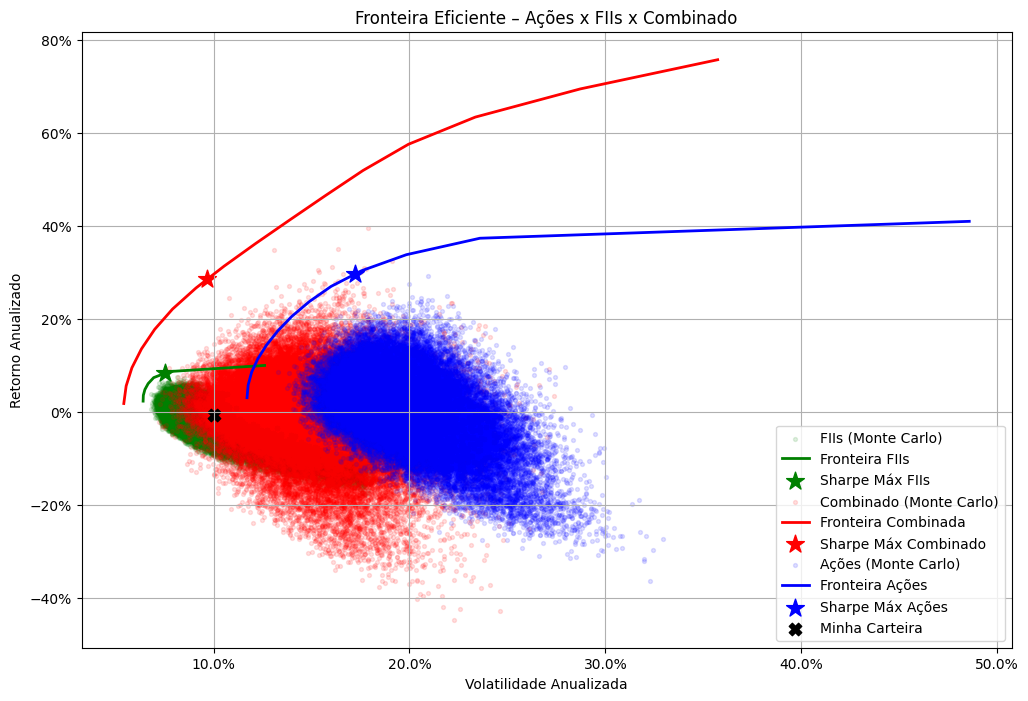


=== Carteira de Sharpe Máximo – AÇÕES ===
SBSP3.SA: 21.39%
PETR4.SA: 18.55%
TIMS3.SA: 18.03%
JBSS3.SA: 12.57%
PSSA3.SA: 10.83%
BBSE3.SA: 6.37%
CPFE3.SA: 5.83%
POMO4.SA: 3.33%
CMIG4.SA: 3.08%
Sharpe: 1.5125 | Ret: 29.69% | Vol: 17.21%

=== Carteira de Sharpe Máximo – FIIs ===
KNIP11.SA: 30.00%
GARE11.SA: 30.00%
BTLG11.SA: 11.82%
BLMG11.SA: 11.46%
RBRR11.SA: 10.10%
HGLG11.SA: 6.62%
Sharpe: 1.0606 | Ret: 8.31% | Vol: 7.52%

=== Carteira de Sharpe Máximo – COMBINADA ===
KNIP11.SA: 27.13%
PSSA3.SA: 19.12%
GARE11.SA: 15.91%
JBSS3.SA: 12.60%
SBSP3.SA: 8.71%
BTLG11.SA: 5.97%
WEGE3.SA: 5.54%
BMOB3.SA: 5.02%
Sharpe: 2.6002 | Ret: 28.50% | Vol: 9.66%

Composição por classe no Máx. Sharpe Combinado:
Ações: 50.98% | FIIs: 49.02%


In [ ]:
# projeto organizado para converter em streamlit

import os
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# =======================
# Funções Auxiliares
# =======================

def _read_close_prices(path_csv: str) -> pd.DataFrame:
    """Lê CSV de preços. Tenta MultiIndex, se não, usa header simples."""
    try:
        df = pd.read_csv(path_csv, header=[0,1], index_col=0, parse_dates=True)
        if 'Close' in df.columns.get_level_values(1):
            return df.xs('Close', axis=1, level=1).copy()
    except Exception as e:
        pass

    df2 = pd.read_csv(path_csv, index_col=0, parse_dates=True)
    close_cols = [c for c in df2.columns if 'Close' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna 'Close' em {path_csv}")
    return df2[close_cols].copy()

def filtrar_tickers(prices: pd.DataFrame, tickers: list, min_obs: int = 200):
    """
    Retorna duas listas: tickers válidos (com pelo menos min_obs observações válidas)
    e tickers problemáticos (que não atendem a esse critério).
    """
    tickers_validos = []
    tickers_problema = []
    for t in tickers:
        if t in prices.columns:
            n_obs = prices[t].dropna().shape[0]
            if n_obs >= min_obs:
                tickers_validos.append(t)
            else:
                print(f"[INFO] {t} possui apenas {n_obs} observações; removendo da simulação.")
                tickers_problema.append(t)
        else:
            print(f"[INFO] {t} não encontrado no DataFrame.")
            tickers_problema.append(t)
    return tickers_validos, tickers_problema

def filtrar_fronteira_eficiente(vols, rets):
    """
    Remove pontos ineficientes da fronteira: mantém apenas os com retorno máximo
    para cada nível crescente de volatilidade.
    """
    idx_sort = np.argsort(vols)
    vols_sorted = vols[idx_sort]
    rets_sorted = rets[idx_sort]

    efficient_vols = []
    efficient_rets = []
    current_max = -np.inf

    for v, r in zip(vols_sorted, rets_sorted):
        if r > current_max:
            efficient_vols.append(v)
            efficient_rets.append(r)
            current_max = r

    return np.array(efficient_vols), np.array(efficient_rets)

# =======================
# Funções de Simulação
# =======================

def simulate_portfolios(prices: pd.DataFrame, tickers: list, n_sim: int,
                        min_assets: int, max_assets: int, min_w: float,
                        max_w: float, seed: int, alpha_dirichlet: float = 0.3):
    """
    Simula carteiras via Monte Carlo utilizando distribuição Dirichlet
    para gerar os pesos, calcula retorno e risco, e filtra carteiras
    que atendem a:
        - cardinalidade entre min_assets e max_assets (via min_w)
        - peso máximo <= max_w

    Parâmetro alpha_dirichlet controla a concentração: quanto menor,
    maior a chance de carteiras mais concentradas (sugestão: 0.1 a 0.5).
    """
    # Cálculo dos log-retornos e anualização
    rets = np.log(prices / prices.shift(1)).dropna()
    mu   = rets.mean() * 252
    cov  = rets.cov()  * 252

    # Geração dos pesos com Dirichlet esparsa
    rng = np.random.default_rng(seed)
    sim_w = rng.dirichlet(alpha_dirichlet * np.ones(len(tickers)), size=n_sim)

    # Cálculo das métricas
    sim_ret = sim_w.dot(mu.values)
    sim_vol = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))

    # Filtros
    card   = (sim_w >= min_w).sum(axis=1)
    maxpos = sim_w.max(axis=1)
    mask = (card >= min_assets) & (card <= max_assets) & (maxpos <= max_w)
    valid_idx = np.where(mask)[0]

    return sim_ret[valid_idx], sim_vol[valid_idx]

def simulate_portfolios_cardinalidade_controlada(
    prices: pd.DataFrame,
    tickers: list,
    n_sim: int,
    min_assets: int,
    max_assets: int,
    min_w: float,
    max_w: float,
    seed: int,
    alpha_dirichlet: float = 0.3
):
    rets = np.log(prices / prices.shift(1)).dropna()
    mu = rets.mean() * 252
    cov = rets.cov() * 252

    rng = np.random.default_rng(seed)
    n_assets = len(tickers)

    # Ajusta max_assets se for maior que o número de ativos disponíveis
    max_assets = min(max_assets, n_assets)
    min_assets = min(min_assets, max_assets)

    sim_ret = []
    sim_vol = []
    sim_w = []
    ativos_usados = []

    for _ in range(n_sim):
        k = rng.integers(min_assets, max_assets + 1)
        ativos_escolhidos = rng.choice(n_assets, size=k, replace=False)

        pesos = np.zeros(n_assets)
        pesos_ativos = rng.dirichlet(alpha_dirichlet * np.ones(k))
        pesos[ativos_escolhidos] = pesos_ativos

        if pesos.max() > max_w or (pesos >= min_w).sum() < min_assets:
            continue

        ret = np.dot(mu.values, pesos)
        vol = np.sqrt(np.dot(pesos.T, np.dot(cov.values, pesos)))

        sim_ret.append(ret)
        sim_vol.append(vol)
        sim_w.append(pesos)
        ativos_usados.append(ativos_escolhidos)

    return (
        np.array(sim_ret),
        np.array(sim_vol),
        np.array(sim_w),
        ativos_usados
    )

# =======================
# Funções de Otimização
# =======================

def optimize_max_sharpe(mu, cov, min_w=0.0, max_w=1.0):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = [(min_w, max_w)] * n

    def negative_sharpe(w):
        ret = np.dot(mu, w)
        vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -ret / vol

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    res = minimize(negative_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, -res.fun

def portfolio_return(w, mu):
    return np.dot(mu, w)

def portfolio_volatility(w, cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w)))

def minimize_volatility_for_target(mu, cov, target, bounds=None):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = bounds or [(0, 1)] * n
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, mu) - target}
    )
    res = minimize(portfolio_volatility, init, args=(cov,), method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, portfolio_volatility(res.x, cov)

def compute_efficient_frontier(mu, cov, n_points=50):
    targets = np.linspace(min(mu), max(mu), n_points)
    vols, rets = [], []
    for t in targets:
        try:
            w, vol = minimize_volatility_for_target(mu, cov, t)
            vols.append(vol)
            rets.append(t)
        except:
            continue
    return np.array(vols), np.array(rets)

def rebalance_weights(weights, min_w=0.03):
    """
    Zera os pesos abaixo de min_w e rebalanceia os restantes para somar 100%.
    """
    weights = np.where(weights < min_w, 0.0, weights)
    total = weights.sum()
    if total > 0:
        weights = weights / total
    return weights

# =======================
# Funções de Plotagem
# =======================

def plot_results(sim_vol_aco, sim_ret_aco, ef_vol_aco_opt, ef_ret_aco_opt, vol_aco, ret_aco,
                 sim_vol_fii, sim_ret_fii, ef_vol_fii_opt, ef_ret_fii_opt, vol_fii, ret_fii,
                 sim_vol_comb, sim_ret_comb, ef_vol_comb_opt, ef_ret_comb_opt, vol_comb, ret_comb,
                 vol_man, ret_man):
    plt.figure(figsize=(12,8))

    plt.scatter(sim_vol_fii, sim_ret_fii, s=8, alpha=0.12, color='green', label='FIIs (Monte Carlo)')
    plt.plot(ef_vol_fii_opt, ef_ret_fii_opt, 'g-', lw=2, label='Fronteira FIIs')
    plt.scatter(vol_fii, ret_fii, color='green', marker='*', s=180, label='Sharpe Máx FIIs')

    plt.scatter(sim_vol_comb, sim_ret_comb, s=8, alpha=0.12, color='red', label='Combinado (Monte Carlo)')
    plt.plot(ef_vol_comb_opt, ef_ret_comb_opt, 'r-', lw=2, label='Fronteira Combinada')
    plt.scatter(vol_comb, ret_comb, color='red', marker='*', s=180, label='Sharpe Máx Combinado')

    plt.scatter(sim_vol_aco, sim_ret_aco, s=8, alpha=0.12, color='blue', label='Ações (Monte Carlo)')
    plt.plot(ef_vol_aco_opt, ef_ret_aco_opt, 'b-', lw=2, label='Fronteira Ações')
    plt.scatter(vol_aco, ret_aco, color='blue', marker='*', s=180, label='Sharpe Máx Ações')

    plt.scatter(vol_man, ret_man, c="black", s=80, marker="X", label="Minha Carteira")

    plt.xlabel("Volatilidade Anualizada")
    plt.ylabel("Retorno Anualizado")
    plt.title("Fronteira Eficiente – Ações x FIIs x Combinado")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()

# =======================
# Bloco Principal
# =======================

if __name__ == "__main__":
    # Dados – listas de ativos (já com ".SA" e ordenados conforme você criou anteriormente)
    acoes = [
        'ABEV3.SA', 'AGRO3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBSE3.SA', 'BMOB3.SA', 
        'BPAC11.SA', 'BRAV3.SA', 'BRBI11.SA', 'BRSR6.SA', 'CBAV3.SA', 'CGRA4.SA', 
        'CMIG4.SA', 'CPFE3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CSMG3.SA', 'CSUD3.SA', 
        'CXSE3.SA', 'EGIE3.SA', 'ELET3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EQTL3.SA', 'FLRY3.SA', 
        'GGBR4.SA', 'GRND3.SA', 'IRBR3.SA', 'ISAE4.SA', 'ITUB4.SA', 'JBSS3.SA',
        'JHSF3.SA', 'KEPL3.SA', 'KLBN11.SA', 'NEOE3.SA', 'ODPV3.SA',
        'PETR4.SA', 'PNVL3.SA', 'POMO4.SA', 'PSSA3.SA', 'PRIO3.SA', 'RANI3.SA',
        'RECV3.SA', 'RENT3.SA', 'RNEW4.SA', 'SANB11.SA', 'SAPR4.SA', 'SBSP3.SA',
        'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'VALE3.SA', 'VIVR3.SA', 'VULC3.SA',
        'WEGE3.SA', 'WIZC3.SA'
    ]

    fii = [
        'BLMG11.SA', 'BRCO11.SA', 'KNIP11.SA', 'LVBI11.SA',
        'MXRF11.SA', 'BRCR11.SA', 'BTLG11.SA', 'CNES11.SA', 'CPSH11.SA',
        'GARE11.SA', 'HGLG11.SA', 'HGRU11.SA', 'HSML11.SA', 'PATL11.SA', 'RBRP11.SA', 'RBRR11.SA', 'XPML11.SA'
    ]

    # Caminhos dos arquivos (supondo que você possua CSVs separados para ações e FIIs)
    folder = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\Git"
    price_csv = os.path.join(folder, "all_precos.csv")

    # Período de análise
    anos = 5
    time_end = pd.Timestamp.now().normalize()
    time_start = time_end - pd.DateOffset(years=anos)

    # Parâmetros para a simulação de Monte Carlo (ajuste conforme necessário)
    n_sim = 100_000
    min_assets = 6
    max_assets = 15
    min_w = 0.03
    max_w = 0.30
    seed = 42
    alpha_dirichlet = 1

    # Ler dados de preços para ações e FIIs
    prices_read = _read_close_prices(price_csv).loc[time_start:time_end]

    # Filtra os tickers com base em um mínimo desejado de observações (por exemplo, 200)
    acoes_validos, acoes_problema = filtrar_tickers(prices_read, acoes, min_obs=200)
    fii_validos, fii_problema     = filtrar_tickers(prices_read, fii, min_obs=200)

    print("[LOG] Ações válidas:", acoes_validos)
    print("[LOG] Ações problemáticas:", acoes_problema)
    print("[LOG] FIIs válidos:", fii_validos)
    print("[LOG] FIIs problemáticos:", fii_problema)

    # Cria os DataFrames filtrados para as simulações
    prices_aco  = prices_read[acoes_validos]
    prices_fii  = prices_read[fii_validos]
    prices_comb = prices_read[acoes_validos + fii_validos]

    # Prepara dados
    rets_aco = np.log(prices_aco / prices_aco.shift(1)).dropna()
    mu_aco = rets_aco.mean() * 252
    cov_aco = rets_aco.cov() * 252

    rets_fii = np.log(prices_fii / prices_fii.shift(1)).dropna()
    mu_fii = rets_fii.mean() * 252
    cov_fii = rets_fii.cov() * 252

    rets_comb = np.log(prices_comb / prices_comb.shift(1)).dropna()
    mu_comb = rets_comb.mean() * 252
    cov_comb = rets_comb.cov() * 252

    # Simulação para ações
    sim_ret_aco, sim_vol_aco, sim_pesos_aco, ativos_aco = simulate_portfolios_cardinalidade_controlada(
        prices_aco,
        acoes_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Simulação para FIIs
    sim_ret_fii, sim_vol_fii, sim_pesos_fii, ativos_fii = simulate_portfolios_cardinalidade_controlada(
        prices_fii,
        fii_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Simulação para ações + FIIs
    sim_ret_comb, sim_vol_comb, sim_pesos_comb, ativos_comb = simulate_portfolios_cardinalidade_controlada(
        prices_comb,
        acoes_validos + fii_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Fronteiras eficientes via SLSQP
    ef_vol_aco_opt, ef_ret_aco_opt = compute_efficient_frontier(mu_aco.values, cov_aco.values)
    ef_vol_aco_opt, ef_ret_aco_opt = filtrar_fronteira_eficiente(ef_vol_aco_opt, ef_ret_aco_opt)

    ef_vol_fii_opt, ef_ret_fii_opt = compute_efficient_frontier(mu_fii.values, cov_fii.values)
    ef_vol_fii_opt, ef_ret_fii_opt = filtrar_fronteira_eficiente(ef_vol_fii_opt, ef_ret_fii_opt)

    ef_vol_comb_opt, ef_ret_comb_opt = compute_efficient_frontier(mu_comb.values, cov_comb.values)
    ef_vol_comb_opt, ef_ret_comb_opt = filtrar_fronteira_eficiente(ef_vol_comb_opt, ef_ret_comb_opt)

    # Sharpe máximo em cada universo
    
    w_sharpe_aco, sharpe_aco = optimize_max_sharpe(mu_aco.values, cov_aco.values, 0.0, max_w)
    w_sharpe_aco = rebalance_weights(w_sharpe_aco, min_w)

    w_sharpe_fii, sharpe_fii = optimize_max_sharpe(mu_fii.values, cov_fii.values, 0.0, max_w)
    w_sharpe_fii = rebalance_weights(w_sharpe_fii, min_w)

    w_sharpe_comb, sharpe_comb = optimize_max_sharpe(mu_comb.values, cov_comb.values, 0.0, max_w)
    w_sharpe_comb = rebalance_weights(w_sharpe_comb, min_w)

    ret_aco = portfolio_return(w_sharpe_aco, mu_aco.values)
    vol_aco = portfolio_volatility(w_sharpe_aco, cov_aco.values)

    ret_fii = portfolio_return(w_sharpe_fii, mu_fii.values)
    vol_fii = portfolio_volatility(w_sharpe_fii, cov_fii.values)

    ret_comb = portfolio_return(w_sharpe_comb, mu_comb.values)
    vol_comb = portfolio_volatility(w_sharpe_comb, cov_comb.values)

    # Converter log-retornos anualizados para retornos aritméticos
    sim_ret_aco = np.exp(sim_ret_aco) - 1
    sim_ret_fii = np.exp(sim_ret_fii) - 1
    sim_ret_comb = np.exp(sim_ret_comb) - 1

    ef_ret_aco_opt = np.exp(ef_ret_aco_opt) - 1
    ef_ret_fii_opt = np.exp(ef_ret_fii_opt) - 1
    ef_ret_comb_opt = np.exp(ef_ret_comb_opt) - 1

    ret_aco = np.exp(ret_aco) - 1
    ret_fii = np.exp(ret_fii) - 1
    ret_comb = np.exp(ret_comb) - 1

    # Carteira manual
    manual_portfolio = {
        'BBAS3.SA': 0.30,
        'PETR4.SA': 0.15,
        'VALE3.SA': 0.15,
        'TAEE11.SA': 0.05,
        'HGLG11.SA': 0.10,
        'KNIP11.SA': 0.15,
        'GARE11.SA': 0.10
    }

    client_tickers = list(manual_portfolio.keys())
    w_man = np.array([manual_portfolio[t] for t in client_tickers])
    w_man /= w_man.sum()

    prices_manual = prices_comb[client_tickers].dropna()
    rets_manual = np.log(prices_manual / prices_manual.shift(1)).dropna()
    mu_manual = rets_manual.mean() * 252
    cov_manual = rets_manual.cov() * 252

    mu_vec = mu_manual.loc[client_tickers].values
    cov_mat = cov_manual.loc[client_tickers, client_tickers].values

    ret_man = np.dot(w_man, mu_vec)
    vol_man = np.sqrt(np.dot(w_man.T, np.dot(cov_mat, w_man)))

    ret_man = np.exp(ret_man) - 1

    # Plotagem
    plot_results(
        sim_vol_aco, sim_ret_aco, ef_vol_aco_opt, ef_ret_aco_opt, vol_aco, ret_aco,
        sim_vol_fii, sim_ret_fii, ef_vol_fii_opt, ef_ret_fii_opt, vol_fii, ret_fii,
        sim_vol_comb, sim_ret_comb, ef_vol_comb_opt, ef_ret_comb_opt, vol_comb, ret_comb,
        vol_man, ret_man
    )

    # ========================
    # Exibir carteiras de Sharpe máximo
    # ========================

    print("\n=== Carteira de Sharpe Máximo – AÇÕES ===")
    serie_aco = pd.Series(w_sharpe_aco, index=acoes_validos)
    serie_aco = serie_aco[serie_aco > 0.001].sort_values(ascending=False)
    for ativo, peso in serie_aco.items():
        print(f"{ativo}: {peso:.2%}")
    print(f"Sharpe: {sharpe_aco:.4f} | Ret: {ret_aco:.2%} | Vol: {vol_aco:.2%}")

    print("\n=== Carteira de Sharpe Máximo – FIIs ===")
    serie_fii = pd.Series(w_sharpe_fii, index=fii_validos)
    serie_fii = serie_fii[serie_fii > 0.001].sort_values(ascending=False)
    for ativo, peso in serie_fii.items():
        print(f"{ativo}: {peso:.2%}")
    print(f"Sharpe: {sharpe_fii:.4f} | Ret: {ret_fii:.2%} | Vol: {vol_fii:.2%}")

    print("\n=== Carteira de Sharpe Máximo – COMBINADA ===")
    tickers_comb = acoes_validos + fii_validos
    serie_comb = pd.Series(w_sharpe_comb, index=tickers_comb)
    serie_comb = serie_comb[serie_comb > 0.001].sort_values(ascending=False)
    for ativo, peso in serie_comb.items():
        print(f"{ativo}: {peso:.2%}")
    print(f"Sharpe: {sharpe_comb:.4f} | Ret: {ret_comb:.2%} | Vol: {vol_comb:.2%}")

    # Composição por classe no portfólio combinado
    idx_acoes = [i for i, tk in enumerate(tickers_comb) if tk in acoes_validos]
    idx_fii = [i for i, tk in enumerate(tickers_comb) if tk in fii_validos]
    pct_acoes = w_sharpe_comb[idx_acoes].sum()
    pct_fii = w_sharpe_comb[idx_fii].sum()
    print(f"\nComposição por classe no Máx. Sharpe Combinado:")
    print(f"Ações: {pct_acoes:.2%} | FIIs: {pct_fii:.2%}")

2025-06-22 21:04:25.705 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:25.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:30.954 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:30.956 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:30.959 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:30.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:30.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 21:04:31.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

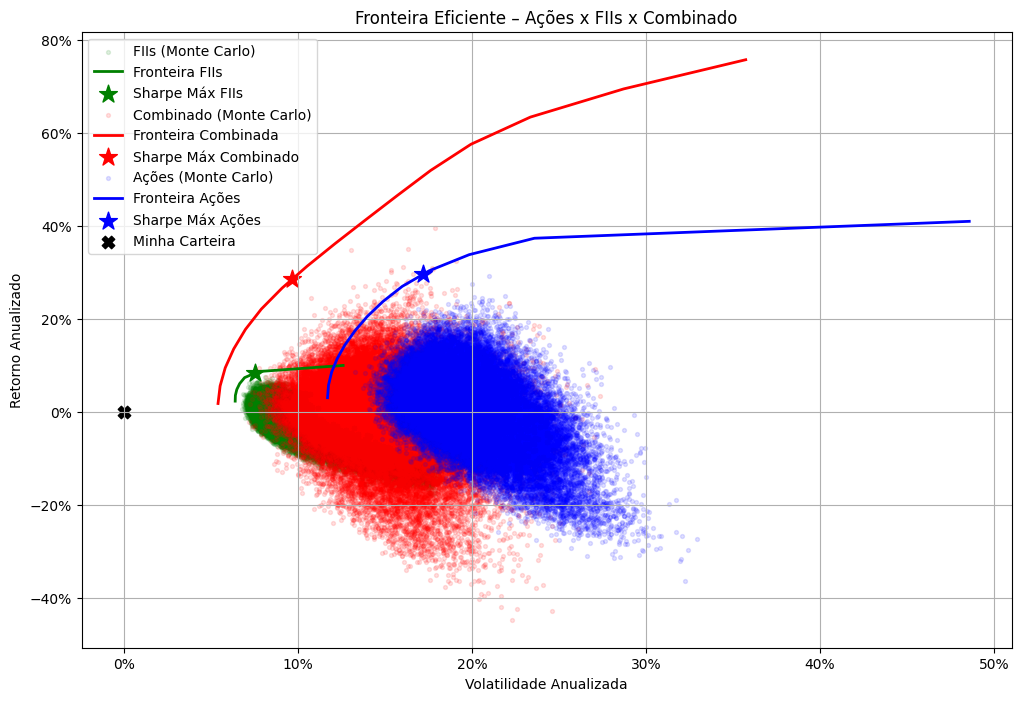

In [5]:
# homologação streamlit

import os
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import streamlit as st

# =======================
# Funções Auxiliares
# =======================

def _read_close_prices(path_csv: str) -> pd.DataFrame:
    """Lê CSV de preços. Tenta MultiIndex, se não, usa header simples."""
    try:
        df = pd.read_csv(path_csv, header=[0,1], index_col=0, parse_dates=True)
        if 'Close' in df.columns.get_level_values(1):
            return df.xs('Close', axis=1, level=1).copy()
    except Exception as e:
        pass

    df2 = pd.read_csv(path_csv, index_col=0, parse_dates=True)
    close_cols = [c for c in df2.columns if 'Close' in c]
    if not close_cols:
        raise RuntimeError(f"Nenhuma coluna 'Close' em {path_csv}")
    return df2[close_cols].copy()

def filtrar_tickers(prices: pd.DataFrame, tickers: list, min_obs: int = 200):
    """
    Retorna duas listas: tickers válidos (com pelo menos min_obs observações válidas)
    e tickers problemáticos (que não atendem a esse critério).
    """
    tickers_validos = []
    tickers_problema = []
    for t in tickers:
        if t in prices.columns:
            n_obs = prices[t].dropna().shape[0]
            if n_obs >= min_obs:
                tickers_validos.append(t)
            else:
                st.write(f"[INFO] {t} possui apenas {n_obs} observações; removendo da simulação.")
                tickers_problema.append(t)
        else:
            st.write(f"[INFO] {t} não encontrado no DataFrame.")
            tickers_problema.append(t)
    return tickers_validos, tickers_problema

def filtrar_fronteira_eficiente(vols, rets):
    """
    Remove pontos ineficientes da fronteira: mantém apenas os com retorno máximo
    para cada nível crescente de volatilidade.
    """
    idx_sort = np.argsort(vols)
    vols_sorted = vols[idx_sort]
    rets_sorted = rets[idx_sort]

    efficient_vols = []
    efficient_rets = []
    current_max = -np.inf

    for v, r in zip(vols_sorted, rets_sorted):
        if r > current_max:
            efficient_vols.append(v)
            efficient_rets.append(r)
            current_max = r

    return np.array(efficient_vols), np.array(efficient_rets)

# =======================
# Funções de Simulação
# =======================

def simulate_portfolios(prices: pd.DataFrame, tickers: list, n_sim: int,
                        min_assets: int, max_assets: int, min_w: float,
                        max_w: float, seed: int, alpha_dirichlet: float = 0.3):
    """
    Simula carteiras via Monte Carlo utilizando distribuição Dirichlet
    para gerar os pesos, calcula retorno e risco, e filtra carteiras
    que atendem a:
        - cardinalidade entre min_assets e max_assets (via min_w)
        - peso máximo <= max_w

    Parâmetro alpha_dirichlet controla a concentração: quanto menor,
    maior a chance de carteiras mais concentradas (sugestão: 0.1 a 0.5).
    """
    # Cálculo dos log-retornos e anualização
    rets = np.log(prices / prices.shift(1)).dropna()
    mu   = rets.mean() * 252
    cov  = rets.cov()  * 252

    # Geração dos pesos com Dirichlet esparsa
    rng = np.random.default_rng(seed)
    sim_w = rng.dirichlet(alpha_dirichlet * np.ones(len(tickers)), size=n_sim)

    # Cálculo das métricas
    sim_ret = sim_w.dot(mu.values)
    sim_vol = np.sqrt(np.einsum('ij,jk,ik->i', sim_w, cov.values, sim_w))

    # Filtros
    card   = (sim_w >= min_w).sum(axis=1)
    maxpos = sim_w.max(axis=1)
    mask = (card >= min_assets) & (card <= max_assets) & (maxpos <= max_w)
    valid_idx = np.where(mask)[0]

    return sim_ret[valid_idx], sim_vol[valid_idx]

def simulate_portfolios_cardinalidade_controlada(
    prices: pd.DataFrame,
    tickers: list,
    n_sim: int,
    min_assets: int,
    max_assets: int,
    min_w: float,
    max_w: float,
    seed: int,
    alpha_dirichlet: float = 0.3
):
    rets = np.log(prices / prices.shift(1)).dropna()
    mu = rets.mean() * 252
    cov = rets.cov() * 252

    rng = np.random.default_rng(seed)
    n_assets = len(tickers)

    # Ajusta max_assets se for maior que o número de ativos disponíveis
    max_assets = min(max_assets, n_assets)
    min_assets = min(min_assets, max_assets)

    sim_ret = []
    sim_vol = []
    sim_w = []
    ativos_usados = []

    for _ in range(n_sim):
        k = rng.integers(min_assets, max_assets + 1)
        ativos_escolhidos = rng.choice(n_assets, size=k, replace=False)

        pesos = np.zeros(n_assets)
        pesos_ativos = rng.dirichlet(alpha_dirichlet * np.ones(k))
        pesos[ativos_escolhidos] = pesos_ativos

        if pesos.max() > max_w or (pesos >= min_w).sum() < min_assets:
            continue

        ret = np.dot(mu.values, pesos)
        vol = np.sqrt(np.dot(pesos.T, np.dot(cov.values, pesos)))

        sim_ret.append(ret)
        sim_vol.append(vol)
        sim_w.append(pesos)
        ativos_usados.append(ativos_escolhidos)

    return (
        np.array(sim_ret),
        np.array(sim_vol),
        np.array(sim_w),
        ativos_usados
    )

# =======================
# Funções de Otimização
# =======================

def optimize_max_sharpe(mu, cov, min_w=0.0, max_w=1.0):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = [(min_w, max_w)] * n

    def negative_sharpe(w):
        ret = np.dot(mu, w)
        vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -ret / vol

    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    res = minimize(negative_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, -res.fun

def portfolio_return(w, mu):
    return np.dot(mu, w)

def portfolio_volatility(w, cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w)))

def minimize_volatility_for_target(mu, cov, target, bounds=None):
    n = len(mu)
    init = np.repeat(1/n, n)
    bounds = bounds or [(0, 1)] * n
    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, mu) - target}
    )
    res = minimize(portfolio_volatility, init, args=(cov,), method='SLSQP', bounds=bounds, constraints=cons)
    return res.x, portfolio_volatility(res.x, cov)

def compute_efficient_frontier(mu, cov, n_points=50):
    targets = np.linspace(min(mu), max(mu), n_points)
    vols, rets = [], []
    for t in targets:
        try:
            w, vol = minimize_volatility_for_target(mu, cov, t)
            vols.append(vol)
            rets.append(t)
        except:
            continue
    return np.array(vols), np.array(rets)

def rebalance_weights(weights, min_w=0.03):
    """
    Zera os pesos abaixo de min_w e rebalanceia os restantes para somar 100%.
    """
    weights = np.where(weights < min_w, 0.0, weights)
    total = weights.sum()
    if total > 0:
        weights = weights / total
    return weights

def normalizar_tickers(lista):
    return [ticker.strip().upper() + ".SA" if not ticker.strip().upper().endswith(".SA") else ticker.strip().upper() for ticker in lista]


# =======================
# Funções de Plotagem
# =======================

def plot_results(sim_vol_aco, sim_ret_aco, ef_vol_aco_opt, ef_ret_aco_opt, vol_aco, ret_aco,
                 sim_vol_fii, sim_ret_fii, ef_vol_fii_opt, ef_ret_fii_opt, vol_fii, ret_fii,
                 sim_vol_comb, sim_ret_comb, ef_vol_comb_opt, ef_ret_comb_opt, vol_comb, ret_comb,
                 vol_man, ret_man):
    plt.figure(figsize=(12,8))

    plt.scatter(sim_vol_fii, sim_ret_fii, s=8, alpha=0.12, color='green', label='FIIs (Monte Carlo)')
    plt.plot(ef_vol_fii_opt, ef_ret_fii_opt, 'g-', lw=2, label='Fronteira FIIs')
    plt.scatter(vol_fii, ret_fii, color='green', marker='*', s=180, label='Sharpe Máx FIIs')

    plt.scatter(sim_vol_comb, sim_ret_comb, s=8, alpha=0.12, color='red', label='Combinado (Monte Carlo)')
    plt.plot(ef_vol_comb_opt, ef_ret_comb_opt, 'r-', lw=2, label='Fronteira Combinada')
    plt.scatter(vol_comb, ret_comb, color='red', marker='*', s=180, label='Sharpe Máx Combinado')

    plt.scatter(sim_vol_aco, sim_ret_aco, s=8, alpha=0.12, color='blue', label='Ações (Monte Carlo)')
    plt.plot(ef_vol_aco_opt, ef_ret_aco_opt, 'b-', lw=2, label='Fronteira Ações')
    plt.scatter(vol_aco, ret_aco, color='blue', marker='*', s=180, label='Sharpe Máx Ações')

    plt.scatter(vol_man, ret_man, c="black", s=80, marker="X", label="Minha Carteira")

    plt.xlabel("Volatilidade Anualizada")
    plt.ylabel("Retorno Anualizado")
    plt.title("Fronteira Eficiente – Ações x FIIs x Combinado")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    st.pyplot(plt)

# =======================
# Bloco Principal
# =======================

def main():
    st.title("Simulação de Carteiras e Fronteira Eficiente")

    # Upload do arquivo CSV
    url = "https://raw.githubusercontent.com/dcecagno/Optimize-portfolio/main/all_precos.csv"
    prices_read = _read_close_prices(url)

    # Período de análise
    anos = st.slider("Anos de análise", 1, 10, 5)
    time_end = pd.Timestamp.now().normalize()
    time_start = time_end - pd.DateOffset(years=anos)
    prices_read = prices_read.loc[time_start:time_end]

    # Listas de ativos
    acoes = st.text_area("Lista de ações (separadas por vírgula)", value="ABEV3.SA, AGRO3.SA, BBAS3.SA, BBDC3.SA, BBSE3.SA, BMOB3.SA, BPAC11.SA, BRAV3.SA, BRBI11.SA, BRSR6.SA, CBAV3.SA, CGRA4.SA, CMIG4.SA, CPFE3.SA, CPLE6.SA, CSAN3.SA, CSMG3.SA, CSUD3.SA, CXSE3.SA, EGIE3.SA, ELET3.SA, ENEV3.SA, ENGI11.SA, EQTL3.SA, FLRY3.SA, GGBR4.SA, GRND3.SA, IRBR3.SA, ISAE4.SA, ITUB4.SA, JBSS3.SA, JHSF3.SA, KEPL3.SA, KLBN11.SA, NEOE3.SA, ODPV3.SA, PETR4.SA, PNVL3.SA, POMO4.SA, PSSA3.SA, PRIO3.SA, RANI3.SA, RECV3.SA, RENT3.SA, RNEW4.SA, SANB11.SA, SAPR4.SA, SBSP3.SA, SUZB3.SA, TAEE11.SA, TIMS3.SA, VALE3.SA, VIVR3.SA, VULC3.SA, WEGE3.SA, WIZC3.SA")
    acoes = normalizar_tickers([x.strip() for x in acoes.split(",")]) # acoes = [x.strip() for x in acoes.split(",")]

    fii = st.text_area("Lista de FIIs (separadas por vírgula)", value="BLMG11.SA, BRCO11.SA, KNIP11.SA, LVBI11.SA, MXRF11.SA, BRCR11.SA, BTLG11.SA, CNES11.SA, CPSH11.SA, GARE11.SA, HGLG11.SA, HGRU11.SA, HSML11.SA, PATL11.SA, RBRP11.SA, RBRR11.SA, XPML11.SA")
    fii = normalizar_tickers([x.strip() for x in fii.split(",")]) # fii = [x.strip() for x in fii.split(",")]

    # Parâmetros para a simulação de Monte Carlo
    n_sim = 100_000
    min_assets = st.number_input("Número mínimo de ativos", min_value=1, max_value=20, value=6)
    max_assets = st.number_input("Número máximo de ativos", min_value=1, max_value=20, value=15)
    min_w = st.number_input("Peso mínimo por ativo", min_value=0.0, max_value=1.0, value=0.03)
    max_w = st.number_input("Peso máximo por ativo", min_value=0.0, max_value=1.0, value=0.30)
    seed = 42
    alpha_dirichlet = 1

    # Filtra os tickers com base em um mínimo desejado de observações (por exemplo, 200)
    acoes_validos, acoes_problema = filtrar_tickers(prices_read, acoes, min_obs=200)
    fii_validos, fii_problema     = filtrar_tickers(prices_read, fii, min_obs=200)

    st.write("[LOG] Ações válidas:", acoes_validos)
    st.write("[LOG] Ações problemáticas:", acoes_problema)
    st.write("[LOG] FIIs válidos:", fii_validos)
    st.write("[LOG] FIIs problemáticos:", fii_problema)
    st.write("[LOG] Carregando o gráfico. Aguarde!")

    # Cria os DataFrames filtrados para as simulações
    prices_aco  = prices_read[acoes_validos]
    prices_fii  = prices_read[fii_validos]
    prices_comb = prices_read[acoes_validos + fii_validos]

    # Prepara dados
    rets_aco = np.log(prices_aco / prices_aco.shift(1)).dropna()
    mu_aco = rets_aco.mean() * 252
    cov_aco = rets_aco.cov() * 252

    rets_fii = np.log(prices_fii / prices_fii.shift(1)).dropna()
    mu_fii = rets_fii.mean() * 252
    cov_fii = rets_fii.cov() * 252

    rets_comb = np.log(prices_comb / prices_comb.shift(1)).dropna()
    mu_comb = rets_comb.mean() * 252
    cov_comb = rets_comb.cov() * 252

    if "simulacoes_realizadas" not in st.session_state:
        st.session_state.simulacoes_realizadas = False

    if not st.session_state.simulacoes_realizadas:
        # Simulação para ações
        st.session_state.sim_ret_aco, st.session_state.sim_vol_aco, st.session_state.sim_pesos_aco, st.session_state.ativos_aco = simulate_portfolios_cardinalidade_controlada(
            prices_aco,
            acoes_validos,
            n_sim,
            min_assets,
            max_assets,
            min_w,
            max_w,
            seed,
            alpha_dirichlet
        )

        # Simulação para FIIs
        st.session_state.sim_ret_fii, st.session_state.sim_vol_fii, st.session_state.sim_pesos_fii, st.session_state.ativos_fii = simulate_portfolios_cardinalidade_controlada(
            prices_fii,
            fii_validos,
            n_sim,
            min_assets,
            max_assets,
            min_w,
            max_w,
            seed,
            alpha_dirichlet
        )

        # Simulação para ações + FIIs
        st.session_state.sim_ret_comb, st.session_state.sim_vol_comb, st.session_state.sim_pesos_comb, st.session_state.ativos_comb = simulate_portfolios_cardinalidade_controlada(
            prices_comb,
            acoes_validos + fii_validos,
            n_sim,
            min_assets,
            max_assets,
            min_w,
            max_w,
            seed,
            alpha_dirichlet
        )

        st.session_state.simulacoes_realizadas = True

    # Recupera os dados simulados do session_state
    sim_ret_aco = st.session_state.sim_ret_aco
    sim_vol_aco = st.session_state.sim_vol_aco
    sim_pesos_aco = st.session_state.sim_pesos_aco
    ativos_aco = st.session_state.ativos_aco

    sim_ret_fii = st.session_state.sim_ret_fii
    sim_vol_fii = st.session_state.sim_vol_fii
    sim_pesos_fii = st.session_state.sim_pesos_fii
    ativos_fii = st.session_state.ativos_fii

    sim_ret_comb = st.session_state.sim_ret_comb
    sim_vol_comb = st.session_state.sim_vol_comb
    sim_pesos_comb = st.session_state.sim_pesos_comb
    ativos_comb = st.session_state.ativos_comb

    """# Simulação para ações
    sim_ret_aco, sim_vol_aco, sim_pesos_aco, ativos_aco = simulate_portfolios_cardinalidade_controlada(
        prices_aco,
        acoes_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Simulação para FIIs
    sim_ret_fii, sim_vol_fii, sim_pesos_fii, ativos_fii = simulate_portfolios_cardinalidade_controlada(
        prices_fii,
        fii_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )

    # Simulação para ações + FIIs
    sim_ret_comb, sim_vol_comb, sim_pesos_comb, ativos_comb = simulate_portfolios_cardinalidade_controlada(
        prices_comb,
        acoes_validos + fii_validos,
        n_sim,
        min_assets,
        max_assets,
        min_w,
        max_w,
        seed,
        alpha_dirichlet
    )"""

    # Fronteiras eficientes via SLSQP
    ef_vol_aco_opt, ef_ret_aco_opt = compute_efficient_frontier(mu_aco.values, cov_aco.values)
    ef_vol_aco_opt, ef_ret_aco_opt = filtrar_fronteira_eficiente(ef_vol_aco_opt, ef_ret_aco_opt)

    ef_vol_fii_opt, ef_ret_fii_opt = compute_efficient_frontier(mu_fii.values, cov_fii.values)
    ef_vol_fii_opt, ef_ret_fii_opt = filtrar_fronteira_eficiente(ef_vol_fii_opt, ef_ret_fii_opt)

    ef_vol_comb_opt, ef_ret_comb_opt = compute_efficient_frontier(mu_comb.values, cov_comb.values)
    ef_vol_comb_opt, ef_ret_comb_opt = filtrar_fronteira_eficiente(ef_vol_comb_opt, ef_ret_comb_opt)

    # Carteiras de Sharpe máximo
    w_sharpe_aco, sharpe_aco = optimize_max_sharpe(mu_aco.values, cov_aco.values, 0.0, max_w)
    w_sharpe_aco = rebalance_weights(w_sharpe_aco, min_w)

    w_sharpe_fii, sharpe_fii = optimize_max_sharpe(mu_fii.values, cov_fii.values, 0.0, max_w)
    w_sharpe_fii = rebalance_weights(w_sharpe_fii, min_w)

    w_sharpe_comb, sharpe_comb = optimize_max_sharpe(mu_comb.values, cov_comb.values, 0.0, max_w)
    w_sharpe_comb = rebalance_weights(w_sharpe_comb, min_w)

    ret_aco = np.exp(portfolio_return(w_sharpe_aco, mu_aco.values)) - 1
    vol_aco = portfolio_volatility(w_sharpe_aco, cov_aco.values)

    ret_fii = np.exp(portfolio_return(w_sharpe_fii, mu_fii.values)) - 1
    vol_fii = portfolio_volatility(w_sharpe_fii, cov_fii.values)

    ret_comb = np.exp(portfolio_return(w_sharpe_comb, mu_comb.values)) - 1
    vol_comb = portfolio_volatility(w_sharpe_comb, cov_comb.values)

    # Carteira manual
    st.subheader("Carteira Manual")

    # Número de ativos na carteira manual
    num_ativos = st.number_input("Número de ativos na carteira manual", min_value=1, max_value=20, value=4)

    tickers_man = []
    pesos_man = []

    cols = st.columns(2)
    for i in range(num_ativos):
        with cols[0]:
            ticker = st.text_input(f"Ticker {i+1}", key=f"ticker_{i}")
        with cols[1]:
            peso = st.number_input(f"Peso (%) {i+1}", min_value=0.0, max_value=100.0, value=25.0, key=f"peso_{i}")
        tickers_man.append(ticker.strip().upper())
        pesos_man.append(peso / 100.0)  # converte para decimal

    tickers_man = normalizar_tickers(tickers_man)
    w_man = np.array(pesos_man)
    w_man /= w_man.sum()  # garante soma 100%

    try:
        prices_manual = prices_comb[tickers_man].dropna()
        rets_manual = np.log(prices_manual / prices_manual.shift(1)).dropna()
        mu_manual = rets_manual.mean() * 252
        cov_manual = rets_manual.cov() * 252

        mu_vec = mu_manual.loc[tickers_man].values
        cov_mat = cov_manual.loc[tickers_man, tickers_man].values

        ret_man = np.exp(np.dot(w_man, mu_vec)) - 1
        vol_man = np.sqrt(np.dot(w_man.T, np.dot(cov_mat, w_man)))

        st.write(f"**Retorno da carteira manual:** {ret_man:.2%}")
        st.write(f"**Volatilidade da carteira manual:** {vol_man:.2%}")

        # Sugestão de carteira ideal com base nos ativos informados
        w_ideal, sharpe_ideal = optimize_max_sharpe(mu_vec, cov_mat, min_w, max_w)
        w_ideal = rebalance_weights(w_ideal, min_w)
        serie_ideal = pd.Series(w_ideal, index=tickers_man)
        serie_ideal = serie_ideal[serie_ideal > 0.001].sort_values(ascending=False)

        st.subheader("Sugestão de Carteira Ideal (Sharpe Máximo)")
        st.dataframe(serie_ideal.apply(lambda x: f"{x:.2%}"))
        st.write(f"**Sharpe:** {sharpe_ideal:.4f}")

    except Exception as e:
        st.error(f"Erro ao processar carteira manual: {e}")
        ret_man = vol_man = 0.0

    """st.subheader("Carteira Manual")
    carteira_manual_input = st.text_area("Digite os ativos e pesos (ex: BBAS3.SA:0.3)", value="BBAS3.SA:0.3\nPETR4.SA:0.2\nVALE3.SA:0.2\nHGLG11.SA:0.3")
    try:
        manual_portfolio = dict(line.split(":") for line in carteira_manual_input.strip().split("\n"))
        manual_portfolio = {k.strip(): float(v.strip()) for k, v in manual_portfolio.items()}
        client_tickers = list(manual_portfolio.keys())
        w_man = np.array([manual_portfolio[t] for t in client_tickers])
        w_man /= w_man.sum()

        prices_manual = prices_comb[client_tickers].dropna()
        rets_manual = np.log(prices_manual / prices_manual.shift(1)).dropna()
        mu_manual = rets_manual.mean() * 252
        cov_manual = rets_manual.cov() * 252

        mu_vec = mu_manual.loc[client_tickers].values
        cov_mat = cov_manual.loc[client_tickers, client_tickers].values

        ret_man = np.exp(np.dot(w_man, mu_vec)) - 1
        vol_man = np.sqrt(np.dot(w_man.T, np.dot(cov_mat, w_man)))
    except Exception as e:
        st.error(f"Erro ao processar carteira manual: {e}")
        ret_man = vol_man = 0.0"""

    # Plotagem
    plot_results(
        sim_vol_aco, np.exp(sim_ret_aco) - 1, ef_vol_aco_opt, np.exp(ef_ret_aco_opt) - 1, vol_aco, ret_aco,
        sim_vol_fii, np.exp(sim_ret_fii) - 1, ef_vol_fii_opt, np.exp(ef_ret_fii_opt) - 1, vol_fii, ret_fii,
        sim_vol_comb, np.exp(sim_ret_comb) - 1, ef_vol_comb_opt, np.exp(ef_ret_comb_opt) - 1, vol_comb, ret_comb,
        vol_man, ret_man
    )

    st.subheader("Carteira de Sharpe Máximo – AÇÕES")
    serie_aco = pd.Series(w_sharpe_aco, index=acoes_validos)
    serie_aco = serie_aco[serie_aco > 0.001].sort_values(ascending=False)
    st.dataframe(serie_aco.apply(lambda x: f"{x:.2%}"))
    st.write(f"**Sharpe:** {sharpe_aco:.4f} | **Retorno:** {ret_aco:.2%} | **Volatilidade:** {vol_aco:.2%}")

    st.subheader("Carteira de Sharpe Máximo – FIIs")
    serie_fii = pd.Series(w_sharpe_fii, index=fii_validos)
    serie_fii = serie_fii[serie_fii > 0.001].sort_values(ascending=False)
    st.dataframe(serie_fii.apply(lambda x: f"{x:.2%}"))
    st.write(f"**Sharpe:** {sharpe_fii:.4f} | **Retorno:** {ret_fii:.2%} | **Volatilidade:** {vol_fii:.2%}")

    st.subheader("Carteira de Sharpe Máximo – COMBINADA")
    tickers_comb = acoes_validos + fii_validos
    serie_comb = pd.Series(w_sharpe_comb, index=tickers_comb)
    serie_comb = serie_comb[serie_comb > 0.001].sort_values(ascending=False)
    st.dataframe(serie_comb.apply(lambda x: f"{x:.2%}"))
    st.write(f"**Sharpe:** {sharpe_comb:.4f} | **Retorno:** {ret_comb:.2%} | **Volatilidade:** {vol_comb:.2%}")

    # Composição por classe
    idx_acoes = [i for i, tk in enumerate(tickers_comb) if tk in acoes_validos]
    idx_fii = [i for i, tk in enumerate(tickers_comb) if tk in fii_validos]
    pct_acoes = w_sharpe_comb[idx_acoes].sum()
    pct_fii = w_sharpe_comb[idx_fii].sum()
    st.write(f"**Composição por classe:** Ações: {pct_acoes:.2%} | FIIs: {pct_fii:.2%}")

        
if __name__ == "__main__":
    main()



In [7]:
# atualização de preços novo


import os
import pandas as pd
import yfinance as yf
from datetime import date
import time


def update_market_data(tickers_input, data_folder: str, price_start: date, price_end: date, price_fname: str, max_attempts: int = 3):
    """
    Baixa e salva os preços ajustados para todos os tickers especificados (pode ser um dict ou list)
    de price_start a price_end, salvando em um único arquivo CSV.
    
    Esta função tenta realizar o download dos tickers e, caso algum não seja baixado corretamente
    (isto é, não haja dados válidos na coluna "Close"), realiza novas tentativas (até max_attempts)
    para esses ativos.
    
    No final, imprime um log com o número de ativos atualizados corretamente.
    """
    os.makedirs(data_folder, exist_ok=True)
    
    # Extrai a lista de tickers (se for dict, usa as chaves)
    if isinstance(tickers_input, dict):
        tickers = list(tickers_input.keys())
    elif isinstance(tickers_input, list):
        tickers = tickers_input
    else:
        raise ValueError("tickers_input deve ser um dict ou uma list")
    
    print(f"[LOG] Baixando preços de {price_start} até {price_end} para {len(tickers)} tickers...")
    
    # Realiza o download inicial para todos os tickers
    df_prices = yf.download(
        tickers    = tickers,
        start      = price_start,
        end        = price_end,
        auto_adjust= True,
        group_by   = 'ticker',
        progress   = False
    )
    
    # Função interna para extrair tickers com dados válidos (verificando a coluna 'Close')
    def get_valid_tickers(df, tickers_list):
        valid = []
        if isinstance(df.columns, pd.MultiIndex):
            for t in tickers_list:
                try:
                    close_series = df[t]['Close']
                    if not close_series.dropna().empty:
                        valid.append(t)
                    else:
                        print(f"[WARN] {t} está presente, mas sem dados válidos na coluna 'Close'.")
                except Exception as e:
                    print(f"[WARN] {t} não pôde ser verificado: {e}")
        else:
            for t in tickers_list:
                if t in df.columns and not df[t].dropna().empty:
                    valid.append(t)
                else:
                    print(f"[WARN] {t} não possui dados ou não está presente nas colunas.")
        return valid

    valid_tickers = get_valid_tickers(df_prices, tickers)
    failed_tickers = list(set(tickers) - set(valid_tickers))
    
    attempt = 1
    while failed_tickers and attempt < max_attempts:
        attempt += 1
        print(f"[LOG] Tentativa {attempt} para os tickers que falharam: {failed_tickers}")
        
        # Tenta baixar novamente só para os tickers que falharam
        df_retry = yf.download(
            tickers    = failed_tickers,
            start      = price_start,
            end        = price_end,
            auto_adjust= True,
            group_by   = 'ticker',
            progress   = False
        )
        # Combina os resultados: se df_prices já for MultiIndex, usa concat por colunas.
        # Caso haja sobreposição, as informações dos tickers rebaixados substituirão as anteriores.
        if df_retry is not None and not df_retry.empty:
            df_prices = pd.concat([df_prices, df_retry], axis=1)
        else:
            print("[WARN] Nenhum dado retornou na tentativa de re-download.")
        
        # Verifica novamente os tickers com dados válidos para os que estavam com problema.
        valid_retry = get_valid_tickers(df_prices, failed_tickers)
        # Remove os que agora foram baixados com sucesso
        failed_tickers = list(set(failed_tickers) - set(valid_retry))
        print(f"[LOG] Após tentativa {attempt}, tickers ainda com falha: {failed_tickers}")
        
        # Opcional: aguarda alguns segundos antes de nova tentativa
        if failed_tickers:
            time.sleep(3)
 
    final_valid = get_valid_tickers(df_prices, tickers)
    print(f"[LOG] {len(final_valid)} de {len(tickers)} ativos foram atualizados corretamente.")
    if failed_tickers:
        print(f"[WARN] Os seguintes ativos não foram baixados: {failed_tickers}")

    # SALVA o CSV consolidado:
    output_path = os.path.join(data_folder, price_fname)
 
    # Grava o CSV com índice de data e colunas= tickers
    df_prices.to_csv(output_path)
    print(f"[LOG] Arquivo salvo em {output_path}")
    

# =============================================================================
# USO DA FUNÇÃO
# =============================================================================

DATA_FOLDER = r"C:\Users\Diego\OneDrive\Desktop\Curso investimentos\Git"

# Período histórico fixo até hoje (para preços)
PRICE_START = "2015-01-01"
PRICE_END   = date.today().isoformat()

# Lista de ações e FIIs
acoes = [
    'ABEV3.SA', 'AGRO3.SA', 'ALUP11.SA', 'AURE3.SA', 'AZTE3.SA', 'B3SA3.SA',
    'BBAS3.SA', 'BBDC3.SA', 'BBSE3.SA', 'BMOB3.SA', 'BPAC11.SA', 'BRAV3.SA',
    'BRBI11.SA', 'BRSR6.SA', 'CBAV3.SA', 'CGRA4.SA', 'CMIG4.SA', 'CPFE3.SA',
    'CPLE6.SA', 'CSAN3.SA', 'CSMG3.SA', 'CSUD3.SA', 'CXSE3.SA', 'EGIE3.SA',
    'ELET3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EQTL3.SA', 'FLRY3.SA', 'FRAS3.SA',
    'GGBR4.SA', 'GRND3.SA', 'IRBR3.SA', 'ISAE4.SA', 'ITUB4.SA', 'JBSS3.SA',
    'JHSF3.SA', 'KEPL3.SA', 'KLBN11.SA', 'NEOE3.SA', 'ODPV3.SA', 'PFRM3.SA',
    'PETR4.SA', 'PNVL3.SA', 'POMO4.SA', 'PSSA3.SA', 'PRIO3.SA', 'RANI3.SA',
    'RECV3.SA', 'RENT3.SA', 'RNEW4.SA', 'SANB11.SA', 'SAPR4.SA', 'SBSP3.SA',
    'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'VALE3.SA', 'VIVR3.SA', 'VULC3.SA',
    'WEGE3.SA', 'WIZC3.SA'
]

fii = [
    'BLMG11.SA', 'BRCO11.SA', 'BRCR11.SA', 'BTLG11.SA', 'CNES11.SA', 'CPSH11.SA',
    'GARE11.SA', 'HGLG11.SA', 'HGRU11.SA', 'HSML11.SA', 'KNIP11.SA', 'LVBI11.SA',
    'MXRF11.SA', 'PATL11.SA', 'RBRP11.SA', 'RBRR11.SA', 'XPML11.SA'
]

# Combinando as duas listas
tickers_union = acoes + fii

# Atualiza os preços para os ativos de ações e FIIs, salvando no mesmo arquivo
update_market_data(
    tickers_input = tickers_union,
    data_folder   = DATA_FOLDER,
    price_start   = PRICE_START,
    price_end     = PRICE_END,
    price_fname   = "all_precos.csv"
)


[LOG] Baixando preços de 2015-01-01 até 2025-06-29 para 79 tickers...
[LOG] 79 de 79 ativos foram atualizados corretamente.
[LOG] Arquivo salvo em C:\Users\Diego\OneDrive\Desktop\Curso investimentos\Git\all_precos.csv


C:\Users\Diego\AppData\Local\Temp\ipykernel_88672\2077210840.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(lista_acoes, start=inicio, end=final)['Close']
[*********************100%***********************]  6 of 6 completed


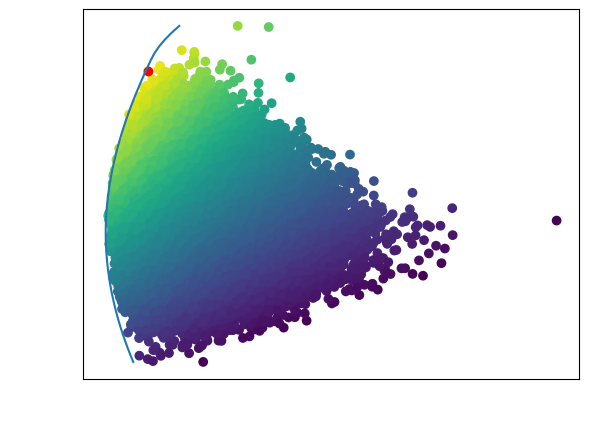

In [ ]:
# código copiado da internet

from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import yfinance as yf

inicio = dt.date(2014, 1, 1)
final = dt.date(2022, 12, 31)

lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

dados = yf.download(lista_acoes, start=inicio, end=final)['Close']
precos = dados.dropna()

retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna()
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

numero_carteiras = 100000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos / np.sum(pesos)
    tabela_pesos[k, :] = pesos

    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    tabela_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov * 252, pesos)))
    tabela_sharpe[k] = tabela_retornos_esperados[k] / tabela_volatilidades_esperadas[k]

indice_do_sharpe_maximo = tabela_sharpe.argmax()
peso_otimo = tabela_pesos[indice_do_sharpe_maximo]

tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1
eixo_y_fronteira_eficiente = np.linspace(
    tabela_retornos_esperados_arit.min(),
    tabela_retornos_esperados_arit.max(),
    50
)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    return retorno

def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov * 252, peso_teste)))
    return vol

peso_inicial = [1 / len(lista_acoes)] * len(lista_acoes)
limites = tuple((0, 1) for _ in lista_acoes)

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:
    restricoes = (
        {'type': 'eq', 'fun': checando_soma_pesos},
        {'type': 'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel}
    )
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites, constraints=restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

fig, ax = plt.subplots()
ax.scatter(tabela_volatilidades_esperadas, tabela_retornos_esperados_arit, c=tabela_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax.scatter(
    tabela_volatilidades_esperadas[indice_do_sharpe_maximo],
    tabela_retornos_esperados_arit[indice_do_sharpe_maximo],
    c="red"
)

ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()


In [2]:
import yfinance as yf

bbas = yf.Ticker("BBAS3.SA")
divs = bbas.dividends
print(divs.tail(10))



Date
2019-11-22 00:00:00-03:00    1.007899
2019-12-12 00:00:00-03:00    0.486425
2020-02-26 00:00:00-03:00    1.211775
2020-03-12 00:00:00-03:00    0.500910
2020-08-24 00:00:00-03:00    1.220351
2020-09-14 00:00:00-03:00    0.284007
2020-12-14 00:00:00-03:00    0.322999
2021-03-12 00:00:00-03:00    0.402324
2021-08-24 00:00:00-03:00    0.961641
2022-03-15 00:00:00-03:00    0.581554
Name: Dividends, dtype: float64


In [ ]:
# informações disponíveis em ticker.info
import yfinance as yf

ticker = yf.Ticker("PETR4.SA")
info = ticker.info

for key, value in info.items():
    print(f"{key}: {value}")

address1: Avenida Henrique Valadares, 28
city: Rio de Janeiro
state: RJ
zip: 20231-030
country: Brazil
phone: 55 21 3224 2401
website: https://petrobras.com.br
industry: Oil & Gas Integrated
industryKey: oil-gas-integrated
industryDisp: Oil & Gas Integrated
sector: Energy
sectorKey: energy
sectorDisp: Energy
longBusinessSummary: Petróleo Brasileiro S.A. - Petrobras explores, produces, and sells oil and gas in Brazil and internationally. It operates through three segments: Exploration and Production; Refining, Transportation & Marketing; and Gas & Low Carbon Energies. The Exploration and Production segment explores, develops, and produces crude oil, natural gas liquids, and natural gas primarily for supplies to the domestic refineries. The Refining, Transportation and Marketing segment engages in the refining, logistics, transport, acquisition, and export of crude oil; trading of oil products; and production of fertilizers, as well as holding interests in petrochemical companies. The Ga

In [80]:
import yfinance as yf
import pandas as pd

def consulta_info(ticker_str):
    # Cria o objeto Ticker
    ticker = yf.Ticker(ticker_str)
    
    # Obtém o dicionário com os dados fundamentais (info)
    info = ticker.info
    print("=== Chaves disponíveis em ticker.info ===")
    for key in sorted(info.keys()):
        print(key)
        
    # Também exibe os primeiros valores para visualização
    print("\n=== Exemplo de dados em ticker.info ===")
    for key in sorted(info.keys()):
        print(f"{key}: {info[key]}")
        
def consulta_historico(ticker_str, period="6mo", interval="1d"):
    # Obtém dados históricos
    ticker = yf.Ticker(ticker_str)
    hist = ticker.history(period=period, interval=interval)
    
    print("\n=== Colunas do DataFrame histórico ===")
    print(hist.columns.tolist())
    print("\nPrimeiras linhas do histórico:")
    print(hist.head())

if __name__ == "__main__":
    # Exemplo: consulta para o ticker 'PETR4.SA'
    ticker_symbol = "META"  # Substitua pelo ticker desejado
    print(f"Consultando dados para {ticker_symbol}...\n")
    
    consulta_info(ticker_symbol)
    consulta_historico(ticker_symbol)

Consultando dados para META...



HTTP Error 401: 


=== Chaves disponíveis em ticker.info ===
ask
askSize
averageAnalystRating
averageDailyVolume10Day
averageDailyVolume3Month
bid
bidSize
bookValue
corporateActions
cryptoTradeable
currency
customPriceAlertConfidence
displayName
dividendDate
dividendRate
dividendYield
earningsCallTimestampEnd
earningsCallTimestampStart
earningsTimestamp
earningsTimestampEnd
earningsTimestampStart
epsCurrentYear
epsForward
epsTrailingTwelveMonths
esgPopulated
exchange
exchangeDataDelayedBy
exchangeTimezoneName
exchangeTimezoneShortName
fiftyDayAverage
fiftyDayAverageChange
fiftyDayAverageChangePercent
fiftyTwoWeekChangePercent
fiftyTwoWeekHigh
fiftyTwoWeekHighChange
fiftyTwoWeekHighChangePercent
fiftyTwoWeekLow
fiftyTwoWeekLowChange
fiftyTwoWeekLowChangePercent
fiftyTwoWeekRange
financialCurrency
firstTradeDateMilliseconds
forwardPE
fullExchangeName
gmtOffSetMilliseconds
hasPrePostMarketData
ipoExpectedDate
isEarningsDateEstimate
language
longName
market
marketCap
marketState
messageBoardId
priceEpsCurren

In [81]:
import yfinance as yf

# Lista de tickers (note o sufixo .SA para ações brasileiras)
tickers = ["BBAS3.SA", "PETR4.SA"]

for ticker in tickers:
    t = yf.Ticker(ticker)
    info = t.info
    # Se o campo 'sector' não estiver disponível, pode tentar 'industry'
    sector = info.get("sector", "Não disponível")
    industry = info.get("industry", "Não disponível")
    print(f"Ticker: {ticker}")
    print(f"  Setor  : {sector}")
    print(f"  Indústria: {industry}")
    print("-" * 50)

HTTP Error 401: 


Ticker: BBAS3.SA
  Setor  : Não disponível
  Indústria: Não disponível
--------------------------------------------------


HTTP Error 401: 


Ticker: PETR4.SA
  Setor  : Não disponível
  Indústria: Não disponível
--------------------------------------------------


In [ ]:
#Este código está funcionando para gerar o gráfico da máxima fronteira eficiente, com empresas fixas
import yfinance as yf
import numpy as np
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import matplotlib
matplotlib.use("Qt5Agg")  # ou "QtAgg", se preferir
import matplotlib.pyplot as plt


# 1) DEFINIÇÃO DO PERÍODO
inicio = dt.date(2014, 1, 1)
final = dt.date(2022, 12, 31)

# 2) LISTA DE AÇÕES (você pode incluir quantas quiser)
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

# 3) DOWNLOAD DOS PRECOS AJUSTADOS VIA YFINANCE
df_precos = yf.download(
    tickers=lista_acoes,
    start=inicio,
    end=final,
    auto_adjust=True,  # os preços já ficam ajustados
    progress=False
)

# Se for data de múltiplos tickers, normalmente a coluna "Close" estará em um MultiIndex.
if isinstance(df_precos.columns, pd.MultiIndex):
    precos = df_precos["Close"].copy()
else:
    precos = pd.DataFrame(df_precos["Close"])


# Pegamos apenas a coluna 'Close' (Fechamento Ajustado)
if isinstance(df_precos.columns, pd.MultiIndex):
    precos = df_precos["Close"].copy()
else:
    # Se só um ticker, ele não cria MultiIndex
    precos = pd.DataFrame(df_precos["Close"])
    
# Exibir apenas para debug (comente se não quiser ver)
print("Primeiras linhas de 'Close':")
print(precos.head())

# 4) CÁLCULO DE RETORNOS LOGARÍTMICOS DIÁRIOS
retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna()
media_retornos = retornos.mean()       # Série com a média diária de cada ação
matriz_cov = retornos.cov()             # Matriz de covariância diária

# 5) MONTE CARLO PARA ENCONTRAR AÇÔES DE SHARPE MÁXIMO (opcional)
numero_carteiras = 100_000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    pesos = np.random.random(len(lista_acoes))
    pesos /= np.sum(pesos)
    tabela_pesos[k, :] = pesos

    # Retorno anualizado aproximado: média diária * 252 dias úteis
    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos) * 252
    # Vol anualizada: sqrt(pesos^T * cov*252 * pesos)
    tabela_volatilidades_esperadas[k] = np.sqrt(
        np.dot(pesos.T, np.dot(matriz_cov * 252, pesos))
    )
    tabela_sharpe[k] = (
        tabela_retornos_esperados[k] / tabela_volatilidades_esperadas[k]
    )

indice_sharpe_max = tabela_sharpe.argmax()
pesos_sharpe_max = tabela_pesos[indice_sharpe_max]

print("\nPesos que maximizam Sharpe (via Monte Carlo):")
for acao, peso in zip(lista_acoes, pesos_sharpe_max):
    print(f"{acao}: {peso:.4f}")

# Converter retorno logarítmico de volta a retorno aritmético
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

# 6) CONSTRUÇÃO DA FRONTEIRA EFICIENTE (Fronteira Média-Variância)

# 6.1) Função que, dado um vetor de pesos, retorna o retorno aritmético anualizado
def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    ret_diario = np.sum(media_retornos * peso_teste)
    ret_anual = ret_diario * 252
    return np.exp(ret_anual) - 1  # converte de log para aritmético

# 6.2) Soma dos pesos deve ser 1 (restrição)
def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

# 6.3) Função que retorna a volatilidade anualizada dado pesos
def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol_diaria = np.sqrt(
        np.dot(peso_teste.T, np.dot(matriz_cov, peso_teste))
    )
    vol_anual = vol_diaria * np.sqrt(252)
    return vol_anual

# 6.4) Definindo limites e chute inicial
peso_inicial = [1 / len(lista_acoes)] * len(lista_acoes)
limites = tuple((0, 1) for _ in lista_acoes)

# 6.5) Eixo de retornos desejados (50 pontos igualmente espaçados entre min e max)
eixo_y_fronteira_eficiente = np.linspace(
    np.min(tabela_retornos_esperados_arit),
    np.max(tabela_retornos_esperados_arit),
    50
)

eixo_x_fronteira_eficiente = []

for retorno_alvo in eixo_y_fronteira_eficiente:
    restricoes = (
        {"type": "eq", "fun": checando_soma_pesos},
        {"type": "eq", "fun": lambda w: pegando_retorno(w) - retorno_alvo},
    )
    resultado = minimize(
        pegando_vol,
        peso_inicial,
        method="SLSQP",
        bounds=limites,
        constraints=restricoes,
    )
    # 'fun' devolve a volatilidade encontrada
    eixo_x_fronteira_eficiente.append(resultado["fun"])

# 7) PLOT DA DISPERSÃO (Monte Carlo) E FRONTEIRA EFICIENTE

fig, ax = plt.subplots(figsize=(10, 6))

# scatter dos pontos de Monte Carlo
scatter = ax.scatter(
    tabela_volatilidades_esperadas,
    tabela_retornos_esperados_arit,
    c=tabela_sharpe,
    cmap="viridis",
    s=15,
    alpha=0.6,
)

# Destaque do ponto de Sharpe máximo
ax.scatter(
    tabela_volatilidades_esperadas[indice_sharpe_max],
    tabela_retornos_esperados_arit[indice_sharpe_max],
    c="red",
    s=50,
    label="Sharpe Máximo",
)

# curva da fronteira eficiente
ax.plot(
    eixo_x_fronteira_eficiente,
    eixo_y_fronteira_eficiente,
    color="orange",
    linewidth=2,
    label="Fronteira Eficiente",
)

# Formatação dos eixos em porcentagem
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Volatilidade Anual Esperada")
ax.set_ylabel("Retorno Anual Esperado")
ax.set_title("Carteiras Aleatórias e Fronteira Eficiente")
ax.legend()

cbar = fig.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Sharpe Ratio")

plt.tight_layout()
plt.show()
#plt.savefig("grafico.png")


Primeiras linhas de 'Close':
Ticker       EGIE3.SA  EQTL3.SA  LREN3.SA  PETR4.SA   VALE3.SA  WEGE3.SA
Date                                                                    
2014-01-02  14.461246  4.340795  7.032318  4.580417  17.383587  3.665127
2014-01-03  14.548365  4.268416  7.131246  4.512053  17.009048  3.631370
2014-01-06  14.271177  4.222704  7.031126  4.544868  17.024031  3.650661
2014-01-07  14.156340  4.222704  7.170578  4.419077  16.604548  3.648250
2014-01-08  14.124662  4.239846  7.157468  4.427282  16.719406  3.585556

Pesos que maximizam Sharpe (via Monte Carlo):
WEGE3.SA: 0.0190
LREN3.SA: 0.3935
VALE3.SA: 0.0090
PETR4.SA: 0.0139
EQTL3.SA: 0.0673
EGIE3.SA: 0.4972


C:\Users\Diego\AppData\Local\Temp\ipykernel_17248\599253152.py:178: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
#Este código está funcionando para gerar o gráfico da máxima fronteira eficiente, com empresas fixas
import yfinance as yf
import numpy as np
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import matplotlib
matplotlib.use("Qt5Agg")  # ou "QtAgg", se preferir
import matplotlib.pyplot as plt


# 1) DEFINIÇÃO DO PERÍODO
inicio = dt.date(2014, 1, 1)
final = dt.date(2022, 12, 31)

# 2) LISTA DE AÇÕES (você pode incluir quantas quiser)
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "EQTL3", "EGIE3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

# 3) DOWNLOAD DOS PRECOS AJUSTADOS VIA YFINANCE
df_precos = yf.download(
    tickers=lista_acoes,
    start=inicio,
    end=final,
    auto_adjust=True,  # os preços já ficam ajustados
    progress=False
)

# Se for data de múltiplos tickers, normalmente a coluna "Close" estará em um MultiIndex.
if isinstance(df_precos.columns, pd.MultiIndex):
    precos = df_precos["Close"].copy()
else:
    precos = pd.DataFrame(df_precos["Close"])


# Pegamos apenas a coluna 'Close' (Fechamento Ajustado)
if isinstance(df_precos.columns, pd.MultiIndex):
    precos = df_precos["Close"].copy()
else:
    # Se só um ticker, ele não cria MultiIndex
    precos = pd.DataFrame(df_precos["Close"])
    
# Exibir apenas para debug (comente se não quiser ver)
print("Primeiras linhas de 'Close':")
print(precos.head())

# 4) CÁLCULO DE RETORNOS LOGARÍTMICOS DIÁRIOS
retornos = precos.pct_change().apply(lambda x: np.log(1 + x)).dropna()
media_retornos = retornos.mean()       # Série com a média diária de cada ação
matriz_cov = retornos.cov()             # Matriz de covariância diária

# 5) MONTE CARLO PARA ENCONTRAR AÇÔES DE SHARPE MÁXIMO (opcional)
numero_carteiras = 100_000
tabela_retornos_esperados = np.zeros(numero_carteiras)
tabela_volatilidades_esperadas = np.zeros(numero_carteiras)
tabela_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    pesos = np.random.random(len(lista_acoes))
    pesos /= np.sum(pesos)
    tabela_pesos[k, :] = pesos

    # Retorno anualizado aproximado: média diária * 252 dias úteis
    tabela_retornos_esperados[k] = np.sum(media_retornos * pesos) * 252
    # Vol anualizada: sqrt(pesos^T * cov*252 * pesos)
    tabela_volatilidades_esperadas[k] = np.sqrt(
        np.dot(pesos.T, np.dot(matriz_cov * 252, pesos))
    )
    tabela_sharpe[k] = (
        tabela_retornos_esperados[k] / tabela_volatilidades_esperadas[k]
    )

indice_sharpe_max = tabela_sharpe.argmax()
pesos_sharpe_max = tabela_pesos[indice_sharpe_max]

print("\nPesos que maximizam Sharpe (via Monte Carlo):")
for acao, peso in zip(lista_acoes, pesos_sharpe_max):
    print(f"{acao}: {peso:.4f}")

# Converter retorno logarítmico de volta a retorno aritmético
tabela_retornos_esperados_arit = np.exp(tabela_retornos_esperados) - 1

# 6) CONSTRUÇÃO DA FRONTEIRA EFICIENTE (Fronteira Média-Variância)

# 6.1) Função que, dado um vetor de pesos, retorna o retorno aritmético anualizado
def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    ret_diario = np.sum(media_retornos * peso_teste)
    ret_anual = ret_diario * 252
    return np.exp(ret_anual) - 1  # converte de log para aritmético

# 6.2) Soma dos pesos deve ser 1 (restrição)
def checando_soma_pesos(peso_teste):
    return np.sum(peso_teste) - 1

# 6.3) Função que retorna a volatilidade anualizada dado pesos
def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol_diaria = np.sqrt(
        np.dot(peso_teste.T, np.dot(matriz_cov, peso_teste))
    )
    vol_anual = vol_diaria * np.sqrt(252)
    return vol_anual

# 6.4) Definindo limites e chute inicial
peso_inicial = [1 / len(lista_acoes)] * len(lista_acoes)
limites = tuple((0, 1) for _ in lista_acoes)

# 6.5) Eixo de retornos desejados (50 pontos igualmente espaçados entre min e max)
eixo_y_fronteira_eficiente = np.linspace(
    np.min(tabela_retornos_esperados_arit),
    np.max(tabela_retornos_esperados_arit),
    50
)

eixo_x_fronteira_eficiente = []

for retorno_alvo in eixo_y_fronteira_eficiente:
    restricoes = (
        {"type": "eq", "fun": checando_soma_pesos},
        {"type": "eq", "fun": lambda w: pegando_retorno(w) - retorno_alvo},
    )
    resultado = minimize(
        pegando_vol,
        peso_inicial,
        method="SLSQP",
        bounds=limites,
        constraints=restricoes,
    )
    # 'fun' devolve a volatilidade encontrada
    eixo_x_fronteira_eficiente.append(resultado["fun"])

# 7) PLOT DA DISPERSÃO (Monte Carlo) E FRONTEIRA EFICIENTE

fig, ax = plt.subplots(figsize=(10, 6))

# scatter dos pontos de Monte Carlo
scatter = ax.scatter(
    tabela_volatilidades_esperadas,
    tabela_retornos_esperados_arit,
    c=tabela_sharpe,
    cmap="viridis",
    s=15,
    alpha=0.6,
)

# Destaque do ponto de Sharpe máximo
ax.scatter(
    tabela_volatilidades_esperadas[indice_sharpe_max],
    tabela_retornos_esperados_arit[indice_sharpe_max],
    c="red",
    s=50,
    label="Sharpe Máximo",
)

# curva da fronteira eficiente
ax.plot(
    eixo_x_fronteira_eficiente,
    eixo_y_fronteira_eficiente,
    color="orange",
    linewidth=2,
    label="Fronteira Eficiente",
)

# Formatação dos eixos em porcentagem
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Volatilidade Anual Esperada")
ax.set_ylabel("Retorno Anual Esperado")
ax.set_title("Carteiras Aleatórias e Fronteira Eficiente")
ax.legend()

cbar = fig.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Sharpe Ratio")

plt.tight_layout()
plt.show()
#plt.savefig("grafico.png")


Primeiras linhas de 'Close':
Ticker       EGIE3.SA  EQTL3.SA  LREN3.SA  PETR4.SA   VALE3.SA  WEGE3.SA
Date                                                                    
2014-01-02  14.461246  4.340795  7.032318  4.580417  17.383587  3.665127
2014-01-03  14.548365  4.268416  7.131246  4.512053  17.009048  3.631370
2014-01-06  14.271177  4.222704  7.031126  4.544868  17.024031  3.650661
2014-01-07  14.156340  4.222704  7.170578  4.419077  16.604548  3.648250
2014-01-08  14.124662  4.239846  7.157468  4.427282  16.719406  3.585556

Pesos que maximizam Sharpe (via Monte Carlo):
WEGE3.SA: 0.0190
LREN3.SA: 0.3935
VALE3.SA: 0.0090
PETR4.SA: 0.0139
EQTL3.SA: 0.0673
EGIE3.SA: 0.4972


C:\Users\Diego\AppData\Local\Temp\ipykernel_17248\599253152.py:178: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
